## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# import tensorflow 
# from tensorflow import keras
import keras
from keras import backend as K
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model

import xgboost as xgb

import six
from six import StringIO  

import random 

from IPython.display import Image  
import pydotplus
import re

import warnings
warnings.filterwarnings('ignore')


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


## Reading the Data

In [2]:
fingerprints_df_from_file = pd.read_csv('../Dataset/Original_Dataset/Whole_Dataset/fingerprint.csv')
fingerprints_df = fingerprints_df_from_file.iloc[: , 2:]
#training_cols = [col for col in fingerprints_df.columns if col not in ['channel1', 'channel2','channel3','channel4','channel5','channel6','channel7','channel8','channel9','channel10','channel11','channel12','channel13', 'channel14', 'channel15', 'channel16', 'channel17', 'channel18', 'channel19', 'channel20','location']]
training_cols = [col for col in fingerprints_df.columns if col not in ['location']]
# X = fingerprints_df.loc[:, training_cols]
# target = fingerprints_df.loc[:, 'location']
fingerprints_df


beacon1  channel1  beacon2  channel2  beacon3  channel3  beacon4  \
0        -100        37      -81        37     -300         0     -300   
1         -97        37      -87        38     -300         0     -300   
2         -91        37      -84        38     -300         0     -300   
3         -92        38      -85        38      -95        38     -300   
4         -94        37      -80        37     -300         0     -300   
...       ...       ...      ...       ...      ...       ...      ...   
1194     -300         0     -300         0     -300         0     -300   
1195     -300         0     -300         0     -300         0     -300   
1196     -300         0     -300         0     -300         0     -300   
1197     -300         0     -300         0     -300         0     -300   
1198     -300         0     -300         0     -300         0     -300   

      channel4  beacon5  channel5  ...  channel16  beacon17  channel17  \
0            0     -300         0  ...          0      -300          0   
1            0     -300         0  ...          0      -300          0   
2            0     -300         0  ...          0      -300          0   
3            0     -300         0  ...          0      -300          0   
4            0     -300         0  ...          0      -300          0   
...        ...      ...       ...  ...        ...       ...        ...   
1194         0     -300         0  ...         37       -92         38   
1195         0     -300         0  ...         37       -85         38   
1196         0     -300         0  ...         37       -91         37   
1197         0     -300         0  ...         37       -85         38   
1198         0     -300         0  ...         38       -91         38   

      beacon18  channel18  beacon19  channel19  beacon20  channel20  location  
0         -300          0      -300          0      -300          0        b1  
1         -300          0      -300          0      -300          0        b1  
2         -300          0      -300          0      -300          0        b1  
3         -300          0      -300          0      -300          0        b1  
4         -300          0      -300          0      -300          0        b1  
...        ...        ...       ...        ...       ...        ...       ...  
1194       -83         38       -88         37      -300          0      sa15  
1195       -82         39       -91         38      -300          0      sa15  
1196       -98         37       -92         37      -300          0      sa15  
1197       -78         38       -89         37      -300          0      sa15  
1198       -97         37       -89         38      -300          0      sa15  

[1199 rows x 41 columns]

## Data Preprocessing

### Kalman Filter

In [3]:
def calculate_kalman_equations(current_measurement, prior_mean, prior_variance, mean_prediction_factor, variance_prediction_factor, measurement_error , process_noise):
    extrapolated_mean = mean_prediction_factor*prior_mean + np.random.normal(0, process_noise)
    extrapolated_variance = prior_variance*variance_prediction_factor + process_noise
    
    measurement_variance = measurement_error
    
    kalman_gain = extrapolated_variance/(extrapolated_variance + measurement_variance)
    current_mean_estimate = extrapolated_mean + kalman_gain*(current_measurement - extrapolated_mean)
    current_variance_estimate = (1-kalman_gain)*extrapolated_variance
    
    return current_mean_estimate, current_variance_estimate

In [4]:
def kalman_filter(measured_signal, mean_prediction_factor =1, variance_prediction_factor =1, measurement_error = 6, process_noise= 1.6):
    estimated_signal = []
    #initialization
    estimated_signal.append(measured_signal[0])
    prior_mean = measured_signal[0]
    prior_variance = 0
  
    for i in range(1, len(measured_signal)):
        if measured_signal[i] == -300:
            calculated_mean, calculated_variance = calculate_kalman_equations(measured_signal[i], prior_mean, prior_variance, mean_prediction_factor, variance_prediction_factor, measurement_error, process_noise)
            estimated_signal.append(calculated_mean)  
        else:
            prior_mean, prior_variance = calculate_kalman_equations(measured_signal[i], prior_mean, prior_variance, mean_prediction_factor, variance_prediction_factor, measurement_error, process_noise)
            estimated_signal.append(prior_mean)  
    
    return estimated_signal

### Alpha-Beta-Gamma Filter

In [5]:
def alpha_beta_gamma_filter(measured_signal):
    estimated_signal = []
    #initialization
    estimated_signal.append(measured_signal[0])
    prior_mean = measured_signal[0]
    
    for i in range(1, len(measured_signal)):
        alpha = 1/i
        if measured_signal[i] == -300:
            estimated_signal.append(prior_mean + alpha*(measured_signal[i] - prior_mean))
        else:
            prior_mean = prior_mean + alpha*(measured_signal[i] - prior_mean)
            estimated_signal.append(prior_mean)
        
    return estimated_signal
    

### Fast Fourier Transform Filter

In [6]:
def fast_fourier_transform_filter(measured_signal, window_size=8, M=2):
    estimated_signal = []
    for j in range(0, np.shape(measured_signal)[0], window_size):  
        window_size = np.minimum(window_size, np.shape(measured_signal)[0] - j)  
        R_0 = np.zeros(window_size)
        R_0[:] = measured_signal[j:j + window_size] 
        R_0_fft = np.fft.fft(R_0) 
        if window_size <= 3:
            M = 1;
        for k in range(int(window_size/ 2)): 
            R_0_fft[M + k] = 0  
            R_0_fft[-1 - M - k] = 0

        R_0_ifft = np.fft.ifft(R_0_fft)  
        for i in range(0, window_size):
            estimated_signal.append(R_0_ifft[i]) 

    return estimated_signal

### Filter Application Method

In [7]:
def apply_filter(dataframe, filter_name,filename):
    filtered_data = dataframe.to_dict()
    for key in filtered_data:
        filtered_data[key] = list(filtered_data[key].values())
    
    unique_locations = dataframe.location.unique()
    for i in range(1,21):
        current_beacon_rssis = []
        for location in unique_locations:
            current_rssis = dataframe.loc[dataframe['location'] == location]   
            current_signal = current_rssis['beacon'+str(i)].values.tolist()
            if filter_name == "kalman":
                estimated_signal = kalman_filter(current_signal)
            elif filter_name == "alpha_beta_gamma":
                estimated_signal = alpha_beta_gamma_filter(current_signal)
            elif filter_name == "fast_fourier_transform":
                estimated_signal = fast_fourier_transform_filter(current_signal)
                estimated_signal = [c.real for c in estimated_signal]

            current_beacon_rssis = current_beacon_rssis + estimated_signal
        filtered_data['beacon'+str(i)] = current_beacon_rssis
        
    result = pd.DataFrame(filtered_data)
    result.to_csv("../Dataset/Filtered_Dataset/"+filter_name+"/"+filename, sep=',', index=False, encoding='utf-8')
    return result

In [8]:
def apply_filter_to_whole(dataframe, filter_name, filename):
    filtered_data = dataframe.to_dict()
    for key in filtered_data:
        filtered_data[key] = list(filtered_data[key].values())

    for i in range(1,21):
        current_signal = dataframe['beacon'+str(i)].values.tolist()
        if filter_name == "kalman":
            estimated_signal = kalman_filter(current_signal)
        elif filter_name == "alpha_beta_gamma":
            estimated_signal = alpha_beta_gamma_filter(current_signal)
        elif filter_name == "fast_fourier_transform":
            estimated_signal = fast_fourier_transform_filter(current_signal)
            estimated_signal = [c.real for c in estimated_signal]
            
        filtered_data['beacon'+str(i)] = estimated_signal      
    result = pd.DataFrame(filtered_data)
    result.to_csv("../Dataset/Filtered_Dataset/"+filter_name+"/"+filename, sep=',', index=False, encoding='utf-8')
    return result

### Data Type Correction

In [9]:
fingerprints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 41 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   beacon1    1199 non-null   int64 
 1   channel1   1199 non-null   int64 
 2   beacon2    1199 non-null   int64 
 3   channel2   1199 non-null   int64 
 4   beacon3    1199 non-null   int64 
 5   channel3   1199 non-null   int64 
 6   beacon4    1199 non-null   int64 
 7   channel4   1199 non-null   int64 
 8   beacon5    1199 non-null   int64 
 9   channel5   1199 non-null   int64 
 10  beacon6    1199 non-null   int64 
 11  channel6   1199 non-null   int64 
 12  beacon7    1199 non-null   int64 
 13  channel7   1199 non-null   int64 
 14  beacon8    1199 non-null   int64 
 15  channel8   1199 non-null   int64 
 16  beacon9    1199 non-null   int64 
 17  channel9   1199 non-null   int64 
 18  beacon10   1199 non-null   int64 
 19  channel10  1199 non-null   int64 
 20  beacon11   1199 non-null   int

In [10]:
channel_cols = ['channel1', 'channel2','channel3','channel4','channel5','channel6','channel7','channel8','channel9','channel10','channel11','channel12','channel13', 'channel14', 'channel15', 'channel16', 'channel17', 'channel18', 'channel19', 'channel20']
for col in channel_cols:
    fingerprints_df[col] = fingerprints_df[col].map(str)
fingerprints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 41 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   beacon1    1199 non-null   int64 
 1   channel1   1199 non-null   object
 2   beacon2    1199 non-null   int64 
 3   channel2   1199 non-null   object
 4   beacon3    1199 non-null   int64 
 5   channel3   1199 non-null   object
 6   beacon4    1199 non-null   int64 
 7   channel4   1199 non-null   object
 8   beacon5    1199 non-null   int64 
 9   channel5   1199 non-null   object
 10  beacon6    1199 non-null   int64 
 11  channel6   1199 non-null   object
 12  beacon7    1199 non-null   int64 
 13  channel7   1199 non-null   object
 14  beacon8    1199 non-null   int64 
 15  channel8   1199 non-null   object
 16  beacon9    1199 non-null   int64 
 17  channel9   1199 non-null   object
 18  beacon10   1199 non-null   int64 
 19  channel10  1199 non-null   object
 20  beacon11   1199 non-null   int

### One-hot Encoding for Categorical Features

In [11]:
fingerprints_df = pd.get_dummies(fingerprints_df, columns = ['channel1', 'channel2','channel3','channel4','channel5','channel6','channel7','channel8','channel9','channel10','channel11','channel12','channel13', 'channel14', 'channel15', 'channel16', 'channel17', 'channel18', 'channel19', 'channel20'])
for col in fingerprints_df:
    print(col)
    print(fingerprints_df[col].unique())

beacon1
[-100  -97  -91  -92  -94  -99  -96  -98 -300  -93  -95 -101 -105 -102
 -106 -103  -89  -79  -81  -76  -77  -85  -80  -74  -78  -82  -72  -83
  -84  -87 -109  -88  -90  -86 -104]
beacon2
[ -81  -87  -84  -85  -80  -78  -86  -83  -94  -88  -82  -96  -93  -79
  -90  -89  -98  -91  -95  -77  -76  -74  -92  -97 -101  -70  -73  -71
  -75  -72 -102  -99 -100 -103 -104 -300]
beacon3
[-300  -95 -101  -97 -103  -99 -102  -98 -100 -104  -96 -105  -94  -93
  -92  -87  -86  -85  -90  -89  -82  -84  -91  -80  -88  -81  -83  -77
  -78  -79  -72  -76  -74]
beacon4
[-300 -101 -103  -98  -99 -105 -100  -97  -96  -95  -93 -104  -94 -106
 -102  -92  -90  -91  -88  -89  -87  -86  -82  -85  -84  -83  -80  -81
  -75  -77  -78  -71  -76  -79]
beacon5
[-300  -99  -98 -103  -97  -95  -96 -101  -94 -105  -93 -102 -106  -91
  -84  -89  -80  -88  -82  -83  -92  -90  -85 -100  -86  -87  -79  -81
  -76  -78  -74  -72]
beacon6
[-300 -100 -101 -102  -99  -97  -98  -96  -93  -95  -94  -88 -103 -105
  -91  -86 

### Label Encoding the Labels

In [12]:
label_encoder = preprocessing.LabelEncoder()
fingerprints_df['location']= label_encoder.fit_transform(fingerprints_df['location'])

In [13]:
enc_labels = fingerprints_df['location'].unique()
rev_enc_labels = label_encoder.inverse_transform(enc_labels)
print(enc_labels)
print(rev_enc_labels)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 36 37 38 39 40 41
 42 50 51 52 53 58 59 60 61 66 73 74 75 76 77 78 79 80 67 68 69 70 71 72
 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 43 44 45 46 47 48
 49 54 55 56 57 62 63 64 65 81 88 89 90 91 92 93 94 95 82 83 84 85 86 87]
['b1' 'b2' 'b3' 'b4' 'b5' 'b6' 'b7' 'b8' 'b9' 'be1' 'be2' 'be3' 'be4'
 'be5' 'be6' 'be7' 'be8' 'be9' 'h1' 'h2' 'h3' 'h4' 'h5' 'h6' 'h7' 'k1'
 'k2' 'k3' 'k4' 'l1' 'l2' 'l3' 'l4' 's1' 's2' 's3' 's4' 's5' 's6' 's7'
 's8' 's9' 's10' 's11' 's12' 's13' 's14' 's15' 'c1' 'c2' 'c3' 'c4' 'c5'
 'c6' 'c7' 'c8' 'c9' 'ce1' 'ce2' 'ce3' 'ce4' 'ce5' 'ce6' 'ce7' 'ce8' 'ce9'
 'ha1' 'ha2' 'ha3' 'ha4' 'ha5' 'ha6' 'ha7' 'ki1' 'ki2' 'ki3' 'ki4' 'li1'
 'li2' 'li3' 'li4' 'sa1' 'sa2' 'sa3' 'sa4' 'sa5' 'sa6' 'sa7' 'sa8' 'sa9'
 'sa10' 'sa11' 'sa12' 'sa13' 'sa14' 'sa15']


In [14]:
label_mappings= dict(zip(enc_labels, rev_enc_labels))
label_mappings

{0: 'b1',
 1: 'b2',
 2: 'b3',
 3: 'b4',
 4: 'b5',
 5: 'b6',
 6: 'b7',
 7: 'b8',
 8: 'b9',
 9: 'be1',
 10: 'be2',
 11: 'be3',
 12: 'be4',
 13: 'be5',
 14: 'be6',
 15: 'be7',
 16: 'be8',
 17: 'be9',
 36: 'h1',
 37: 'h2',
 38: 'h3',
 39: 'h4',
 40: 'h5',
 41: 'h6',
 42: 'h7',
 50: 'k1',
 51: 'k2',
 52: 'k3',
 53: 'k4',
 58: 'l1',
 59: 'l2',
 60: 'l3',
 61: 'l4',
 66: 's1',
 73: 's2',
 74: 's3',
 75: 's4',
 76: 's5',
 77: 's6',
 78: 's7',
 79: 's8',
 80: 's9',
 67: 's10',
 68: 's11',
 69: 's12',
 70: 's13',
 71: 's14',
 72: 's15',
 18: 'c1',
 19: 'c2',
 20: 'c3',
 21: 'c4',
 22: 'c5',
 23: 'c6',
 24: 'c7',
 25: 'c8',
 26: 'c9',
 27: 'ce1',
 28: 'ce2',
 29: 'ce3',
 30: 'ce4',
 31: 'ce5',
 32: 'ce6',
 33: 'ce7',
 34: 'ce8',
 35: 'ce9',
 43: 'ha1',
 44: 'ha2',
 45: 'ha3',
 46: 'ha4',
 47: 'ha5',
 48: 'ha6',
 49: 'ha7',
 54: 'ki1',
 55: 'ki2',
 56: 'ki3',
 57: 'ki4',
 62: 'li1',
 63: 'li2',
 64: 'li3',
 65: 'li4',
 81: 'sa1',
 88: 'sa2',
 89: 'sa3',
 90: 'sa4',
 91: 'sa5',
 92: 'sa6',
 93: 'sa

## Dataset Splitting

In [15]:
def split_train_validation_test(dataframe, train_size, validation_size):
    shuffled_df = dataframe.sample(frac=1, random_state = 37)
    train_num = int(train_size * len(dataframe))
    validation_num = int(validation_size * len(dataframe))
    test_num = len(dataframe) - train_num - validation_num
    
    train_set_with_label = shuffled_df[:train_num]
    validation_set_with_label = shuffled_df[train_num : train_num + validation_num]
    test_set_with_label = shuffled_df[ train_num + validation_num:]
    
    train_set_with_label = train_set_with_label.sort_values('location')
    validation_set_with_label = validation_set_with_label.sort_values('location')
    test_set_with_label = test_set_with_label.sort_values('location')
    
    training_cols = [col for col in train_set_with_label.columns if col not in ['location']]
    
    train_set = train_set_with_label.loc[:, training_cols]
    target_train = train_set_with_label.loc[:, 'location']
    
    validation_set = validation_set_with_label.loc[:, training_cols]
    target_validation = validation_set_with_label.loc[:, 'location']
    
    test_set = test_set_with_label.loc[:, training_cols]
    target_test = test_set_with_label.loc[:, 'location']
    
    
    
    return shuffled_df, train_set_with_label, validation_set_with_label, test_set_with_label, train_set, target_train, validation_set, target_validation, test_set, target_test

In [16]:
shuf, train, validation, test, X_train, target_train, X_validation, target_validation, X_test, target_test = split_train_validation_test(fingerprints_df, 0.8,0.1)

### Splitting Test

In [17]:
training_cols = [col for col in train.columns if col not in ['location']]

print("Shapes:")
print(X_train.shape, X_validation.shape, X_test.shape, target_train.shape, target_validation.shape, target_test.shape,"\n")

print("Check if the split is correct:")
print("Train columns: ", ((train.loc[:, training_cols]==X_train).all()).all())
print("Validation columns: ", ((validation.loc[:, training_cols]==X_validation).all()).all())
print("Test columns: ", ((test.loc[:, training_cols]==X_test).all()).all())
print("Train targets: ",(target_train==train['location']).all())
print("Validation targets: ",(target_validation==validation['location']).all())
print("Test targets: ",(target_test==test['location']).all())

Shapes:
(959, 100) (119, 100) (121, 100) (959,) (119,) (121,) 

Check if the split is correct:
Train columns:  True
Validation columns:  True
Test columns:  True
Train targets:  True
Validation targets:  True
Test targets:  True


In [18]:
train

beacon1  beacon2  beacon3  beacon4  beacon5  beacon6  beacon7  beacon8  \
17       -300      -84      -99     -300     -300     -300     -300     -300   
1         -97      -87     -300     -300     -300     -300     -300     -300   
10        -93      -86     -300     -300     -300     -300     -300     -300   
4         -94      -80     -300     -300     -300     -300     -300     -300   
6         -96      -81     -101     -300     -300     -300     -300     -300   
...       ...      ...      ...      ...      ...      ...      ...      ...   
1160     -300     -300     -300     -300     -300     -300     -300     -300   
1167     -300     -300     -300     -300     -300     -300     -300     -300   
1164     -300     -300     -300     -300     -300     -300     -300     -300   
1168     -300     -300     -300     -300     -300     -300     -300     -300   
1165     -300     -300     -300     -300     -300     -300     -300     -300   

      beacon9  beacon10  ...  channel18_38  channel18_39  channel19_0  \
17       -300       -99  ...             0             0            1   
1        -300       -97  ...             0             0            1   
10       -300      -300  ...             0             0            1   
4        -300       -99  ...             0             0            1   
6        -300      -300  ...             0             0            1   
...       ...       ...  ...           ...           ...          ...   
1160     -300      -300  ...             0             0            0   
1167     -300      -300  ...             0             1            0   
1164     -300      -300  ...             1             0            0   
1168     -300      -300  ...             1             0            0   
1165     -300      -300  ...             0             0            0   

      channel19_37  channel19_38  channel19_39  channel20_0  channel20_37  \
17               0             0             0            1             0   
1                0             0             0            1             0   
10               0             0             0            1             0   
4                0             0             0            1             0   
6                0             0             0            1             0   
...            ...           ...           ...          ...           ...   
1160             1             0             0            1             0   
1167             1             0             0            1             0   
1164             0             1             0            1             0   
1168             1             0             0            1             0   
1165             1             0             0            1             0   

      channel20_38  channel20_39  
17               0             0  
1                0             0  
10               0             0  
4                0             0  
6                0             0  
...            ...           ...  
1160             0             0  
1167             0             0  
1164             0             0  
1168             0             0  
1165             0             0  

[959 rows x 101 columns]

In [19]:
X_train

beacon1  beacon2  beacon3  beacon4  beacon5  beacon6  beacon7  beacon8  \
17       -300      -84      -99     -300     -300     -300     -300     -300   
1         -97      -87     -300     -300     -300     -300     -300     -300   
10        -93      -86     -300     -300     -300     -300     -300     -300   
4         -94      -80     -300     -300     -300     -300     -300     -300   
6         -96      -81     -101     -300     -300     -300     -300     -300   
...       ...      ...      ...      ...      ...      ...      ...      ...   
1160     -300     -300     -300     -300     -300     -300     -300     -300   
1167     -300     -300     -300     -300     -300     -300     -300     -300   
1164     -300     -300     -300     -300     -300     -300     -300     -300   
1168     -300     -300     -300     -300     -300     -300     -300     -300   
1165     -300     -300     -300     -300     -300     -300     -300     -300   

      beacon9  beacon10  ...  channel18_38  channel18_39  channel19_0  \
17       -300       -99  ...             0             0            1   
1        -300       -97  ...             0             0            1   
10       -300      -300  ...             0             0            1   
4        -300       -99  ...             0             0            1   
6        -300      -300  ...             0             0            1   
...       ...       ...  ...           ...           ...          ...   
1160     -300      -300  ...             0             0            0   
1167     -300      -300  ...             0             1            0   
1164     -300      -300  ...             1             0            0   
1168     -300      -300  ...             1             0            0   
1165     -300      -300  ...             0             0            0   

      channel19_37  channel19_38  channel19_39  channel20_0  channel20_37  \
17               0             0             0            1             0   
1                0             0             0            1             0   
10               0             0             0            1             0   
4                0             0             0            1             0   
6                0             0             0            1             0   
...            ...           ...           ...          ...           ...   
1160             1             0             0            1             0   
1167             1             0             0            1             0   
1164             0             1             0            1             0   
1168             1             0             0            1             0   
1165             1             0             0            1             0   

      channel20_38  channel20_39  
17               0             0  
1                0             0  
10               0             0  
4                0             0  
6                0             0  
...            ...           ...  
1160             0             0  
1167             0             0  
1164             0             0  
1168             0             0  
1165             0             0  

[959 rows x 100 columns]

## Applying Filtering

In [20]:
kalman_filtered = apply_filter(train, "kalman","kalman_1.csv")
apha_filtered = apply_filter(train, "alpha_beta_gamma","alpha_1.csv")
fft_filtered = apply_filter(train, "fast_fourier_transform","fft_1.csv")
train.to_csv("../Dataset/Filtered_Dataset/Original/"+"trained.csv", sep=',', index=False, encoding='utf-8')

In [21]:
filter_times = []
start_time = time.time()
kalman_filtered2 = apply_filter_to_whole(fingerprints_df, "kalman","kalman_2.csv")
runtime = round(time.time() - start_time,4)
filter_times.append(runtime)
print("Kalman Filter time: "+ str(runtime) + " seconds")
start_time = time.time()
alpha_filtered2 = apply_filter_to_whole(fingerprints_df, "alpha_beta_gamma","alpha_2.csv")
runtime = round(time.time() - start_time,4)
filter_times.append(runtime)
print("Alpha-Beta-Gamma Filter time: "+ str(runtime) + " seconds")
start_time = time.time()
fft_filtered2 = apply_filter_to_whole(fingerprints_df, "fast_fourier_transform","fft_2.csv")
runtime = round(time.time() - start_time,4)
filter_times.append(runtime)
print("Fast Fourier Transform Filter time: "+ str(runtime) + " seconds")

Kalman Filter time: 0.2331 seconds
Alpha-Beta-Gamma Filter time: 0.1321 seconds
Fast Fourier Transform Filter time: 0.3727 seconds


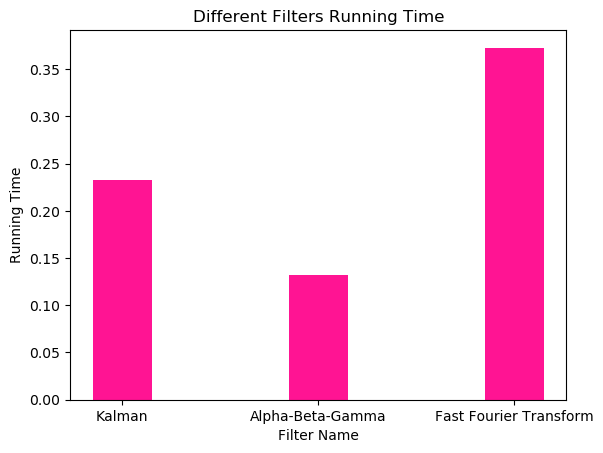

In [22]:
filters = ('Kalman', 'Alpha-Beta-Gamma', 'Fast Fourier Transform')
y_pos = np.arange(len(filters))

plt.bar(y_pos, filter_times,0.3, color="deeppink" ,align='center', alpha=1)
plt.rcParams['figure.figsize'] = [10, 5]
plt.xticks(y_pos, filters)
plt.xlabel('Filter Name')
plt.ylabel('Running Time')
plt.title('Different Filters Running Time')

plt.show()

In [23]:
kshuf, ktrain, kvalidation, ktest, kX_train, ktarget_train, kX_validation, ktarget_validation, kX_test, ktarget_test = split_train_validation_test(kalman_filtered2, 0.8,0.1)


In [24]:
ashuf, atrain, avalidation, atest, aX_train, atarget_train, aX_validation, atarget_validation, aX_test, atarget_test = split_train_validation_test(alpha_filtered2, 0.8,0.1)


In [25]:
fshuf, ftrain, fvalidation, ftest, fX_train, ftarget_train, fX_validation, ftarget_validation, fX_test, ftarget_test = split_train_validation_test(fft_filtered2, 0.8,0.1)


In [26]:
def plot_measured_estimated(measured_signal, estimated_signal, title):
    signals = [{'name': 'Measured Signal', 'x': np.arange(len(measured_signal)),
             'y': measured_signal, 'color':'orange', 'linewidth':3},
            {'name': 'Estimated Signal', 'x': np.arange(len(estimated_signal)),
             'y': estimated_signal, 'color':'green', 'linewidth':3}]

    fig, ax = plt.subplots()
    for signal in signals:
        ax.plot(signal['x'], signal['y'], 
                color=signal['color'], 
                linewidth=signal['linewidth'],
                label=signal['name'])
    plt.rcParams['figure.figsize'] = [40, 20]
    ax.legend()
    ax.set_title(title)
    plt.show()
    

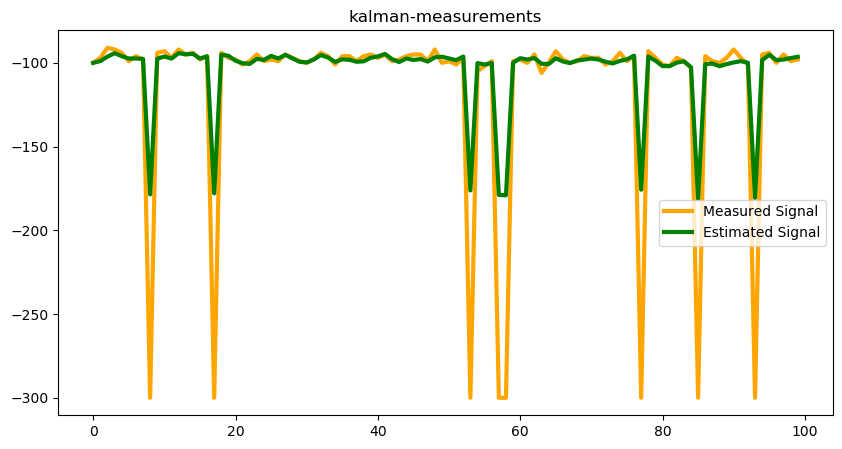

In [27]:
plot_measured_estimated(fingerprints_df['beacon1'].values.tolist()[:100],kalman_filtered2['beacon1'].values.tolist()[:100],"kalman-measurements")

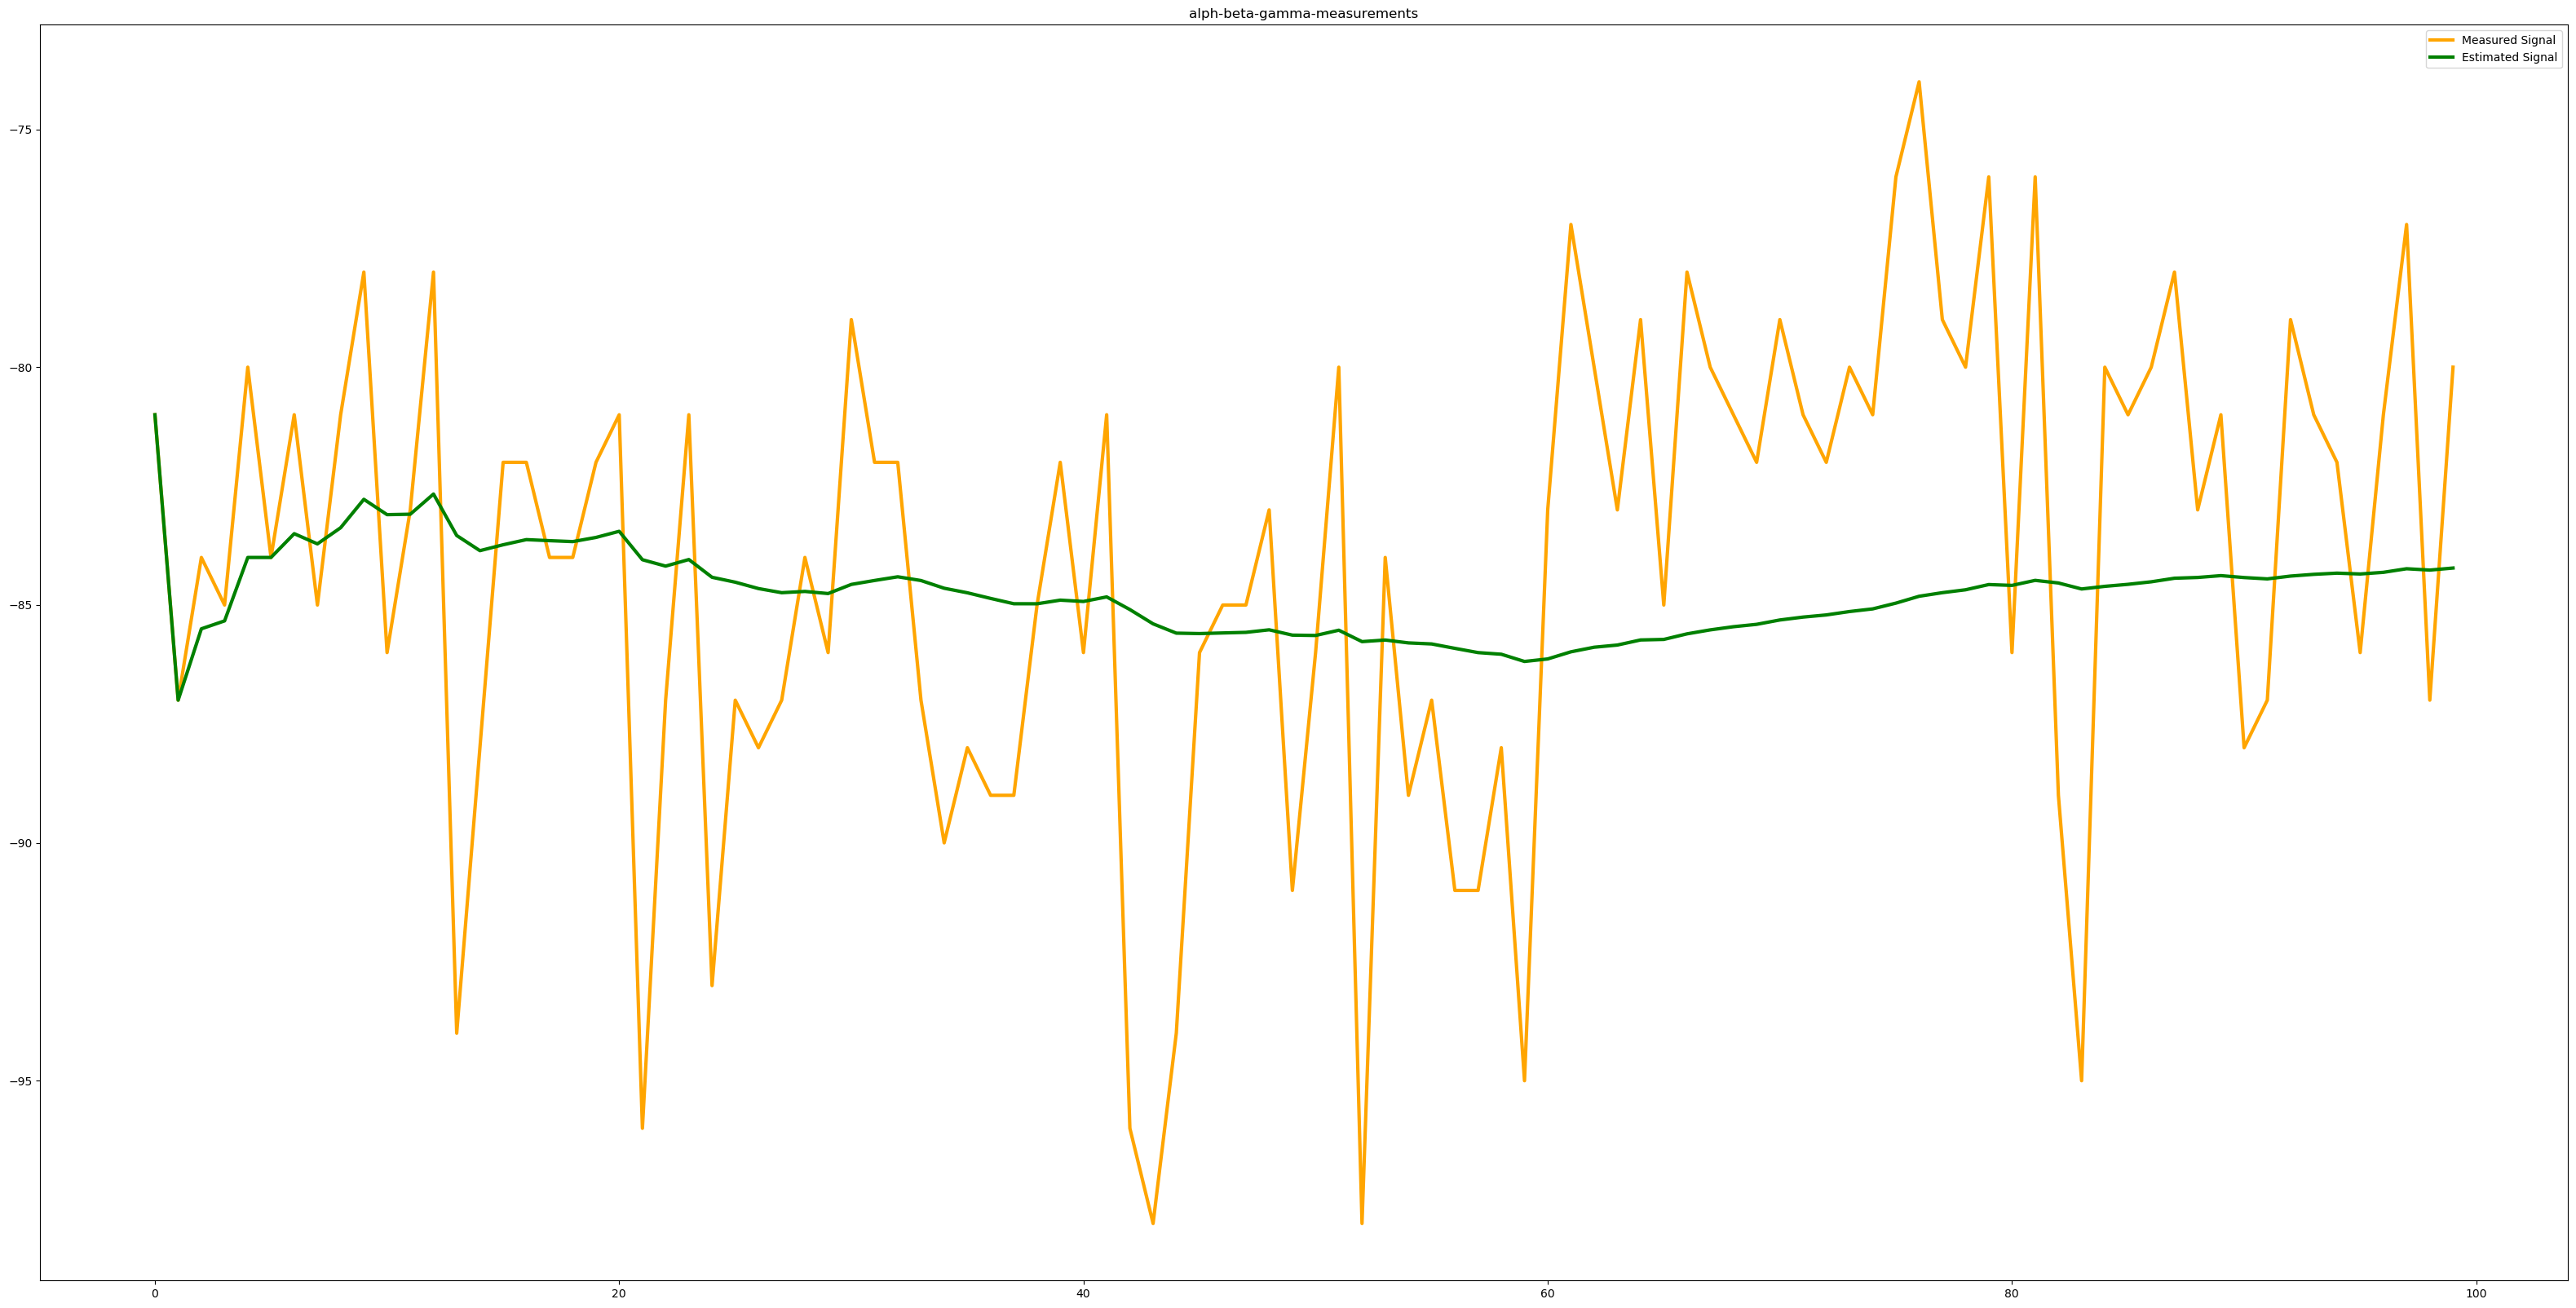

In [28]:
plot_measured_estimated(fingerprints_df['beacon2'].values.tolist()[:100],alpha_filtered2['beacon2'].values.tolist()[:100],"alph-beta-gamma-measurements")

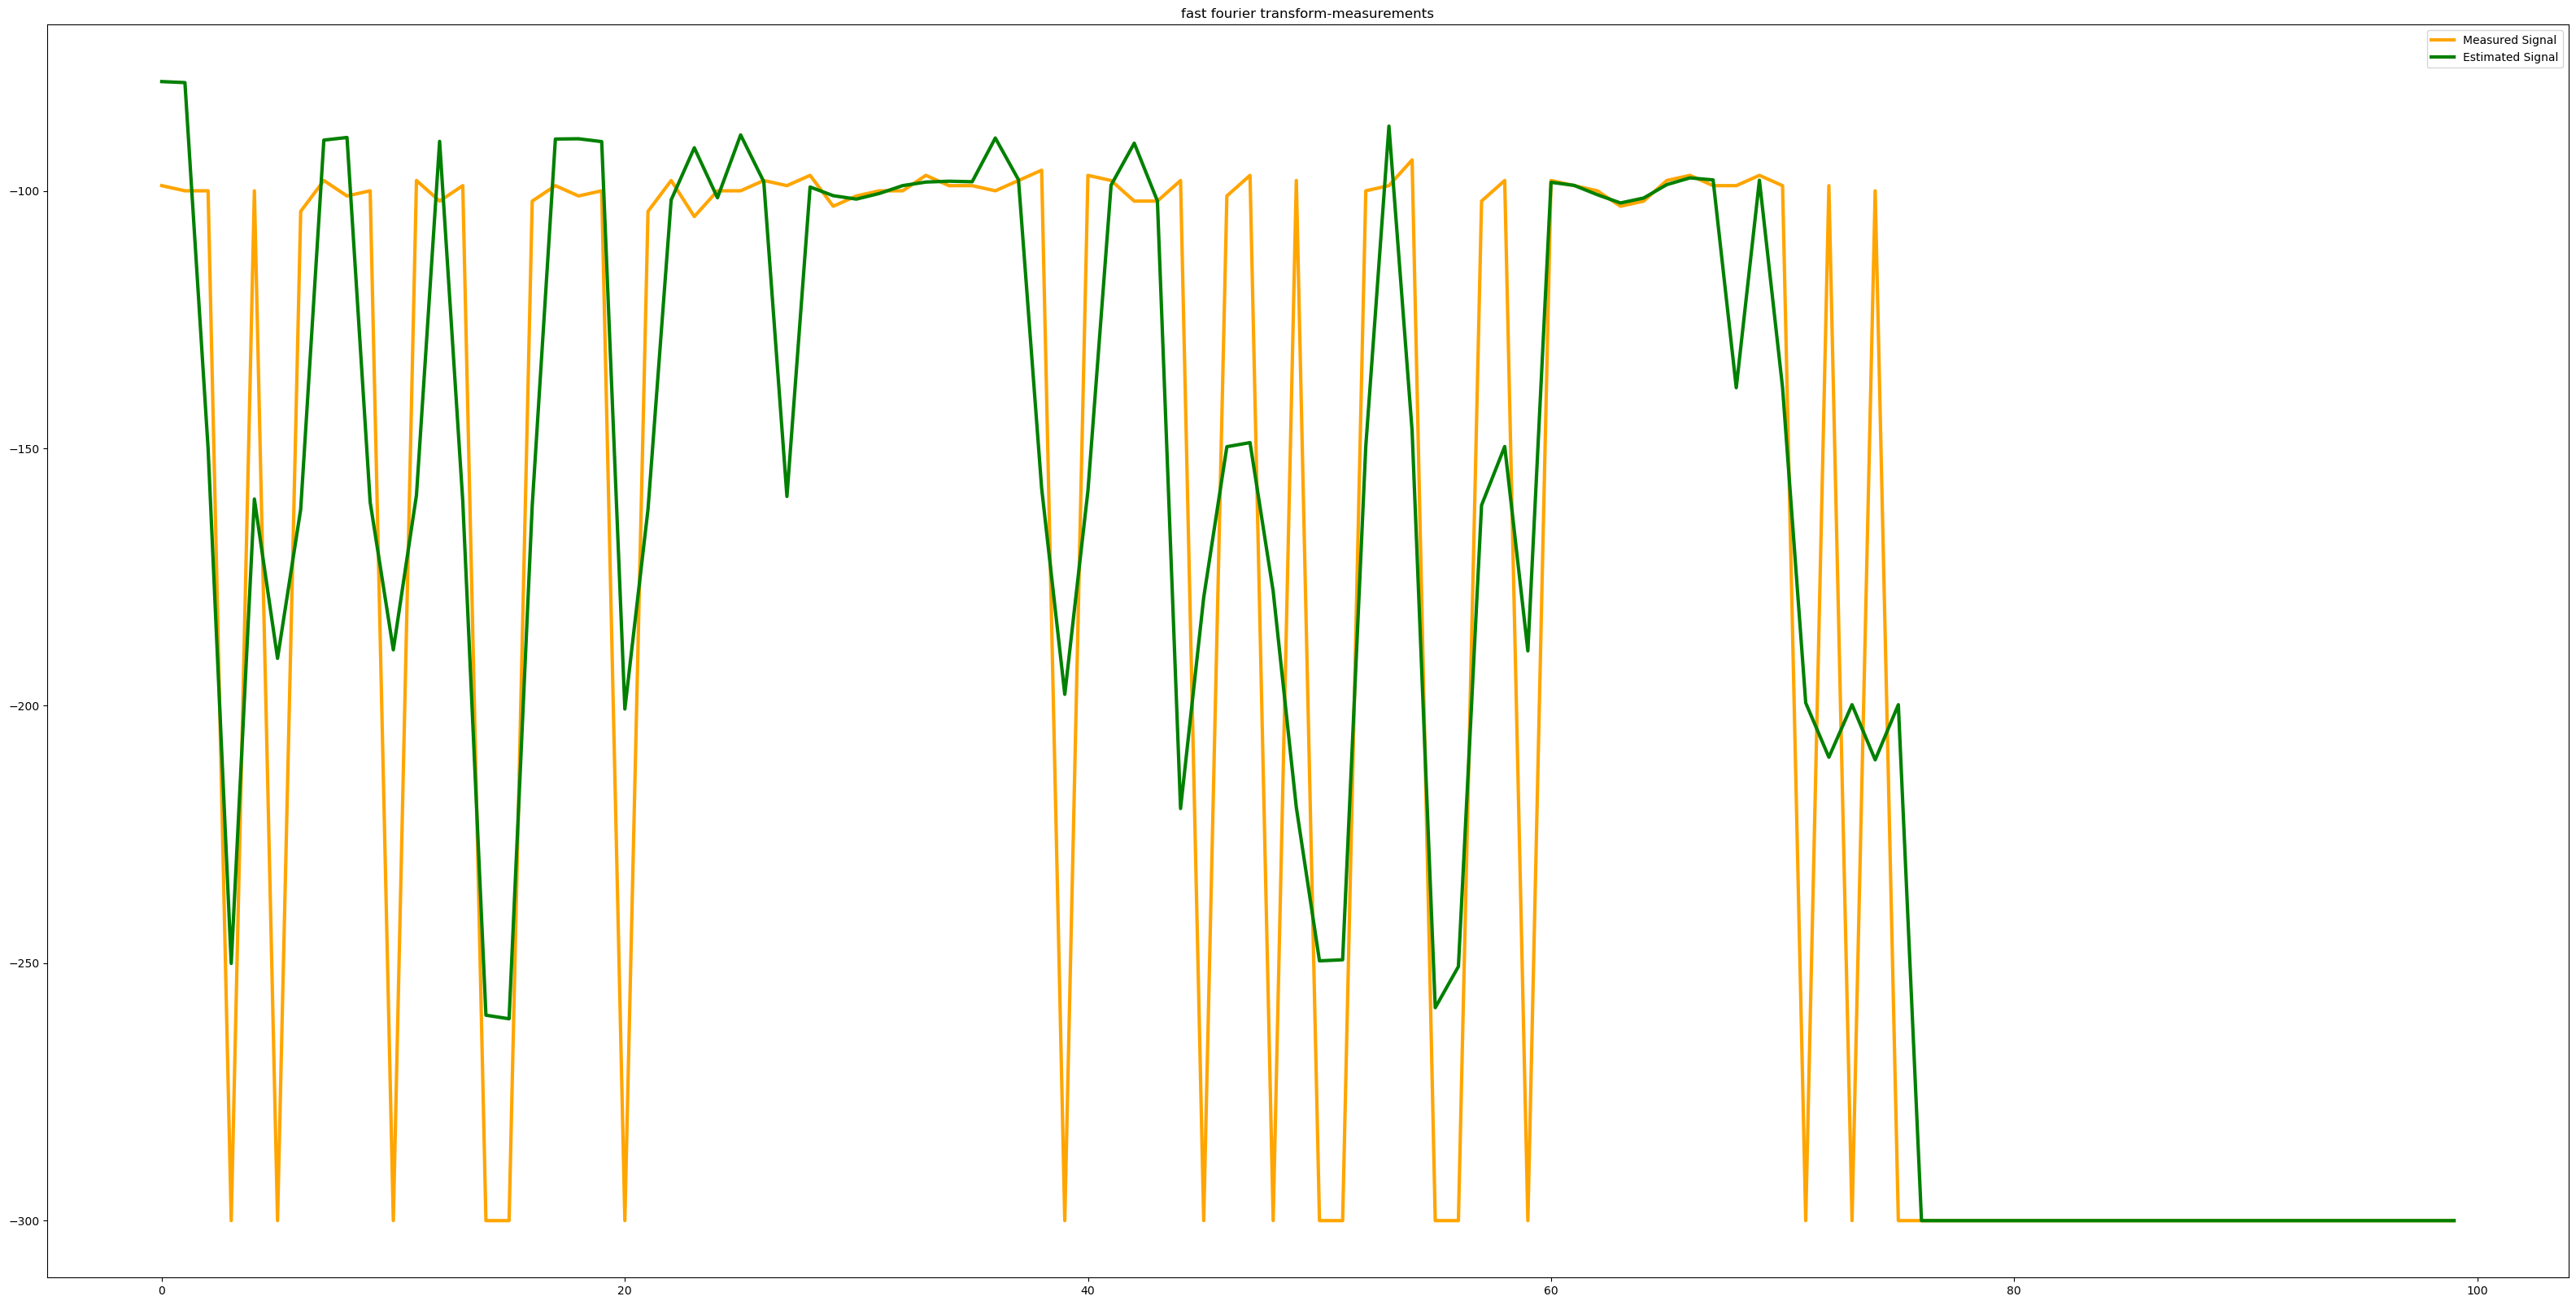

In [29]:
plot_measured_estimated(fingerprints_df['beacon3'].values.tolist()[100:200],fft_filtered2['beacon3'].values.tolist()[100:200],"fast fourier transform-measurements")

# Artificial Intelligence Algorithms

## K Nearest Neighbours

In [30]:
def k_nearest_neighbours(X_train, target_train, X_test, target_test,title):  
    accuracies = []
    for k in range(1, 9):
        knn = KNeighborsClassifier(n_neighbors = k, metric='manhattan')
        knn.fit(X_train, target_train)
        y_pred = knn.predict(X_test)
        accuracies.append(accuracy_score(target_test, y_pred)*100)

    plt.plot(list(range(1,9)), accuracies)
    plt.xticks(range(1,9))
    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.title('K-nearest neighbours alogrithm accuracies with '+title)
    plt.show()
    print("K-nearest neighbours algorithm accuracy: "+ str(max(accuracies)))
    return max(accuracies)

In [31]:
def run_knn(X_train, target_train, X_test, target_test, k):
    knn = KNeighborsClassifier(n_neighbors = k, metric='manhattan')
    knn.fit(X_train, target_train)
    start_time = time.time()
    y_pred = knn.predict(X_test)
    runtime = round(time.time() - start_time,4)
    return y_pred, runtime

#### K-NN with the Original Data

##### Original Data without Channel Data

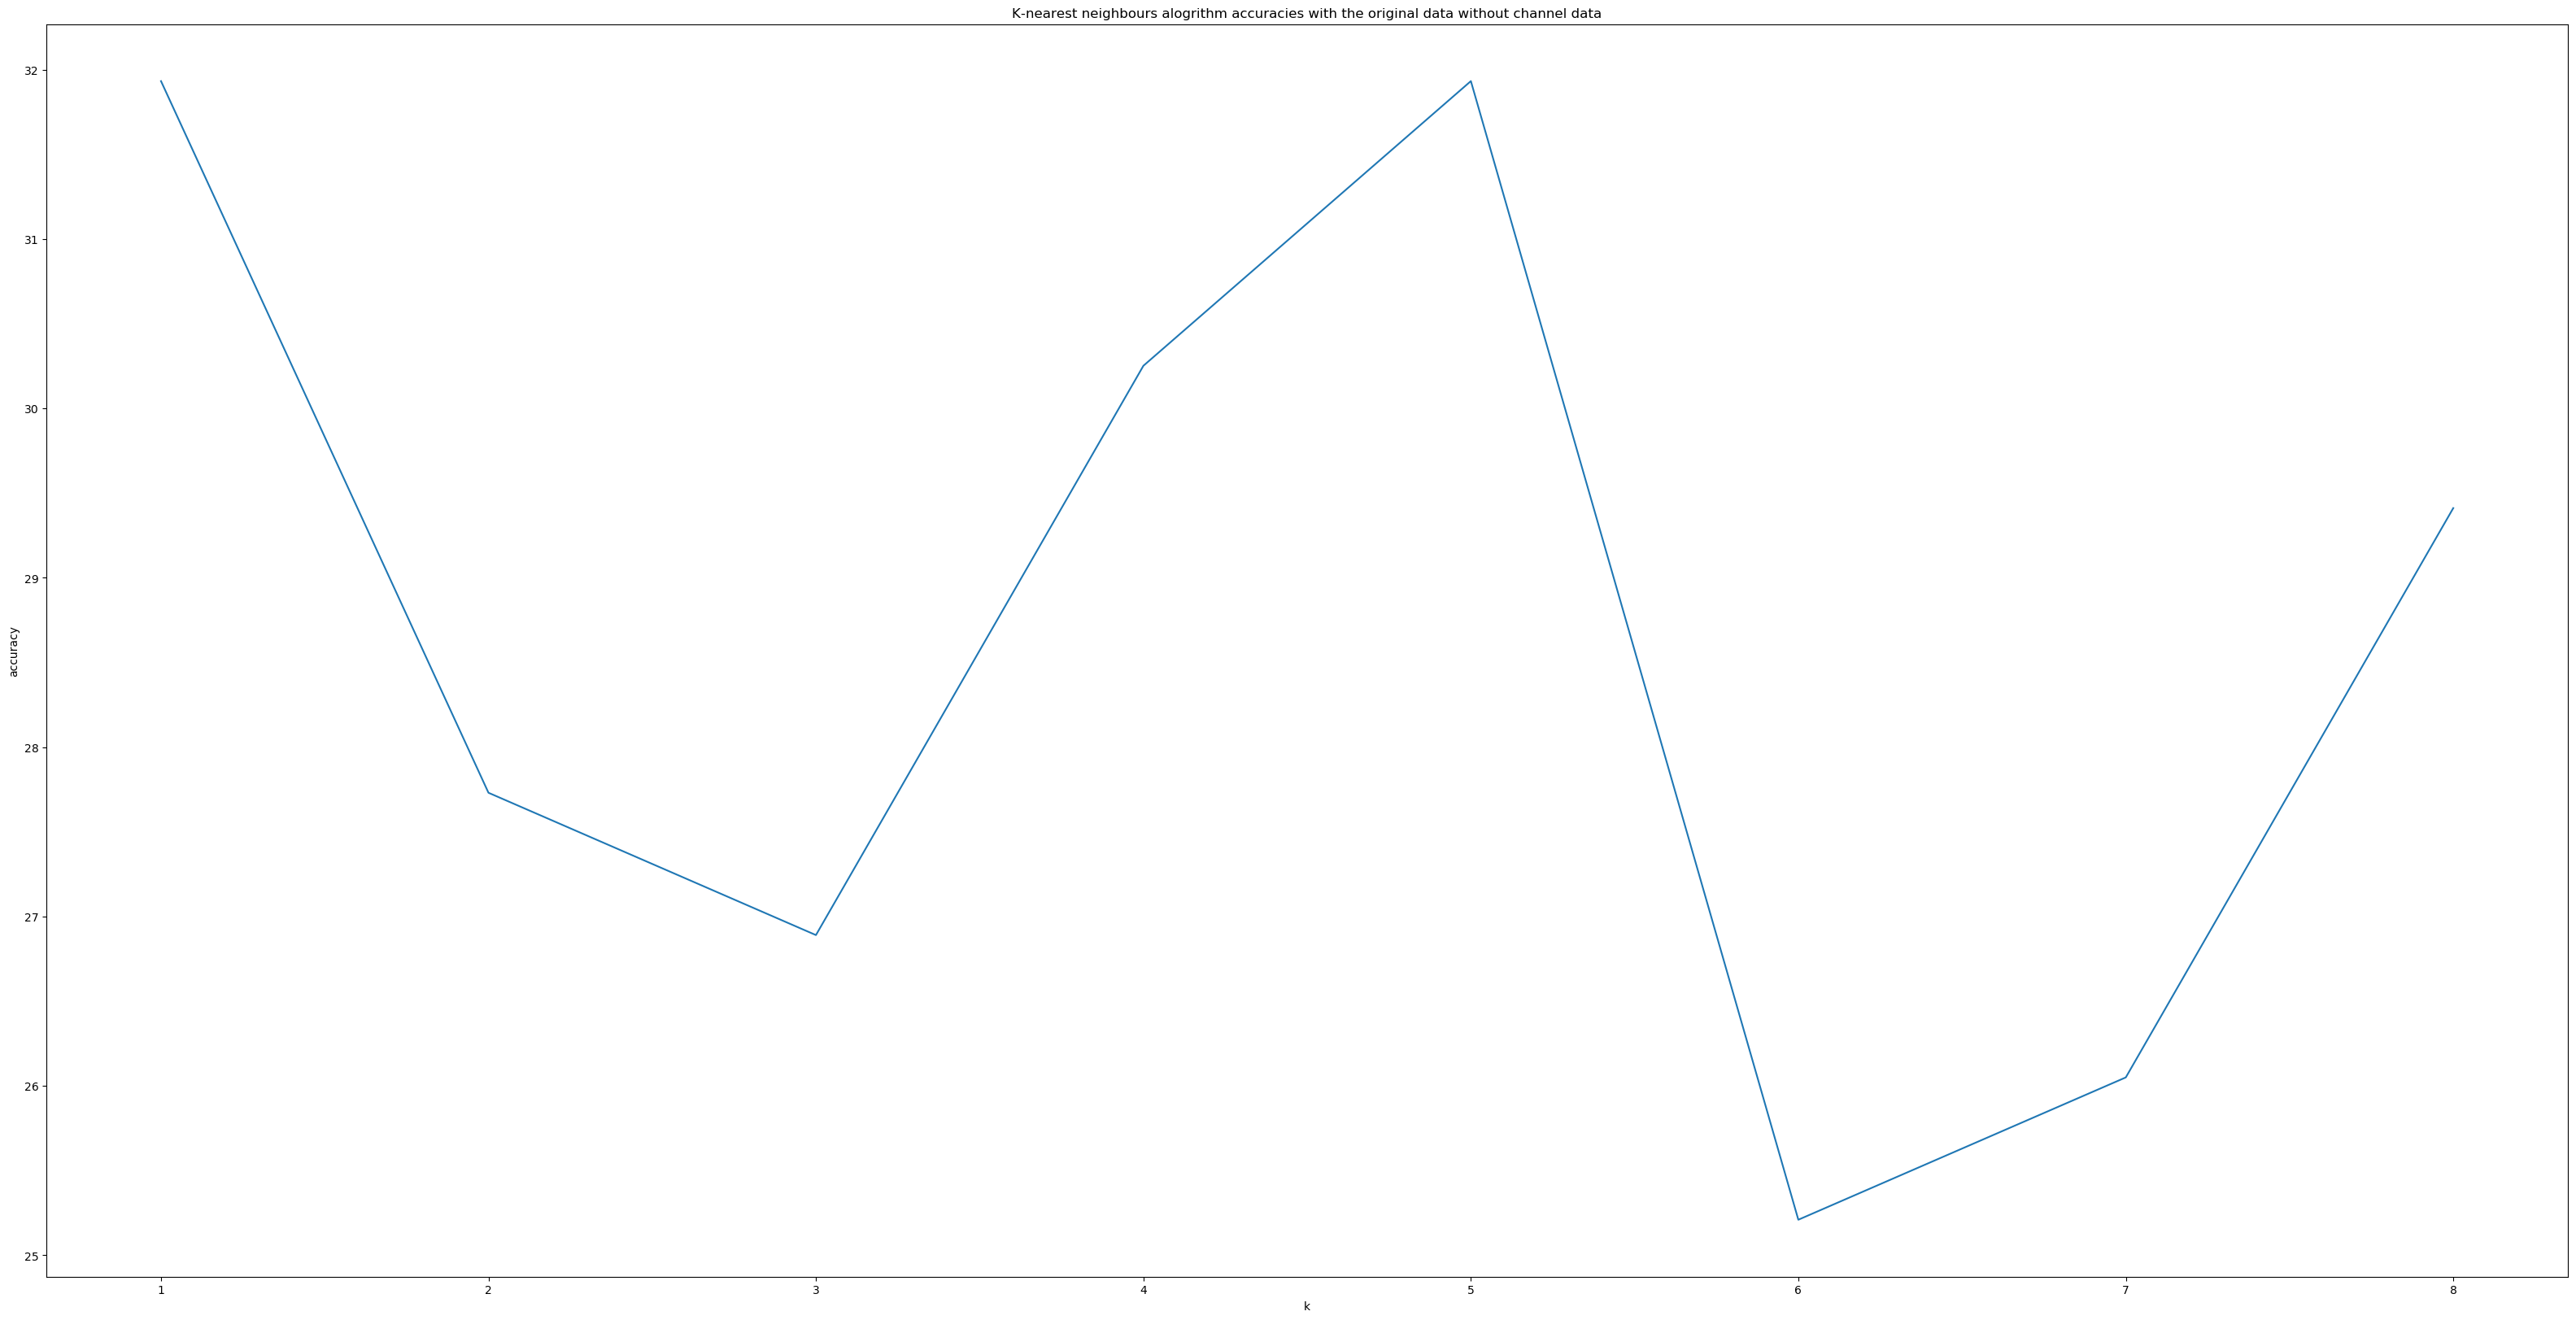

K-nearest neighbours algorithm accuracy: 31.932773109243694


31.932773109243694

In [32]:
no_channel_training_cols = ['beacon1', 'beacon2','beacon3','beacon4','beacon5','beacon6', 'beacon7', 'beacon8', 'beacon9', 'beacon10', 'beacon11', 'beacon12','beacon13','beacon14','beacon15','beacon16', 'beacon17', 'beacon18', 'beacon19', 'beacon20']
X_train_nc = X_train.loc[:, no_channel_training_cols]
X_validation_nc = X_validation.loc[:, no_channel_training_cols]
k_nearest_neighbours(X_train_nc, target_train, X_validation_nc, target_validation, "the original data without channel data")

##### Original Data with Channel Data

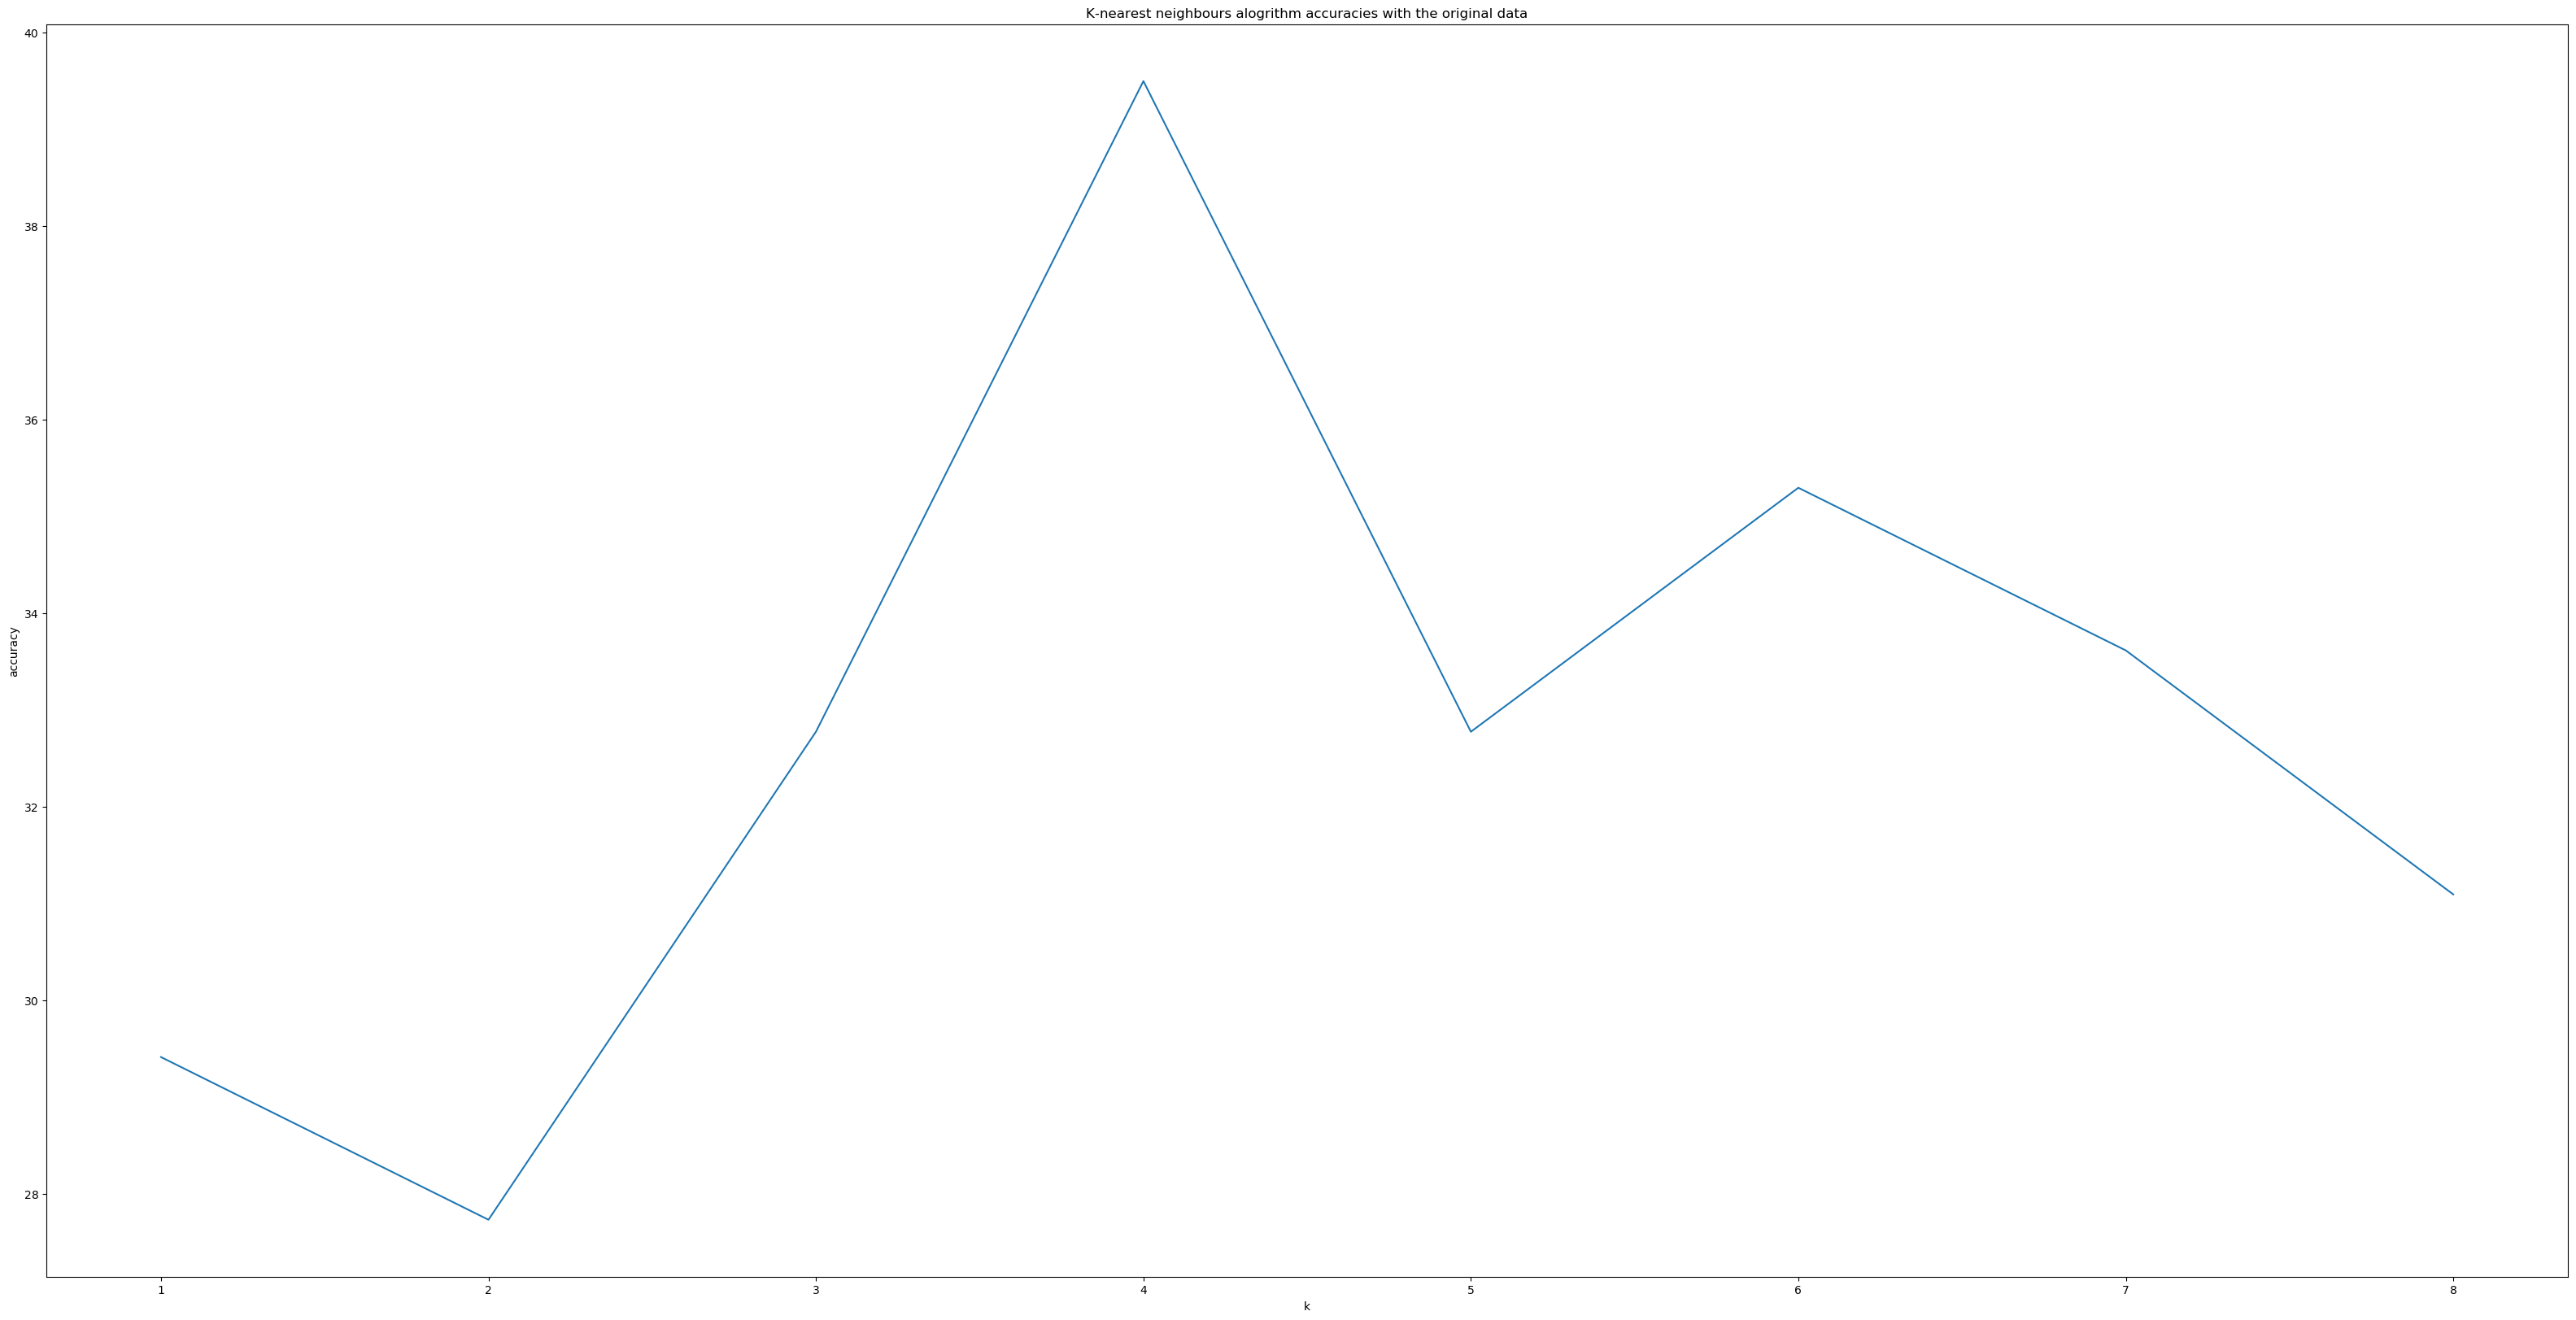

K-nearest neighbours algorithm accuracy: 39.49579831932773


In [33]:
accuracies = []
accuracies.append(k_nearest_neighbours(X_train, target_train, X_validation, target_validation, "the original data"))

#### K-NN with the Kalman Filter Preprocessing

In [34]:
def split_train_cols(dataframe):
    training_cols = [col for col in dataframe if col not in ['location']]
    train_set = dataframe.loc[:, training_cols]
    target_train = dataframe.loc[:, 'location']
    return train_set, target_train

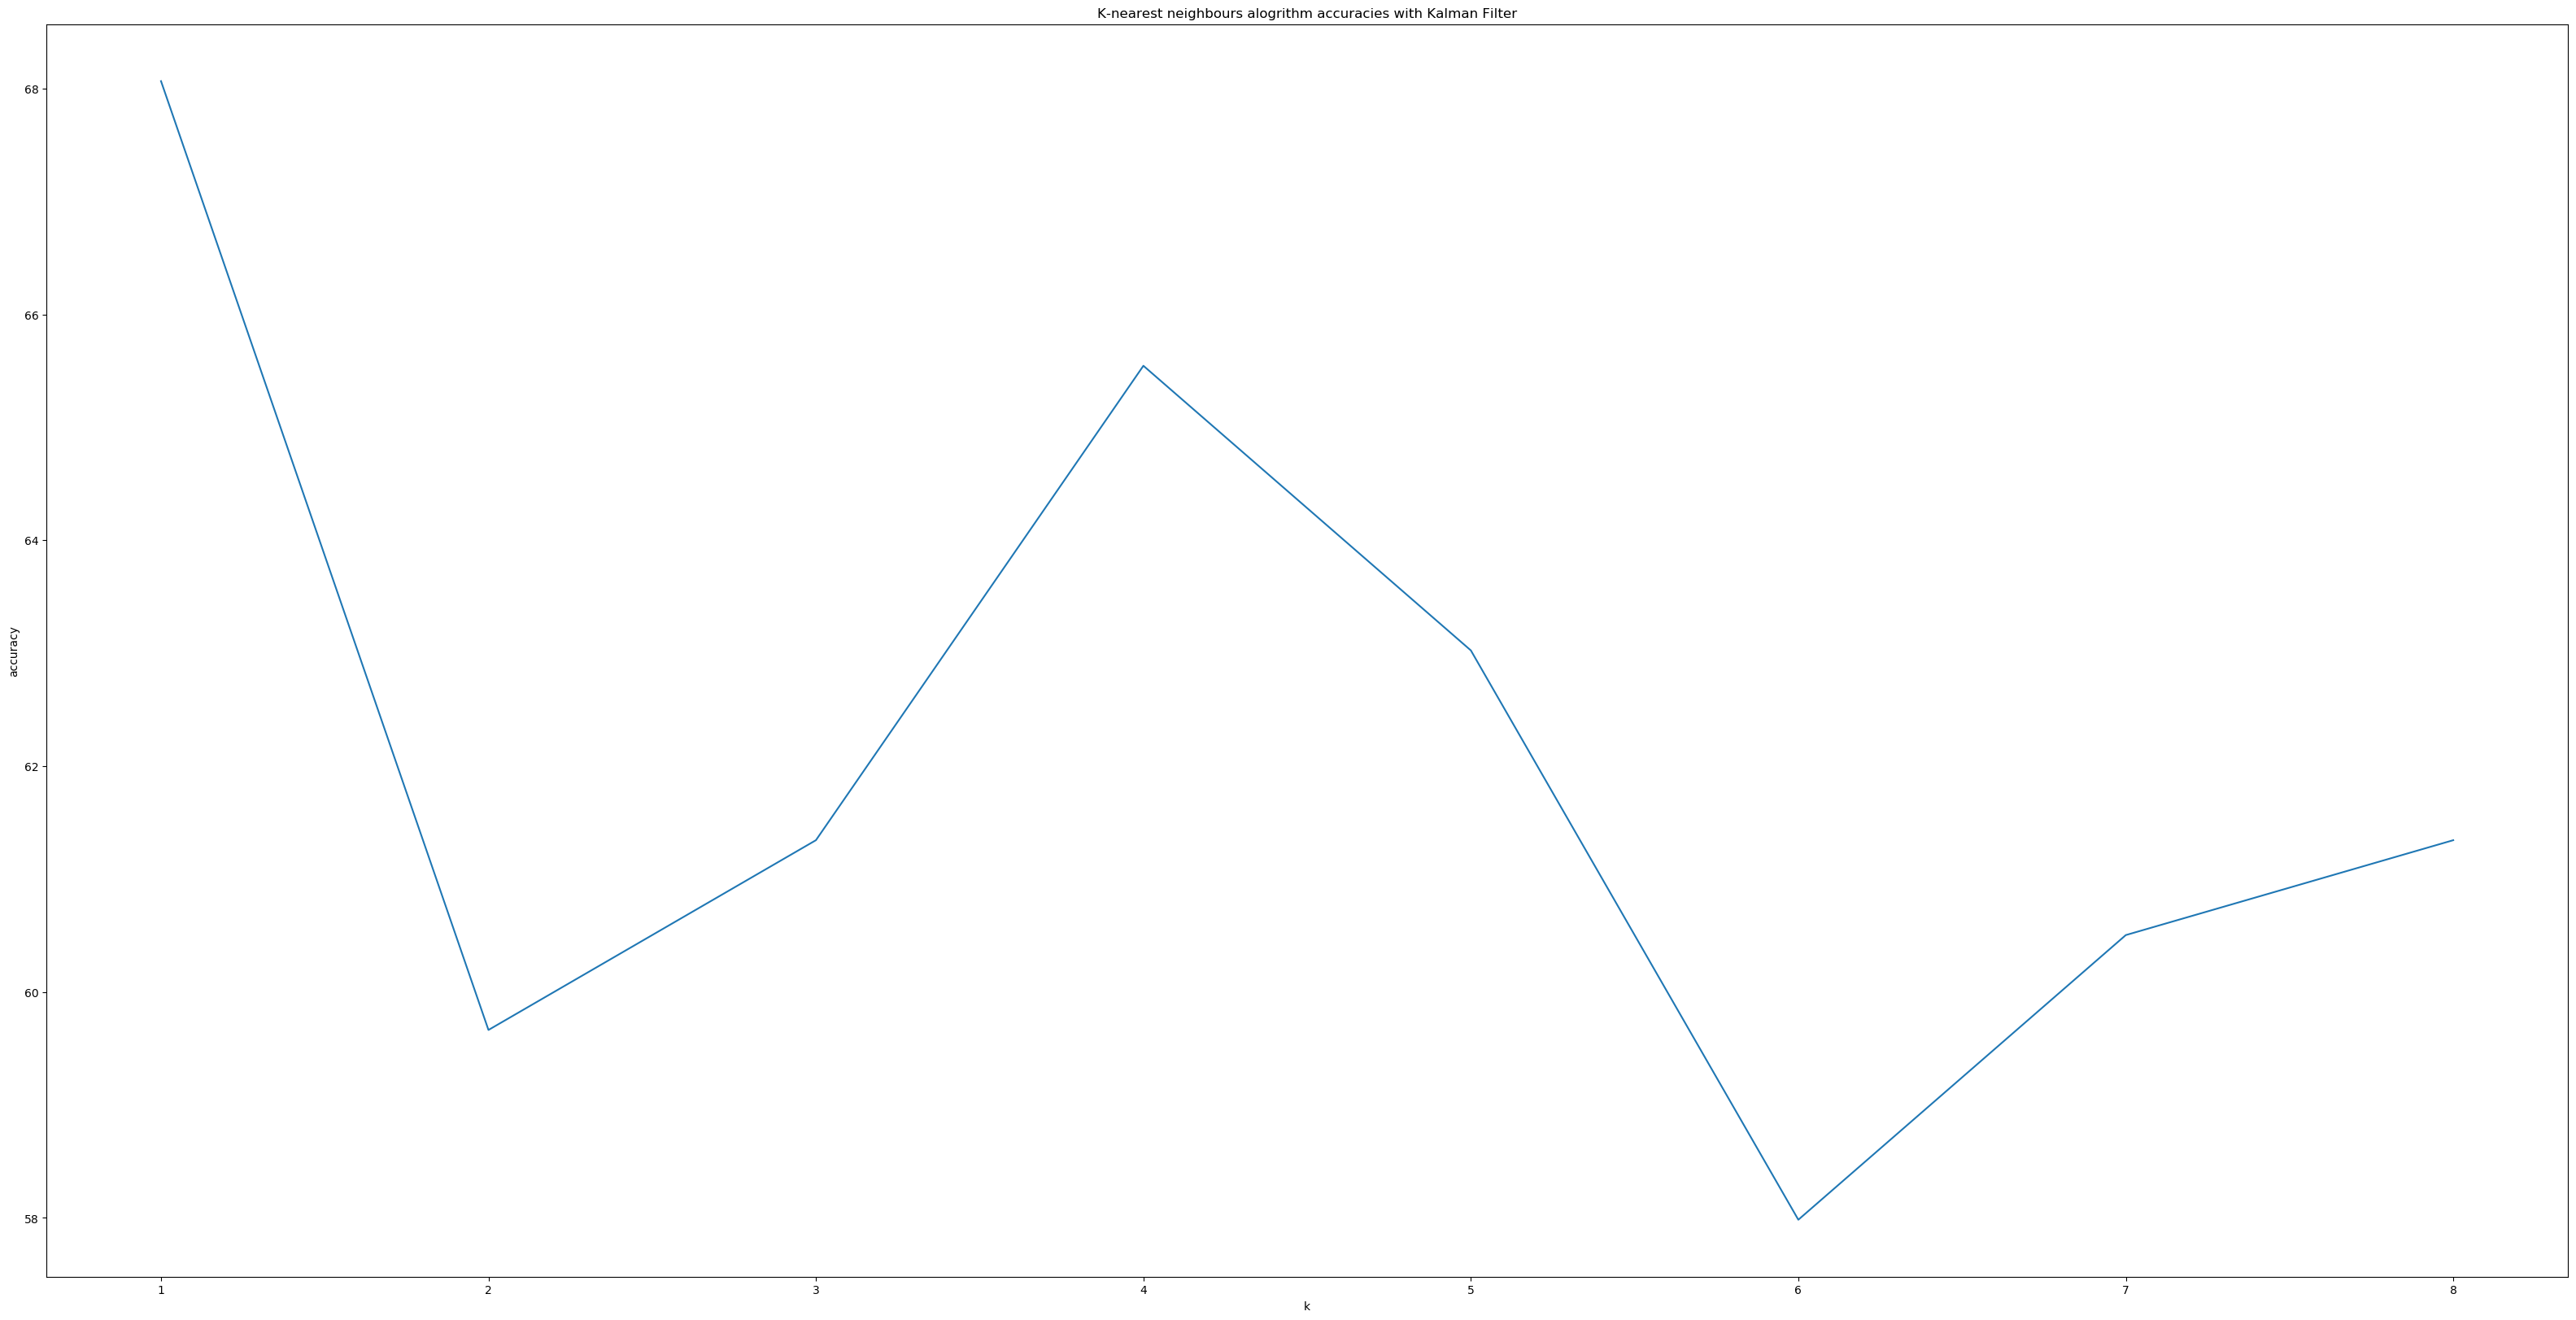

K-nearest neighbours algorithm accuracy: 68.0672268907563


In [35]:
accuracies.append(k_nearest_neighbours(kX_train, ktarget_train, kX_validation, ktarget_validation, "Kalman Filter"))

#### K-NN with the Alpha-Beta-Gamma Filter Preprocessing

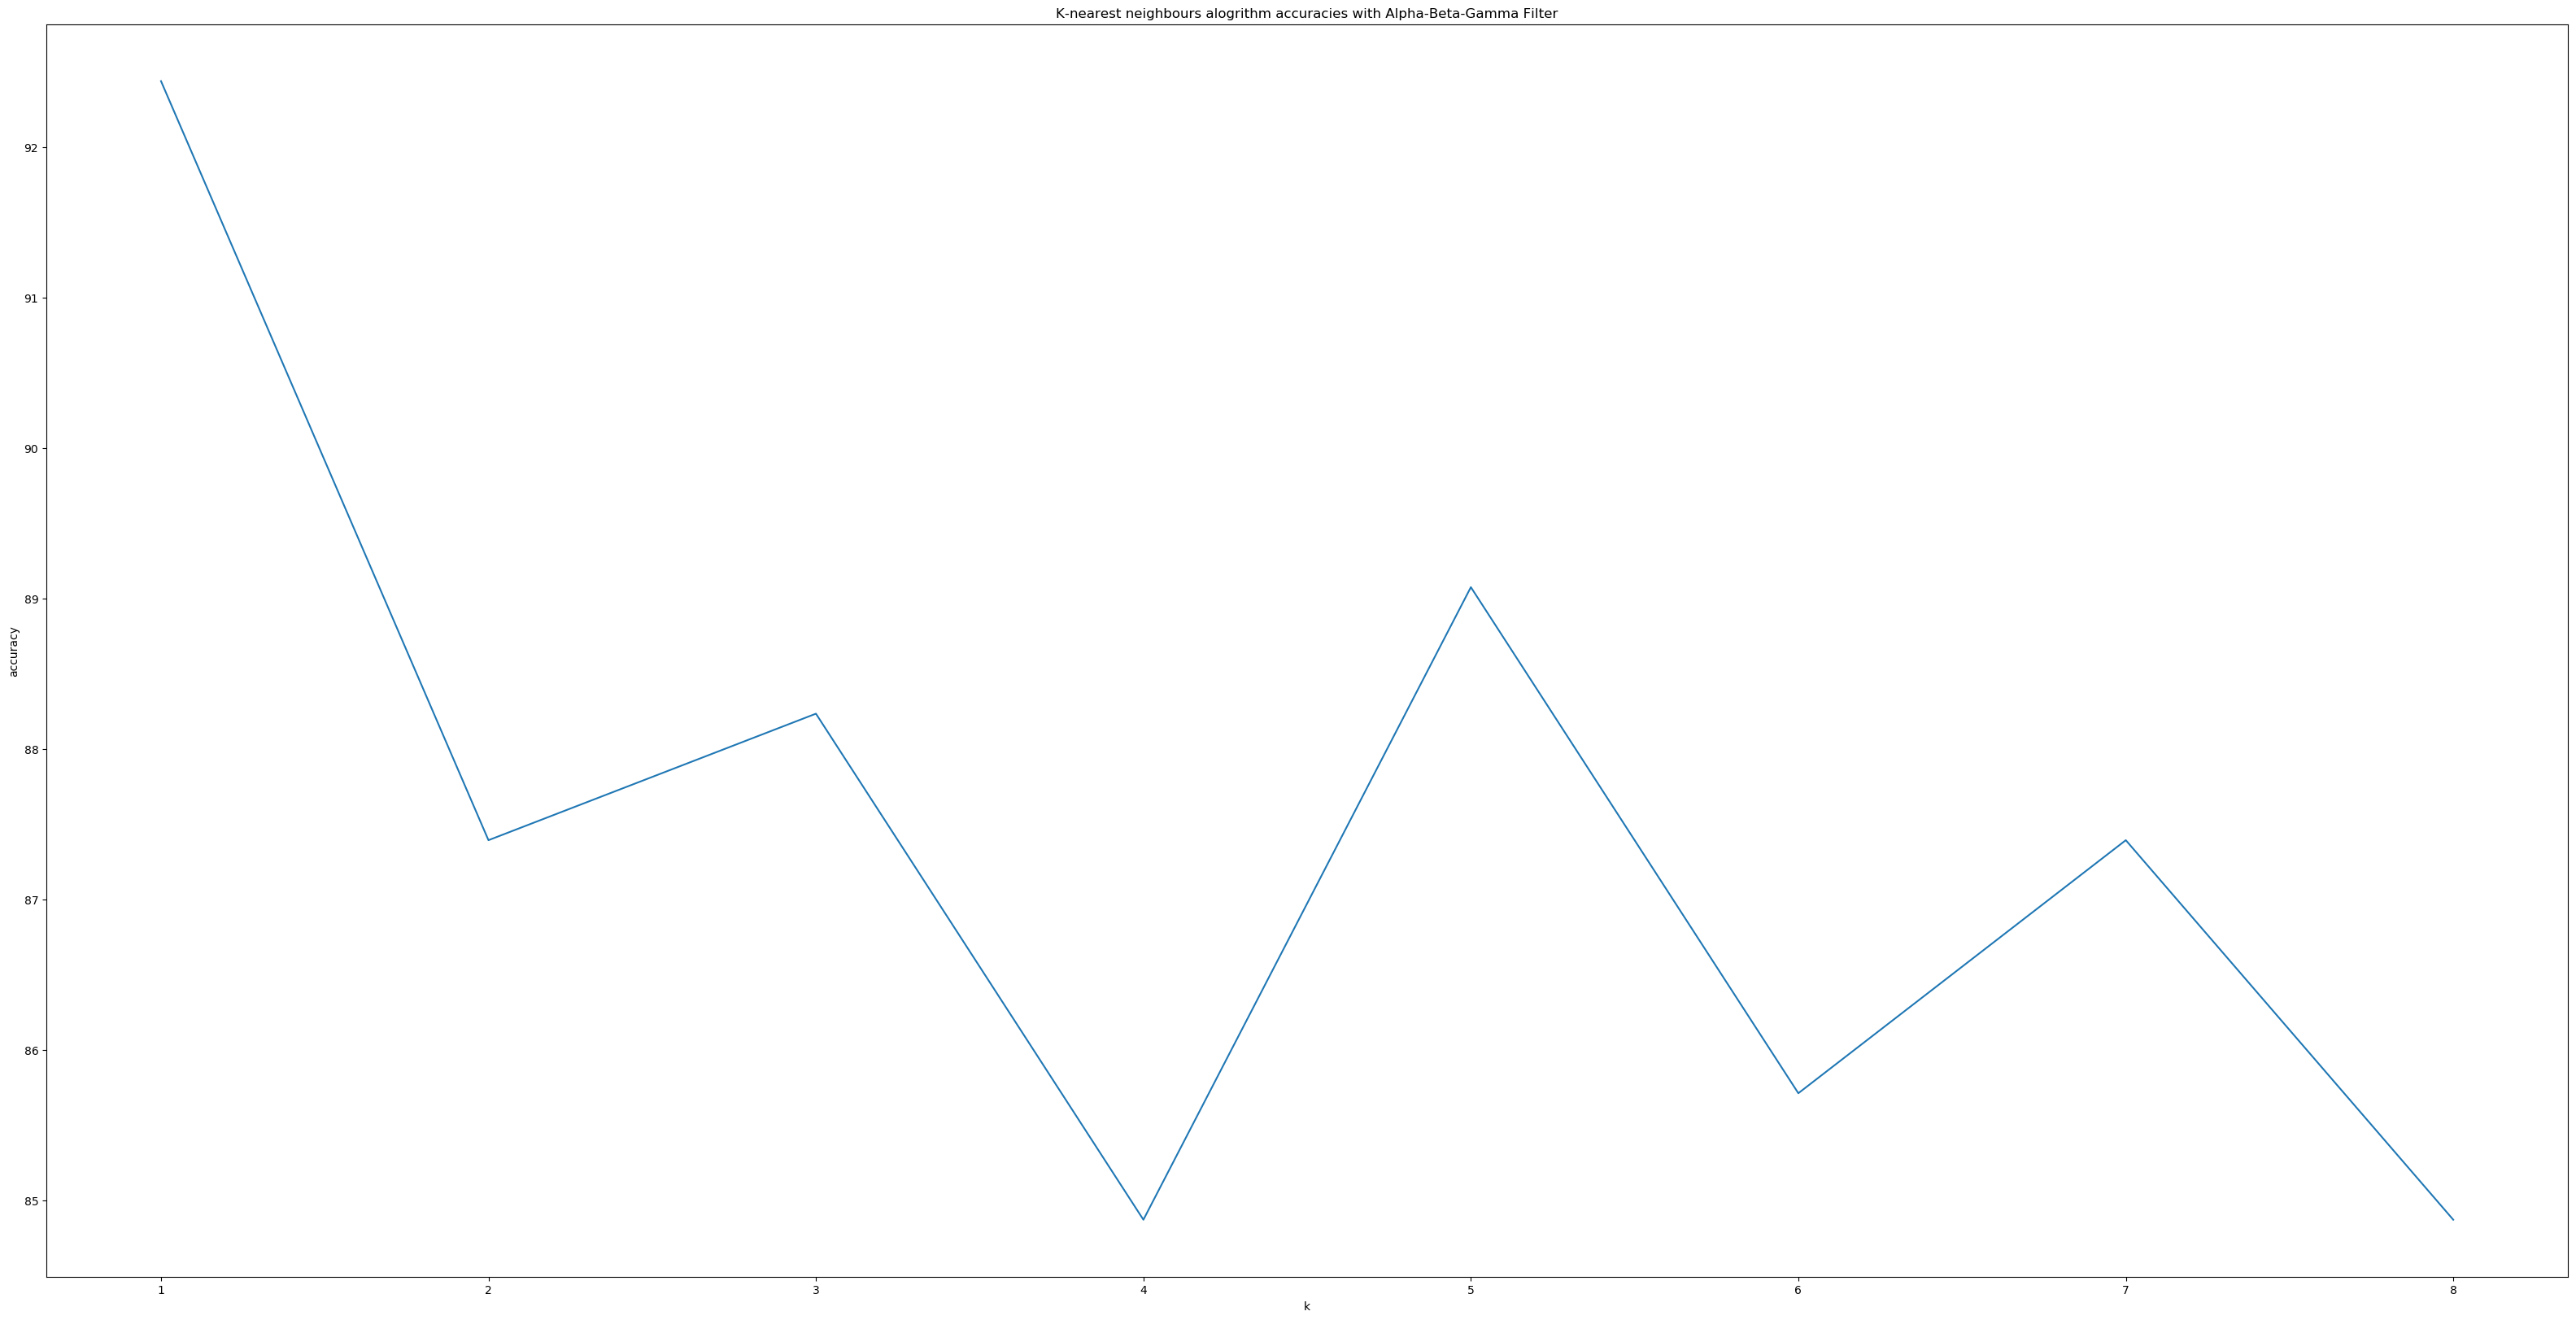

K-nearest neighbours algorithm accuracy: 92.43697478991596


In [36]:
accuracies.append(k_nearest_neighbours(aX_train, atarget_train, aX_validation, atarget_validation, "Alpha-Beta-Gamma Filter"))

#### K-NN with the Fast Fourier Transform Filter Preprocessing

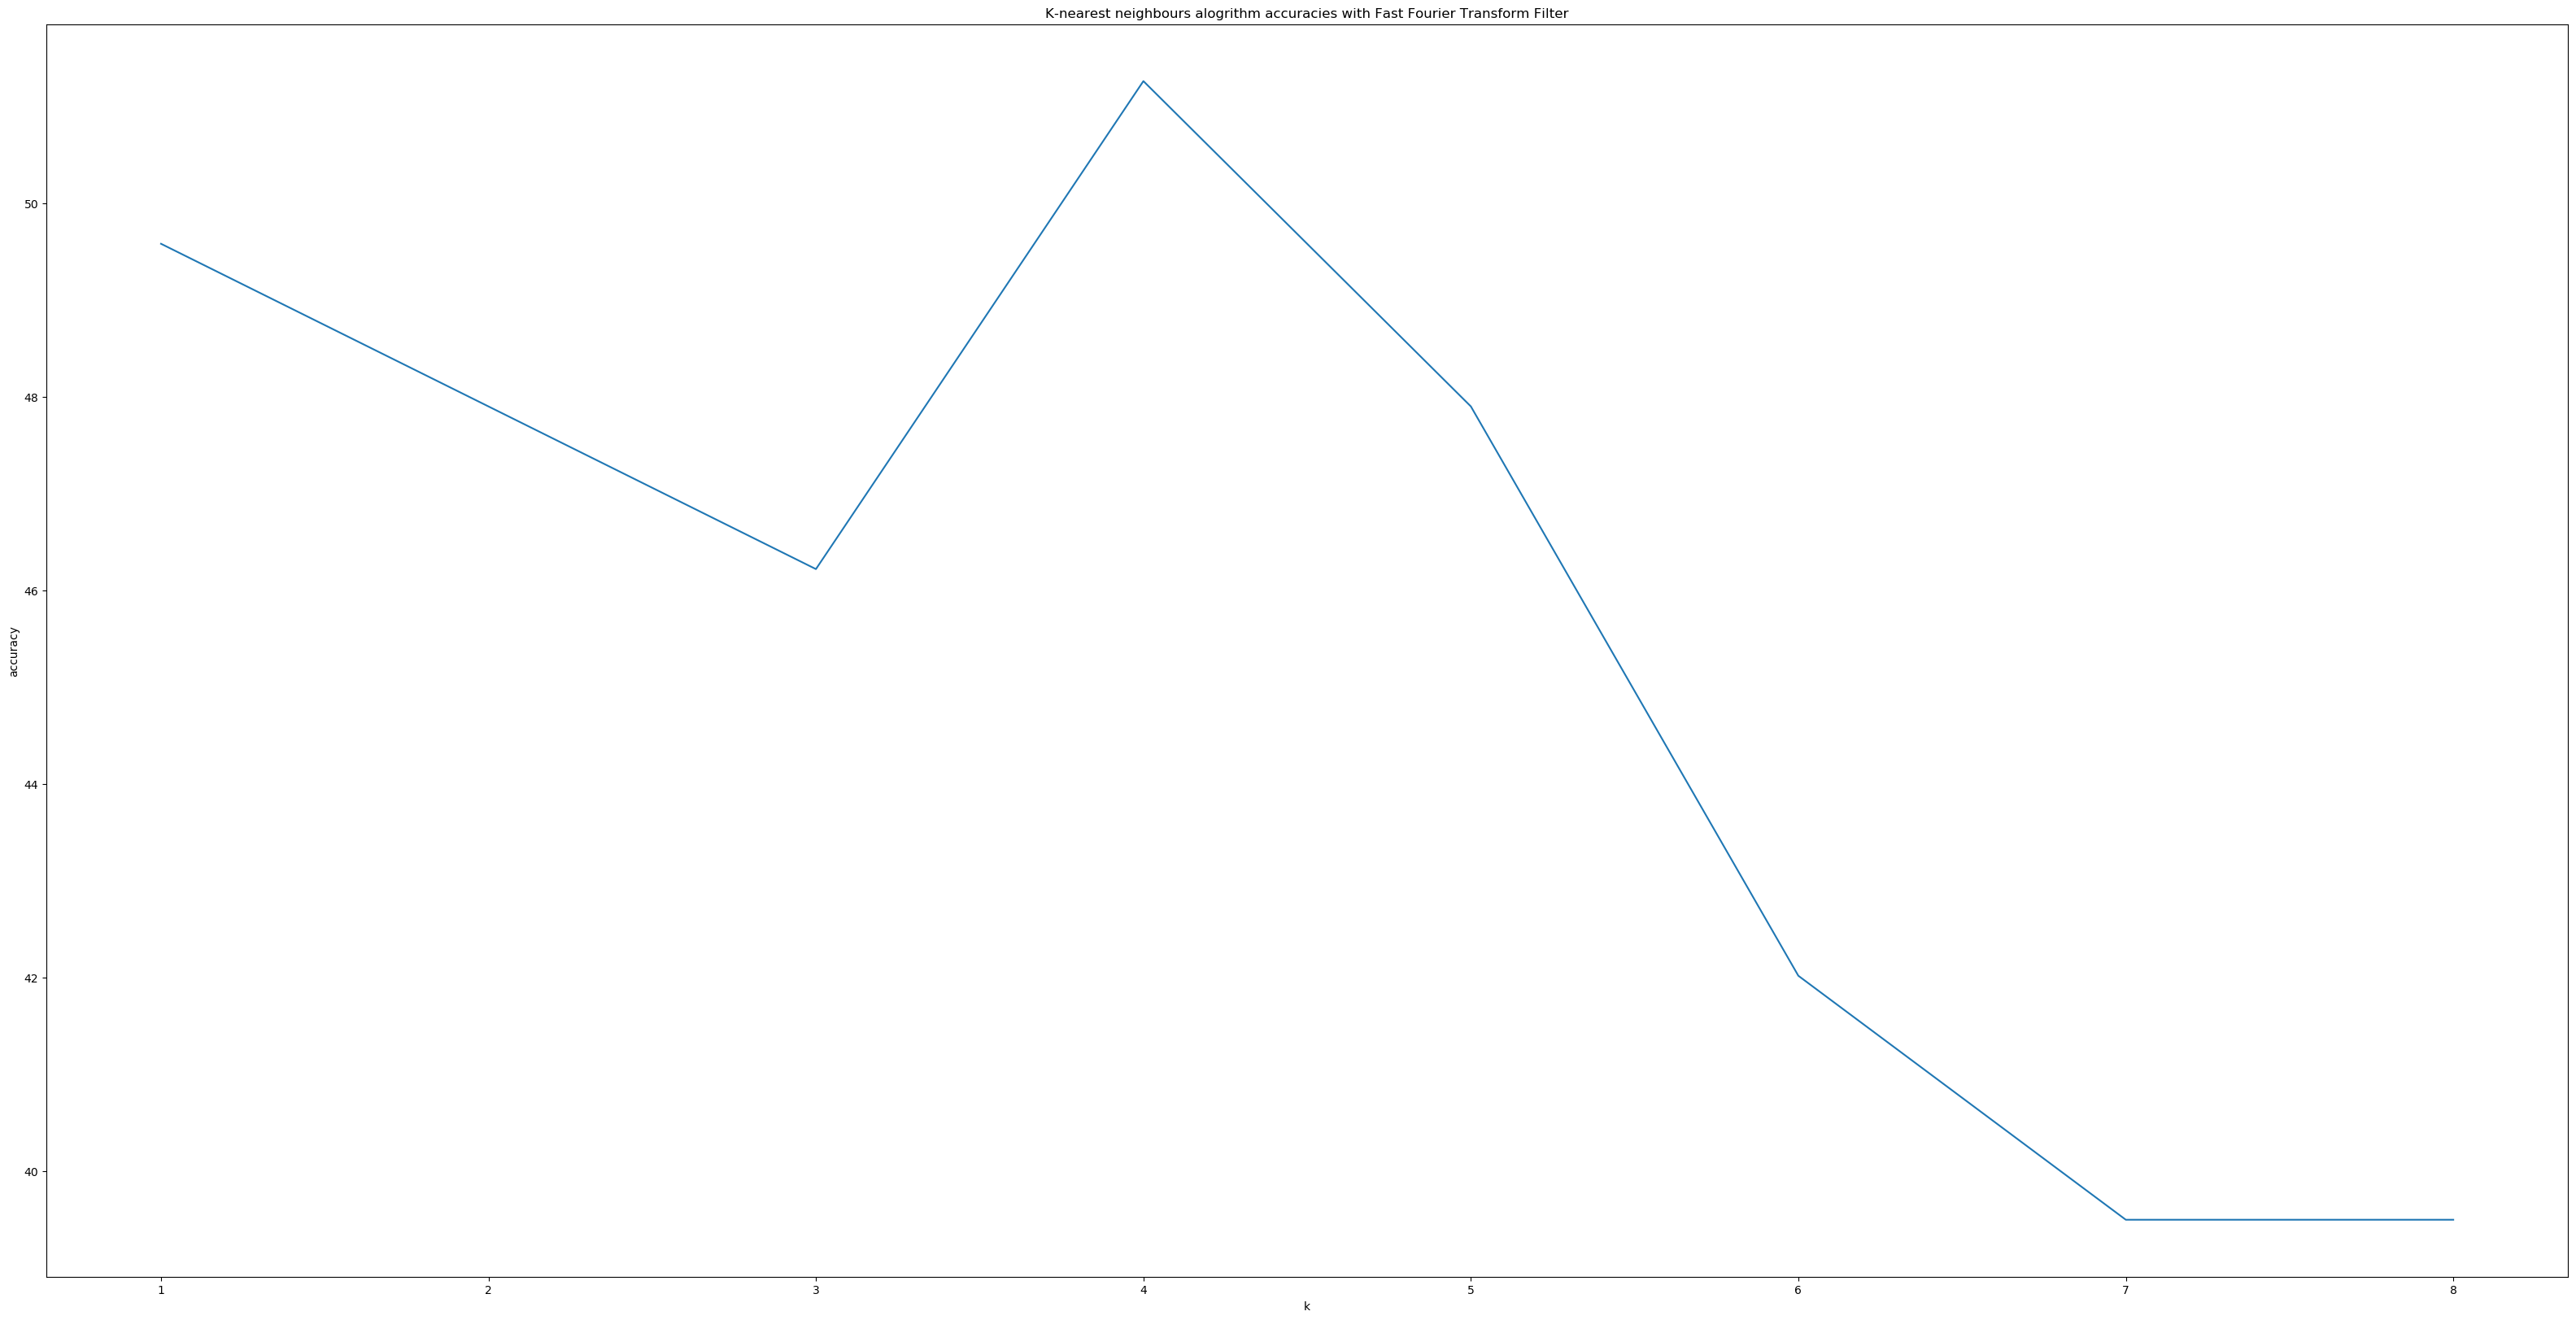

K-nearest neighbours algorithm accuracy: 51.26050420168067


In [37]:
accuracies.append(k_nearest_neighbours(fX_train, ftarget_train, fX_validation, ftarget_validation, "Fast Fourier Transform Filter"))

In [38]:
def filter_algorithm_accuracy_bardrawer(accuracies,title):
    filters = ('No filter','Kalman', 'Alpha-Beta-Gamma', 'Fast Fourier Transform')
    y_pos = np.arange(len(filters))
    print(accuracies)
    plt.bar(y_pos, accuracies,0.3, color="deeppink" ,align='center', alpha=1)
    plt.xticks(y_pos, filters)
    plt.xlabel('Filter Name')
    plt.ylabel('Accuracy')
#     plt.rcParams['figure.figsize'] = [10, 10]
    plt.title(title)

    plt.show()

#### Summary

[39.49579831932773, 68.0672268907563, 92.43697478991596, 51.26050420168067]


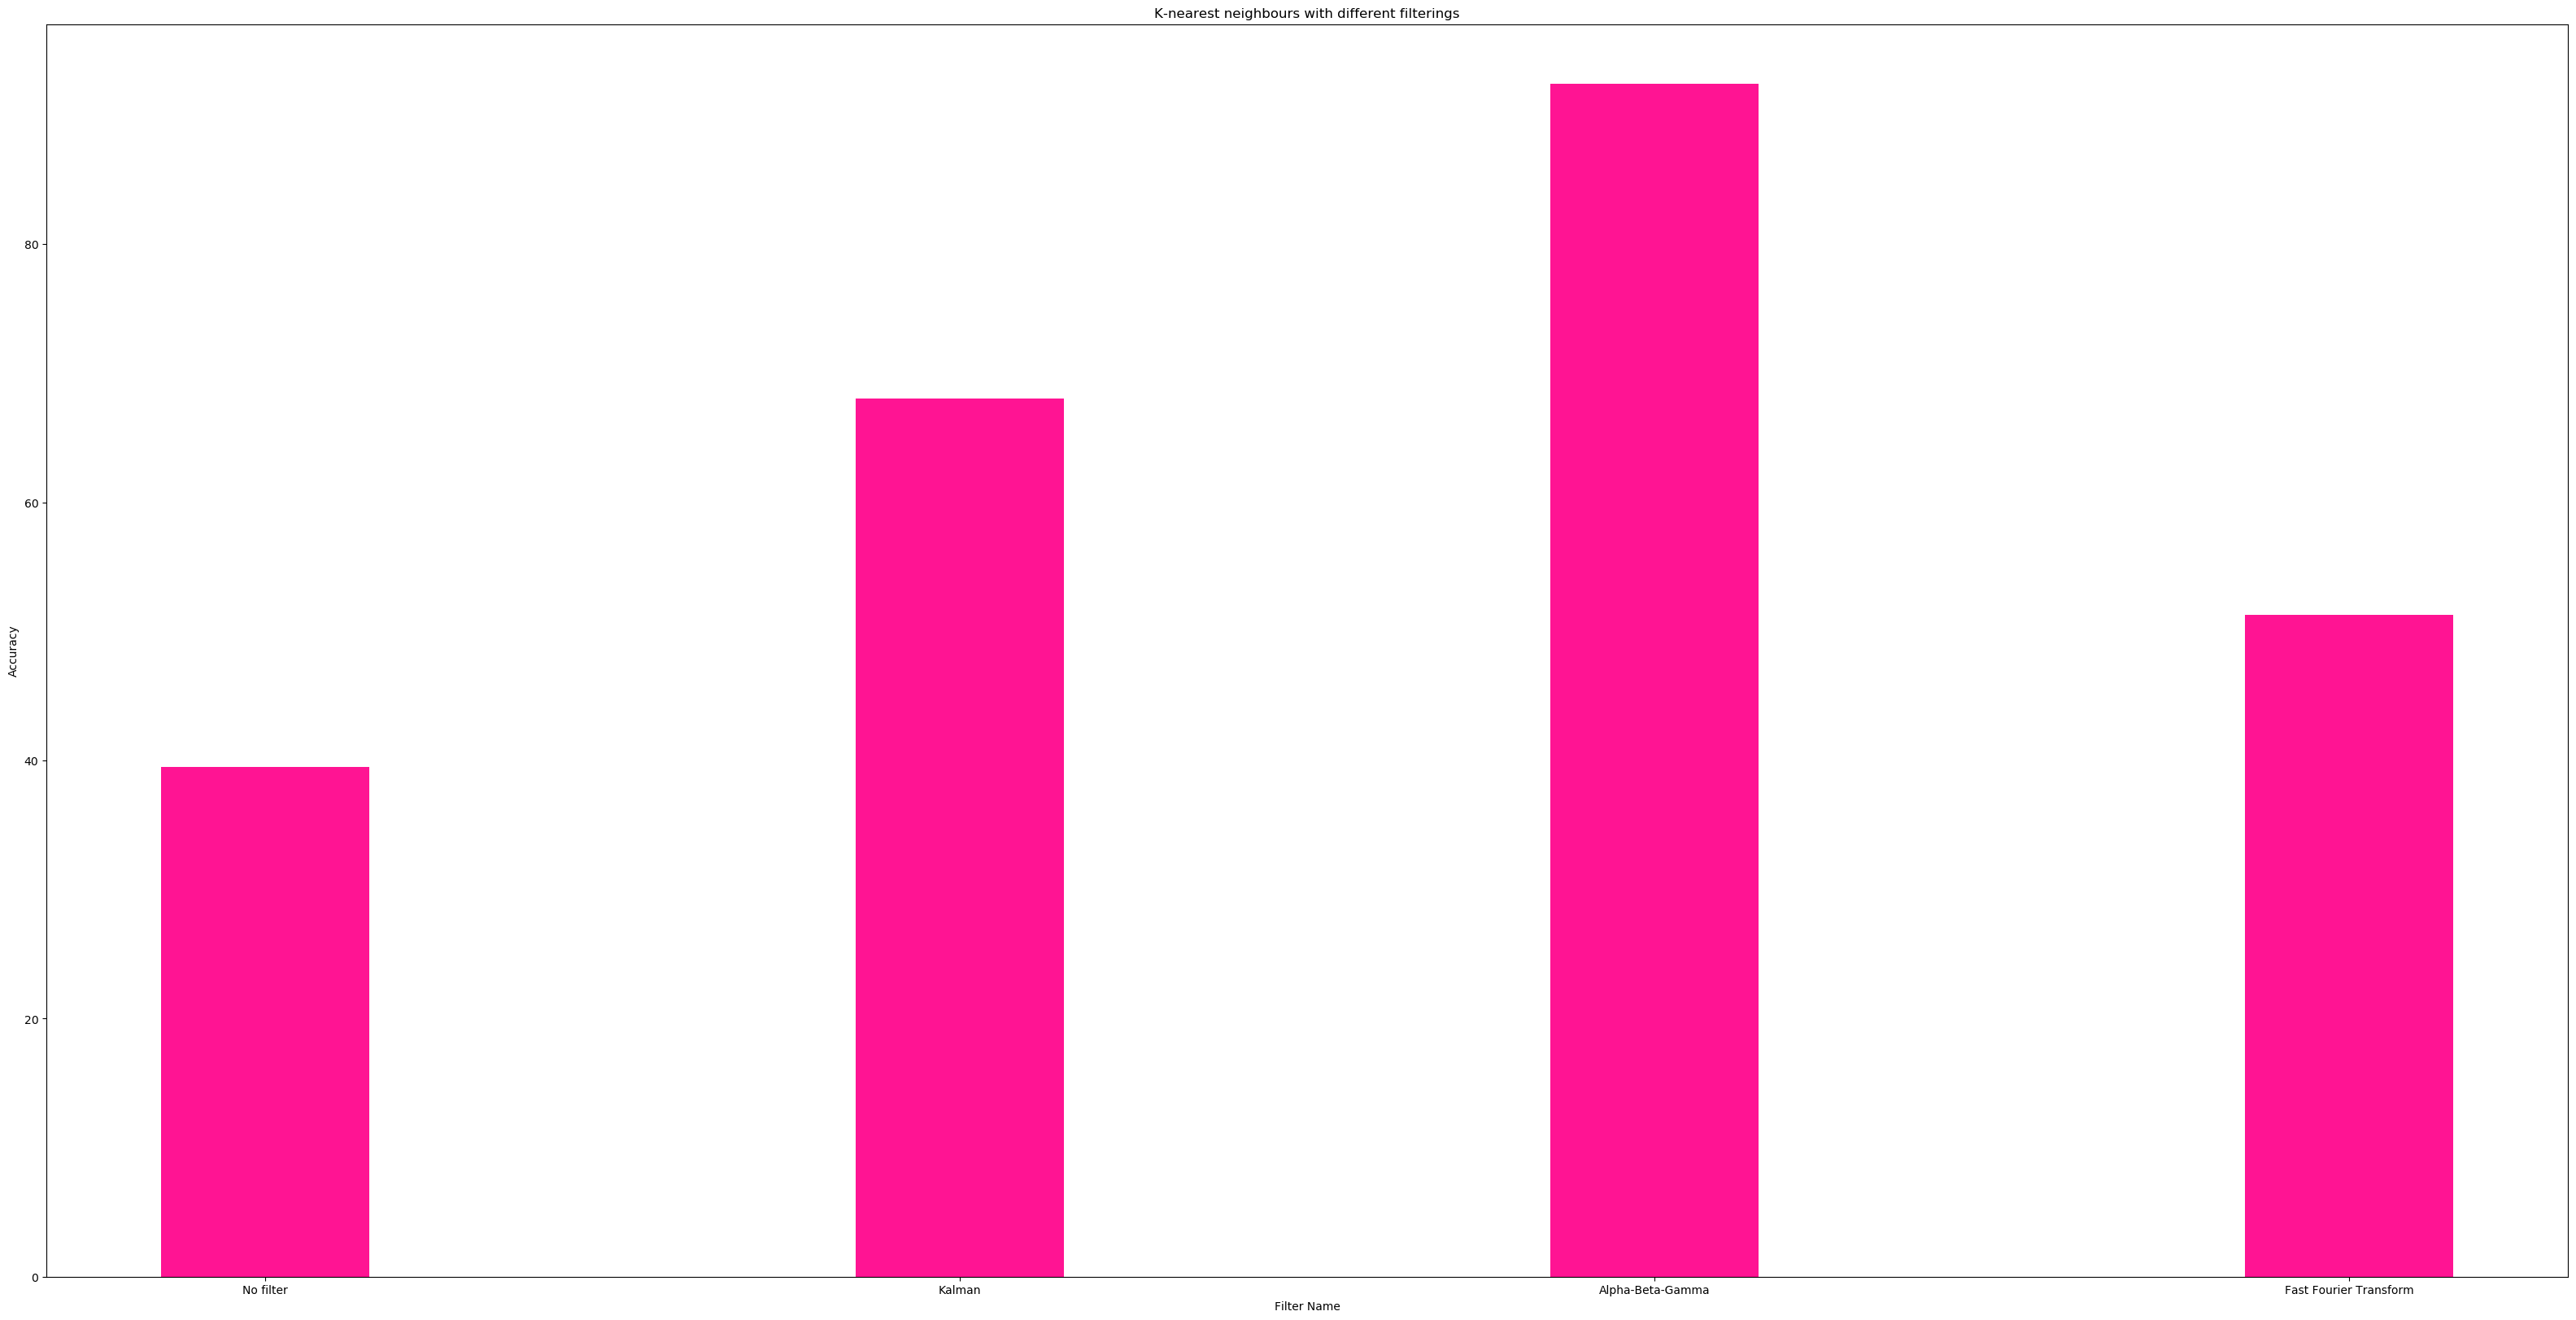

In [39]:
filter_algorithm_accuracy_bardrawer(accuracies, "K-nearest neighbours with different filterings")

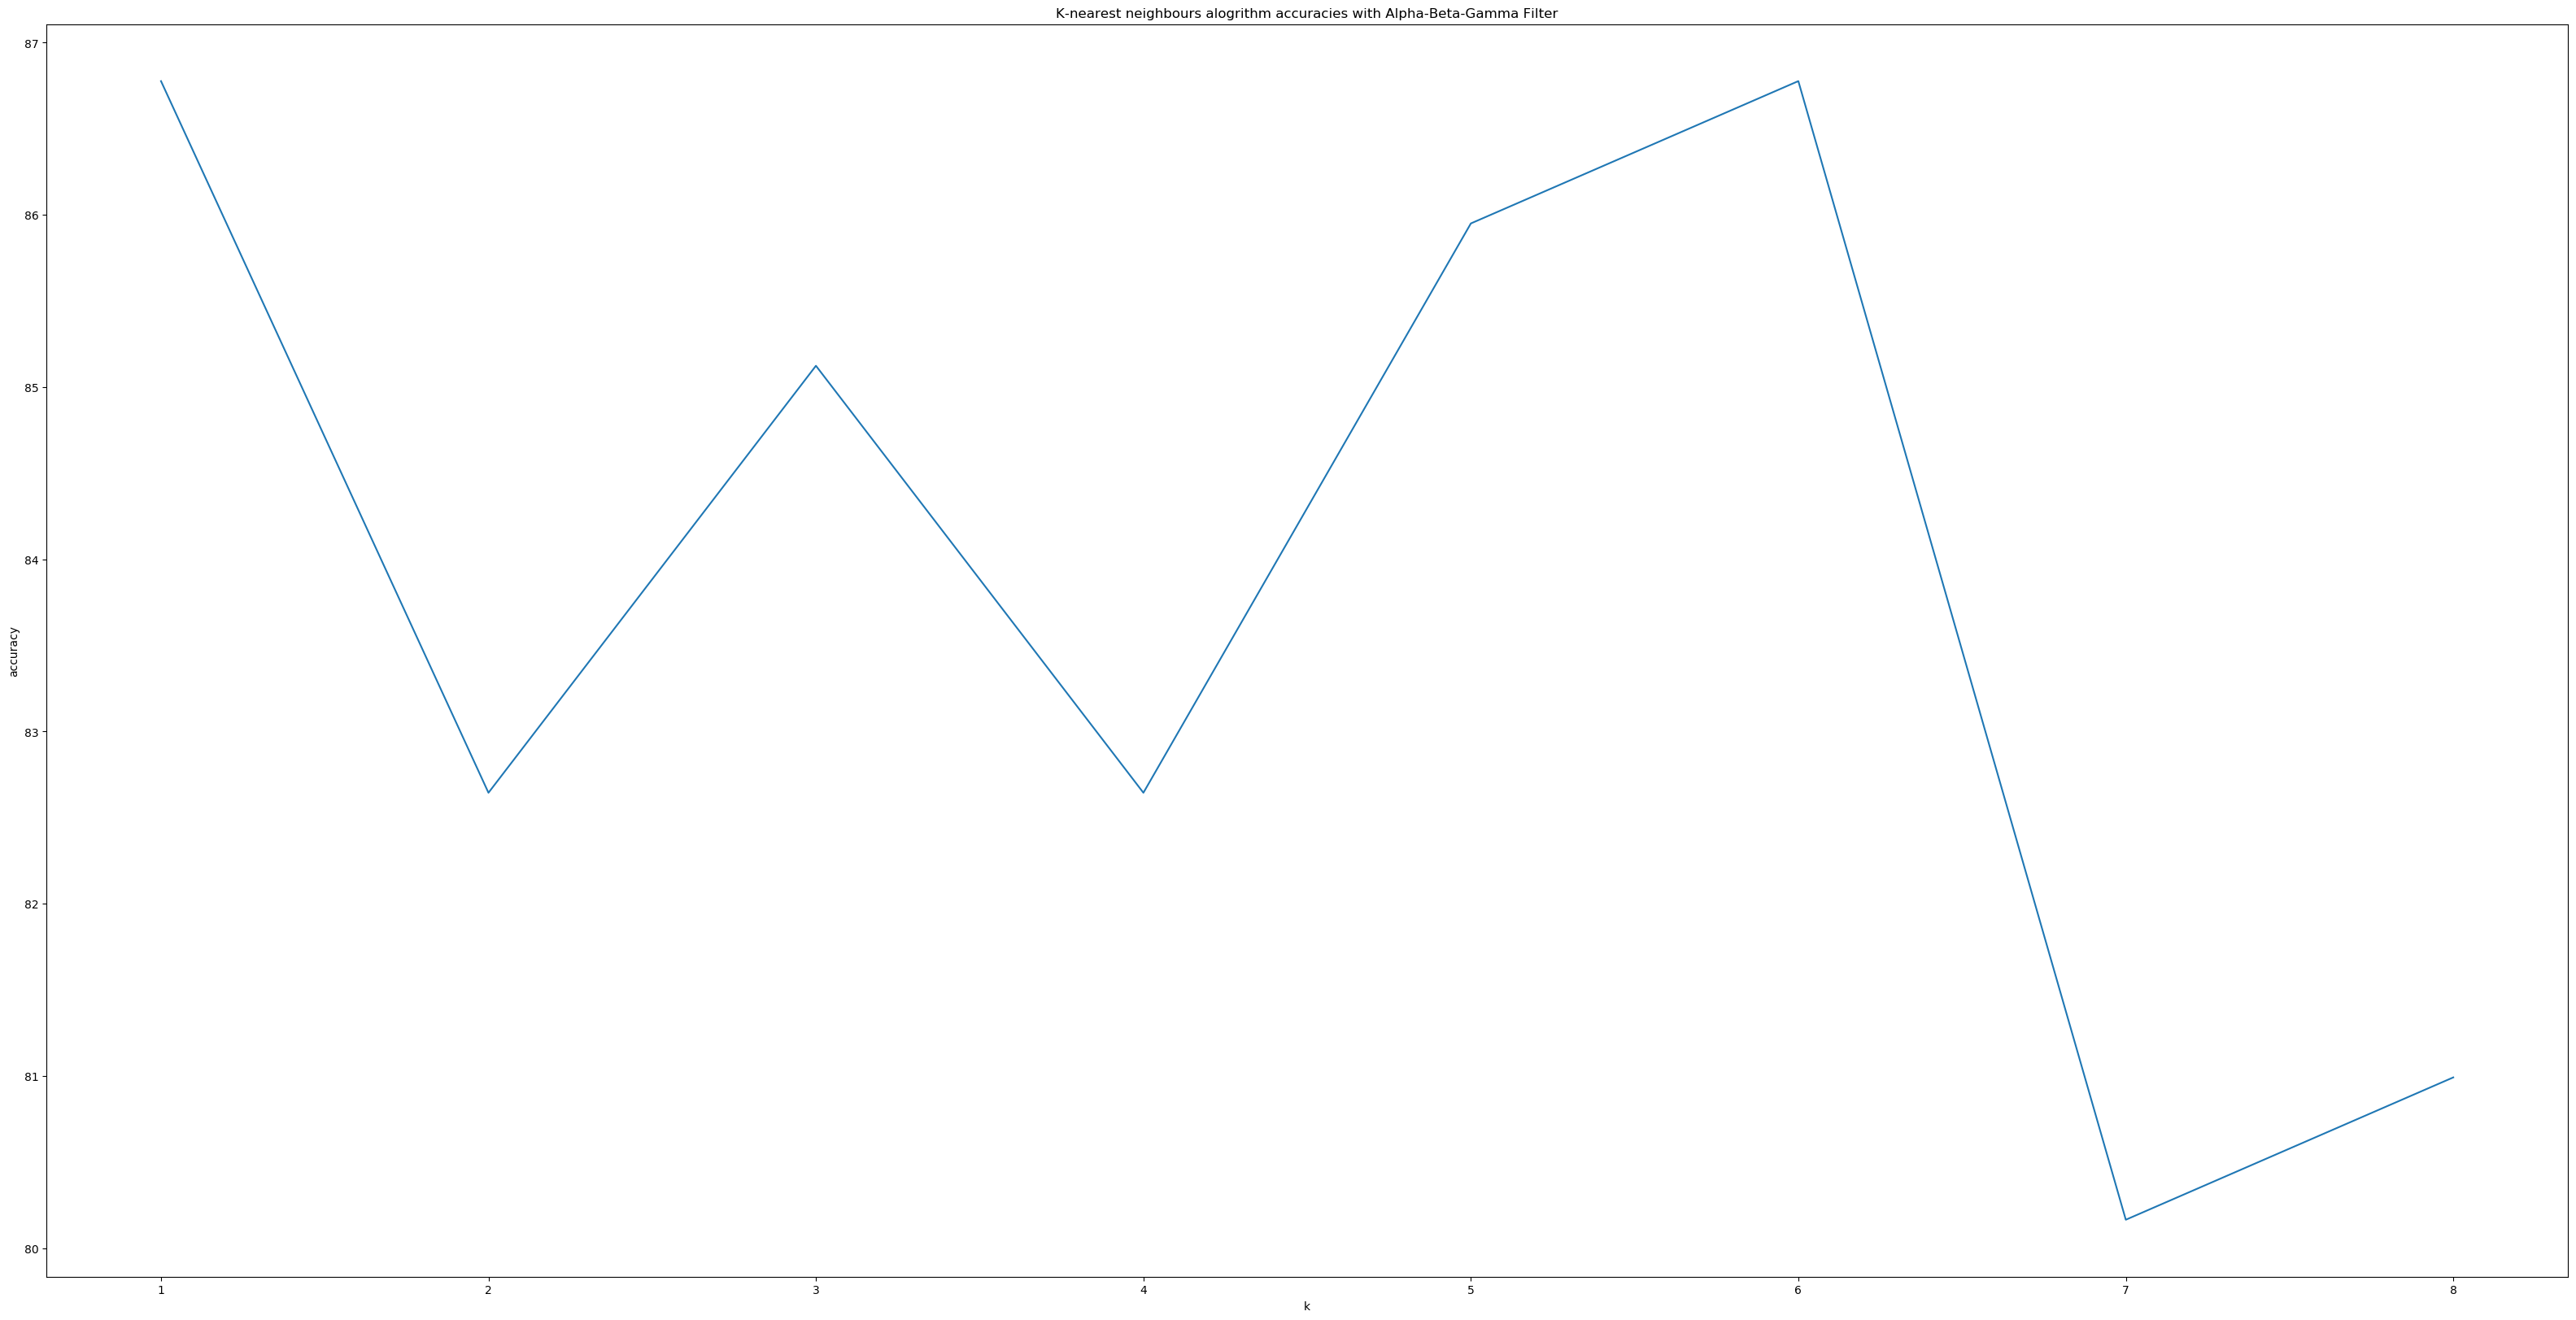

K-nearest neighbours algorithm accuracy: 86.77685950413223


86.77685950413223

In [40]:
k_nearest_neighbours(aX_train, atarget_train, aX_test, atarget_test, "Alpha-Beta-Gamma Filter")

In [41]:
prediction, run_time = run_knn(aX_train, atarget_train, aX_test, atarget_test, 1)
print(classification_report(atarget_test,prediction))
print("K nearest neighbours algorithm predication time: "+ str(run_time))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.75      1.00      0.86         3
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           7       0.00      0.00      0.00         1
           8       0.50      1.00      0.67         1
           9       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         0
          11       1.00      0.75      0.86         4
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       1.00      0.67      0.80         3
          16       0.00      0.00      0.00         0
          17       0.50      1.00      0.67         1
          19       1.00    

## Decision Tree

In [42]:
grid_dt_parameters = {'criterion': ["gini", "entropy", "log_loss"], 'splitter': ["best", "random"],'max_depth': [3, 5, 8, 10, 15,20]}
grid_dt = GridSearchCV(tree.DecisionTreeClassifier(),grid_dt_parameters,refit=True,verbose=2)
print(grid_dt.fit(aX_train, atarget_train))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .........criterion=gini, max_depth=3, splitter=best; total time=   0.0s
[CV] END .........criterion=gini, max_depth=3, splitter=best; total time=   0.0s
[CV] END .........criterion=gini, max_depth=3, splitter=best; total time=   0.1s
[CV] END .........criterion=gini, max_depth=3, splitter=best; total time=   0.0s
[CV] END .........criterion=gini, max_depth=3, splitter=best; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, splitter=random; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, splitter=random; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, splitter=random; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, splitter=random; total time=   0.0s
[CV] END .......criterion=gini, max_depth=3, splitter=random; total time=   0.0s
[CV] END .........criterion=gini, max_depth=5, splitter=best; total time=   0.0s
[CV] END .........criterion=gini, max_depth=5, 

[CV] END ...criterion=entropy, max_depth=15, splitter=random; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, splitter=random; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, splitter=random; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, splitter=random; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=20, splitter=best; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=20, splitter=best; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=20, splitter=best; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=20, splitter=best; total time=   0.0s
[CV] END .....criterion=entropy, max_depth=20, splitter=best; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=20, splitter=random; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=20, splitter=random; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=20, splitter=random; total time=   0.0s
[CV] END ...criterion=entrop

In [43]:
grid_dt.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [44]:
start_time = time.time()
grid_dt_predictions = grid_dt.predict(aX_test)
runtime = round(time.time() - start_time,4)
print("Decision tree algorithm prediction time: "+ str(runtime))
print(classification_report(atarget_test,grid_dt_predictions))

Decision tree algorithm prediction time: 0.0028
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.33      0.50         3
           2       0.80      1.00      0.89         4
           3       1.00      0.50      0.67         2
           4       0.67      1.00      0.80         2
           5       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          17       1.00      1.00      1.00         1
          19       1.00      1.00      1.00         1
          20       0.00      0.00

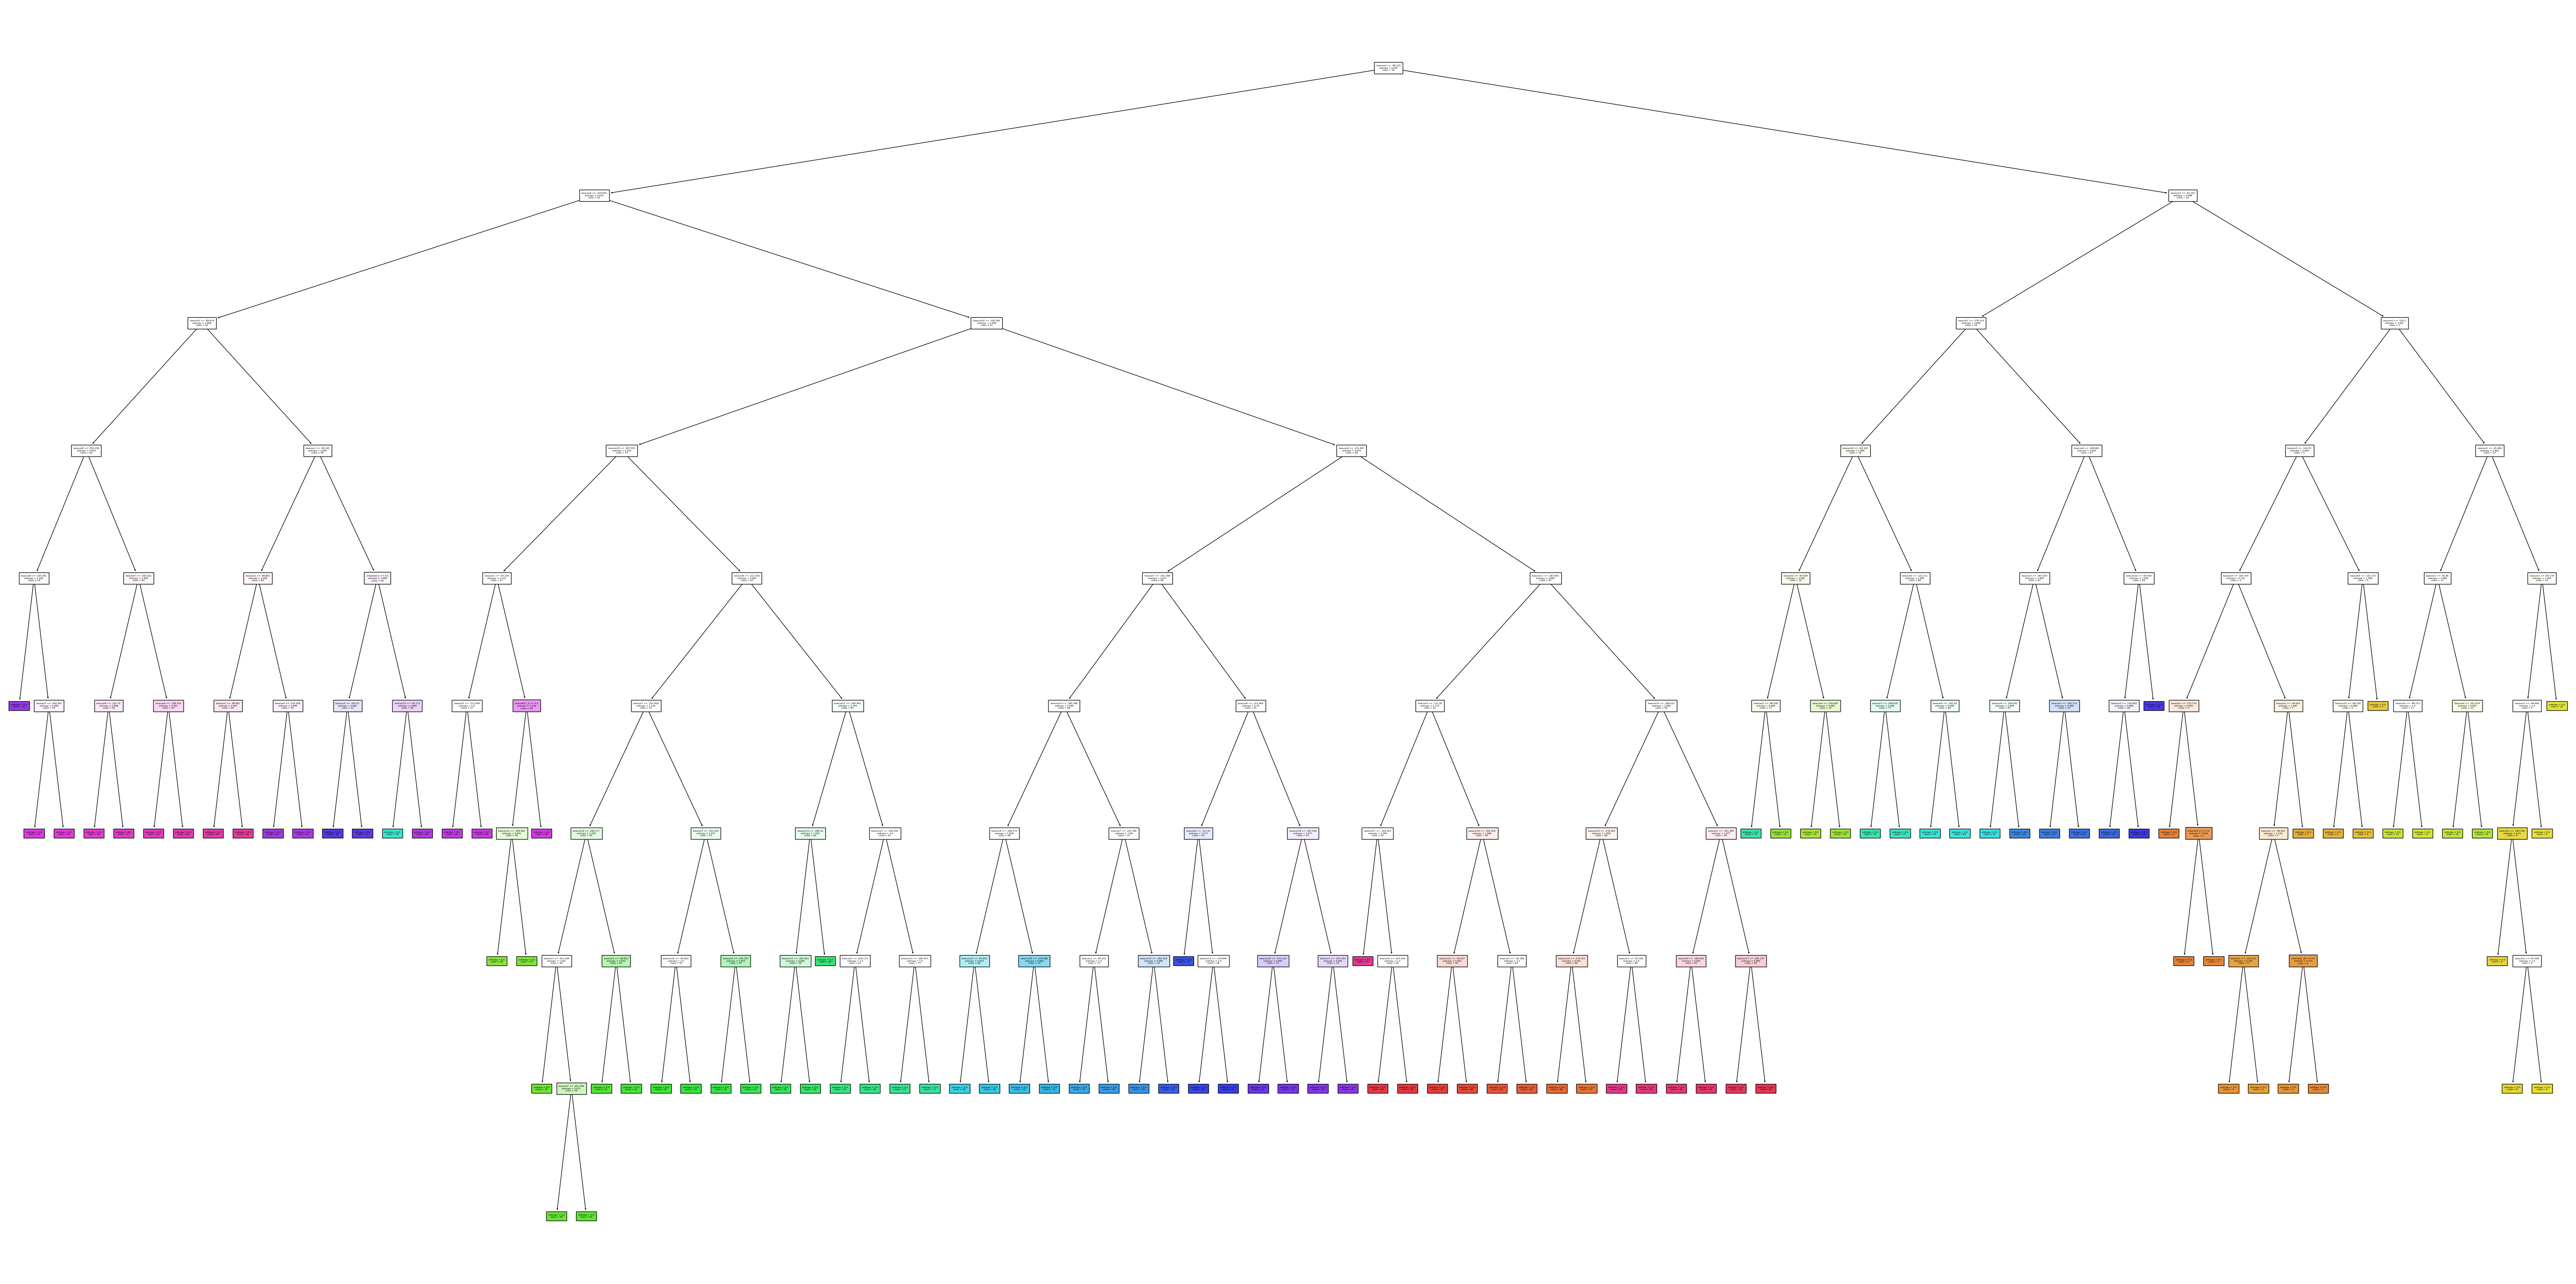

<Figure size 4000x2000 with 0 Axes>

In [45]:
fig, ax = plt.subplots(figsize=(80,40))
dfig = plt.figure()
tree.plot_tree(grid_dt.best_estimator_, 
                   feature_names=list(aX_test.columns),  
                   class_names= [str(i) for i in list(fingerprints_df.location.unique())],
                   filled=True, fontsize= 4, ax = ax)

def replace_text(obj):
    if type(obj) == mpl.text.Annotation:
        txt = obj.get_text()
        txt = re.sub("\nsamples[^$]*class","\nclass",txt)
        obj.set_text(txt)
    return obj
    
ax.properties()['children'] = [replace_text(i) for i in ax.properties()['children']]
fig.savefig('plot.png', dpi=300, bbox_inches='tight')
fig.show() 


## Random Forest

In [46]:
rfc = RandomForestClassifier()
forest_params = [{'criterion': ["gini", "entropy", "log_loss"], 'max_depth':[5,8,10,12,15], 'max_features': [10,15,20,25,30,35,40]}]
clf = GridSearchCV(rfc, forest_params, cv = 5, scoring='accuracy',refit=True,verbose=2)
print(clf.fit(aX_train, atarget_train))

Fitting 5 folds for each of 105 candidates, totalling 525 fits
[CV] END .......criterion=gini, max_depth=5, max_features=10; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=10; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=10; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=10; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=10; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=15; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=15; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=15; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=15; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=15; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=20; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, m

[CV] END ......criterion=gini, max_depth=10, max_features=40; total time=   0.6s
[CV] END ......criterion=gini, max_depth=10, max_features=40; total time=   0.5s
[CV] END ......criterion=gini, max_depth=10, max_features=40; total time=   0.5s
[CV] END ......criterion=gini, max_depth=10, max_features=40; total time=   0.5s
[CV] END ......criterion=gini, max_depth=12, max_features=10; total time=   0.3s
[CV] END ......criterion=gini, max_depth=12, max_features=10; total time=   0.3s
[CV] END ......criterion=gini, max_depth=12, max_features=10; total time=   0.3s
[CV] END ......criterion=gini, max_depth=12, max_features=10; total time=   0.3s
[CV] END ......criterion=gini, max_depth=12, max_features=10; total time=   0.3s
[CV] END ......criterion=gini, max_depth=12, max_features=15; total time=   0.3s
[CV] END ......criterion=gini, max_depth=12, max_features=15; total time=   0.3s
[CV] END ......criterion=gini, max_depth=12, max_features=15; total time=   0.3s
[CV] END ......criterion=gin

[CV] END ....criterion=entropy, max_depth=5, max_features=35; total time=   0.6s
[CV] END ....criterion=entropy, max_depth=5, max_features=35; total time=   0.7s
[CV] END ....criterion=entropy, max_depth=5, max_features=40; total time=   0.7s
[CV] END ....criterion=entropy, max_depth=5, max_features=40; total time=   0.7s
[CV] END ....criterion=entropy, max_depth=5, max_features=40; total time=   0.7s
[CV] END ....criterion=entropy, max_depth=5, max_features=40; total time=   0.7s
[CV] END ....criterion=entropy, max_depth=5, max_features=40; total time=   0.7s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.4s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.4s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.4s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.4s
[CV] END ....criterion=entropy, max_depth=8, max_features=10; total time=   0.4s
[CV] END ....criterion=entro

[CV] END ...criterion=entropy, max_depth=12, max_features=35; total time=   0.9s
[CV] END ...criterion=entropy, max_depth=12, max_features=35; total time=   0.9s
[CV] END ...criterion=entropy, max_depth=12, max_features=35; total time=   1.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=35; total time=   1.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=35; total time=   0.9s
[CV] END ...criterion=entropy, max_depth=12, max_features=40; total time=   0.9s
[CV] END ...criterion=entropy, max_depth=12, max_features=40; total time=   0.9s
[CV] END ...criterion=entropy, max_depth=12, max_features=40; total time=   0.9s
[CV] END ...criterion=entropy, max_depth=12, max_features=40; total time=   0.9s
[CV] END ...criterion=entropy, max_depth=12, max_features=40; total time=   0.9s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.5s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.5s
[CV] END ...criterion=entrop

[CV] END ...criterion=log_loss, max_depth=8, max_features=35; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=35; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=35; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=35; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=35; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=40; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=40; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=40; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=40; total time=   0.0s
[CV] END ...criterion=log_loss, max_depth=8, max_features=40; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=10, max_features=10; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=10, max_features=10; total time=   0.0s
[CV] END ..criterion=log_los

[CV] END ..criterion=log_loss, max_depth=15, max_features=35; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=15, max_features=35; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=15, max_features=40; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=15, max_features=40; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=15, max_features=40; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=15, max_features=40; total time=   0.0s
[CV] END ..criterion=log_loss, max_depth=15, max_features=40; total time=   0.0s
GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_depth': [5, 8, 10, 12, 15],
                          'max_features': [10, 15, 20, 25, 30, 35, 40]}],
             scoring='accuracy', verbose=2)


In [47]:
clf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=15, max_features=25)

In [48]:
start_time = time.time()
grid_rforest_predictions = clf.predict(aX_test)
runtime = round(time.time() - start_time,4)
print("Random Forest algorithm prediction time: "+ str(runtime))
print(classification_report(atarget_test,grid_rforest_predictions))

Random Forest algorithm prediction time: 0.0198
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.67      0.80         3
           2       0.67      0.50      0.57         4
           3       0.50      1.00      0.67         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         0
          11       1.00      0.75      0.86         4
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          17       1.00      1.00      1.00         1
          19       1.00      1.00

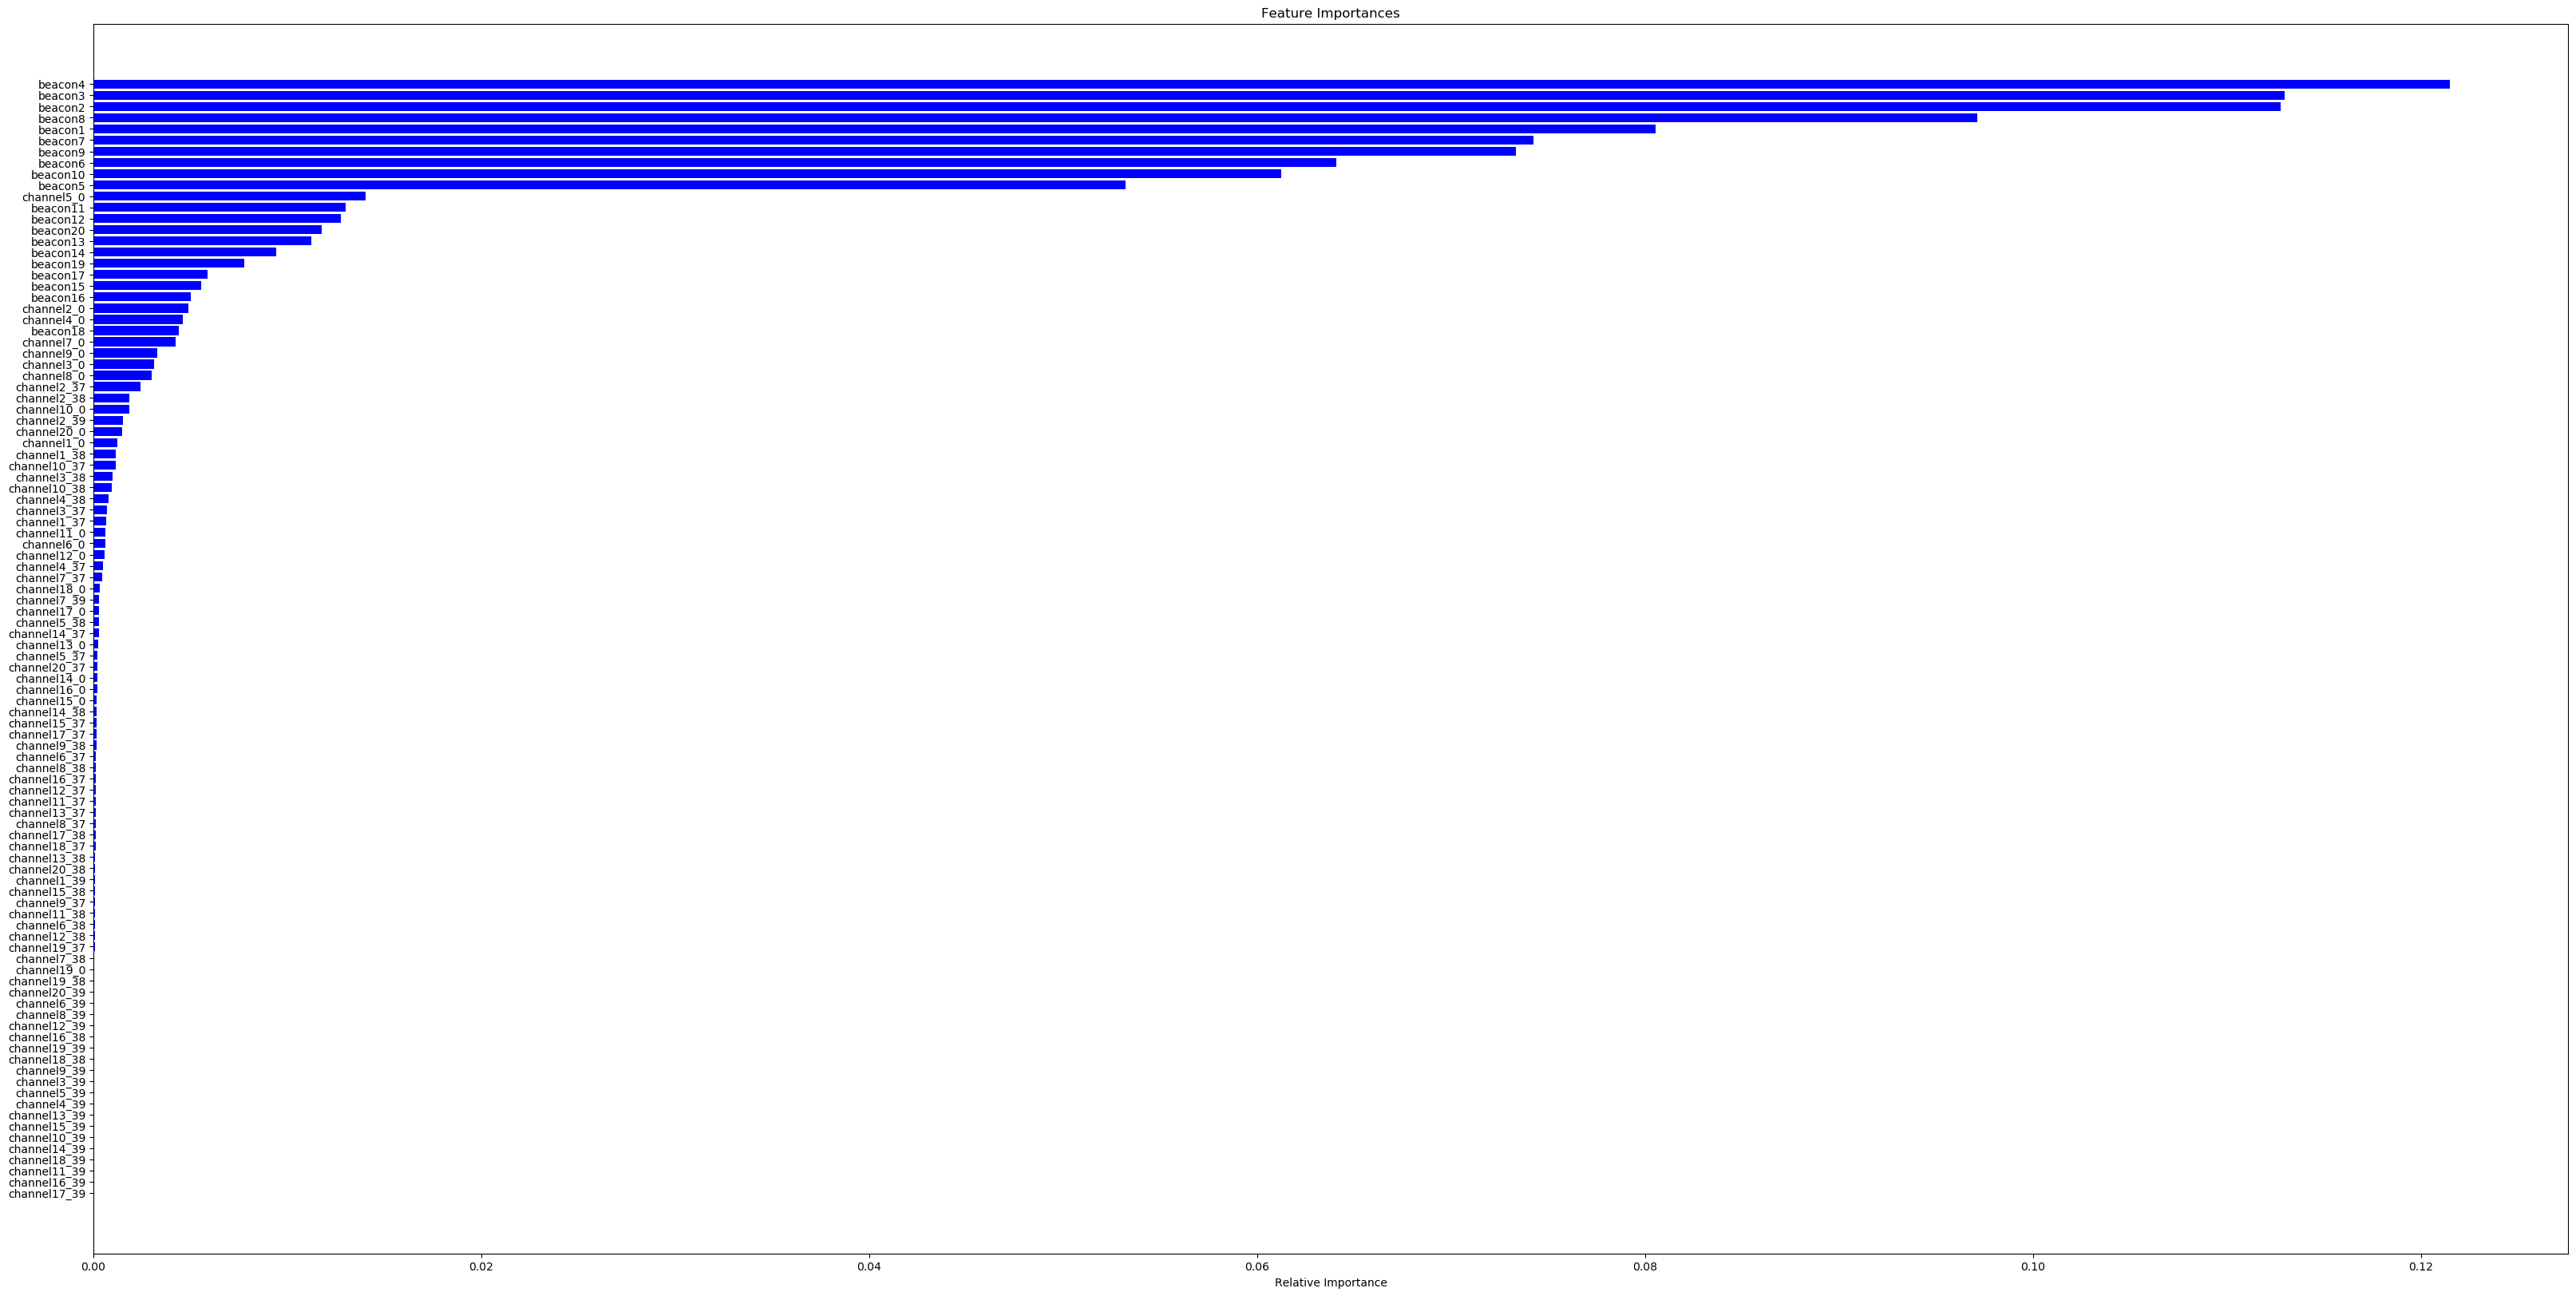

In [49]:
features = aX_train.columns
importances = clf.best_estimator_.feature_importances_
indices = np.argsort(importances) 
indices
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [50]:
indices = np.flip(indices, axis=None)

In [51]:
selected_col_count = 40
counter = 0
selected_columns = []
for ind in indices:
    if counter< selected_col_count:
        selected_columns.append(features[ind])
        counter+= 1
    else:
        break
selected_columns

['beacon4',
 'beacon3',
 'beacon2',
 'beacon8',
 'beacon1',
 'beacon7',
 'beacon9',
 'beacon6',
 'beacon10',
 'beacon5',
 'channel5_0',
 'beacon11',
 'beacon12',
 'beacon20',
 'beacon13',
 'beacon14',
 'beacon19',
 'beacon17',
 'beacon15',
 'beacon16',
 'channel2_0',
 'channel4_0',
 'beacon18',
 'channel7_0',
 'channel9_0',
 'channel3_0',
 'channel8_0',
 'channel2_37',
 'channel2_38',
 'channel10_0',
 'channel2_39',
 'channel20_0',
 'channel1_0',
 'channel1_38',
 'channel10_37',
 'channel3_38',
 'channel10_38',
 'channel4_38',
 'channel3_37',
 'channel1_37']

## Support Vector Machine 

In [52]:
min_max_scaler = MinMaxScaler()
scaled_aXtrain = aX_train.copy()
scaled_aXtrain[:] = min_max_scaler.fit_transform(scaled_aXtrain[:])
scaled_aXtrain

beacon1   beacon2   beacon3   beacon4   beacon5   beacon6   beacon7  \
17    0.471856  0.703556  0.676671  0.000000  0.000000  0.000000  0.000000   
1     0.819877  0.328059  0.000000  0.000000  0.000000  0.000000  0.000000   
10    0.891011  0.764821  0.491994  0.000000  0.000000  0.000000  0.000000   
4     0.940068  0.664030  0.272919  0.000000  0.000000  0.000000  0.000000   
6     0.894281  0.720025  0.479864  0.000000  0.000000  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
1160  0.950802  0.015442  0.999138  0.999138  0.999138  0.999138  0.999138   
1167  0.950838  0.015564  0.999143  0.999143  0.999143  0.999143  0.999143   
1164  0.950823  0.015512  0.999141  0.999141  0.999141  0.999141  0.999141   
1168  0.950844  0.015581  0.999144  0.999144  0.999144  0.999144  0.999144   
1165  0.950828  0.015529  0.999142  0.999142  0.999142  0.999142  0.999142   

       beacon8   beacon9  beacon10  ...  channel18_38  channel18_39  \
17    0.000000  0.000000  0.841694  ...           0.0           0.0   
1     0.000000  0.000000  0.900201  ...           0.0           0.0   
10    0.000000  0.000000  0.337487  ...           0.0           0.0   
4     0.000000  0.000000  0.893614  ...           0.0           0.0   
6     0.000000  0.000000  0.000000  ...           0.0           0.0   
...        ...       ...       ...  ...           ...           ...   
1160  0.999138  0.999138  0.988873  ...           0.0           0.0   
1167  0.999143  0.999143  0.988901  ...           0.0           1.0   
1164  0.999141  0.999141  0.988889  ...           1.0           0.0   
1168  0.999144  0.999144  0.988905  ...           1.0           0.0   
1165  0.999142  0.999142  0.988893  ...           0.0           0.0   

      channel19_0  channel19_37  channel19_38  channel19_39  channel20_0  \
17            1.0           0.0           0.0           0.0          1.0   
1             1.0           0.0           0.0           0.0          1.0   
10            1.0           0.0           0.0           0.0          1.0   
4             1.0           0.0           0.0           0.0          1.0   
6             1.0           0.0           0.0           0.0          1.0   
...           ...           ...           ...           ...          ...   
1160          0.0           1.0           0.0           0.0          1.0   
1167          0.0           1.0           0.0           0.0          1.0   
1164          0.0           0.0           1.0           0.0          1.0   
1168          0.0           1.0           0.0           0.0          1.0   
1165          0.0           1.0           0.0           0.0          1.0   

      channel20_37  channel20_38  channel20_39  
17             0.0           0.0           0.0  
1              0.0           0.0           0.0  
10             0.0           0.0           0.0  
4              0.0           0.0           0.0  
6              0.0           0.0           0.0  
...            ...           ...           ...  
1160           0.0           0.0           0.0  
1167           0.0           0.0           0.0  
1164           0.0           0.0           0.0  
1168           0.0           0.0           0.0  
1165           0.0           0.0           0.0  

[959 rows x 100 columns]

In [53]:
# aX_train_feature_selected =aX_train.loc[:, selected_columns]
grid_svm_parameters = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['poly','rbf', 'sigmoid','linear']}
grid = GridSearchCV(SVC(),grid_svm_parameters,refit=True,verbose=2)
print(grid.fit(scaled_aXtrain.loc[:, selected_columns], atarget_train))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, k

[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END ...................

[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ...................

[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C

In [54]:
grid.best_estimator_

SVC(C=100, gamma=1, kernel='poly')

In [55]:
scaled_aXtest = aX_test.copy()
scaled_aXtest[:] = min_max_scaler.fit_transform(scaled_aXtest[:])
start_time = time.time()
svm_grid_predictions = grid.predict(scaled_aXtest.loc[:, selected_columns])
runtime = round(time.time() - start_time,4)
print("Support Vector Machine algorithm prediction time: "+ str(runtime))
print(classification_report(atarget_test,svm_grid_predictions))

Support Vector Machine algorithm prediction time: 0.0134
              precision    recall  f1-score   support

           0       0.22      1.00      0.36         2
           1       0.00      0.00      0.00         3
           2       1.00      0.25      0.40         4
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         0
          11       0.33      0.50      0.40         4
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         3
          15       1.00      0.33      0.50         3
          16       0.00 

In [56]:
fingerprints_df2 = fingerprints_df_from_file.iloc[: , 2:]
for col in channel_cols:
    fingerprints_df2[col] = fingerprints_df2[col].map(str)
alpha_filtered3 = apply_filter_to_whole(fingerprints_df2, "alpha_beta_gamma","alpha_3.csv")
ashuf2, atrain2, avalidation2, atest2, aX_train2, atarget_train2, aX_validation2, atarget_validation2, aX_test2, atarget_test2 = split_train_validation_test(alpha_filtered3, 0.8,0.1)
grid = GridSearchCV(SVC(),grid_svm_parameters,refit=True,verbose=2)
print(grid.fit(aX_train2, atarget_train2))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, k

[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END ...................

[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=   0.1s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ...................

[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   0.1s
GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]

In [57]:
grid.best_estimator_

SVC(C=0.1, gamma=0.001, kernel='poly')

In [58]:
start_time = time.time()
svm_grid_predictions2 = grid.predict(aX_test2)
runtime = round(time.time() - start_time,4)
print("Support Vector Machine algorithm prediction time: "+ str(runtime))
print(classification_report(atarget_test2,svm_grid_predictions2))

Support Vector Machine algorithm prediction time: 0.0123
              precision    recall  f1-score   support

          b1       1.00      1.00      1.00         2
          b2       1.00      1.00      1.00         3
          b3       0.80      1.00      0.89         4
          b4       0.00      0.00      0.00         2
          b5       0.67      1.00      0.80         2
          b6       1.00      1.00      1.00         1
          b8       1.00      1.00      1.00         1
          b9       1.00      1.00      1.00         1
         be1       1.00      1.00      1.00         1
         be2       0.00      0.00      0.00         0
         be3       0.75      0.75      0.75         4
         be4       1.00      0.75      0.86         4
         be5       1.00      1.00      1.00         1
         be6       0.75      1.00      0.86         3
         be7       1.00      0.33      0.50         3
         be8       0.00      0.00      0.00         0
         be9       1.00 

## Artificial Neural Network

In [59]:
ann_model = keras.Sequential()
ann_model.add(keras.layers.InputLayer(input_shape = (100,)))
ann_model.add(keras.layers.Dense(120, activation ='elu'))
ann_model.add(keras.layers.Dropout(0.3))
ann_model.add(keras.layers.Dense(100, activation ='elu'))
ann_model.add(keras.layers.Dropout(0.3))
ann_model.add(keras.layers.Dense(96))
ann_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 120)               12120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               12100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 96)                9696      
Total params: 33,916
Trainable params: 33,916
Non-trainable params: 0
_________________________________________________________________


2023-06-23 17:33:11.850648: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-23 17:33:11.851417: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 12. Tune using inter_op_parallelism_threads for best performance.


In [60]:
ann_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam', metrics=['accuracy'])

In [61]:
one_hot_channel_cols = [col for col in fingerprints_df.columns if col not in no_channel_training_cols+['location']]
scaled_aXtrain_np = scaled_aXtrain.copy()
#scaled_aXtrain_np.loc[:, one_hot_channel_cols] = scaled_aXtrain_np.loc[:, one_hot_channel_cols].replace(0.0, -1)
#scaled_aXtrain_np = scaled_aXtrain_np.loc[:, selected_columns]
scaled_aXtrain_np = scaled_aXtrain_np.to_numpy()
scaled_aXtest_np = scaled_aXtest.copy()
#scaled_aXtest_np.loc[:, one_hot_channel_cols] = scaled_aXtest_np.loc[:, one_hot_channel_cols].replace(0, -1)
#scaled_aXtest_np = scaled_aXtest_np.loc[:, selected_columns]
scaled_aXtest_np = scaled_aXtest_np.to_numpy()
encoded_train_labels = atarget_train.to_numpy()
encoded_test_labels = atarget_test.to_numpy()

In [62]:
history = ann_model.fit(scaled_aXtrain_np, encoded_train_labels , epochs=100)

Epoch 1/100
959/959 [==============================] - 1s 2ms/step - loss: 4.5059 - accuracy: 0.0219
Epoch 2/100
959/959 [==============================] - 0s 185us/step - loss: 4.0249 - accuracy: 0.0605
Epoch 3/100
959/959 [==============================] - 0s 198us/step - loss: 3.5724 - accuracy: 0.0918
Epoch 4/100
959/959 [==============================] - 0s 190us/step - loss: 3.2716 - accuracy: 0.0907
Epoch 5/100
959/959 [==============================] - 0s 189us/step - loss: 3.0608 - accuracy: 0.1418
Epoch 6/100
959/959 [==============================] - 0s 190us/step - loss: 2.8922 - accuracy: 0.1835
Epoch 7/100
959/959 [==============================] - 0s 191us/step - loss: 2.7248 - accuracy: 0.2158
Epoch 8/100
959/959 [==============================] - 0s 192us/step - loss: 2.5917 - accuracy: 0.2357
Epoch 9/100
959/959 [==============================] - 0s 187us/step - loss: 2.5004 - accuracy: 0.2388
Epoch 10/100
959/959 [==============================] - 0s 185us/step - los

959/959 [==============================] - 0s 212us/step - loss: 0.9034 - accuracy: 0.6820
Epoch 80/100
959/959 [==============================] - 0s 233us/step - loss: 0.9653 - accuracy: 0.6684
Epoch 81/100
959/959 [==============================] - 0s 306us/step - loss: 0.9331 - accuracy: 0.6528
Epoch 82/100
959/959 [==============================] - 0s 262us/step - loss: 0.9339 - accuracy: 0.6548
Epoch 83/100
959/959 [==============================] - 0s 329us/step - loss: 0.9072 - accuracy: 0.6736
Epoch 84/100
959/959 [==============================] - 0s 364us/step - loss: 0.9331 - accuracy: 0.6767
Epoch 85/100
959/959 [==============================] - 0s 329us/step - loss: 0.9382 - accuracy: 0.6611
Epoch 86/100
959/959 [==============================] - 0s 340us/step - loss: 0.8933 - accuracy: 0.6840
Epoch 87/100
959/959 [==============================] - 0s 322us/step - loss: 0.8805 - accuracy: 0.6809
Epoch 88/100
959/959 [==============================] - 0s 342us/step - loss:

In [63]:
start_time = time.time()
test_loss, test_acc = ann_model.evaluate(scaled_aXtest_np,  encoded_test_labels, verbose=2)
runtime = round(time.time() - start_time,4)
print("Neural Network algorithm prediction time: "+ str(runtime))
test_acc

Neural Network algorithm prediction time: 0.3544


0.4793388545513153

In [64]:
def plot_loss_acc_rate(history):    
#     plt.plot(history.history['val_loss'])
#     plt.title('Model \'s loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.show()
#     plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['accuracy'])
    plt.title('Model \'s accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()

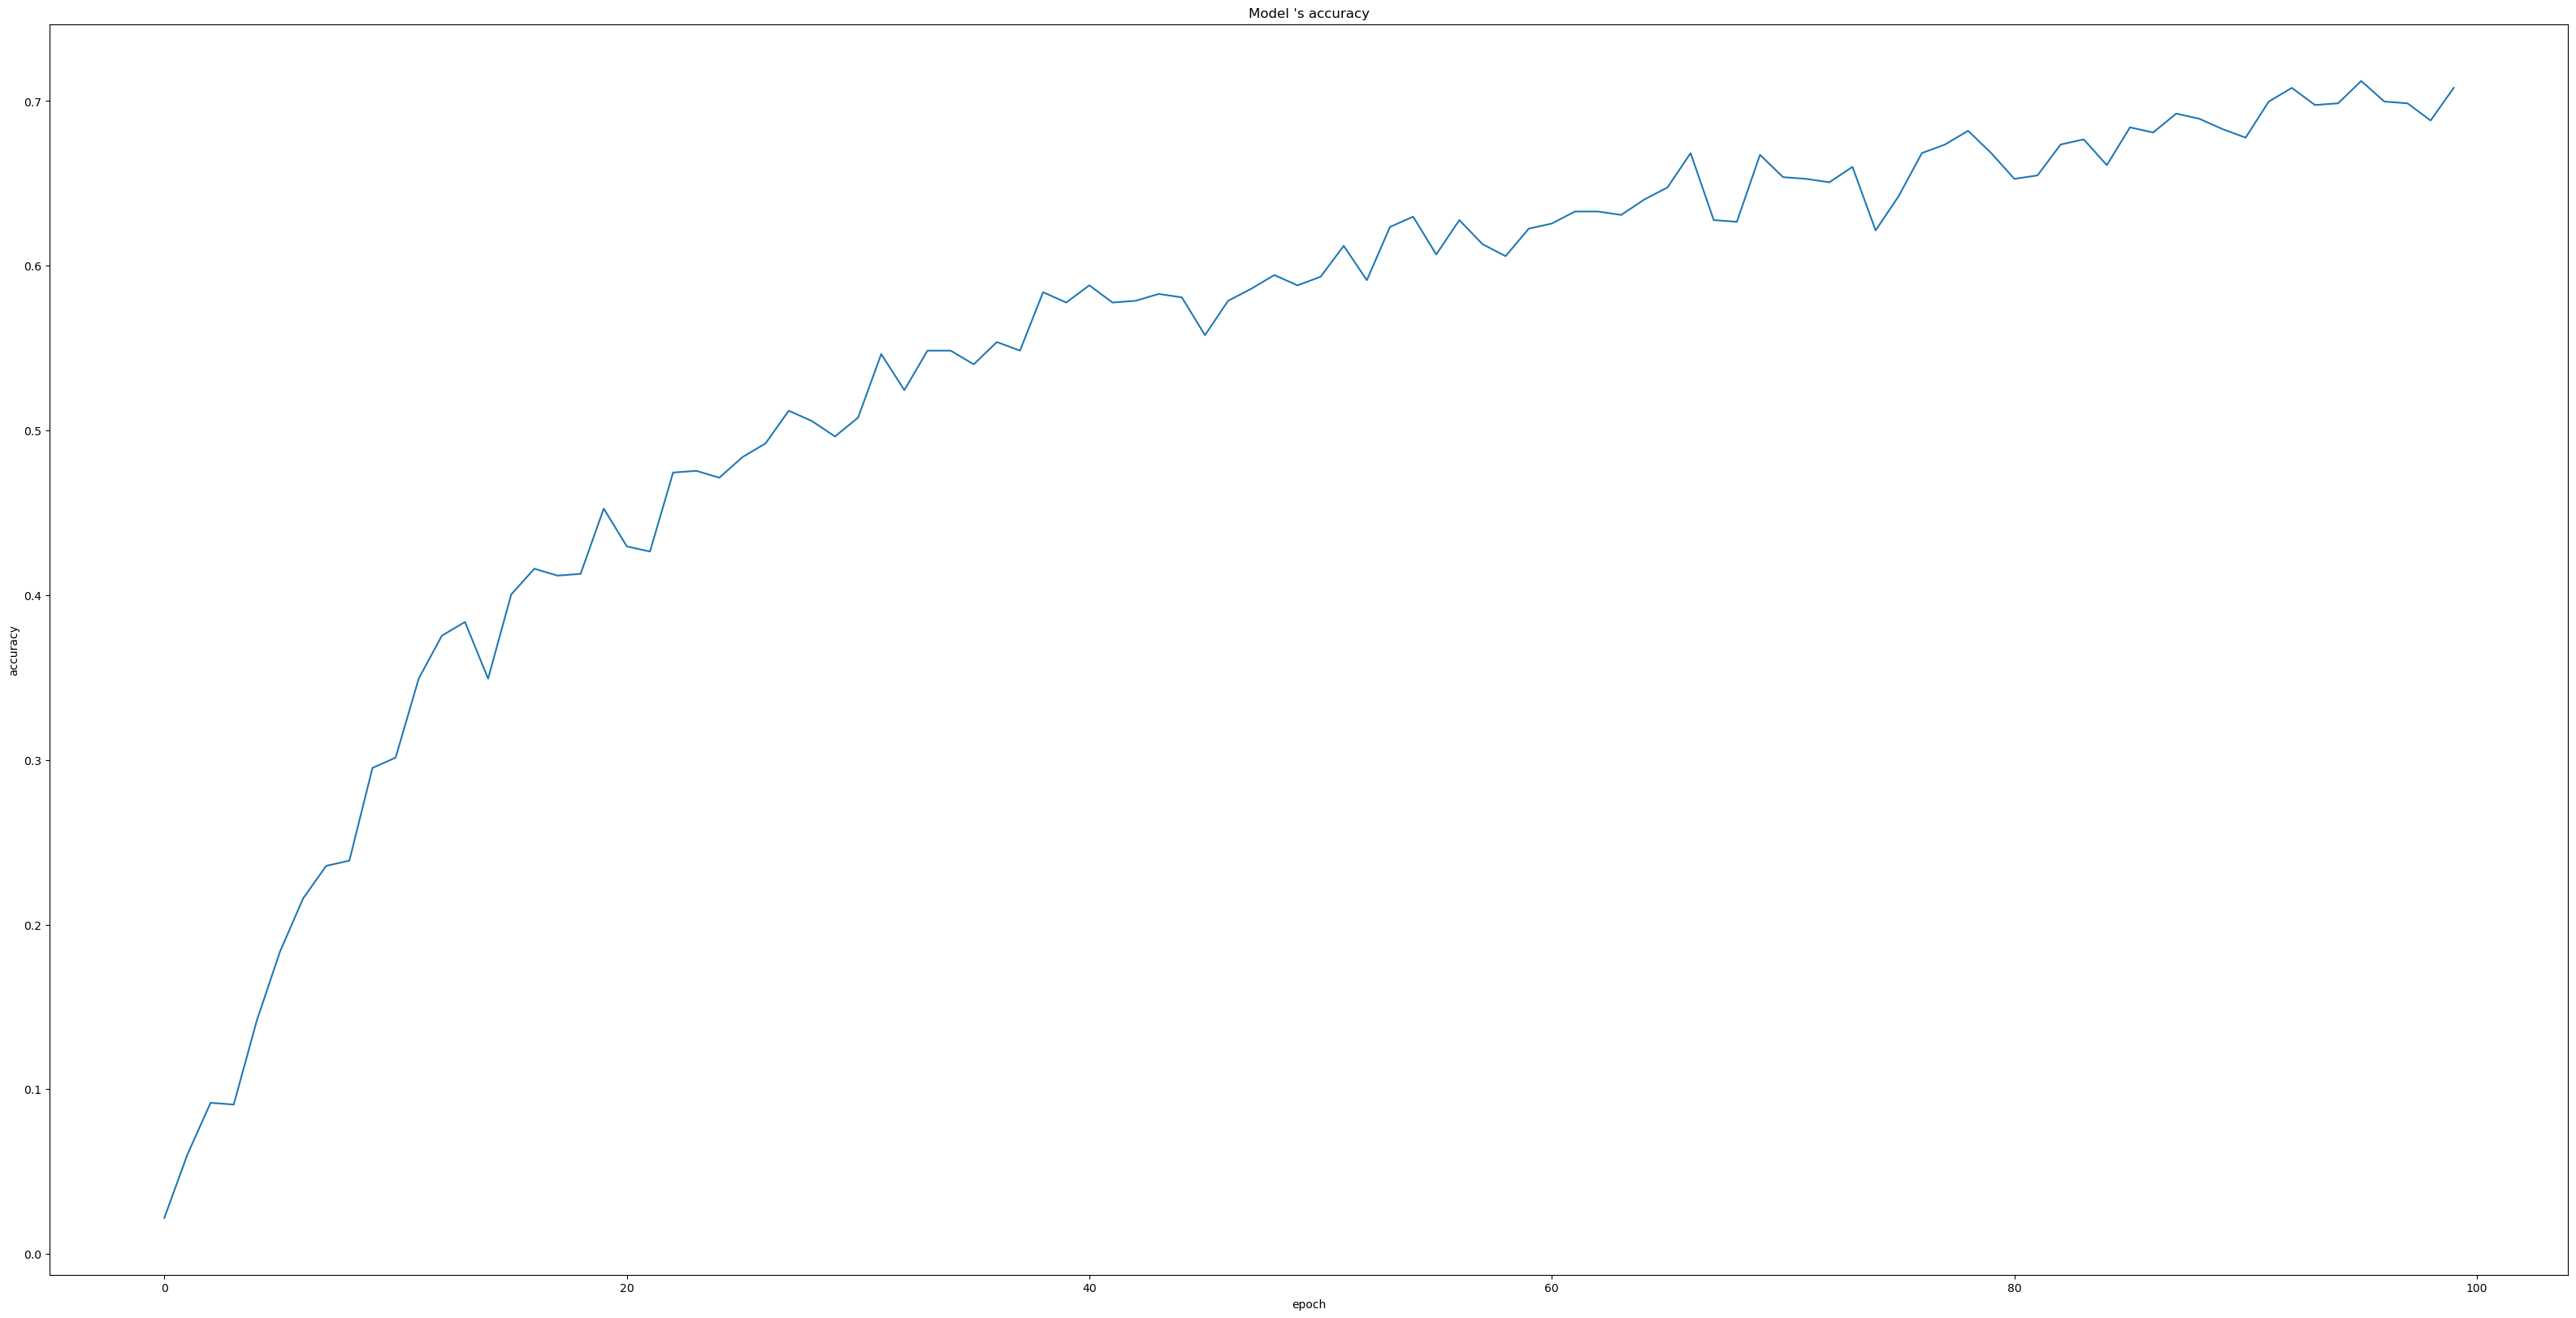

In [65]:
plot_loss_acc_rate(history)

### Unfiltered Data

In [66]:
scaled_Xtrain = X_train.copy()
scaled_Xtrain[:] = min_max_scaler.fit_transform(scaled_Xtrain[:])
scaled_Xtest = X_test.copy()
scaled_Xtest[:] = min_max_scaler.fit_transform(scaled_Xtest[:])
scaled_Xtrain_np = scaled_Xtrain.to_numpy()
scaled_Xtest_np = scaled_Xtest.to_numpy()
train_labels = target_train.to_numpy()
test_labels = target_test.to_numpy()

In [67]:
ann_model2 = keras.Sequential()
ann_model2.add(keras.layers.InputLayer(input_shape = (100,)))
ann_model2.add(keras.layers.Dense(120, activation ='elu'))
ann_model2.add(keras.layers.Dropout(0.3))
ann_model2.add(keras.layers.Dense(100, activation ='elu'))
ann_model2.add(keras.layers.Dropout(0.3))
ann_model2.add(keras.layers.Dense(96))
ann_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 120)               12120     
_________________________________________________________________
dropout_3 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               12100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 96)                9696      
Total params: 33,916
Trainable params: 33,916
Non-trainable params: 0
_________________________________________________________________


In [68]:
ann_model2.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam', metrics=['accuracy'])
history2 = ann_model.fit(scaled_Xtrain_np, train_labels , epochs=15)

Epoch 1/15
959/959 [==============================] - 0s 197us/step - loss: 6.0054 - accuracy: 0.2304
Epoch 2/15
959/959 [==============================] - 0s 211us/step - loss: 2.3146 - accuracy: 0.3233
Epoch 3/15
959/959 [==============================] - 0s 212us/step - loss: 1.9801 - accuracy: 0.3806
Epoch 4/15
959/959 [==============================] - 0s 212us/step - loss: 1.9057 - accuracy: 0.3743
Epoch 5/15
959/959 [==============================] - 0s 229us/step - loss: 1.7339 - accuracy: 0.4171
Epoch 6/15
959/959 [==============================] - 0s 237us/step - loss: 1.6779 - accuracy: 0.4515
Epoch 7/15
959/959 [==============================] - 0s 226us/step - loss: 1.6760 - accuracy: 0.4317
Epoch 8/15
959/959 [==============================] - 0s 230us/step - loss: 1.6904 - accuracy: 0.4442
Epoch 9/15
959/959 [==============================] - 0s 233us/step - loss: 1.6671 - accuracy: 0.4442
Epoch 10/15
959/959 [==============================] - 0s 236us/step - loss: 1.631

In [69]:
start_time = time.time()
test_loss, test_acc = ann_model2.evaluate(scaled_Xtest_np, test_labels, verbose=2)
runtime = round(time.time() - start_time,4)
print("Neural Network algorithm prediction time: "+ str(runtime))
test_acc

Neural Network algorithm prediction time: 0.31


0.0

## XGBoost Algorithm

In [70]:
xgb_param = {
    'learning_rate': [0.02, 0.05, 0.1, 0.3],
    'max_depth': [6, 8, 10],
    'n_estimators': [50, 80, 100],
    'colsample_bytree' : [0.4, 0.6,0.8]
}
model_xgb_hyper = GridSearchCV(estimator= xgb.XGBClassifier(eval_metric = 'auc', subsample = 0.5),
                              param_grid = xgb_param, cv = 3,
                              return_train_score= True, verbose = 4)
model_xgb_hyper.fit(aX_train,  atarget_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 1/3] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=50;, score=(train=0.782, test=0.738) total time=   1.5s
[CV 2/3] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=50;, score=(train=0.776, test=0.684) total time=   1.6s
[CV 3/3] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=50;, score=(train=0.744, test=0.633) total time=   1.8s
[CV 1/3] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=80;, score=(train=0.837, test=0.784) total time=   2.5s
[CV 2/3] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=80;, score=(train=0.829, test=0.759) total time=   2.3s
[CV 3/3] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=80;, score=(train=0.831, test=0.740) total time=   2.2s
[CV 1/3] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=100;, score=(train=0.861, test=0.7

[CV 1/3] END colsample_bytree=0.4, learning_rate=0.1, max_depth=6, n_estimators=100;, score=(train=0.980, test=0.887) total time=   3.3s
[CV 2/3] END colsample_bytree=0.4, learning_rate=0.1, max_depth=6, n_estimators=100;, score=(train=0.975, test=0.903) total time=   3.0s
[CV 3/3] END colsample_bytree=0.4, learning_rate=0.1, max_depth=6, n_estimators=100;, score=(train=0.970, test=0.850) total time=   3.3s
[CV 1/3] END colsample_bytree=0.4, learning_rate=0.1, max_depth=8, n_estimators=50;, score=(train=0.926, test=0.838) total time=   1.7s
[CV 2/3] END colsample_bytree=0.4, learning_rate=0.1, max_depth=8, n_estimators=50;, score=(train=0.934, test=0.838) total time=   1.5s
[CV 3/3] END colsample_bytree=0.4, learning_rate=0.1, max_depth=8, n_estimators=50;, score=(train=0.934, test=0.818) total time=   1.3s
[CV 1/3] END colsample_bytree=0.4, learning_rate=0.1, max_depth=8, n_estimators=80;, score=(train=0.975, test=0.884) total time=   2.3s
[CV 2/3] END colsample_bytree=0.4, learning_r

[CV 1/3] END colsample_bytree=0.6, learning_rate=0.02, max_depth=8, n_estimators=80;, score=(train=0.845, test=0.762) total time=   2.3s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.02, max_depth=8, n_estimators=80;, score=(train=0.831, test=0.769) total time=   2.2s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.02, max_depth=8, n_estimators=80;, score=(train=0.836, test=0.724) total time=   2.2s
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.02, max_depth=8, n_estimators=100;, score=(train=0.862, test=0.775) total time=   2.8s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.02, max_depth=8, n_estimators=100;, score=(train=0.858, test=0.794) total time=   3.7s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.02, max_depth=8, n_estimators=100;, score=(train=0.856, test=0.752) total time=   3.0s
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.02, max_depth=10, n_estimators=50;, score=(train=0.767, test=0.716) total time=   1.8s
[CV 2/3] END colsample_bytree=0.6, le

[CV 1/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=50;, score=(train=0.931, test=0.828) total time=   2.1s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=50;, score=(train=0.928, test=0.847) total time=   1.7s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=50;, score=(train=0.930, test=0.812) total time=   1.4s
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=80;, score=(train=0.977, test=0.866) total time=   2.1s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=80;, score=(train=0.959, test=0.878) total time=   2.1s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=80;, score=(train=0.956, test=0.809) total time=   2.1s
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=100;, score=(train=0.981, test=0.875) total time=   2.6s
[CV 2/3] END colsample_bytree=0.6, learn

[CV 1/3] END colsample_bytree=0.8, learning_rate=0.02, max_depth=10, n_estimators=100;, score=(train=0.865, test=0.778) total time=   3.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.02, max_depth=10, n_estimators=100;, score=(train=0.861, test=0.781) total time=   3.0s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.02, max_depth=10, n_estimators=100;, score=(train=0.864, test=0.749) total time=   2.9s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=50;, score=(train=0.870, test=0.784) total time=   1.5s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=50;, score=(train=0.872, test=0.816) total time=   1.5s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=50;, score=(train=0.869, test=0.743) total time=   1.5s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=80;, score=(train=0.917, test=0.791) total time=   2.5s
[CV 2/3] END colsample_bytree=0.8, 

[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, n_estimators=80;, score=(train=0.994, test=0.869) total time=   2.0s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, n_estimators=80;, score=(train=0.987, test=0.897) total time=   2.0s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, n_estimators=80;, score=(train=0.992, test=0.809) total time=   2.0s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, n_estimators=100;, score=(train=0.995, test=0.872) total time=   2.9s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, n_estimators=100;, score=(train=0.994, test=0.909) total time=   2.5s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=6, n_estimators=100;, score=(train=0.995, test=0.821) total time=   2.4s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=50;, score=(train=0.987, test=0.875) total time=   1.4s
[CV 2/3] END colsample_bytree=0.8, learning_r

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='auc', gamma=None, gpu_id=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                             

In [71]:
model_xgb_hyper.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [72]:
start_time = time.time()
grid_xgb_predictions = model_xgb_hyper.predict(aX_test)
runtime = round(time.time() - start_time,4)
print("XGBoost algorithm prediction time: "+ str(runtime))
print(classification_report(atarget_test,grid_xgb_predictions))

XGBoost algorithm prediction time: 0.0176
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      0.50      0.67         4
           3       0.50      1.00      0.67         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          17       1.00      1.00      1.00         1
          19       1.00      1.00      1.00         1
          21       0.67      1.00      

## Data Generation

### Variational Autoencoder Definition

In [73]:
def sample(means_log_var):
    means, log_var = means_log_var
    epsilon = K.random_normal(shape=(K.shape(means)[0], latent_dim), mean=0, stddev=0.1)
    return means + K.exp(log_var) * epsilon

In [74]:
data_shape = (20,)
latent_dim = 8
input_layer = keras.Input(shape=data_shape)
x = keras.layers.Dense(18, activation ='relu')(input_layer)
x = keras.layers.Dense(15, activation ='relu')(x)
x = keras.layers.Dense(10, activation ='relu')(x)
means = keras.layers.Dense(latent_dim)(x)
log_var = keras.layers.Dense(latent_dim)(x)

z = Lambda(sample, output_shape = (latent_dim, ))([means, log_var])

encoder = keras.models.Model(input_layer, [means, log_var, z])
print(encoder.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 18)           378         input_3[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 15)           285         dense_7[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 10)           160         dense_8[0][0]                    
____________________________________________________________________________________________

In [75]:
decoder_input = keras.layers.Input(shape =(latent_dim,))
x = keras.layers.Dense(10, activation ='relu')(decoder_input)
x = keras.layers.Dense(15, activation ='relu')(x)
x = keras.layers.Dense(18, activation ='relu')(x)
outputs = keras.layers.Dense(20, activation ='sigmoid')(x)

decoder = keras.models.Model(decoder_input, outputs)
print(decoder.summary())
x_prime = decoder(z)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                90        
_________________________________________________________________
dense_13 (Dense)             (None, 15)                165       
_________________________________________________________________
dense_14 (Dense)             (None, 18)                288       
_________________________________________________________________
dense_15 (Dense)             (None, 20)                380       
Total params: 923
Trainable params: 923
Non-trainable params: 0
_________________________________________________________________
None


In [76]:
def my_loss(x, x_prime):
#     x = K.flatten(x)
#     x_prime = K.flatten(x_prime)
    reconstruct_loss = 20*keras.metrics.binary_crossentropy(x, x_prime)
    kl_loss = -0.5* K.sum(1 + log_var - K.square(means) - K.exp(log_var), axis = -1)
    return K.mean(reconstruct_loss + kl_loss)


In [77]:
outputs = decoder(encoder(input_layer)[2])
vae = keras.models.Model(input_layer, outputs, name='vae')    
vae.compile(loss=my_loss,optimizer="adam")
print(vae.summary())  

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 20)                0         
_________________________________________________________________
model_1 (Model)              [(None, 8), (None, 8), (N 999       
_________________________________________________________________
model_2 (Model)              (None, 20)                923       
Total params: 1,922
Trainable params: 1,922
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
def create_vae():
    data_shape = (20,)
    latent_dim = 8
    input_layer = keras.Input(shape=data_shape)
    x = keras.layers.Dense(18, activation ='relu')(input_layer)
    x = keras.layers.Dense(15, activation ='relu')(x)
    x = keras.layers.Dense(10, activation ='relu')(x)
    means = keras.layers.Dense(latent_dim)(x)
    log_var = keras.layers.Dense(latent_dim)(x)

    z = Lambda(sample, output_shape = (latent_dim, ))([means, log_var])

    encoder = keras.models.Model(input_layer, [means, log_var, z])
    
    decoder_input = keras.layers.Input(shape =(latent_dim,))
    x = keras.layers.Dense(10, activation ='relu')(decoder_input)
    x = keras.layers.Dense(15, activation ='relu')(x)
    x = keras.layers.Dense(18, activation ='relu')(x)
    outputs = keras.layers.Dense(20, activation ='sigmoid')(x)

    decoder = keras.models.Model(decoder_input, outputs)
    x_prime = decoder(z)
    outputs = decoder(encoder(input_layer)[2])
    vae = keras.models.Model(input_layer, outputs, name='vae')    
    vae.compile(loss=my_loss,optimizer="adam")
    print(vae.summary())
    return vae, encoder

### Data preparation

In [134]:
def data_split_for_syn(dataframe, train_size):
  
    shuffled_df = dataframe.sample(frac=1, random_state = 37)
    train_num = int(train_size * len(dataframe))
    
    train_set_with_label = shuffled_df[:train_num]
    test_set_with_label = shuffled_df[train_num:]
    
    train_set_with_label = train_set_with_label.sort_values('location')
    test_set_with_label = test_set_with_label.sort_values('location')
    
    train_set_with_label.reset_index(inplace=True, drop=True)
    test_set_with_label.reset_index(inplace=True, drop=True)
    
#     train_set_with_label.loc[:, no_channel_training_cols] =  min_max_scaler.fit_transform(train_set_with_label.loc[:, no_channel_training_cols])
#     test_set_with_label.loc[:, no_channel_training_cols] =  min_max_scaler.fit_transform(test_set_with_label.loc[:, no_channel_training_cols])
    return train_set_with_label, test_set_with_label

In [135]:
def prep_data_for_synthesis(dataframe, percentage):
    if percentage <= 0.5:
        frac = int(1/percentage)
    else:
        frac = int(1/(1-percentage))
#     dataframe = dataframe.sample(frac=1, random_state = 37)
#     dataframe.reset_index(inplace=True, drop=True)
    part_df = dataframe.loc[:, no_channel_training_cols + ['location']].iloc[::frac]
    indices = part_df.index
    test_df = dataframe.drop(indices, axis=0).loc[:, no_channel_training_cols + ['location']]

    
    part_locations = part_df.loc[:, ['location']]
#     part_df[:] = min_max_scaler.fit_transform(part_df[:])
    part_df = part_df.loc[:, no_channel_training_cols]
    
    test_locations = test_df.loc[:, ['location']]
#     test_df[:] = min_max_scaler.fit_transform(test_df[:])
    test_df = test_df.loc[:, no_channel_training_cols]
    
    if percentage <= 0.5:
        return part_df, part_locations, test_df, test_locations
    
    return   test_df, test_locations, part_df, part_locations
    



In [136]:
alpha_filtered2_train, alpha_filtered2_test = data_split_for_syn(alpha_filtered2.loc[:, no_channel_training_cols + ['location']],0.8)
half_df, half_locations, half_df_test, half_test_loc = prep_data_for_synthesis(alpha_filtered2_train, 0.5)
fourth_df, fourth_locations, fourth_df_test, fourth_test_loc = prep_data_for_synthesis(alpha_filtered2_train, 0.25)

In [137]:
half_df

beacon1    beacon2     beacon3     beacon4     beacon5     beacon6  \
0   -107.134454 -83.647059 -172.931671 -300.000000 -300.000000 -300.000000   
2    -94.928571 -83.100000 -207.611111 -300.000000 -300.000000 -300.000000   
4    -94.833333 -83.500000 -209.888889 -300.000000 -300.000000 -300.000000   
6    -95.080357 -83.625000 -185.205376 -300.000000 -300.000000 -300.000000   
8   -120.875000 -83.375000 -221.152778 -300.000000 -300.000000 -300.000000   
..          ...        ...         ...         ...         ...         ...   
950  -93.186987 -89.791008 -112.376929 -145.406447 -200.161481 -211.664762   
952  -93.187601 -89.791632 -112.377486 -145.406907 -200.161777 -211.665025   
954  -93.187447 -89.791476 -112.377347 -145.406791 -200.161703 -211.664959   
956  -93.186834 -89.790852 -112.376790 -145.406333 -200.161407 -211.664697   
958  -93.186681 -89.790697 -112.376652 -145.406219 -200.161333 -211.664632   

        beacon7     beacon8     beacon9    beacon10    beacon11    beacon12  \
0   -300.000000 -300.000000 -300.000000  -99.220588 -300.000000 -300.000000   
2   -300.000000 -300.000000 -300.000000 -118.357500 -300.000000 -300.000000   
4   -300.000000 -300.000000 -300.000000 -131.166667 -300.000000 -300.000000   
6   -300.000000 -300.000000 -300.000000  -99.234375 -300.000000 -300.000000   
8   -300.000000 -300.000000 -300.000000  -98.175000 -300.000000 -300.000000   
..          ...         ...         ...         ...         ...         ...   
950 -201.389845 -185.995421 -188.564798  -93.634039 -275.911576 -274.502853   
952 -201.390138 -185.995760 -188.565129  -93.634652 -275.911648 -274.502928   
954 -201.390065 -185.995675 -188.565046  -93.634498 -275.911630 -274.502909   
956 -201.389772 -185.995337 -188.564715  -93.633886 -275.911558 -274.502834   
958 -201.389699 -185.995253 -188.564633  -93.633734 -275.911541 -274.502815   

       beacon13    beacon14    beacon15    beacon16    beacon17    beacon18  \
0   -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
2   -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
4   -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
6   -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
8   -300.000000 -300.000000 -300.000000 -300.000000 -300.000000 -300.000000   
..          ...         ...         ...         ...         ...         ...   
950 -272.353795 -269.961655 -286.048080 -284.236170 -287.030935 -284.942635   
952 -272.353877 -270.551686 -286.706572 -284.935001 -287.714390 -285.615431   
954 -272.353856 -270.404659 -286.539584 -284.758332 -287.544808 -285.448521   
956 -272.353774 -269.811344 -285.877935 -284.065005 -286.865960 -284.766568   
958 -272.353754 -269.665583 -285.710658 -283.894134 -286.704702 -284.595952   

       beacon19    beacon20  
0   -300.000000 -300.000000  
2   -300.000000 -300.000000  
4   -300.000000 -300.000000  
6   -300.000000 -300.000000  
8   -300.000000 -300.000000  
..          ...         ...  
950 -279.243340 -270.843007  
952 -279.867993 -270.843094  
954 -279.712935 -270.843072  
956 -279.078182 -270.842986  
958 -278.921034 -270.842964  

[480 rows x 20 columns]

### Original Data Results

In [138]:
rfc_semi = RandomForestClassifier()
forest_semi_params = [{'criterion': ["entropy"], 'max_depth':[5,8,10,12,15], 'max_features': [8,10,15,20]}]
grid_clf = GridSearchCV(rfc_semi, forest_semi_params, cv = 3, scoring='accuracy',refit=True,verbose=2)
print(grid_clf.fit(alpha_filtered2_train.loc[:, no_channel_training_cols], alpha_filtered2_train.loc[:, ['location']]))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END .....criterion=entropy, max_depth=5, max_features=8; total time=   0.6s
[CV] END .....criterion=entropy, max_depth=5, max_features=8; total time=   0.5s
[CV] END .....criterion=entropy, max_depth=5, max_features=8; total time=   0.5s
[CV] END ....criterion=entropy, max_depth=5, max_features=10; total time=   0.6s
[CV] END ....criterion=entropy, max_depth=5, max_features=10; total time=   0.6s
[CV] END ....criterion=entropy, max_depth=5, max_features=10; total time=   0.6s
[CV] END ....criterion=entropy, max_depth=5, max_features=15; total time=   0.9s
[CV] END ....criterion=entropy, max_depth=5, max_features=15; total time=   0.9s
[CV] END ....criterion=entropy, max_depth=5, max_features=15; total time=   0.9s
[CV] END ....criterion=entropy, max_depth=5, max_features=20; total time=   1.1s
[CV] END ....criterion=entropy, max_depth=5, max_features=20; total time=   1.2s
[CV] END ....criterion=entropy, max_depth=5, max

In [139]:
grid_clf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=8, max_features=15)

In [140]:
orig_predictions = grid_clf.predict(alpha_filtered2_test.loc[:, no_channel_training_cols])
accuracy_score(alpha_filtered2_test.loc[:, ['location']], orig_predictions)*100

90.83333333333333

In [141]:
percs = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]
original_accs = {}
for per in percs:
    part_df, part_locations, part_df_test, part_test_loc = prep_data_for_synthesis(alpha_filtered2_train, per)
    rfc_semi = RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
    print(rfc_semi.fit(part_df, part_locations))
    perc_predictions = rfc_semi.predict(alpha_filtered2_test.loc[:, no_channel_training_cols])
    original_accs[per] = accuracy_score(alpha_filtered2_test.loc[:, ['location']], perc_predictions)*100

RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4)


In [142]:
original_accs

{0.01: 14.166666666666666,
 0.05: 55.00000000000001,
 0.1: 65.83333333333333,
 0.3: 89.16666666666667,
 0.5: 90.41666666666667,
 0.7: 89.16666666666667,
 0.9: 92.08333333333333}

In [182]:
original_accs2 = {}
for per in percs:
    part_df, part_locations, part_df_test, part_test_loc = prep_data_for_synthesis(alpha_filtered2_train, per)
    perc_predictions,runtime = run_knn(part_df, part_locations, alpha_filtered2_test.loc[:, no_channel_training_cols],[],5)
    original_accs2[per] = accuracy_score(alpha_filtered2_test.loc[:, ['location']], perc_predictions)*100

In [183]:
original_accs2

{0.01: 2.083333333333333,
 0.05: 5.0,
 0.1: 28.333333333333332,
 0.3: 72.08333333333333,
 0.5: 81.66666666666667,
 0.7: 83.33333333333334,
 0.9: 90.41666666666667}

### Model Training

In [88]:
def k_nearest_neigh(X_train, target_train, X_test, target_test):  
    accuracies = []
    for k in range(1, 9):
        knn = KNeighborsClassifier(n_neighbors = k, metric='manhattan')
        knn.fit(X_train, target_train)
        y_pred = knn.predict(X_test)
        accuracies.append(accuracy_score(target_test, y_pred)*100)
    big_k = accuracies.index(max(accuracies))
    
    knn = KNeighborsClassifier(n_neighbors = big_k, metric='manhattan')
    knn.fit(X_train, target_train)
    y_pred = knn.predict(X_test)
    return y_pred

In [227]:
data_shape = (20,)
latent_dim = 8
input_layer = keras.Input(shape=data_shape)
x = keras.layers.Dense(15, activation ='relu')(input_layer)
x = keras.layers.Dense(10, activation ='relu')(x)
means = keras.layers.Dense(latent_dim)(x)
log_var = keras.layers.Dense(latent_dim)(x)

z = Lambda(sample, output_shape = (latent_dim, ))([means, log_var])

encoder = keras.models.Model(input_layer, [means, log_var, z])
    
decoder_input = keras.layers.Input(shape =(latent_dim,))
x = keras.layers.Dense(10, activation ='relu')(decoder_input)
x = keras.layers.Dense(15, activation ='relu')(x)
outputs = keras.layers.Dense(20, activation ='sigmoid')(x)
decoder = keras.models.Model(decoder_input, outputs)
x_prime = decoder(z)
outputs = decoder(encoder(input_layer)[2])
vae = keras.models.Model(input_layer, outputs, name='vae')    
vae.compile(loss=my_loss,optimizer="adam",metrics=["accuracy"])
print(vae.summary())

his = vae.fit(min_max_scaler.fit_transform(alpha_filtered2_train.loc[:, no_channel_training_cols]), min_max_scaler.fit_transform(alpha_filtered2_train.loc[:, no_channel_training_cols]) , epochs = 200, batch_size = 16, validation_split= 0.2)

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        (None, 20)                0         
_________________________________________________________________
model_65 (Model)             [(None, 8), (None, 8), (N 651       
_________________________________________________________________
model_66 (Model)             (None, 20)                575       
Total params: 1,226
Trainable params: 1,226
Non-trainable params: 0
_________________________________________________________________
None
Train on 767 samples, validate on 192 samples
Epoch 1/200
767/767 [==============================] - 4s 5ms/step - loss: 13.4925 - accuracy: 0.4459 - val_loss: 13.0580 - val_accuracy: 0.9062
Epoch 2/200
767/767 [==============================] - 0s 475us/step - loss: 10.8420 - accuracy: 0.4641 - val_loss: 10.4450 - val_accuracy: 0.9062
Epoch 3/200
767/767 [===========================

Epoch 52/200
767/767 [==============================] - 0s 458us/step - loss: 3.2550 - accuracy: 0.5658 - val_loss: 4.8500 - val_accuracy: 0.9062
Epoch 53/200
767/767 [==============================] - 0s 456us/step - loss: 3.2613 - accuracy: 0.5593 - val_loss: 4.9866 - val_accuracy: 0.9062
Epoch 54/200
767/767 [==============================] - 0s 451us/step - loss: 3.2431 - accuracy: 0.5332 - val_loss: 4.9745 - val_accuracy: 0.9062
Epoch 55/200
767/767 [==============================] - 0s 452us/step - loss: 3.2522 - accuracy: 0.5632 - val_loss: 4.9389 - val_accuracy: 0.9062
Epoch 56/200
767/767 [==============================] - 0s 454us/step - loss: 3.2421 - accuracy: 0.5593 - val_loss: 4.9967 - val_accuracy: 0.9062
Epoch 57/200
767/767 [==============================] - 0s 455us/step - loss: 3.2419 - accuracy: 0.5945 - val_loss: 4.9352 - val_accuracy: 0.9062
Epoch 58/200
767/767 [==============================] - 0s 463us/step - loss: 3.2460 - accuracy: 0.5763 - val_loss: 4.7724 -

767/767 [==============================] - 0s 537us/step - loss: 3.2211 - accuracy: 0.6010 - val_loss: 4.8073 - val_accuracy: 0.8646
Epoch 109/200
767/767 [==============================] - 0s 541us/step - loss: 3.2266 - accuracy: 0.5958 - val_loss: 4.7154 - val_accuracy: 0.8438
Epoch 110/200
767/767 [==============================] - 0s 461us/step - loss: 3.2069 - accuracy: 0.6037 - val_loss: 4.7510 - val_accuracy: 0.8906
Epoch 111/200
767/767 [==============================] - 0s 460us/step - loss: 3.2164 - accuracy: 0.5971 - val_loss: 4.9000 - val_accuracy: 0.8490
Epoch 112/200
767/767 [==============================] - 0s 477us/step - loss: 3.2355 - accuracy: 0.6128 - val_loss: 4.8839 - val_accuracy: 0.8958
Epoch 113/200
767/767 [==============================] - 0s 496us/step - loss: 3.2126 - accuracy: 0.6050 - val_loss: 4.8255 - val_accuracy: 0.7604
Epoch 114/200
767/767 [==============================] - 0s 494us/step - loss: 3.2095 - accuracy: 0.5906 - val_loss: 4.8258 - val_ac

Epoch 164/200
767/767 [==============================] - 0s 499us/step - loss: 3.1859 - accuracy: 0.6428 - val_loss: 4.6101 - val_accuracy: 0.6667
Epoch 165/200
767/767 [==============================] - 0s 494us/step - loss: 3.1899 - accuracy: 0.6506 - val_loss: 4.6192 - val_accuracy: 0.6510
Epoch 166/200
767/767 [==============================] - 0s 510us/step - loss: 3.1968 - accuracy: 0.6349 - val_loss: 4.6824 - val_accuracy: 0.5885
Epoch 167/200
767/767 [==============================] - 0s 498us/step - loss: 3.1979 - accuracy: 0.6115 - val_loss: 4.6096 - val_accuracy: 0.5052
Epoch 168/200
767/767 [==============================] - 0s 500us/step - loss: 3.1947 - accuracy: 0.6428 - val_loss: 4.6388 - val_accuracy: 0.5104
Epoch 169/200
767/767 [==============================] - 0s 495us/step - loss: 3.2016 - accuracy: 0.6428 - val_loss: 4.6731 - val_accuracy: 0.5052
Epoch 170/200
767/767 [==============================] - 0s 516us/step - loss: 3.1882 - accuracy: 0.6415 - val_loss: 4

0.01
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['entropy'], 'max_depth': [10, 12, 15],
         

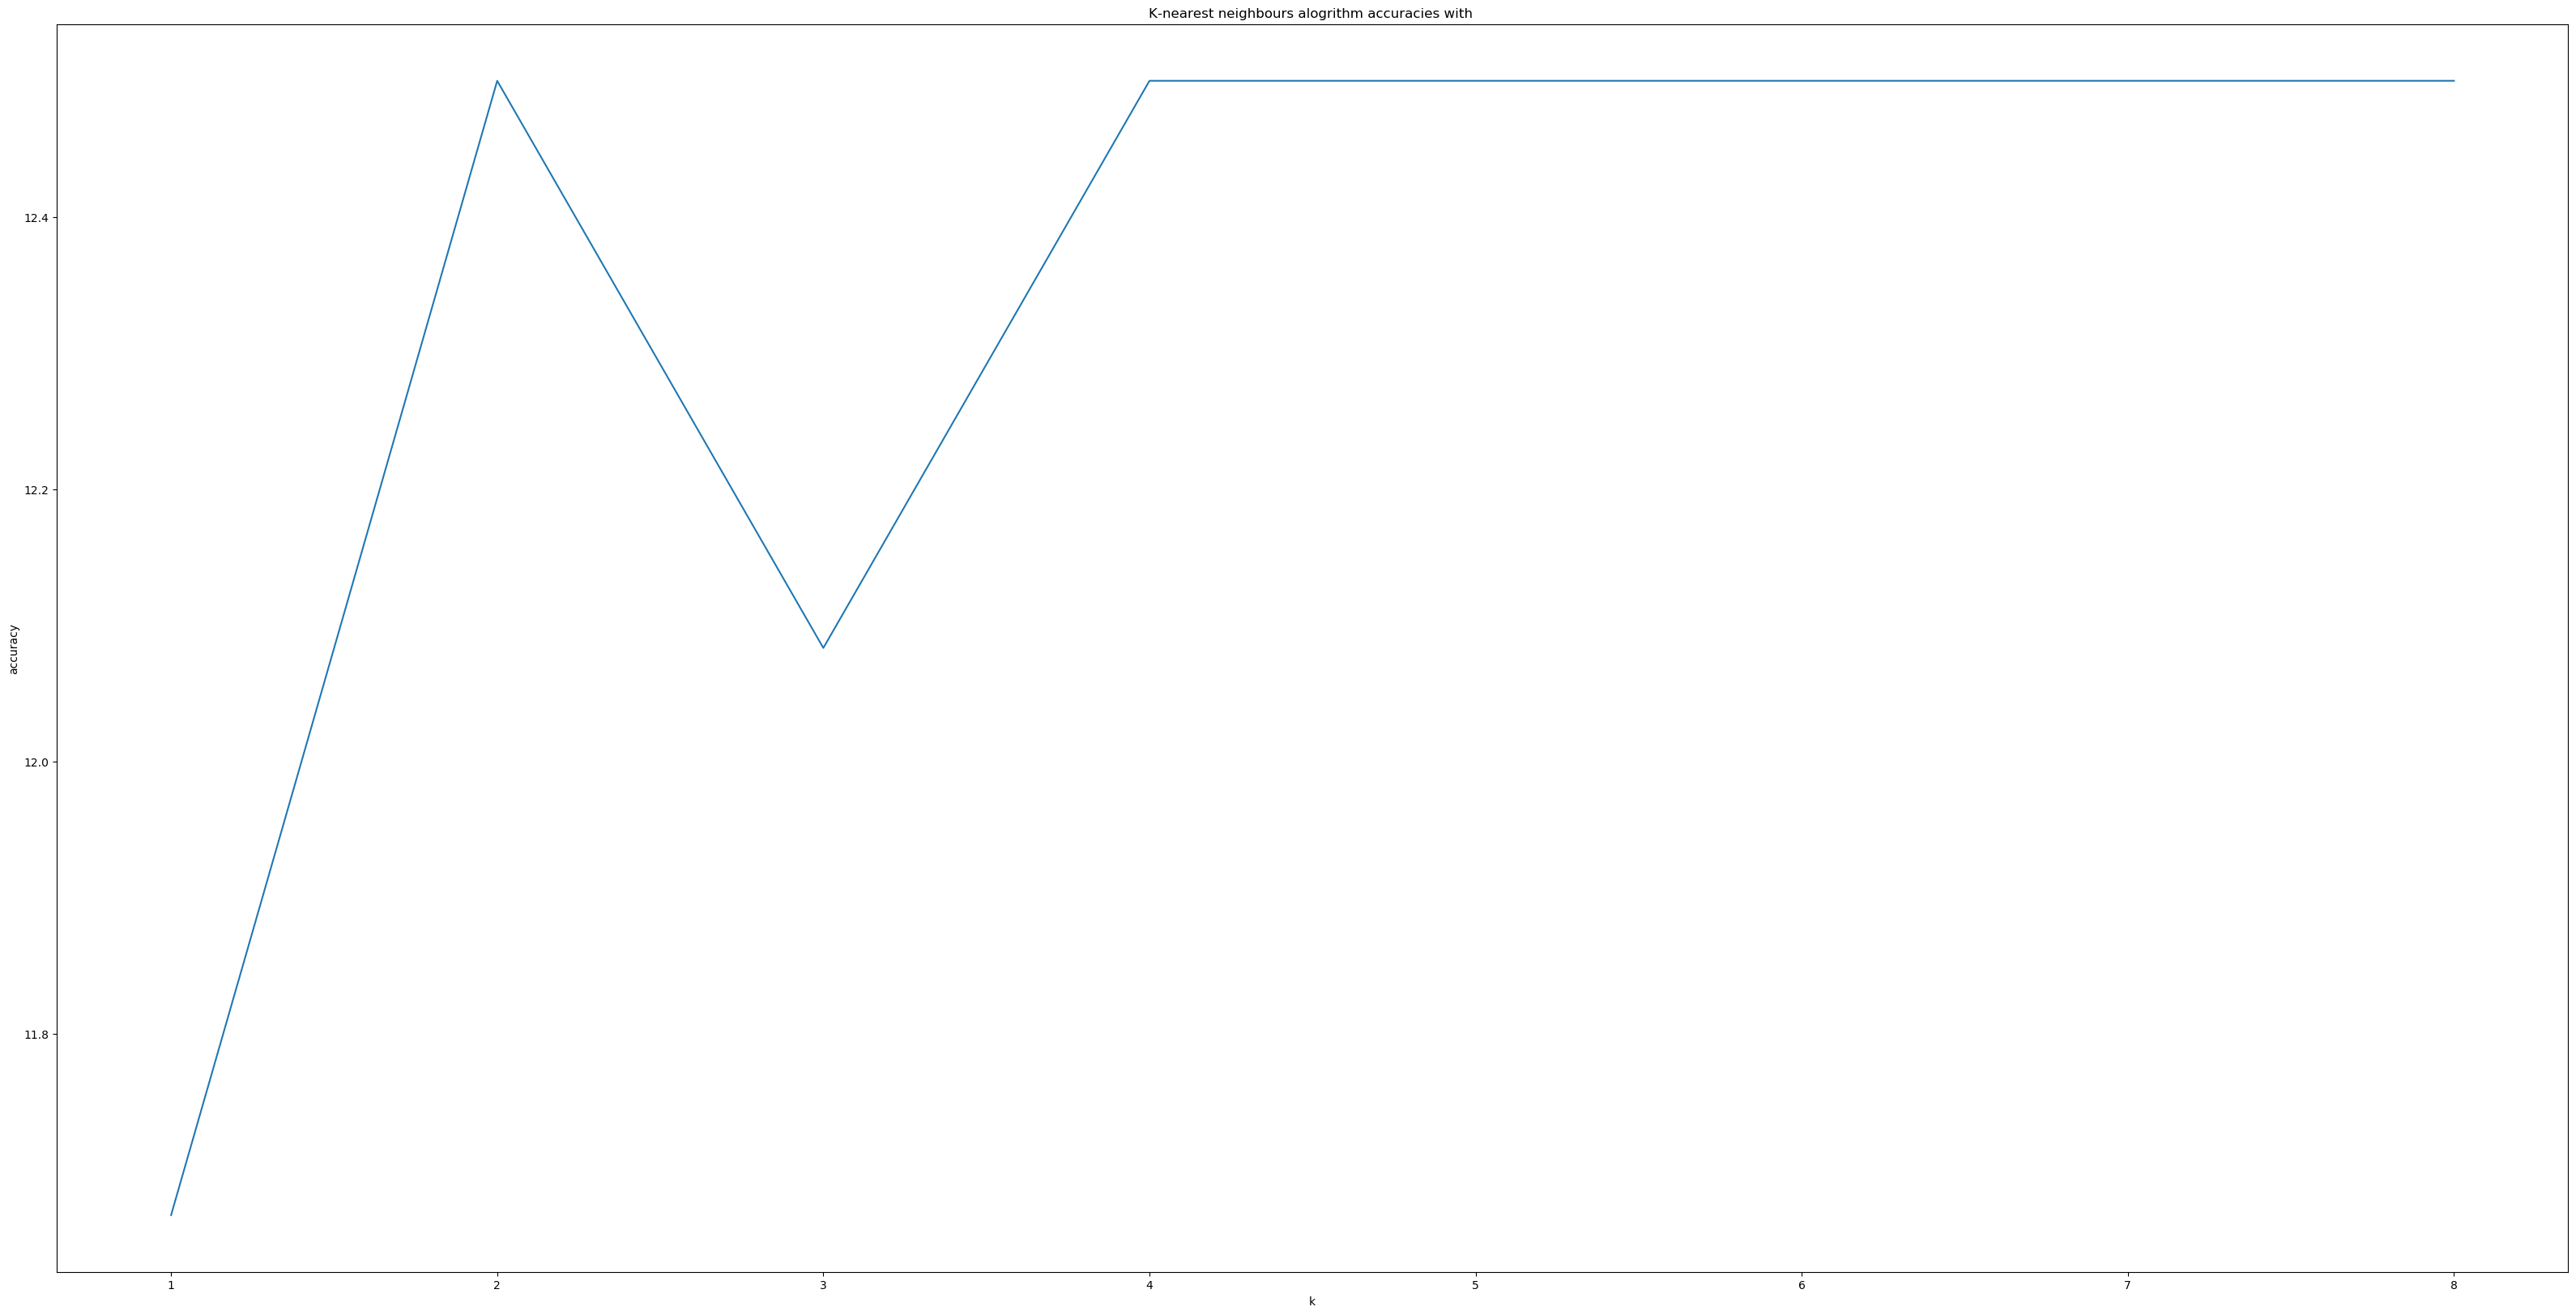

K-nearest neighbours algorithm accuracy: 12.5
0.05
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   0.1s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['e

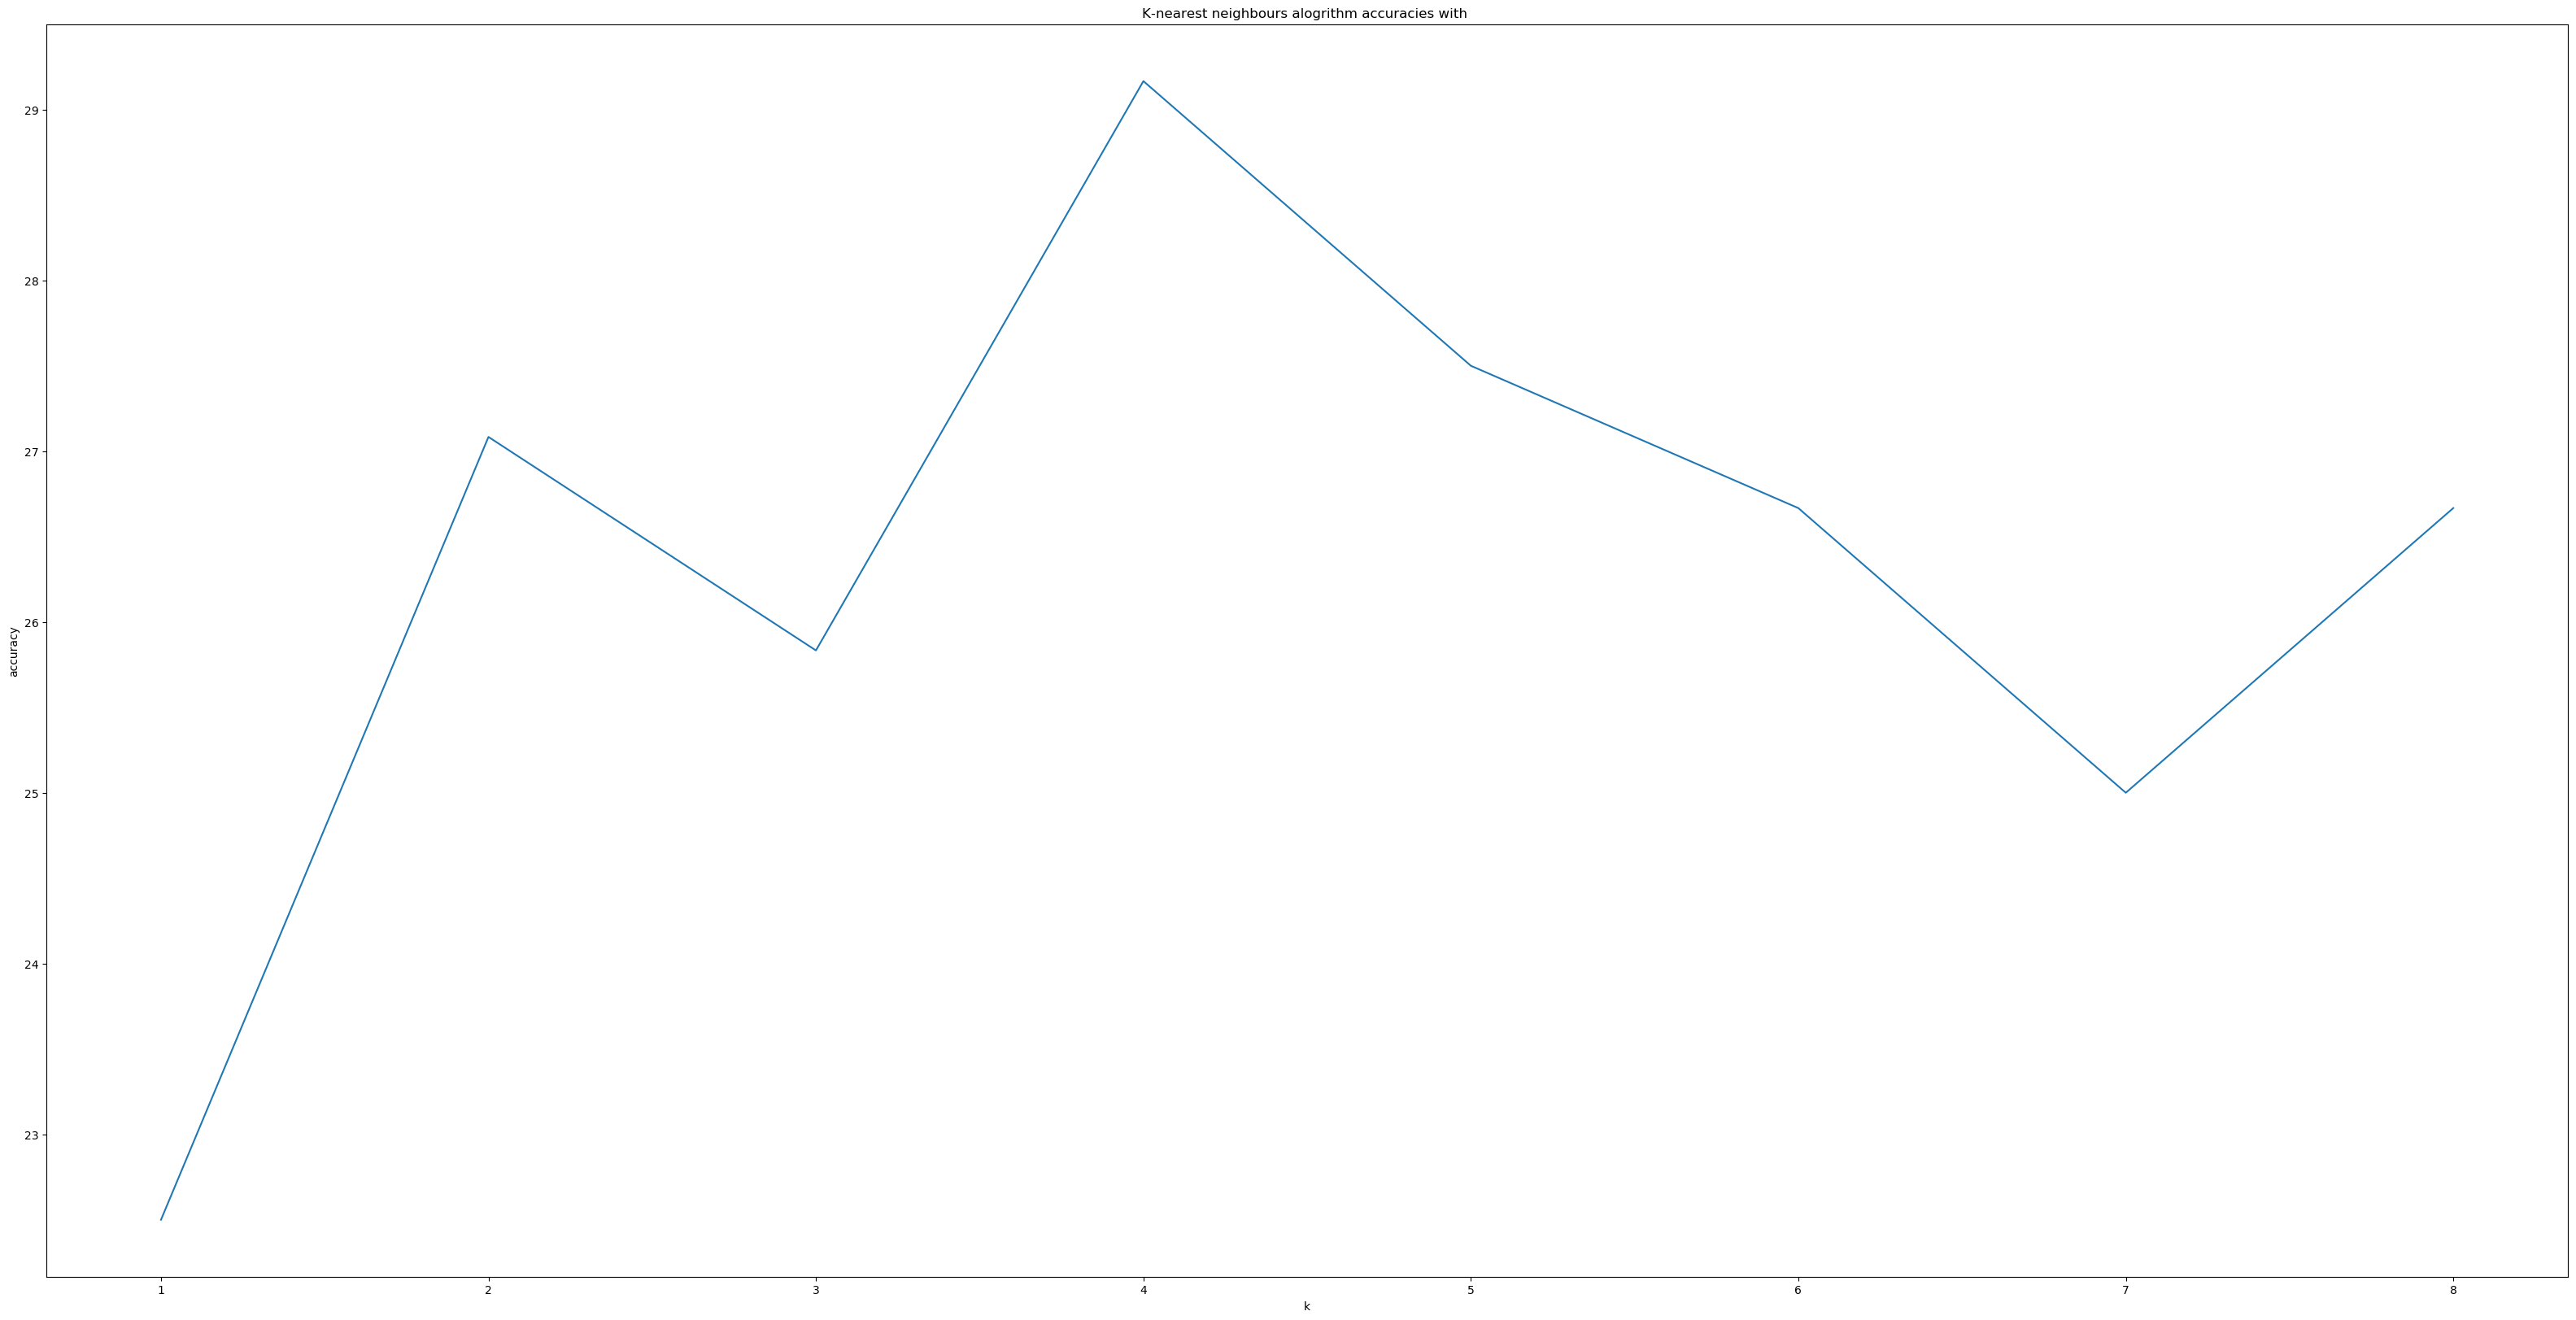

K-nearest neighbours algorithm accuracy: 29.166666666666668
0.1
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'cr

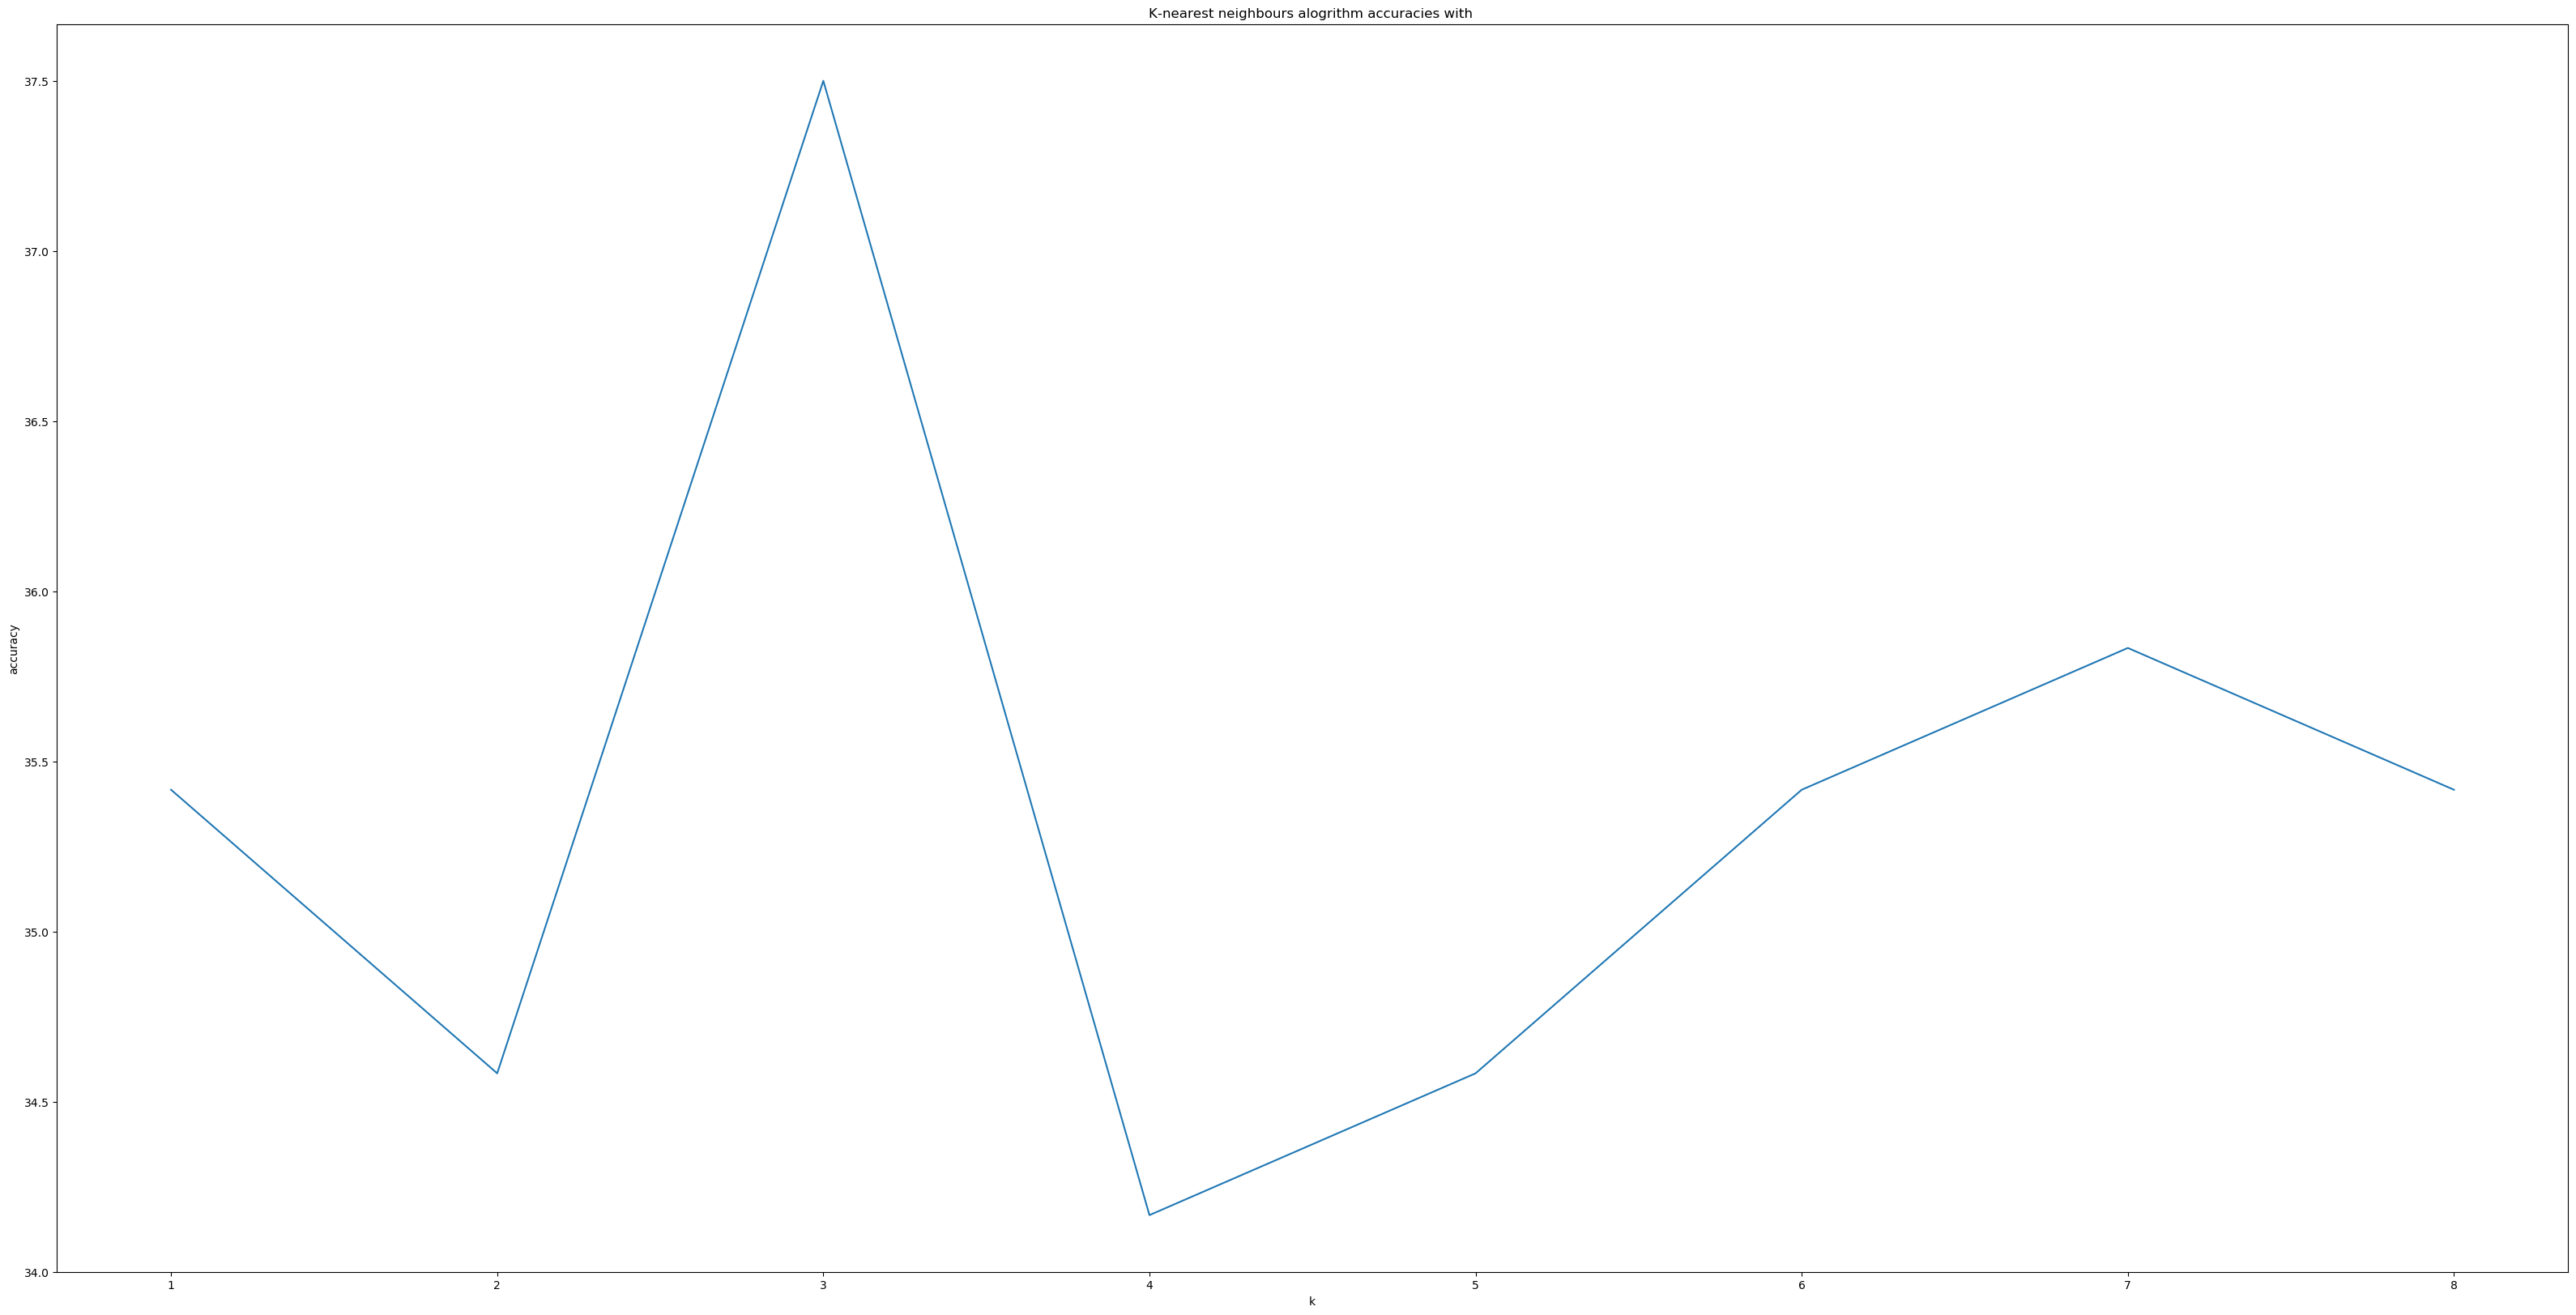

K-nearest neighbours algorithm accuracy: 37.5
0.3
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   0.6s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   0.9s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   0.6s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   0.9s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.6s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   0.9s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['en

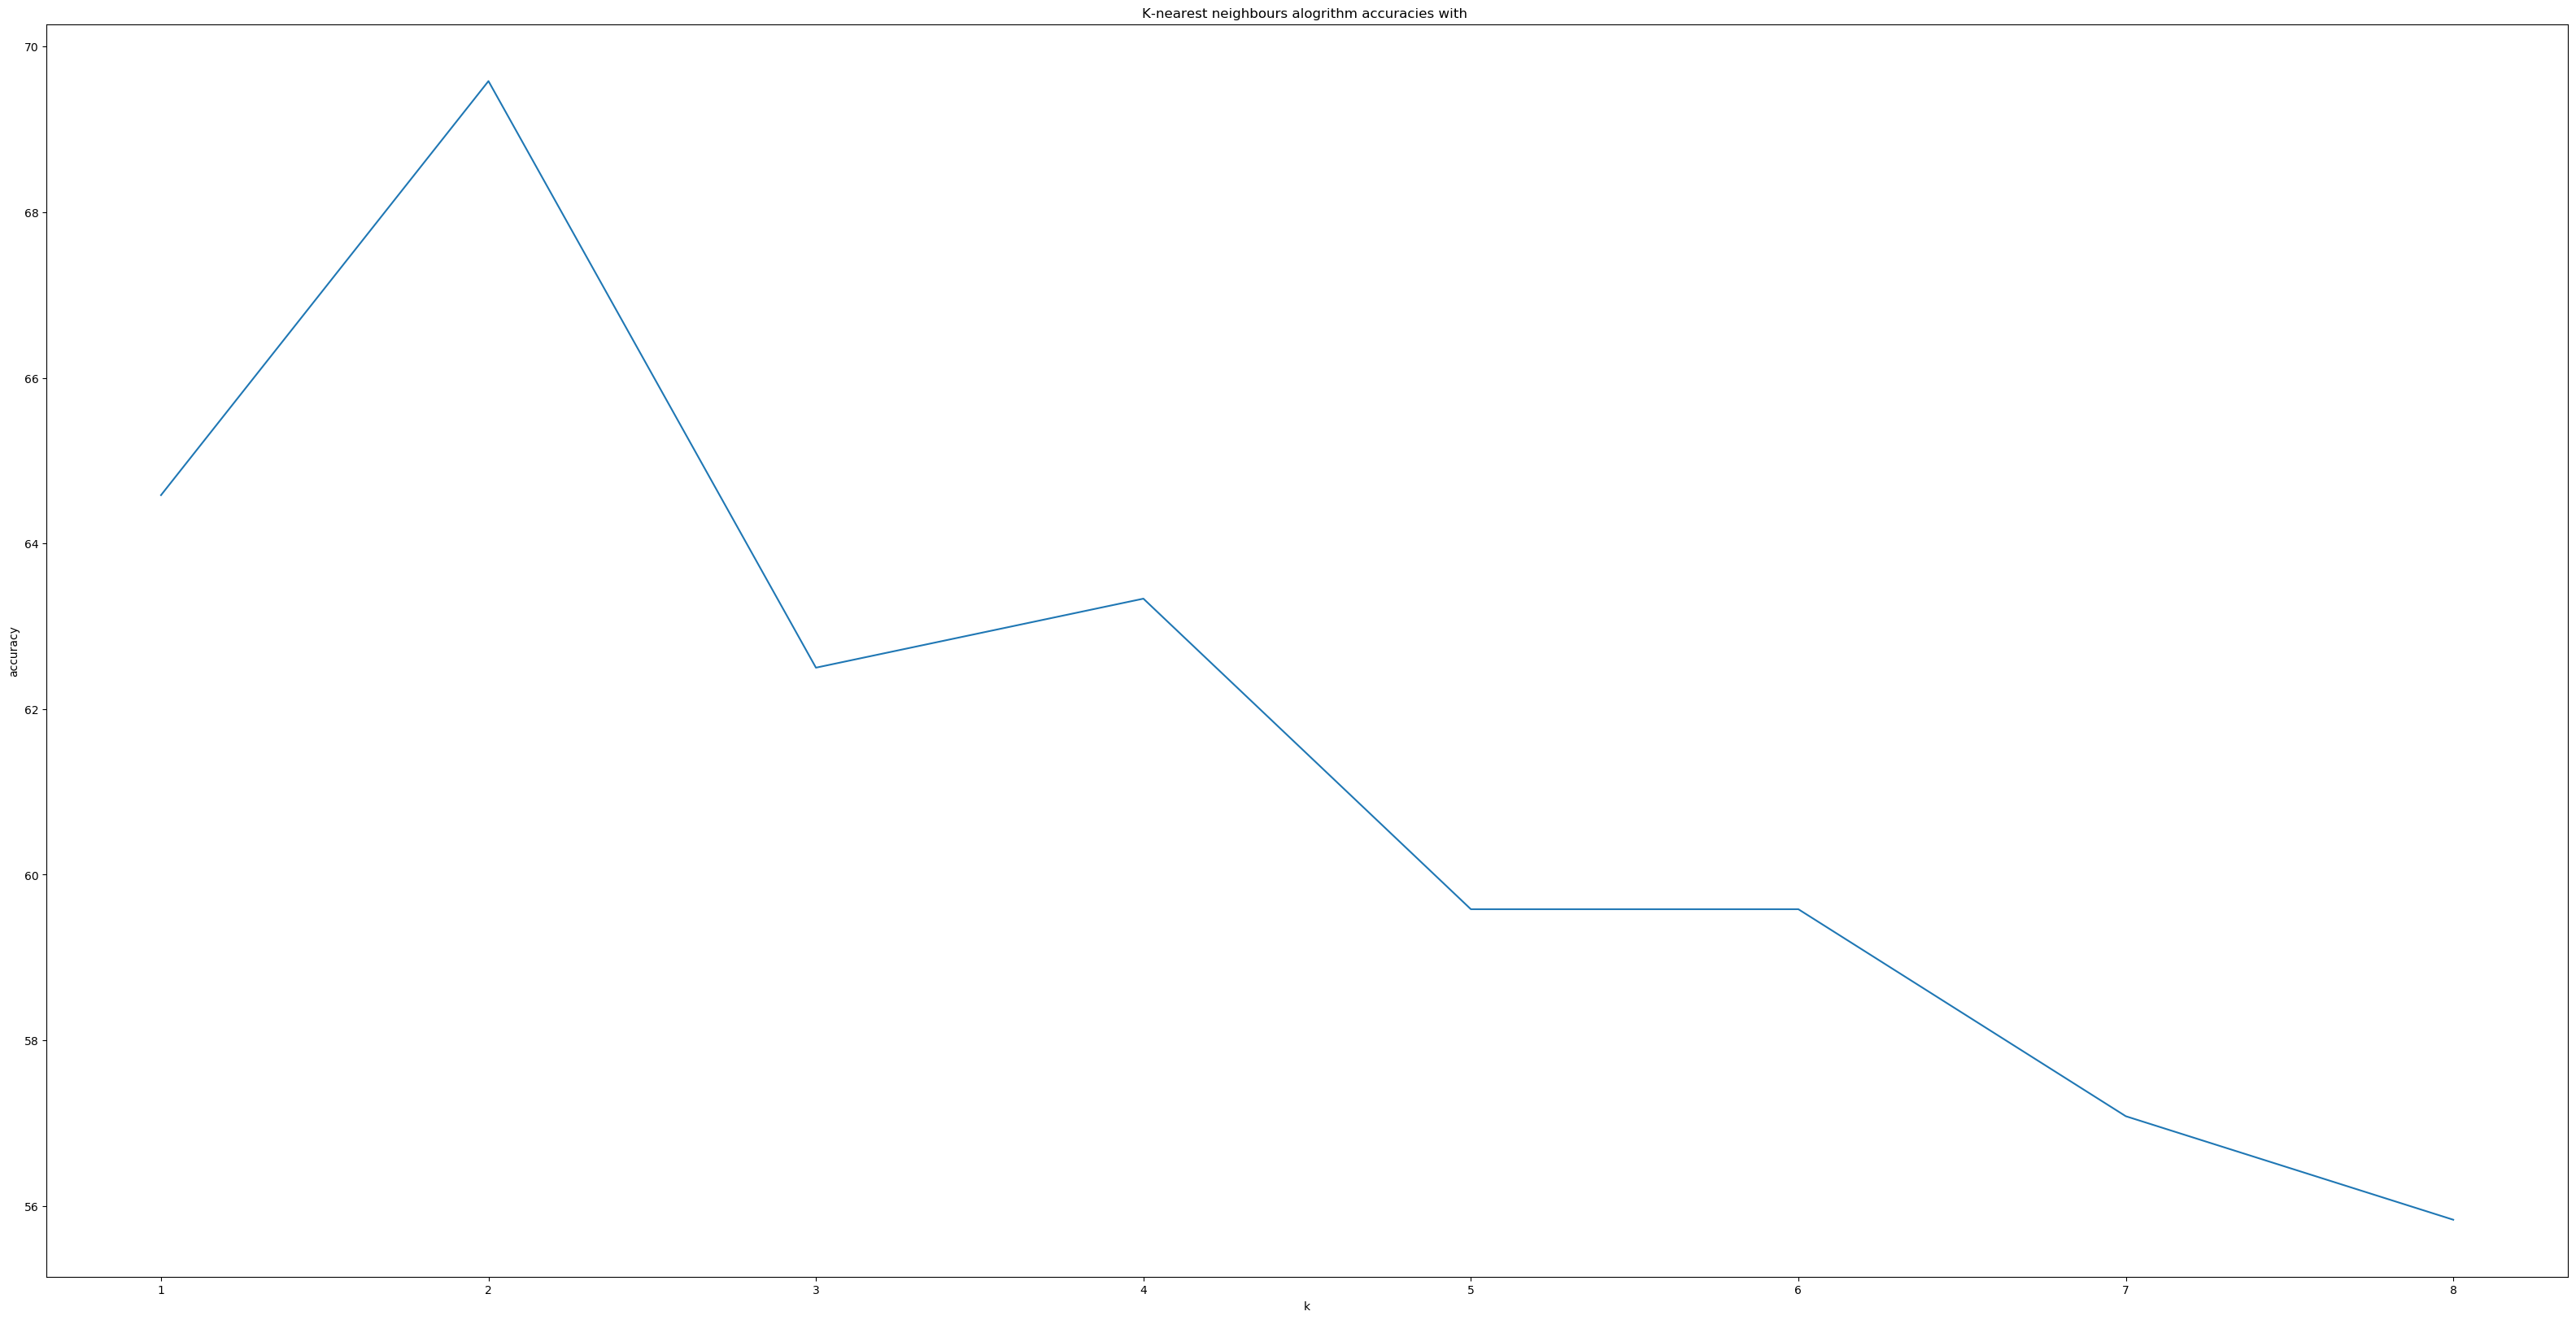

K-nearest neighbours algorithm accuracy: 69.58333333333333
0.5
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   1.0s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   1.4s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   1.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   1.4s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   1.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   1.4s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'cri

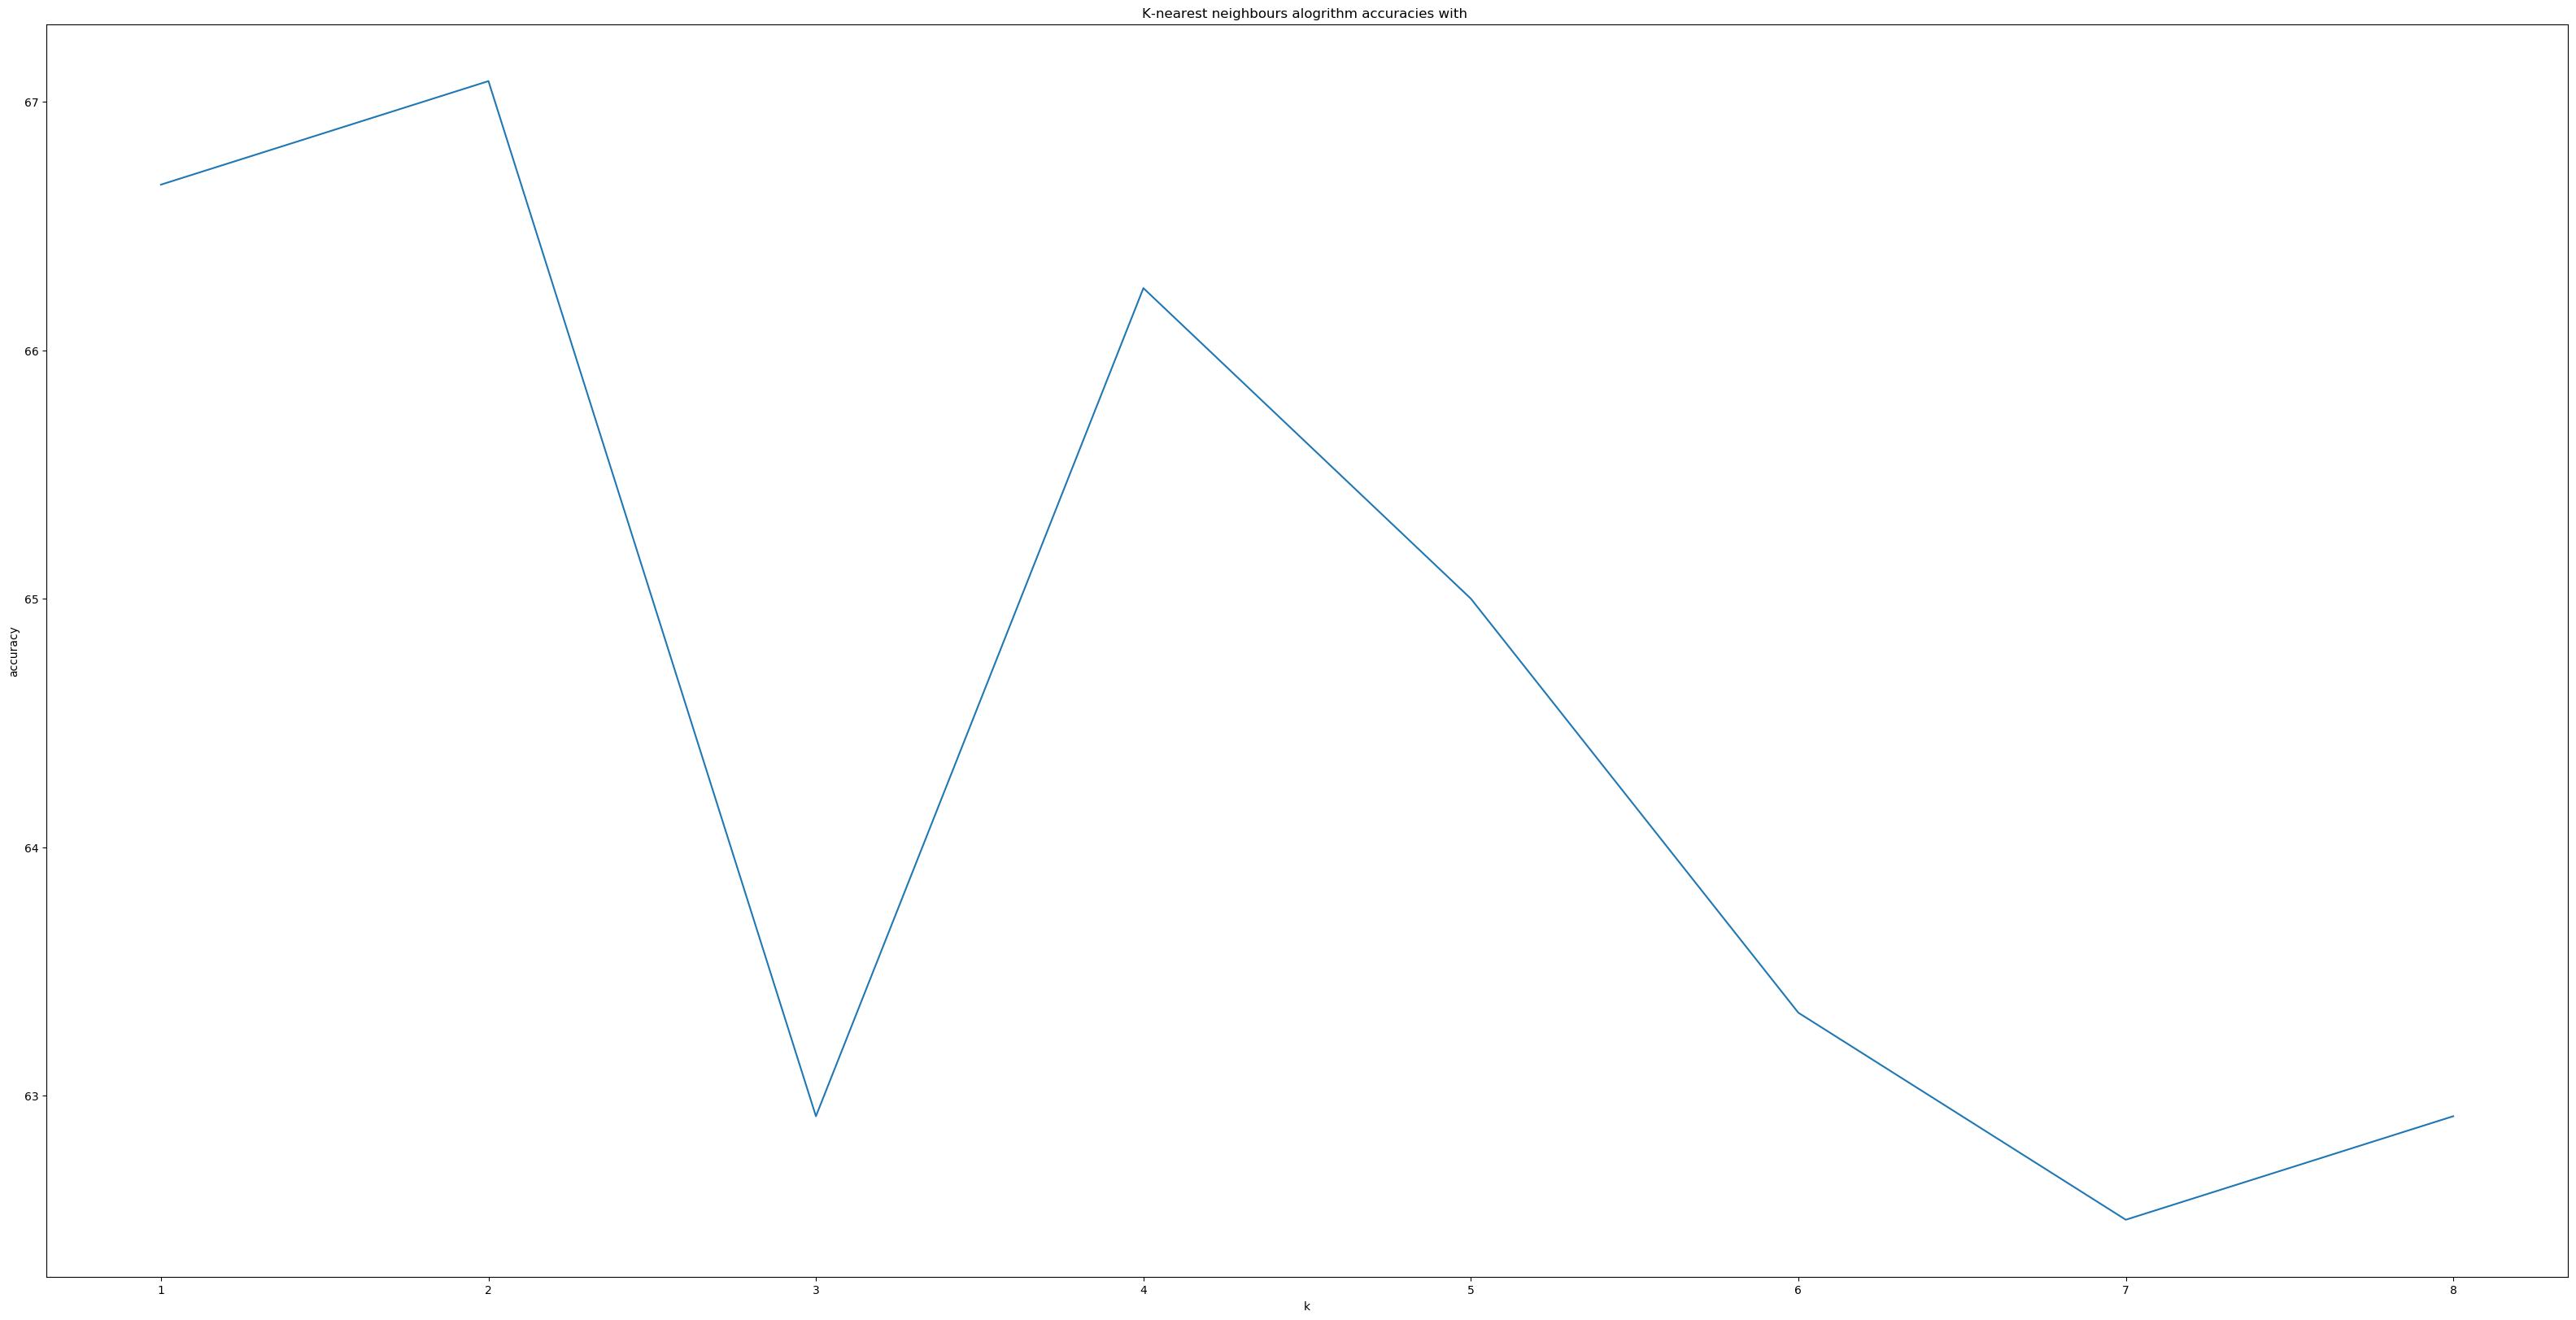

K-nearest neighbours algorithm accuracy: 67.08333333333333
0.7
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   1.3s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   2.0s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   1.3s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   1.9s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   1.3s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   2.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'cri

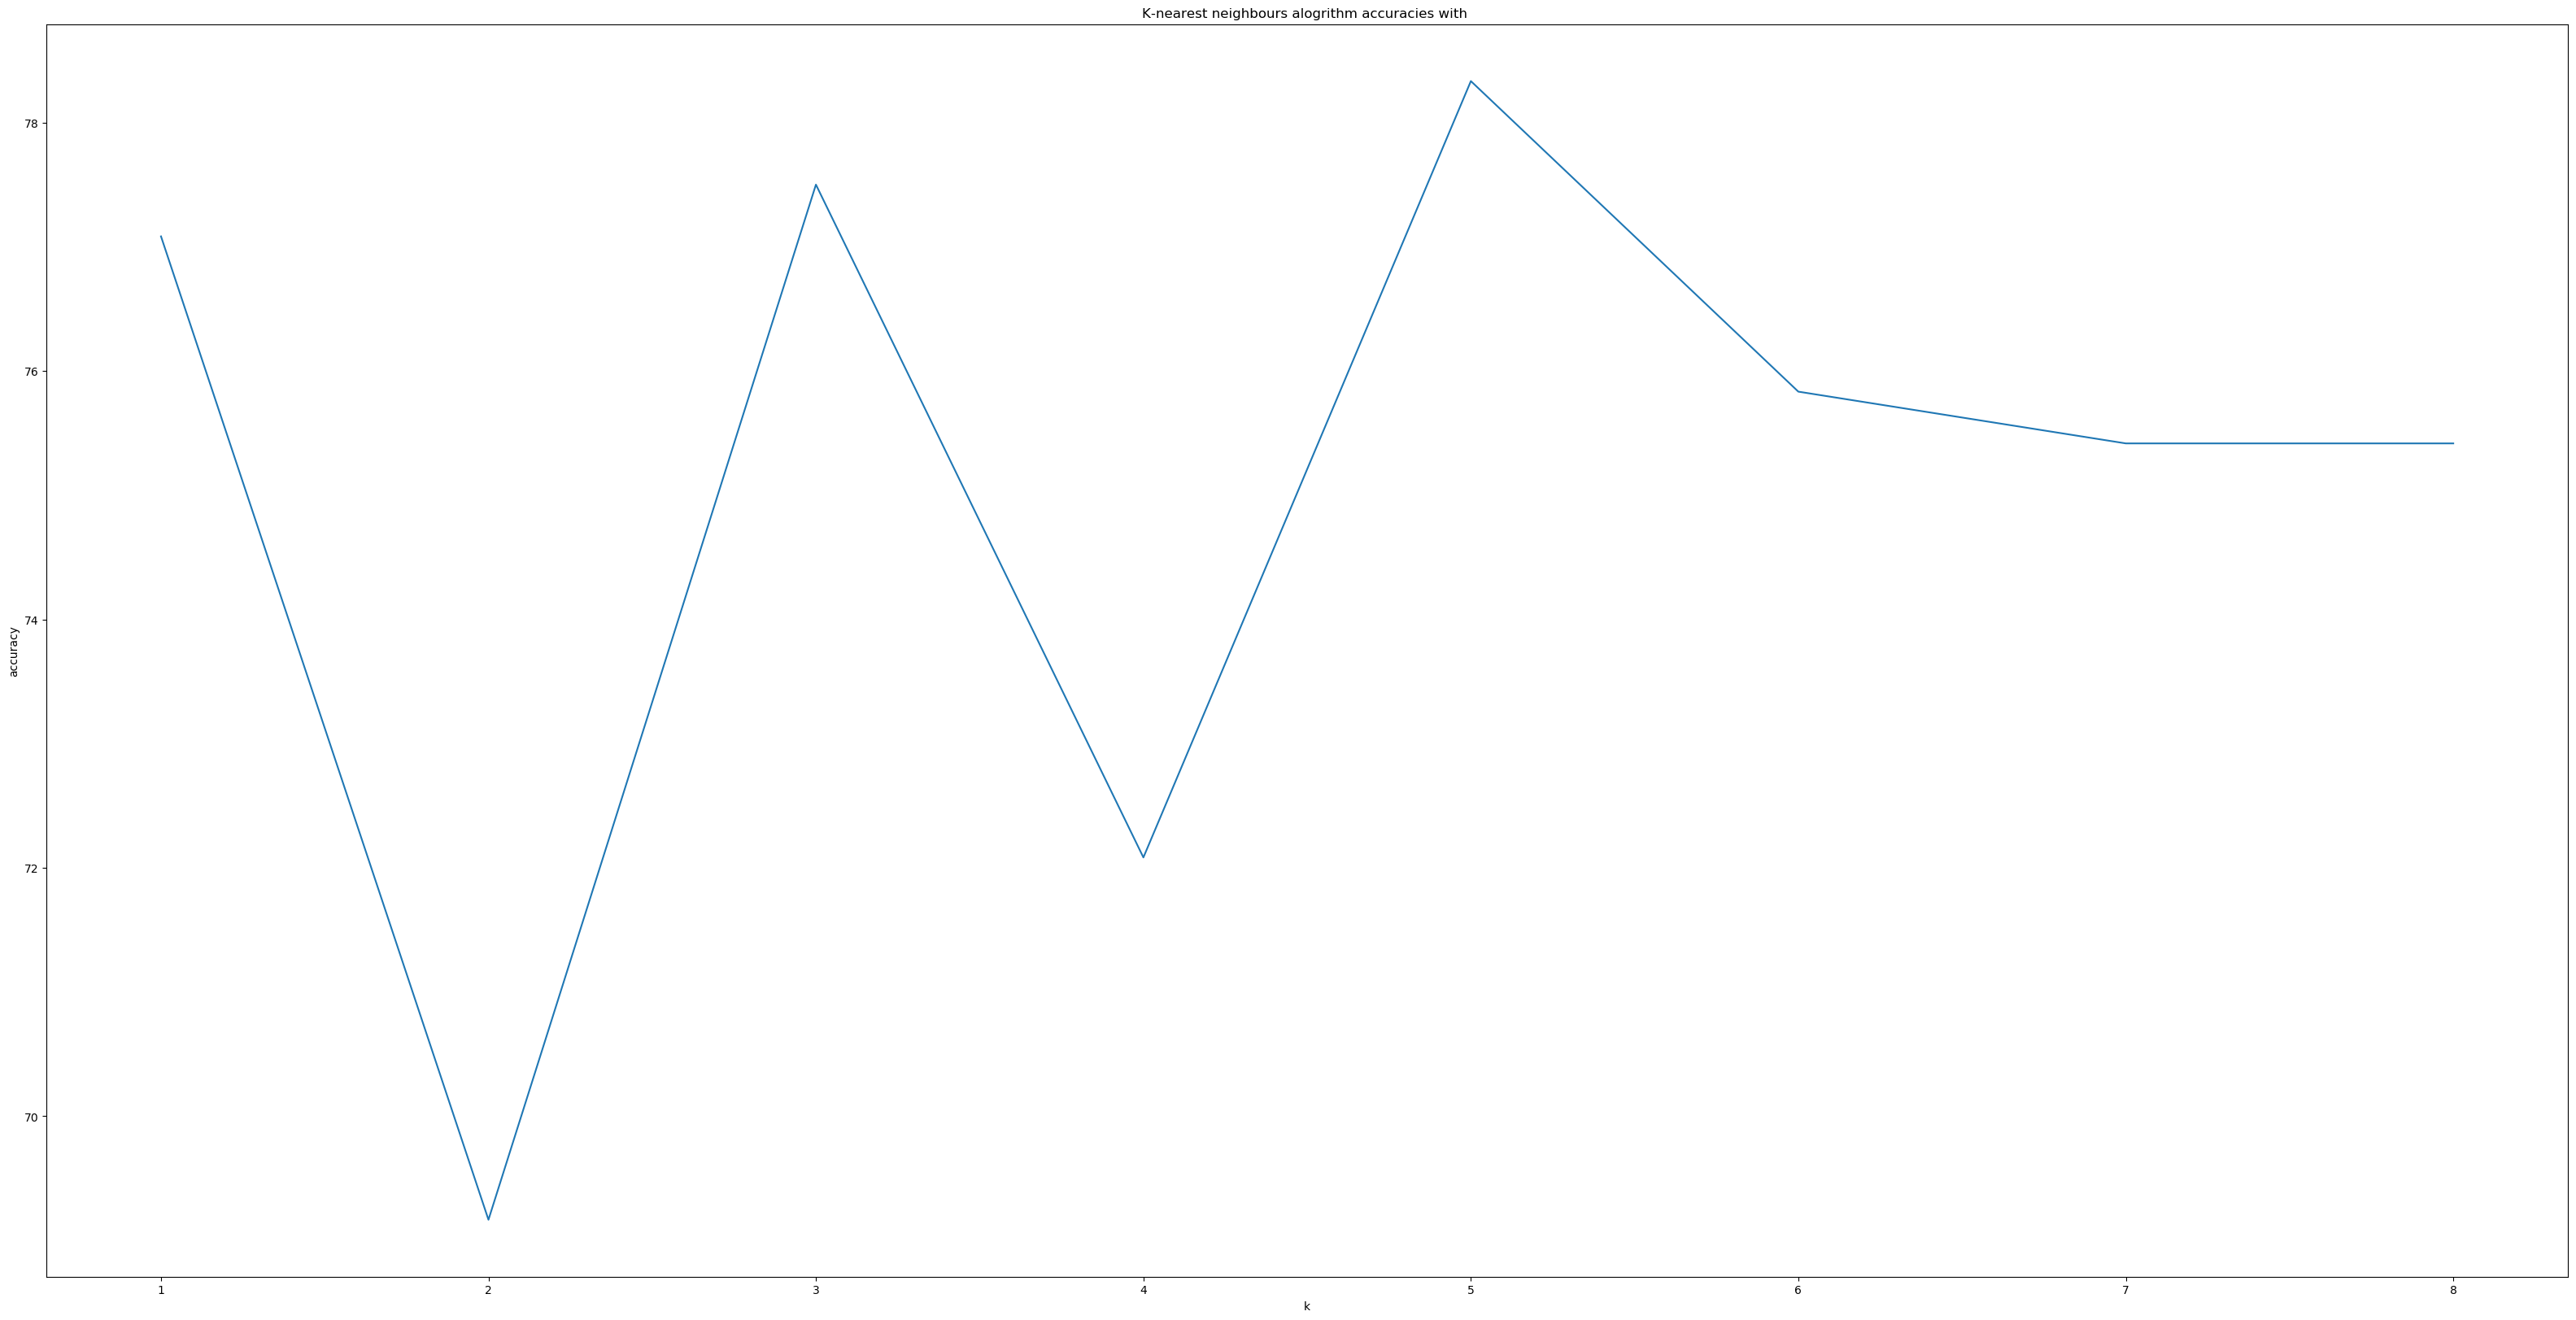

K-nearest neighbours algorithm accuracy: 78.33333333333333
0.9
Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] END ...criterion=entropy, max_depth=10, max_features=10; total time=   1.8s
[CV] END ...criterion=entropy, max_depth=10, max_features=15; total time=   2.6s
[CV] END ...criterion=entropy, max_depth=10, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   1.8s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   2.6s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.0s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   1.8s
[CV] END ...criterion=entropy, max_depth=15, max_features=15; total time=   2.6s
[CV] END ...criterion=entropy, max_depth=15, max_features=20; total time=   0.0s
GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=RandomForestClassifier(),
             param_grid=[{'cri

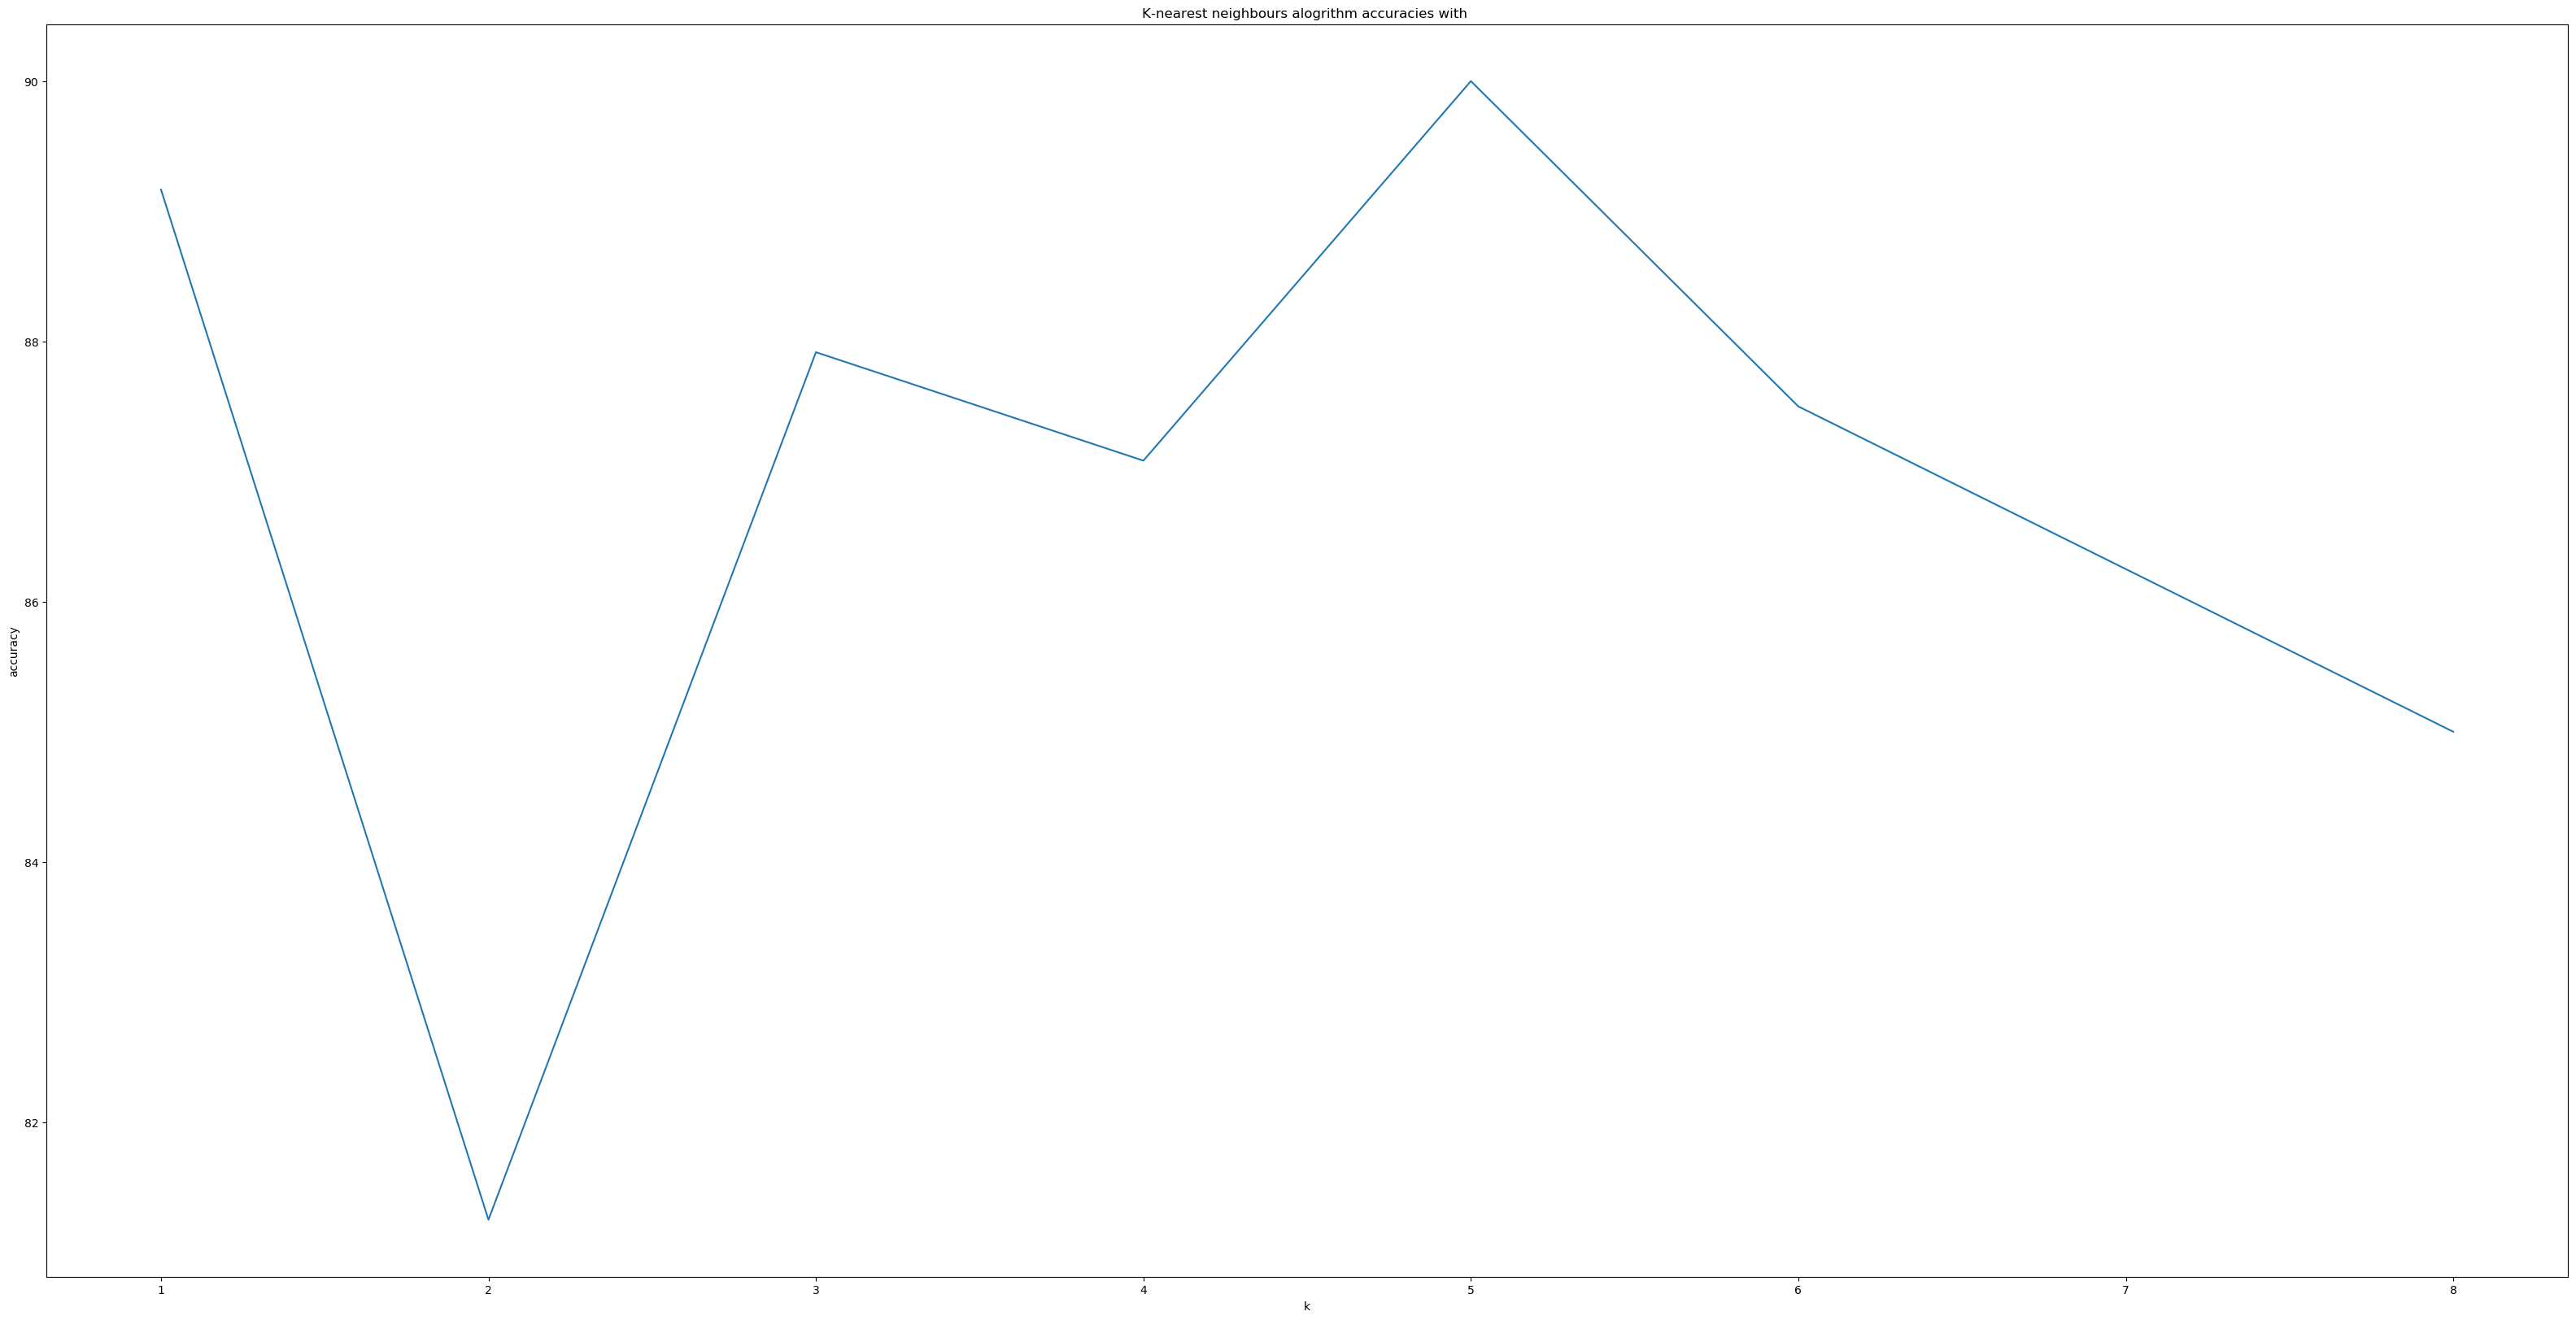

K-nearest neighbours algorithm accuracy: 90.0


In [228]:
partitions = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]
prediction_accs = []

for labeled_percentage in partitions:
    print(labeled_percentage)
    partial_df, partial_locations, partial_df_rest, partial_rest_loc = prep_data_for_synthesis(alpha_filtered2_train, labeled_percentage)
    latent_data = encoder.predict(min_max_scaler.fit_transform(partial_df))
    latent_data = np.concatenate((latent_data[0], latent_data[2]), axis=1)
    latent_test_data = encoder.predict(min_max_scaler.fit_transform(partial_df_rest))
    latent_test_data = np.concatenate((latent_test_data[0], latent_test_data[2]), axis=1)
    
    rfc_semi2 = RandomForestClassifier()
    forest_semi_params = [{'criterion': ["entropy"], 'max_depth':[10,12,15], 'max_features': [10,15,20]}]
    semi_clf2 = GridSearchCV(rfc_semi2, forest_semi_params,cv = [(slice(None), slice(None))], scoring='accuracy',refit=True,verbose=2)
    print(semi_clf2.fit(latent_data, partial_locations))
    unlabeled_data_labels = semi_clf2.predict(latent_test_data)
#     rfc_semi2 = RandomForestClassifier(criterion='entropy', max_depth=11, max_features=5)
#     print(rfc_semi2.fit(latent_data, partial_locations))
#     unlabeled_data_labels = rfc_semi2.predict(latent_test_data)
       
    frames = [partial_df, partial_df_rest]
    partial_combined = pd.concat(frames)
    
    frames = [partial_locations, pd.DataFrame(unlabeled_data_labels, columns = ['location'])]
    partial_combined_labels = pd.concat(frames)
    k_nearest_neighbours(partial_combined, partial_combined_labels, alpha_filtered2_test.loc[:, no_channel_training_cols],alpha_filtered2_test.loc[:, 'location'], "")
    partial_preds,runtime = run_knn(partial_combined, partial_combined_labels, alpha_filtered2_test.loc[:, no_channel_training_cols],[],5)
    
#     rfc_semi_part = RandomForestClassifier()
#     forest_semi_params = [{'criterion': ["entropy"], 'max_depth':[10,12,15,20], 'max_features': [4,5,8]}]
#     semi_clf = GridSearchCV(rfc_semi_part, forest_semi_params, cv = 3, scoring='accuracy',refit=True,verbose=2)
#     print(semi_clf.fit(partial_combined, partial_combined_labels))

#     partial_preds = semi_clf.predict(alpha_filtered2_test.loc[:, no_channel_training_cols])
    prediction_accs.append(accuracy_score(alpha_filtered2_test.loc[:, ['location']], partial_preds)*100)
    

In [229]:
prediction_accs

[12.5,
 27.500000000000004,
 34.583333333333336,
 59.583333333333336,
 65.0,
 78.33333333333333,
 90.0]

In [224]:
def plot_accs(original_accs, vae_accs, title):
    t = list(original_accs.keys())
    k = list(original_accs.values())
    k.reverse()

    f = vae_accs
    f.reverse()
    print(k)
    print(f)
    signals = [{'name': 'original_accuracies', 'x': t,
             'y': k, 'color':'orange', 'linewidth':6},
            {'name': 'Semi-supervised_accuracies', 'x': t,
             'y': f, 'color':'green', 'linewidth':6}]

    fig, ax = plt.subplots()
    for signal in signals:
        ax.plot(signal['x'], signal['y'], 
                color=signal['color'], 
                linewidth=signal['linewidth'],
                label=signal['name'])
    plt.rcParams['figure.figsize'] = [40, 20]
    ax.legend()
    ax.set_title(title)
    plt.show()

[90.41666666666667, 83.33333333333334, 81.66666666666667, 72.08333333333333, 28.333333333333332, 5.0, 2.083333333333333]
[90.0, 78.33333333333333, 65.0, 59.583333333333336, 34.583333333333336, 27.500000000000004, 12.5]


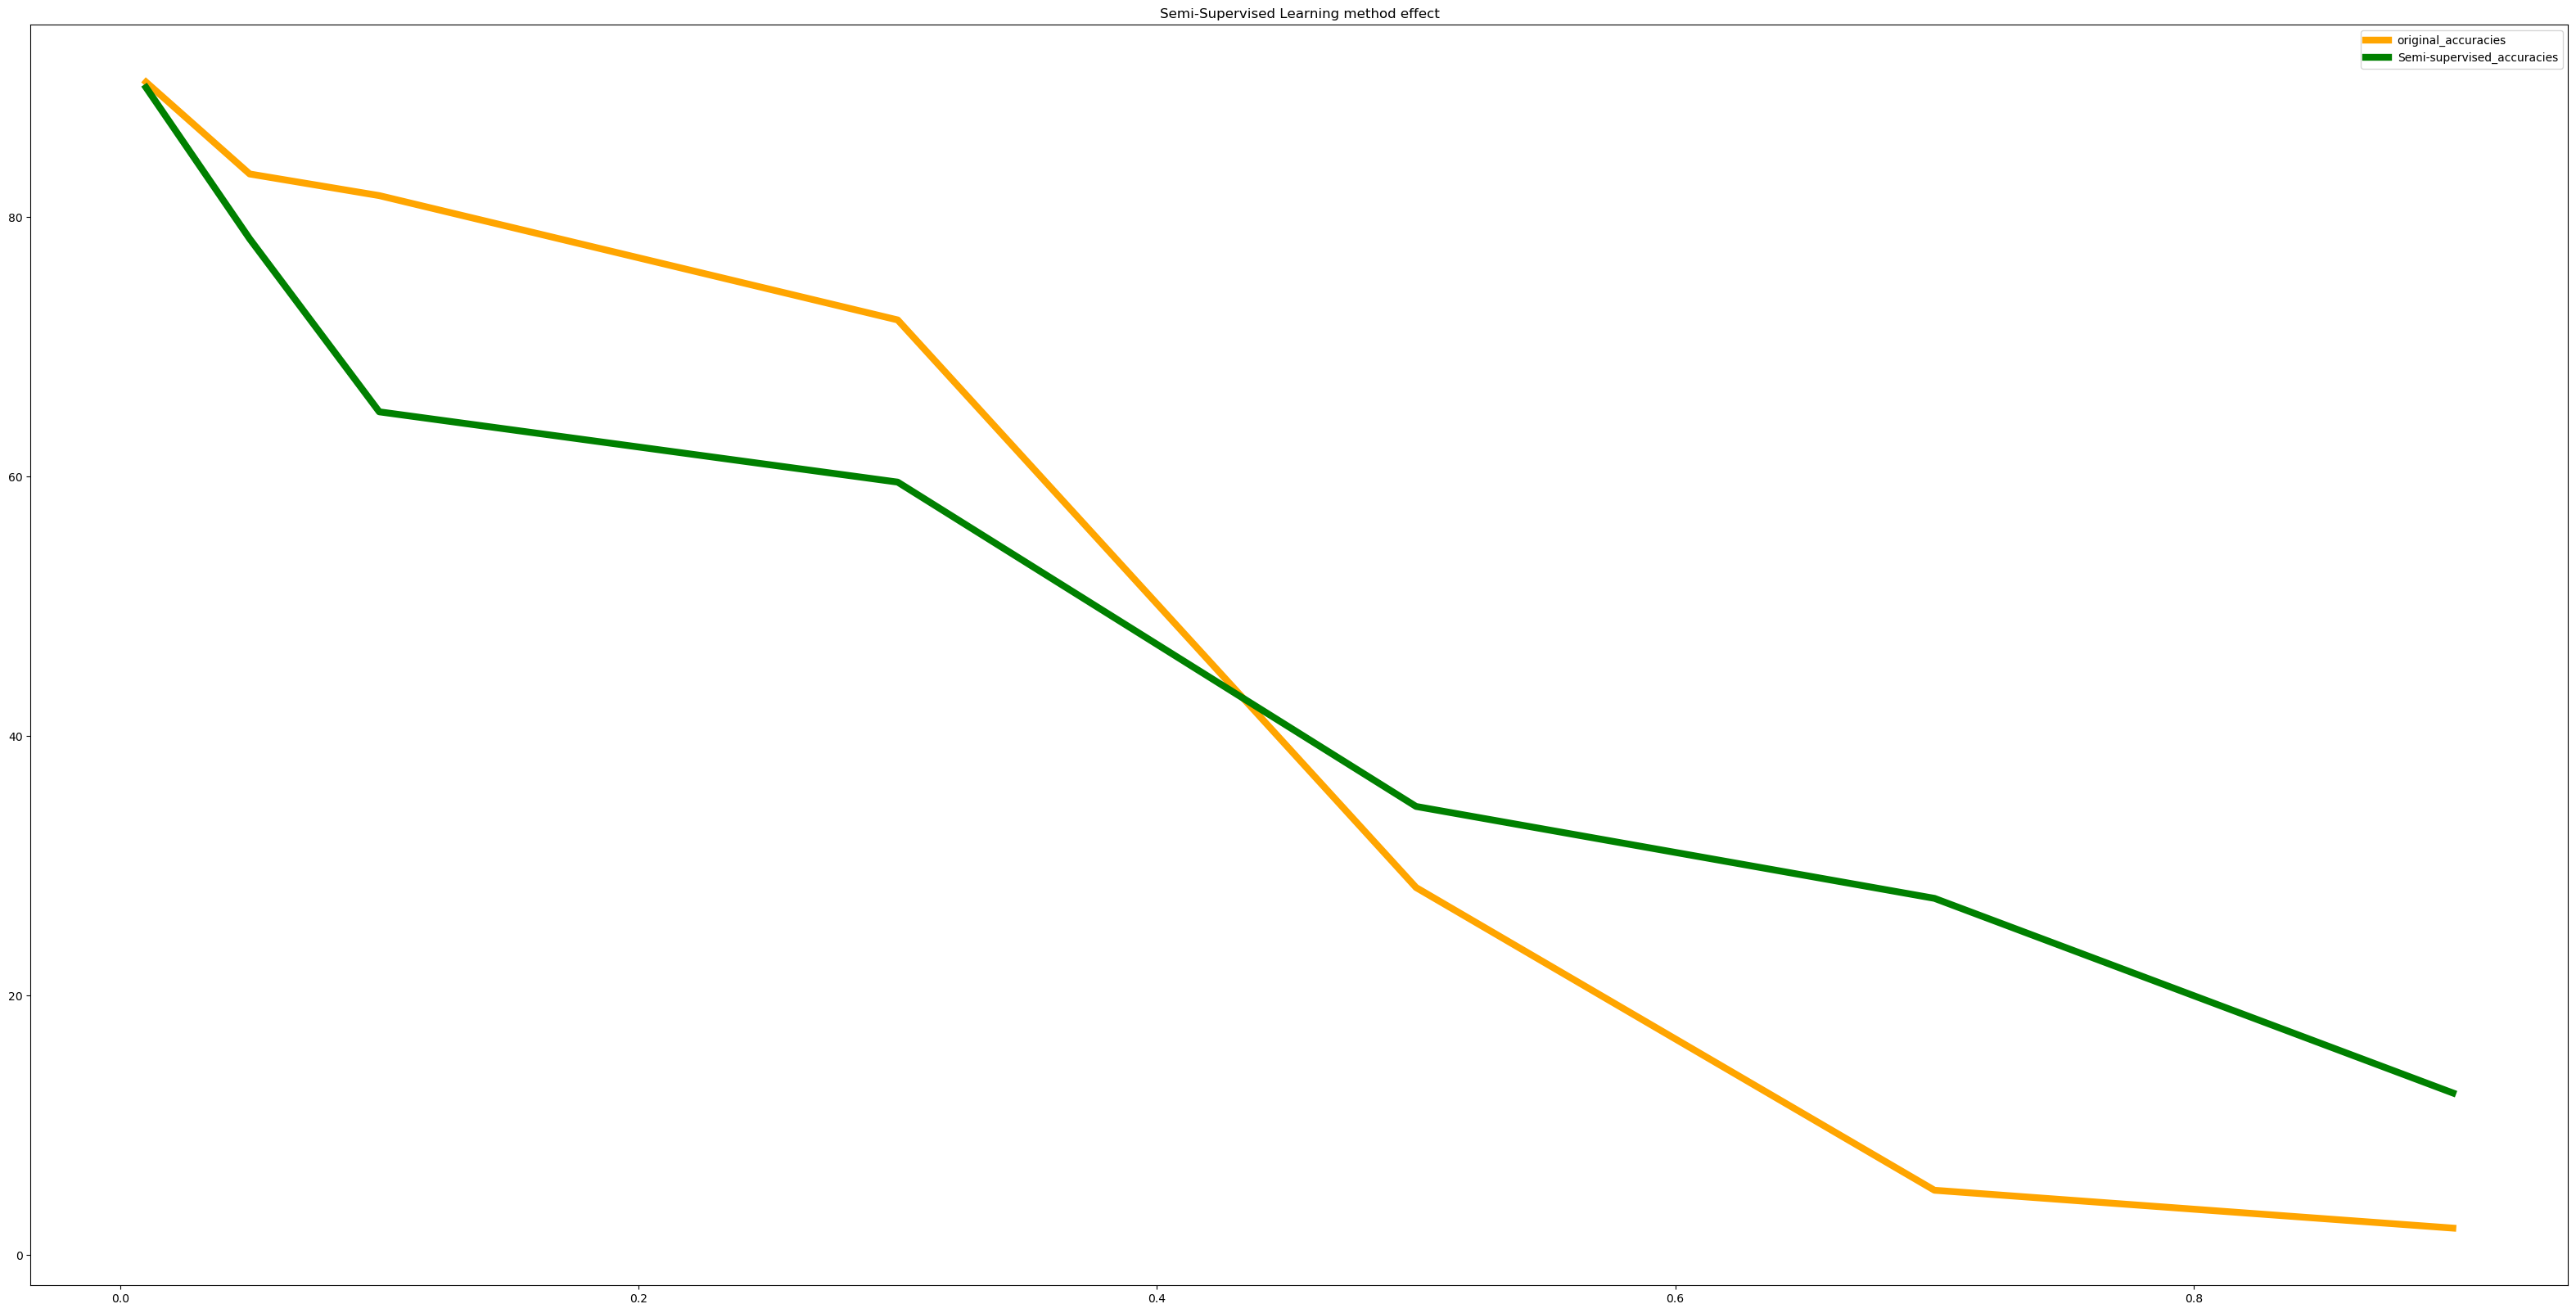

In [230]:
plot_accs(original_accs2, prediction_accs,"Semi-Supervised Learning method effect")

## Using Synthesized Data

In [252]:
one_ten_df, one_ten_locations, one_ten_df_test, one_ten__test_loc = prep_data_for_synthesis(alpha_filtered2_train, 0.25)


In [254]:
data_shape2 = (20,)
latent_dim2 = 8
input_layer2 = keras.Input(shape=data_shape2)
x2 = keras.layers.Dense(15, activation ='relu')(input_layer2)
x2 = keras.layers.Dense(10, activation ='relu')(x2)
means2 = keras.layers.Dense(latent_dim2)(x2)
log_var2 = keras.layers.Dense(latent_dim2)(x2)

z2 = Lambda(sample, output_shape = (latent_dim2, ))([means2, log_var2])

encoder2 = keras.models.Model(input_layer2, [means2, log_var2, z2])
    
decoder_input2 = keras.layers.Input(shape =(latent_dim2,))
x2 = keras.layers.Dense(10, activation ='relu')(decoder_input2)
x2 = keras.layers.Dense(15, activation ='relu')(x2)
outputs2 = keras.layers.Dense(20, activation ='sigmoid')(x2)
decoder2 = keras.models.Model(decoder_input2, outputs2)
x_prime2 = decoder2(z2)
outputs2 = decoder2(encoder2(input_layer2)[2])
vae2 = keras.models.Model(input_layer2, outputs2, name='vae2')    
vae2.compile(loss=my_loss,optimizer="adam",metrics=["accuracy"])
print(vae2.summary())
min_max_scaler.fit_transform(one_ten_df).shape

his2 = vae2.fit(min_max_scaler.fit_transform(one_ten_df), min_max_scaler.fit_transform(one_ten_df) , epochs = 200, batch_size = 8, validation_split= 0.2)



Model: "vae2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_91 (InputLayer)        (None, 20)                0         
_________________________________________________________________
model_91 (Model)             [(None, 8), (None, 8), (N 651       
_________________________________________________________________
model_92 (Model)             (None, 20)                575       
Total params: 1,226
Trainable params: 1,226
Non-trainable params: 0
_________________________________________________________________
None
Train on 192 samples, validate on 48 samples
Epoch 1/200


InvalidArgumentError: You must feed a value for placeholder tensor 'input_65' with dtype float and shape [?,20]
	 [[{{node input_65}}]]

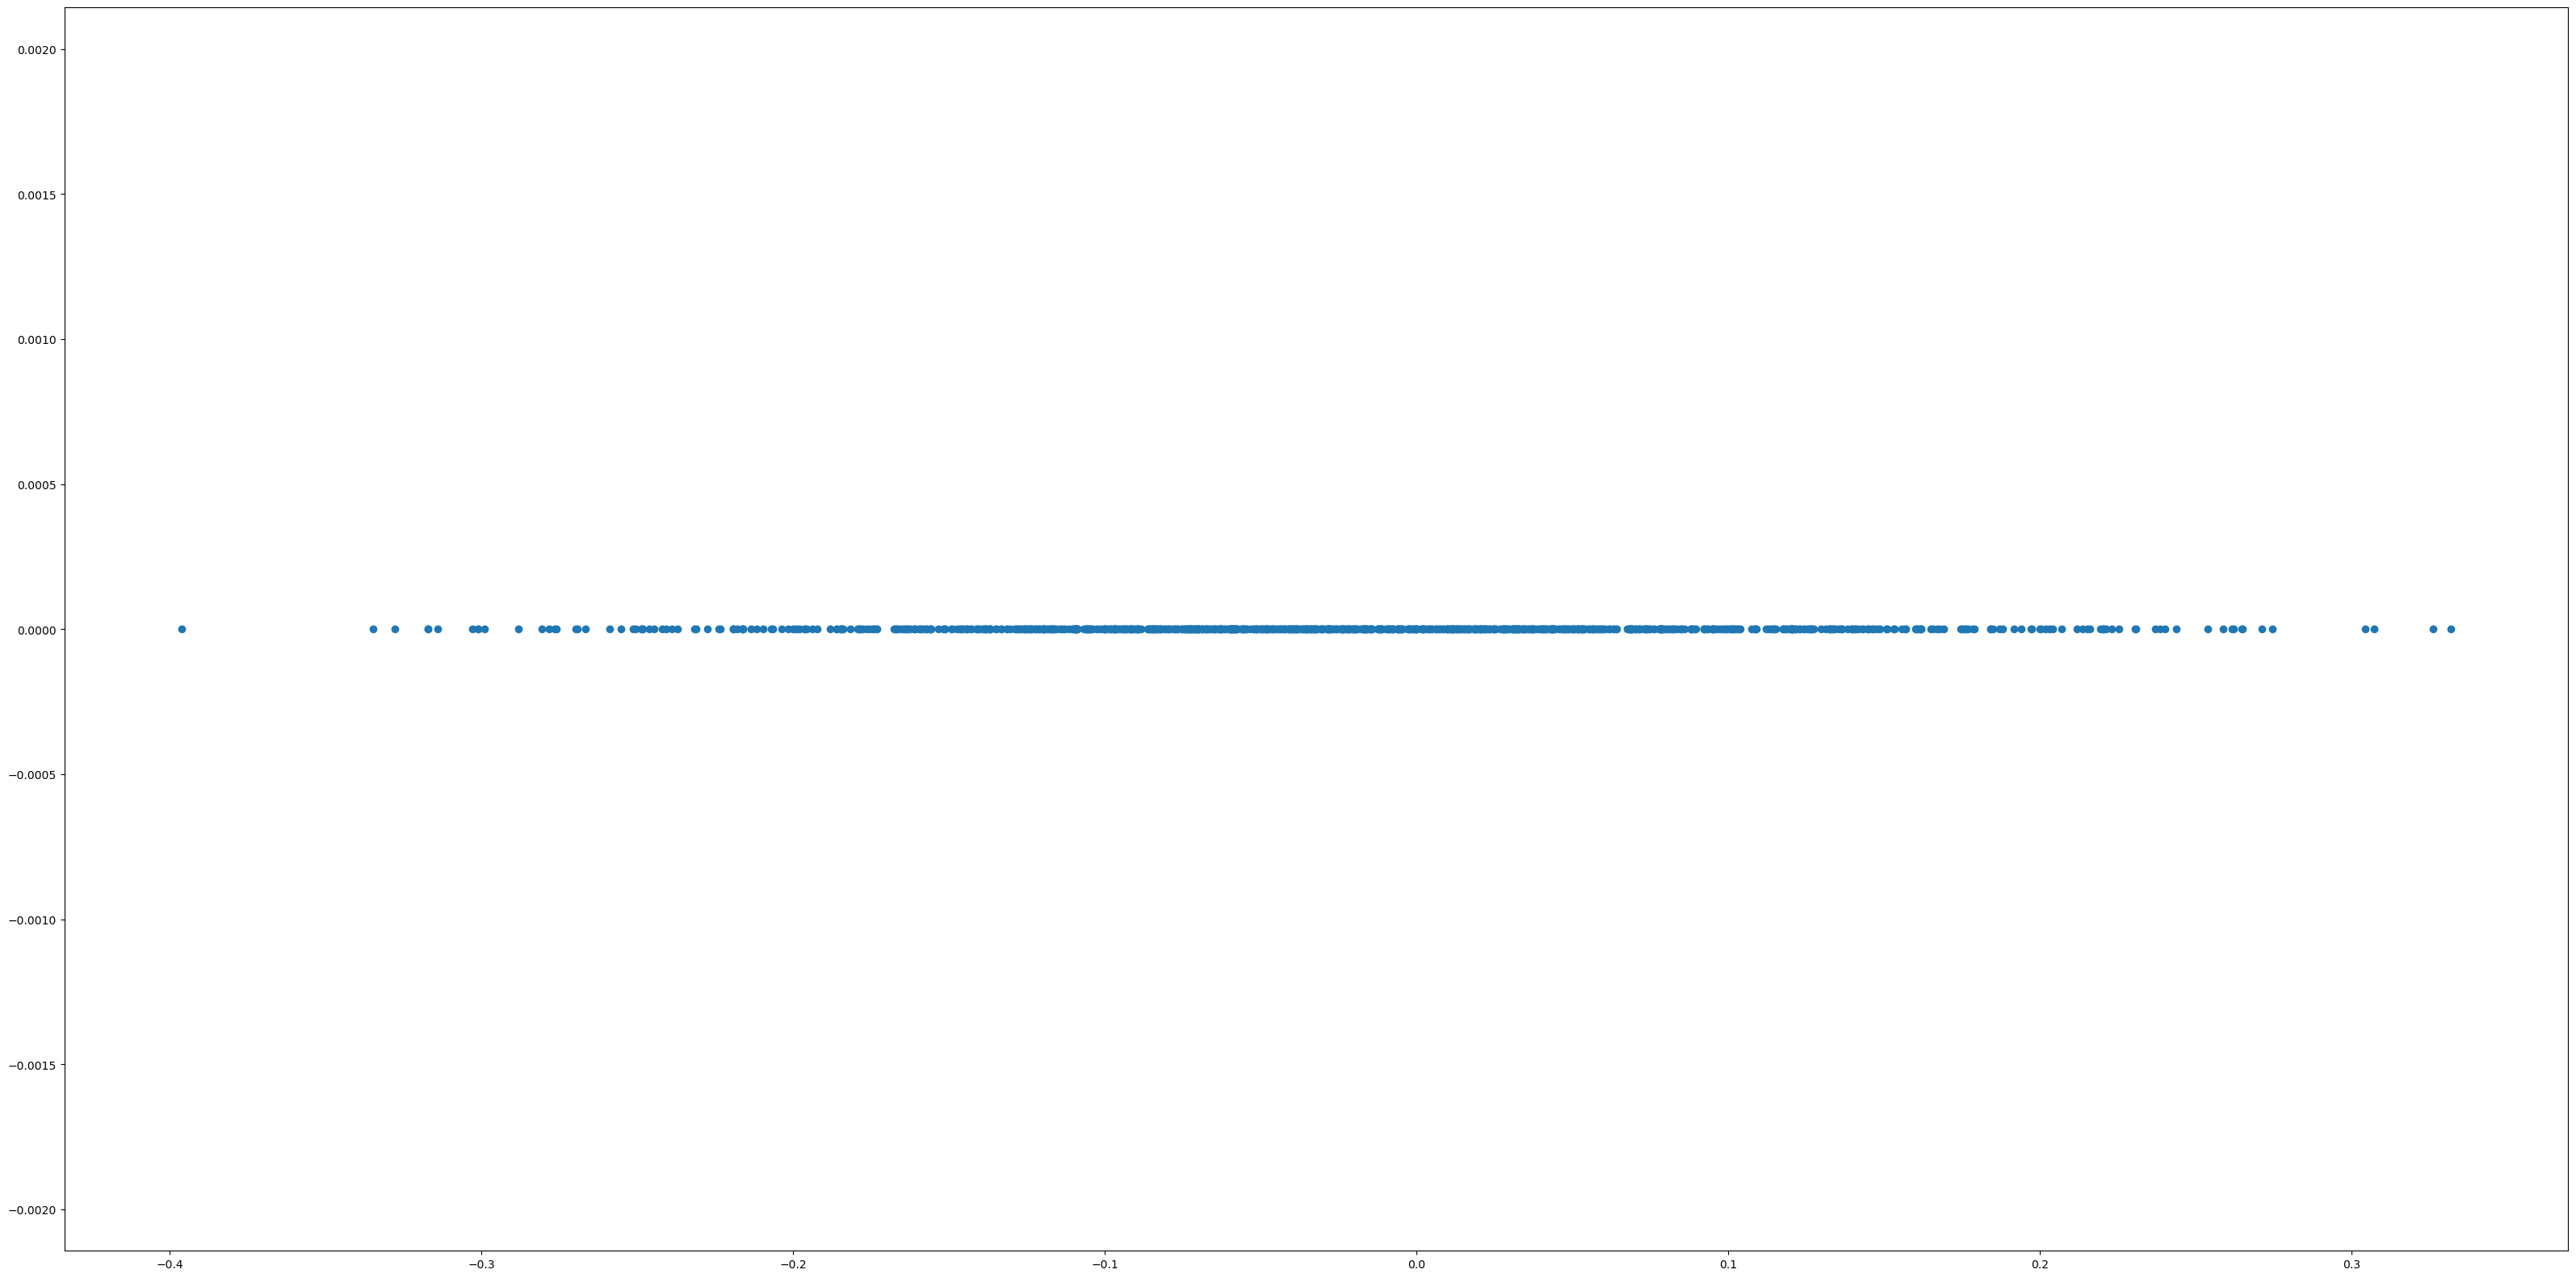

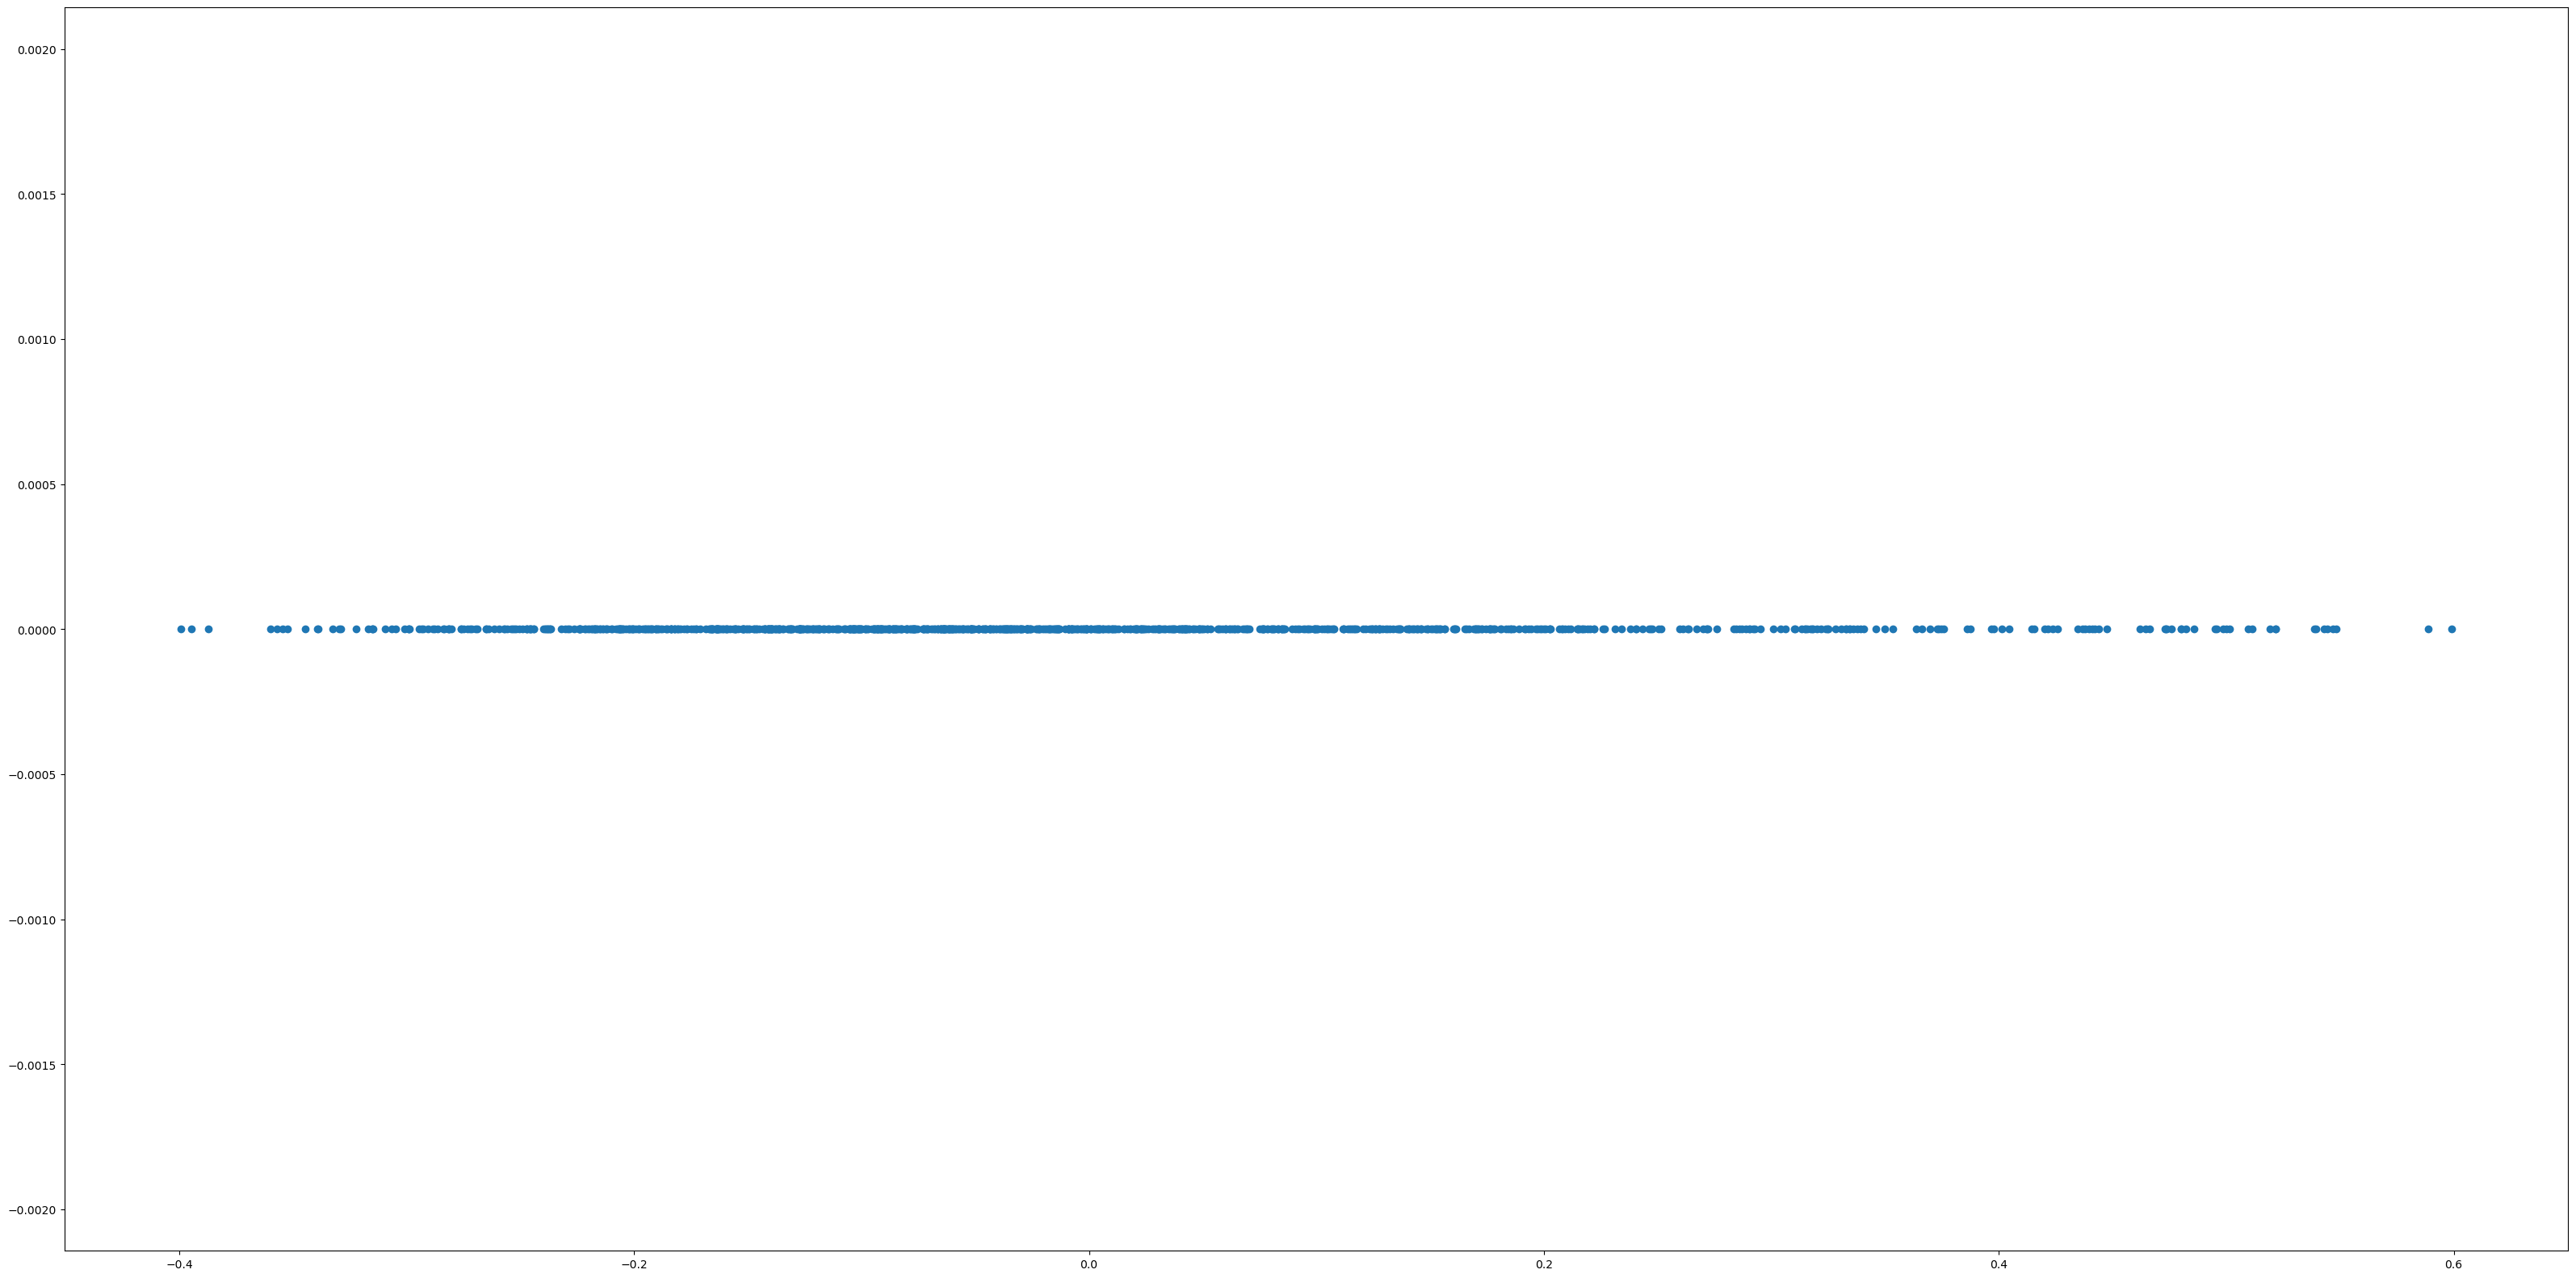

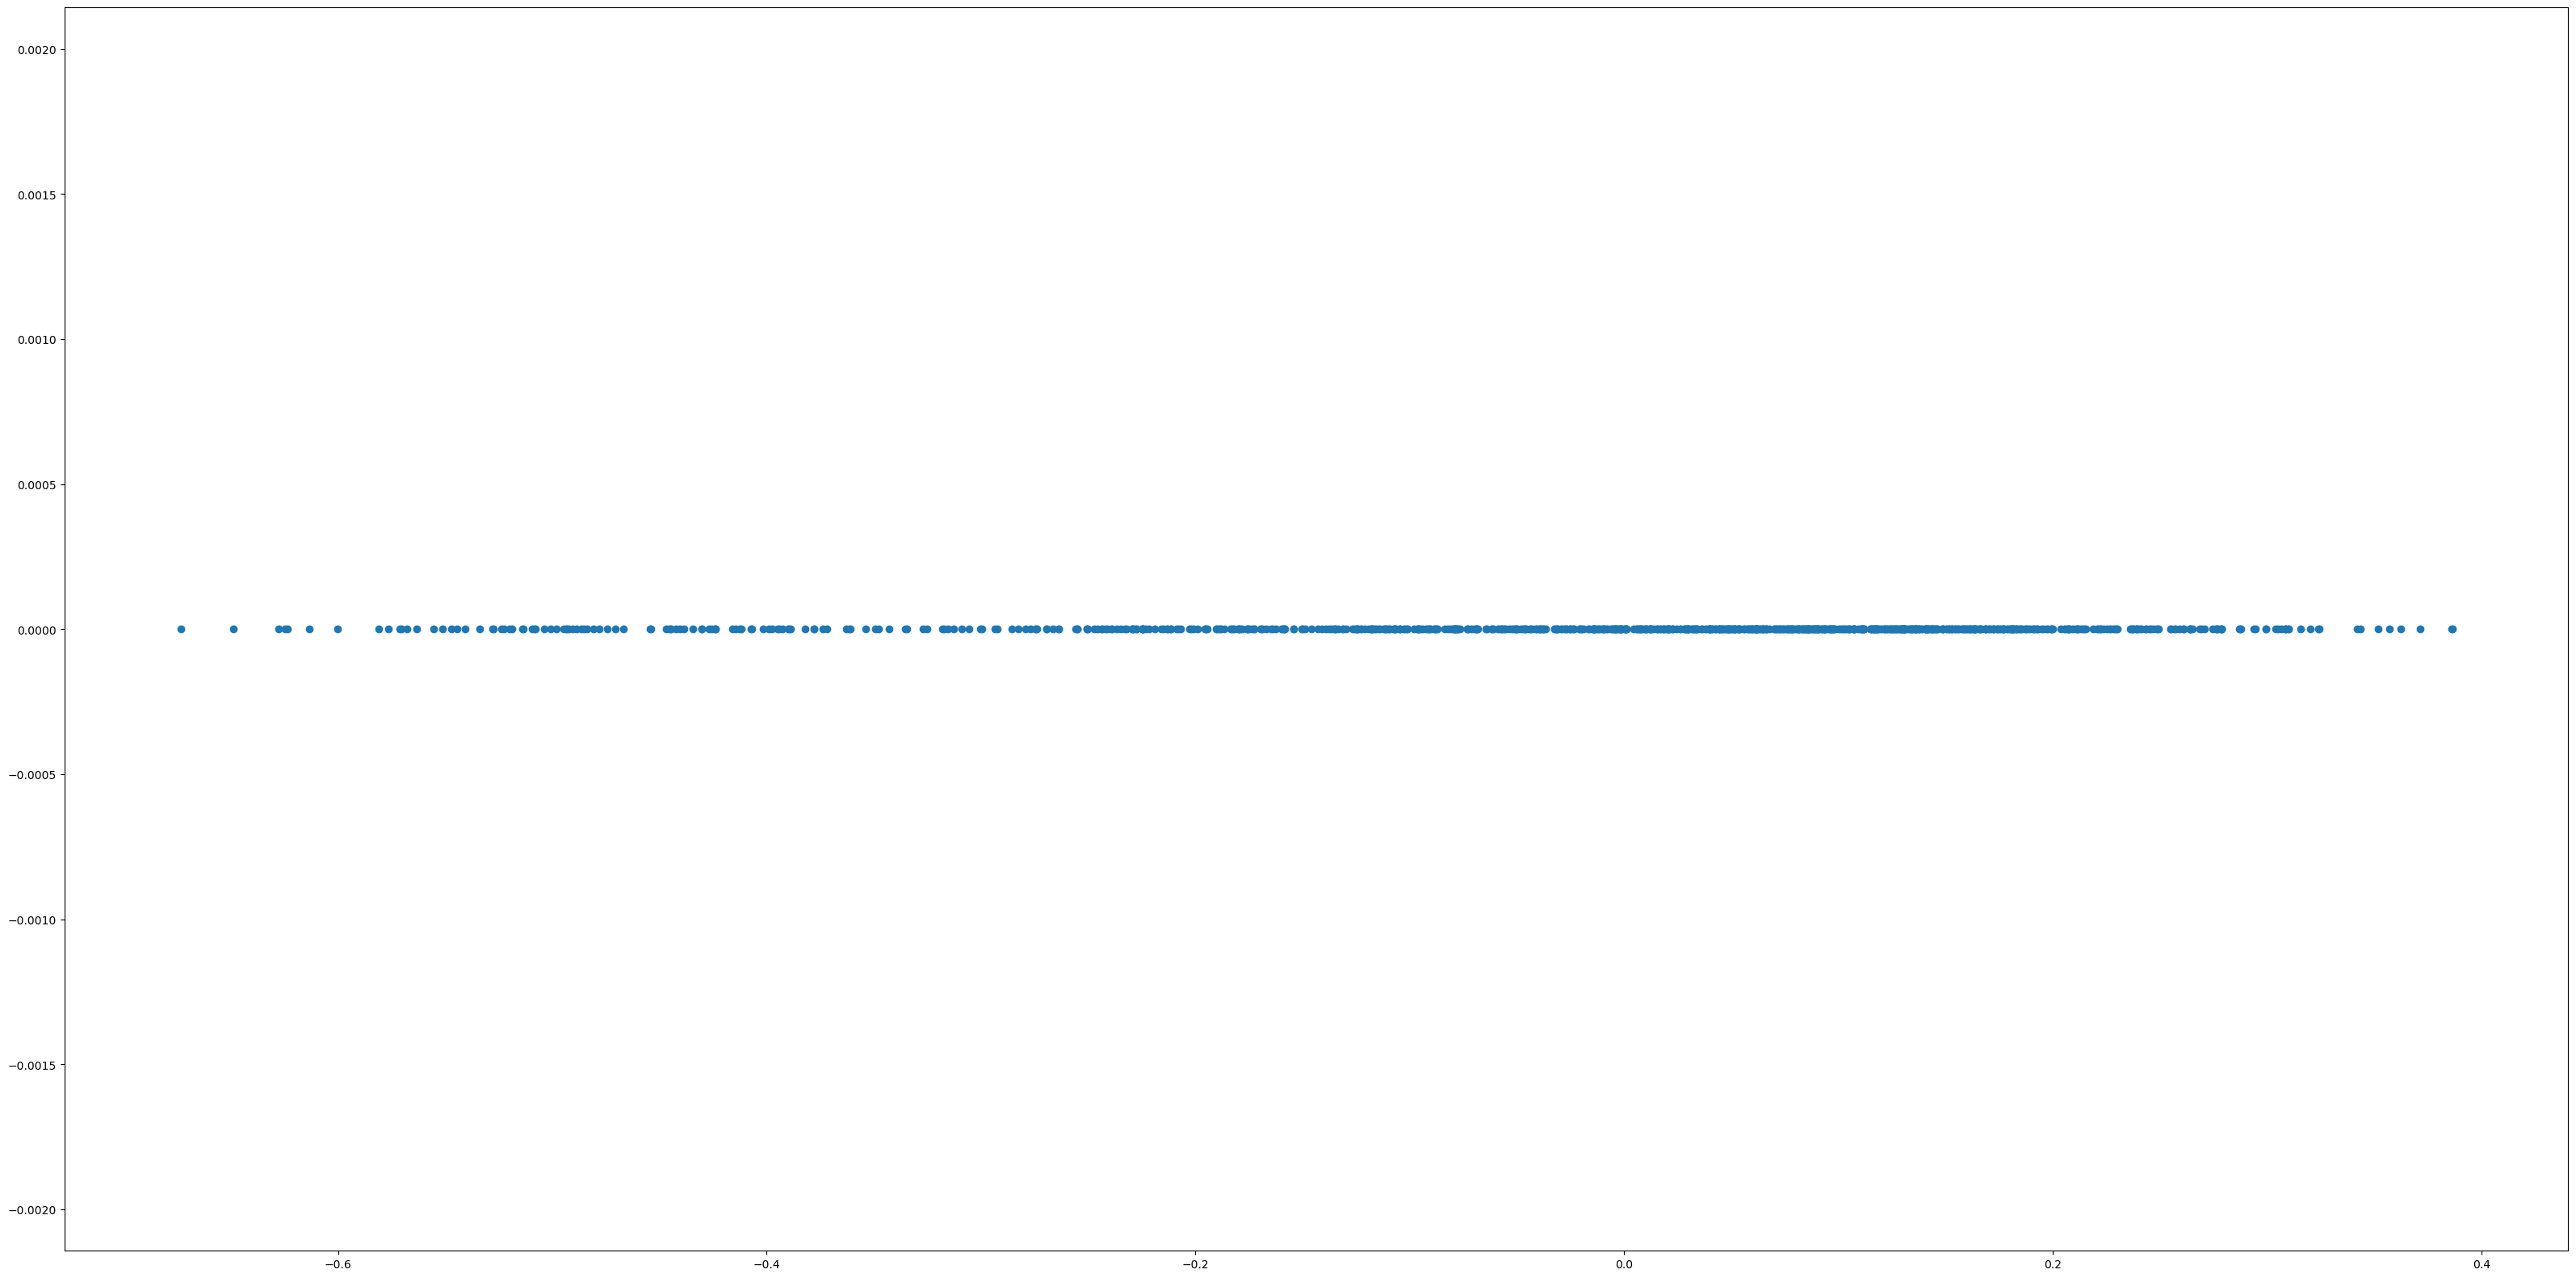

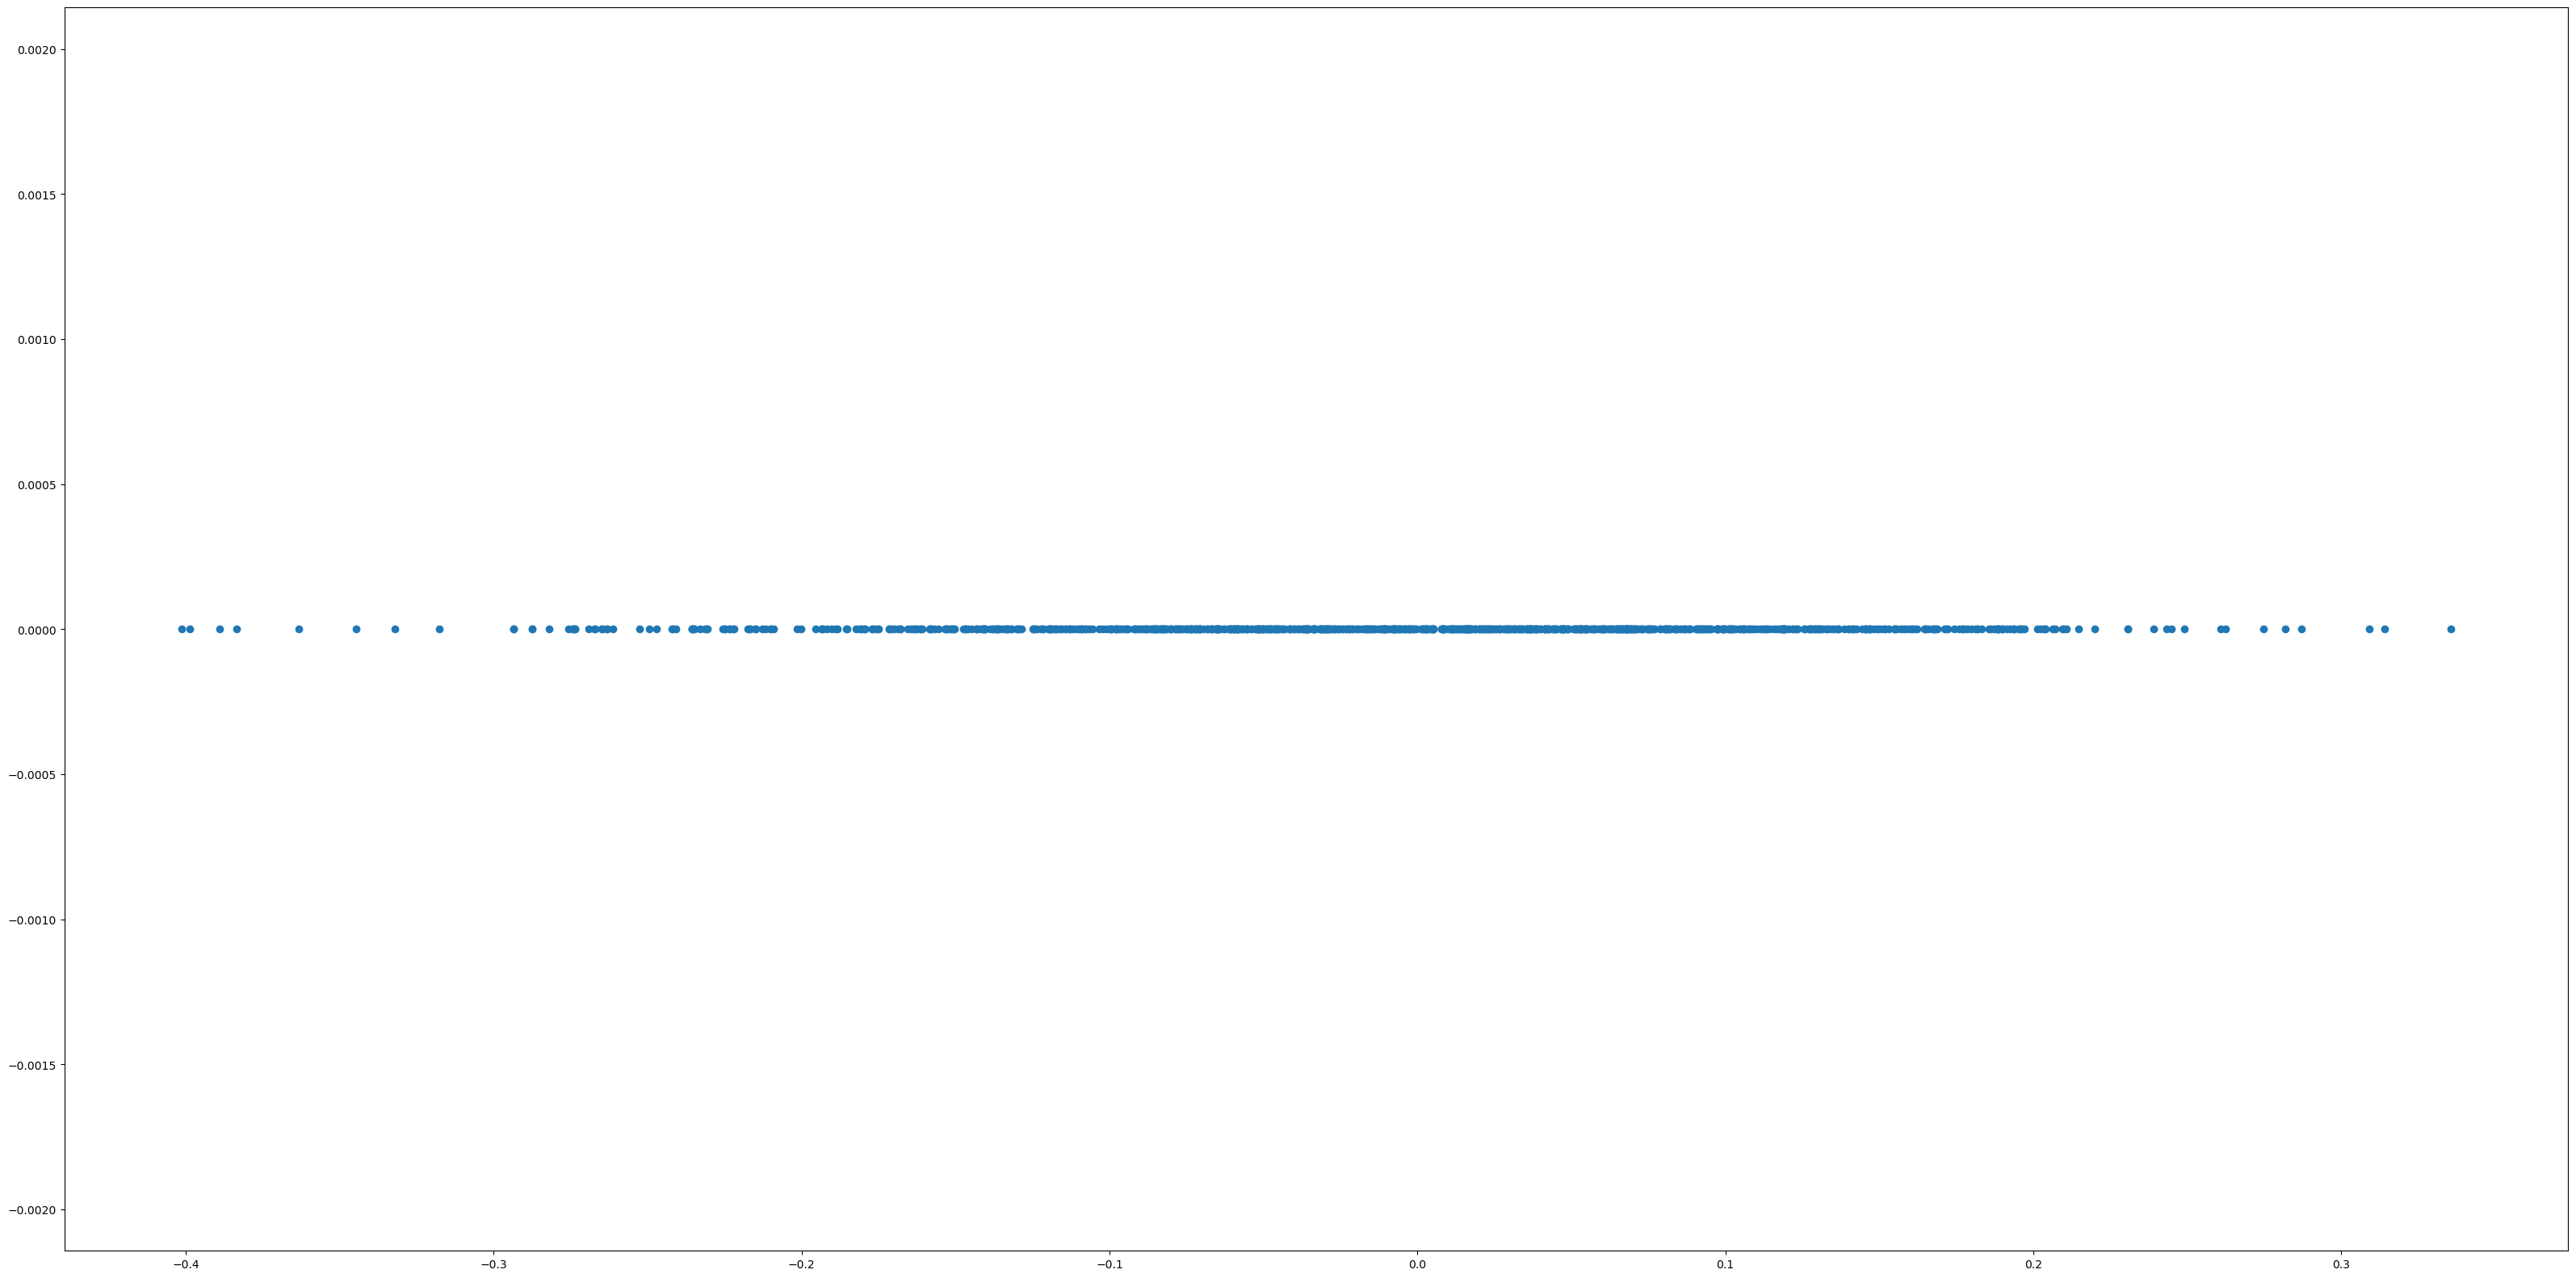

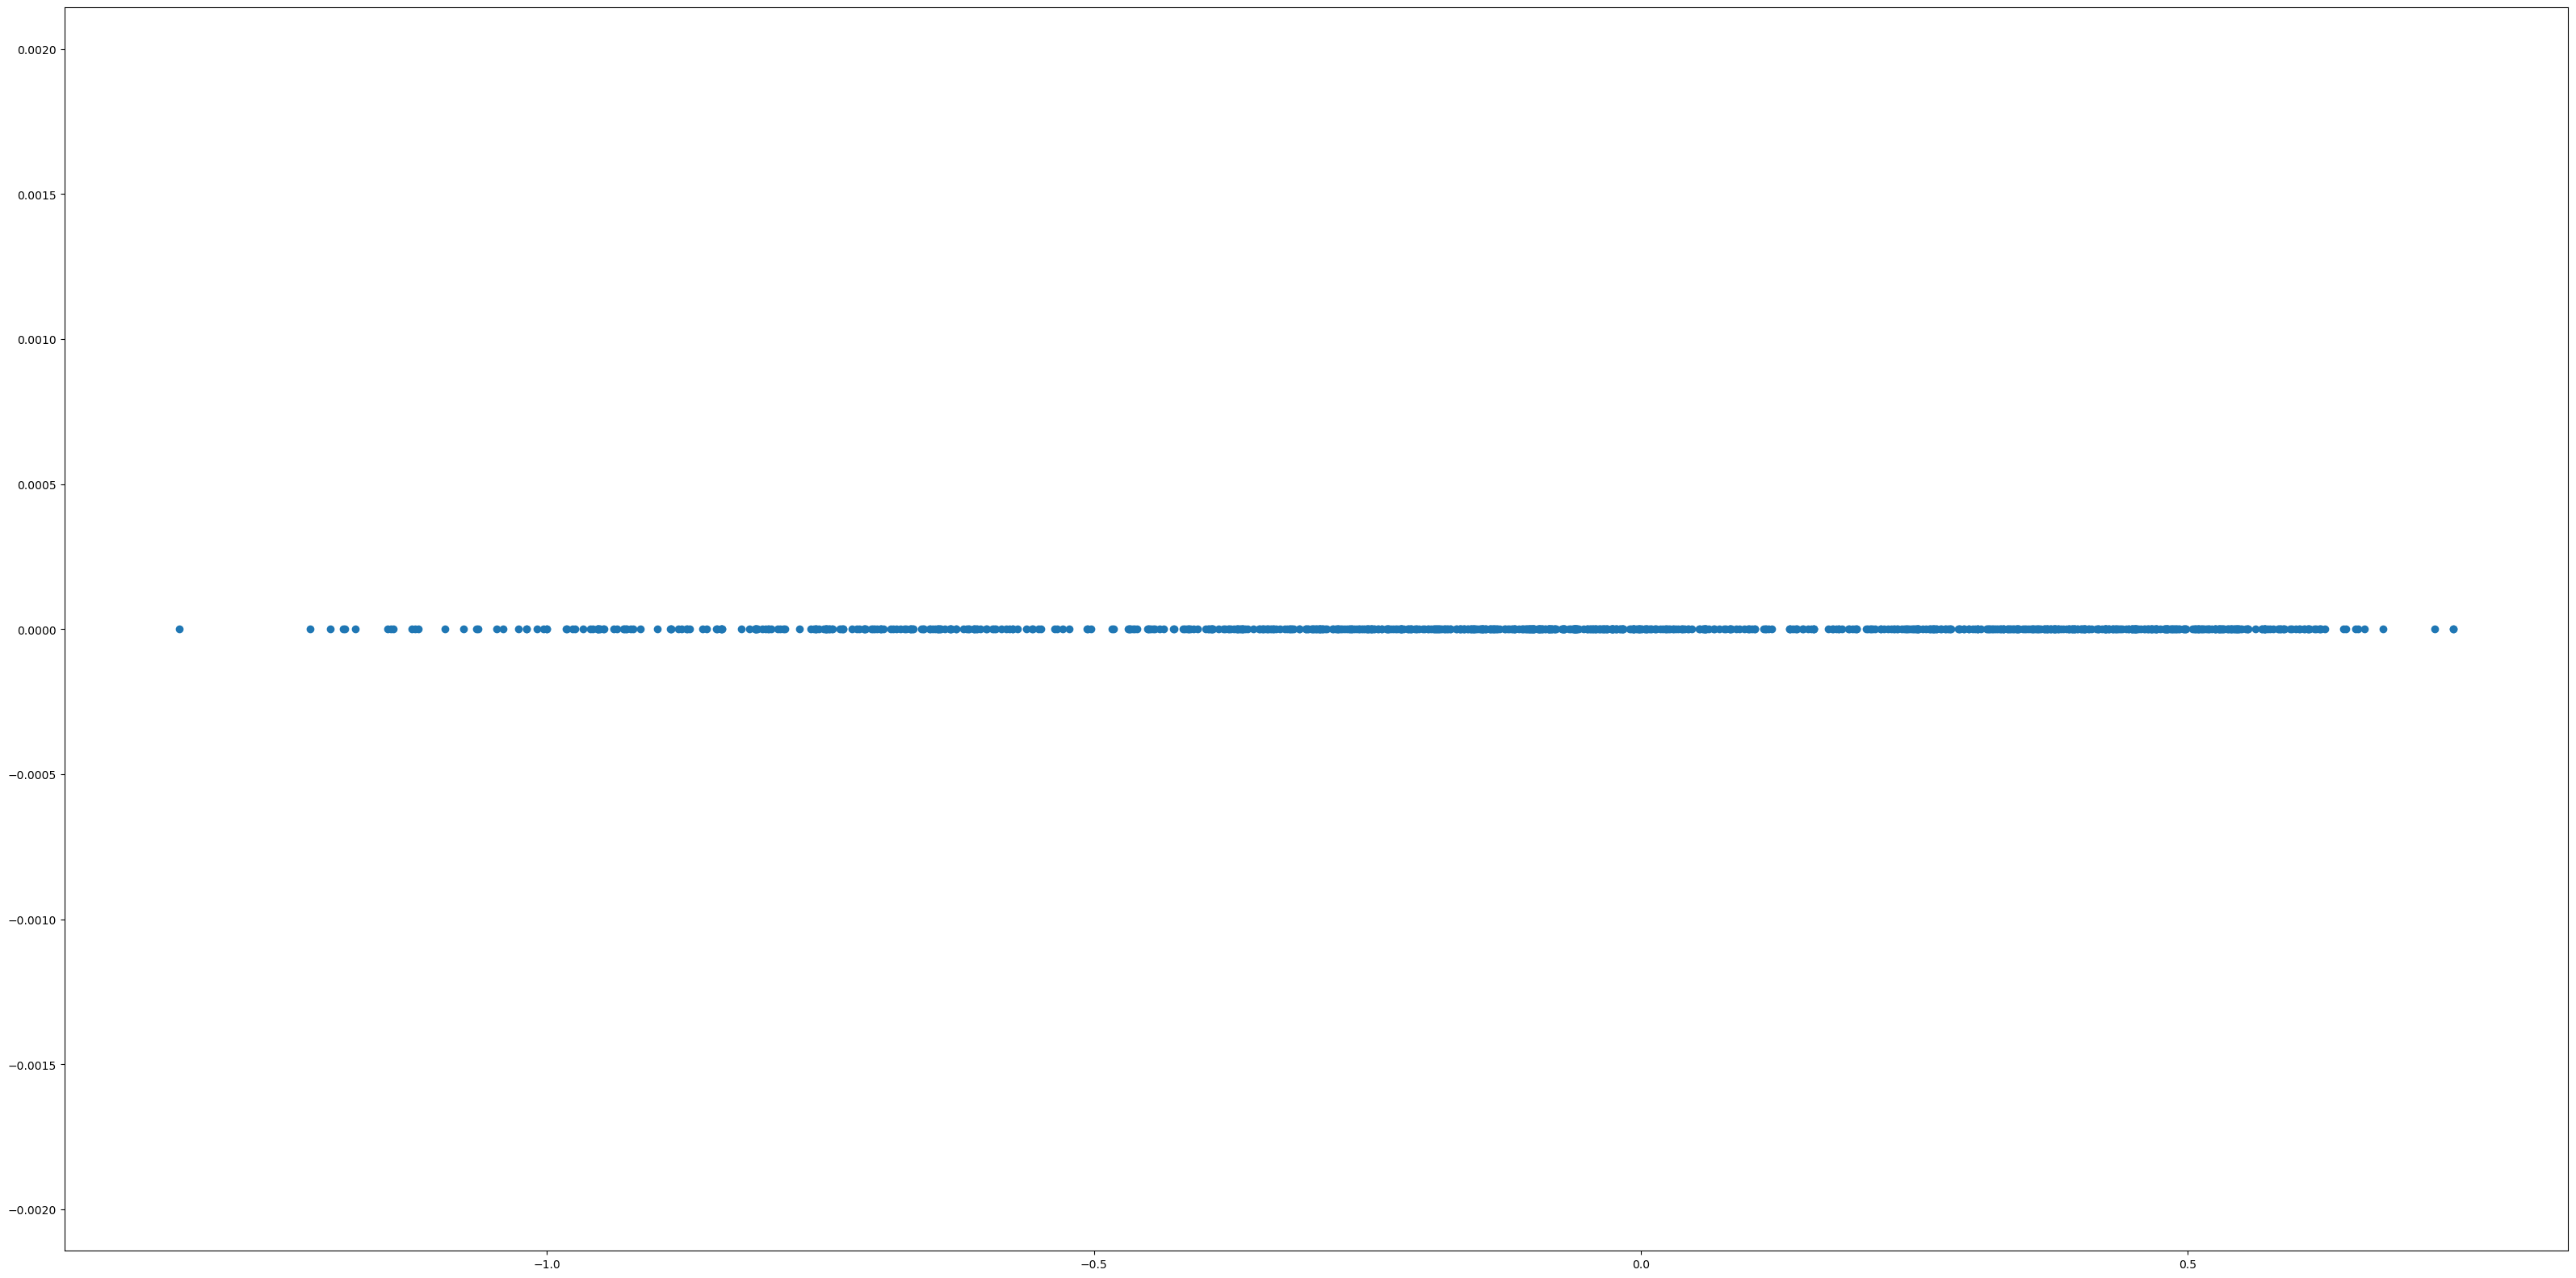

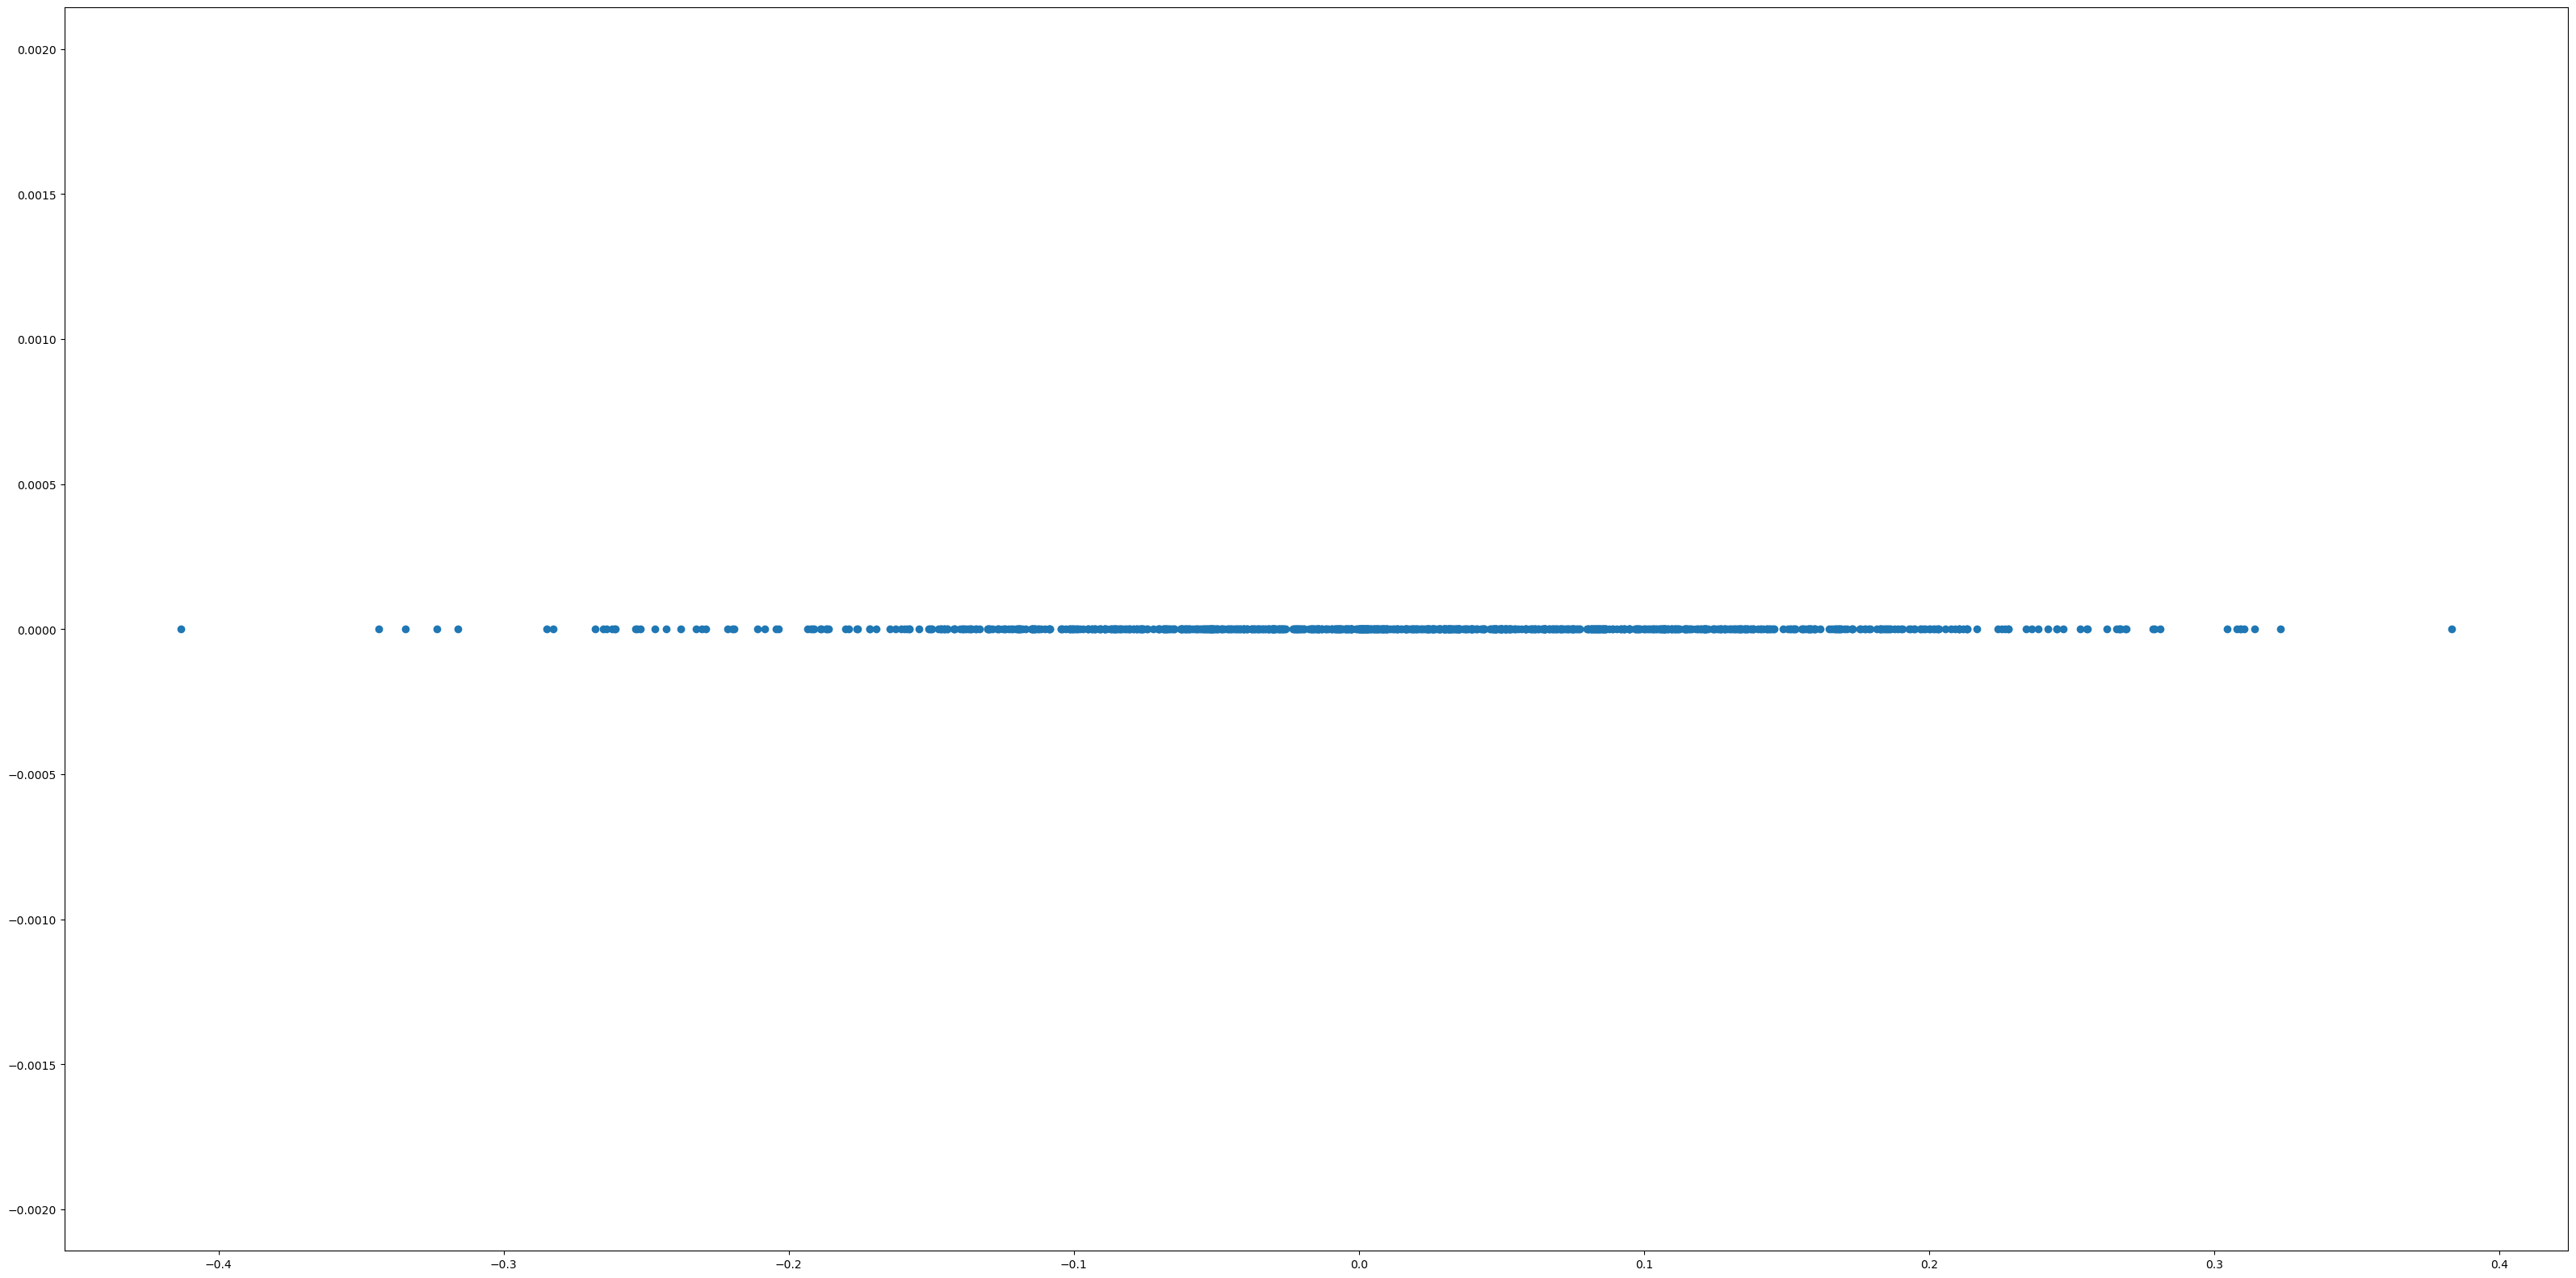

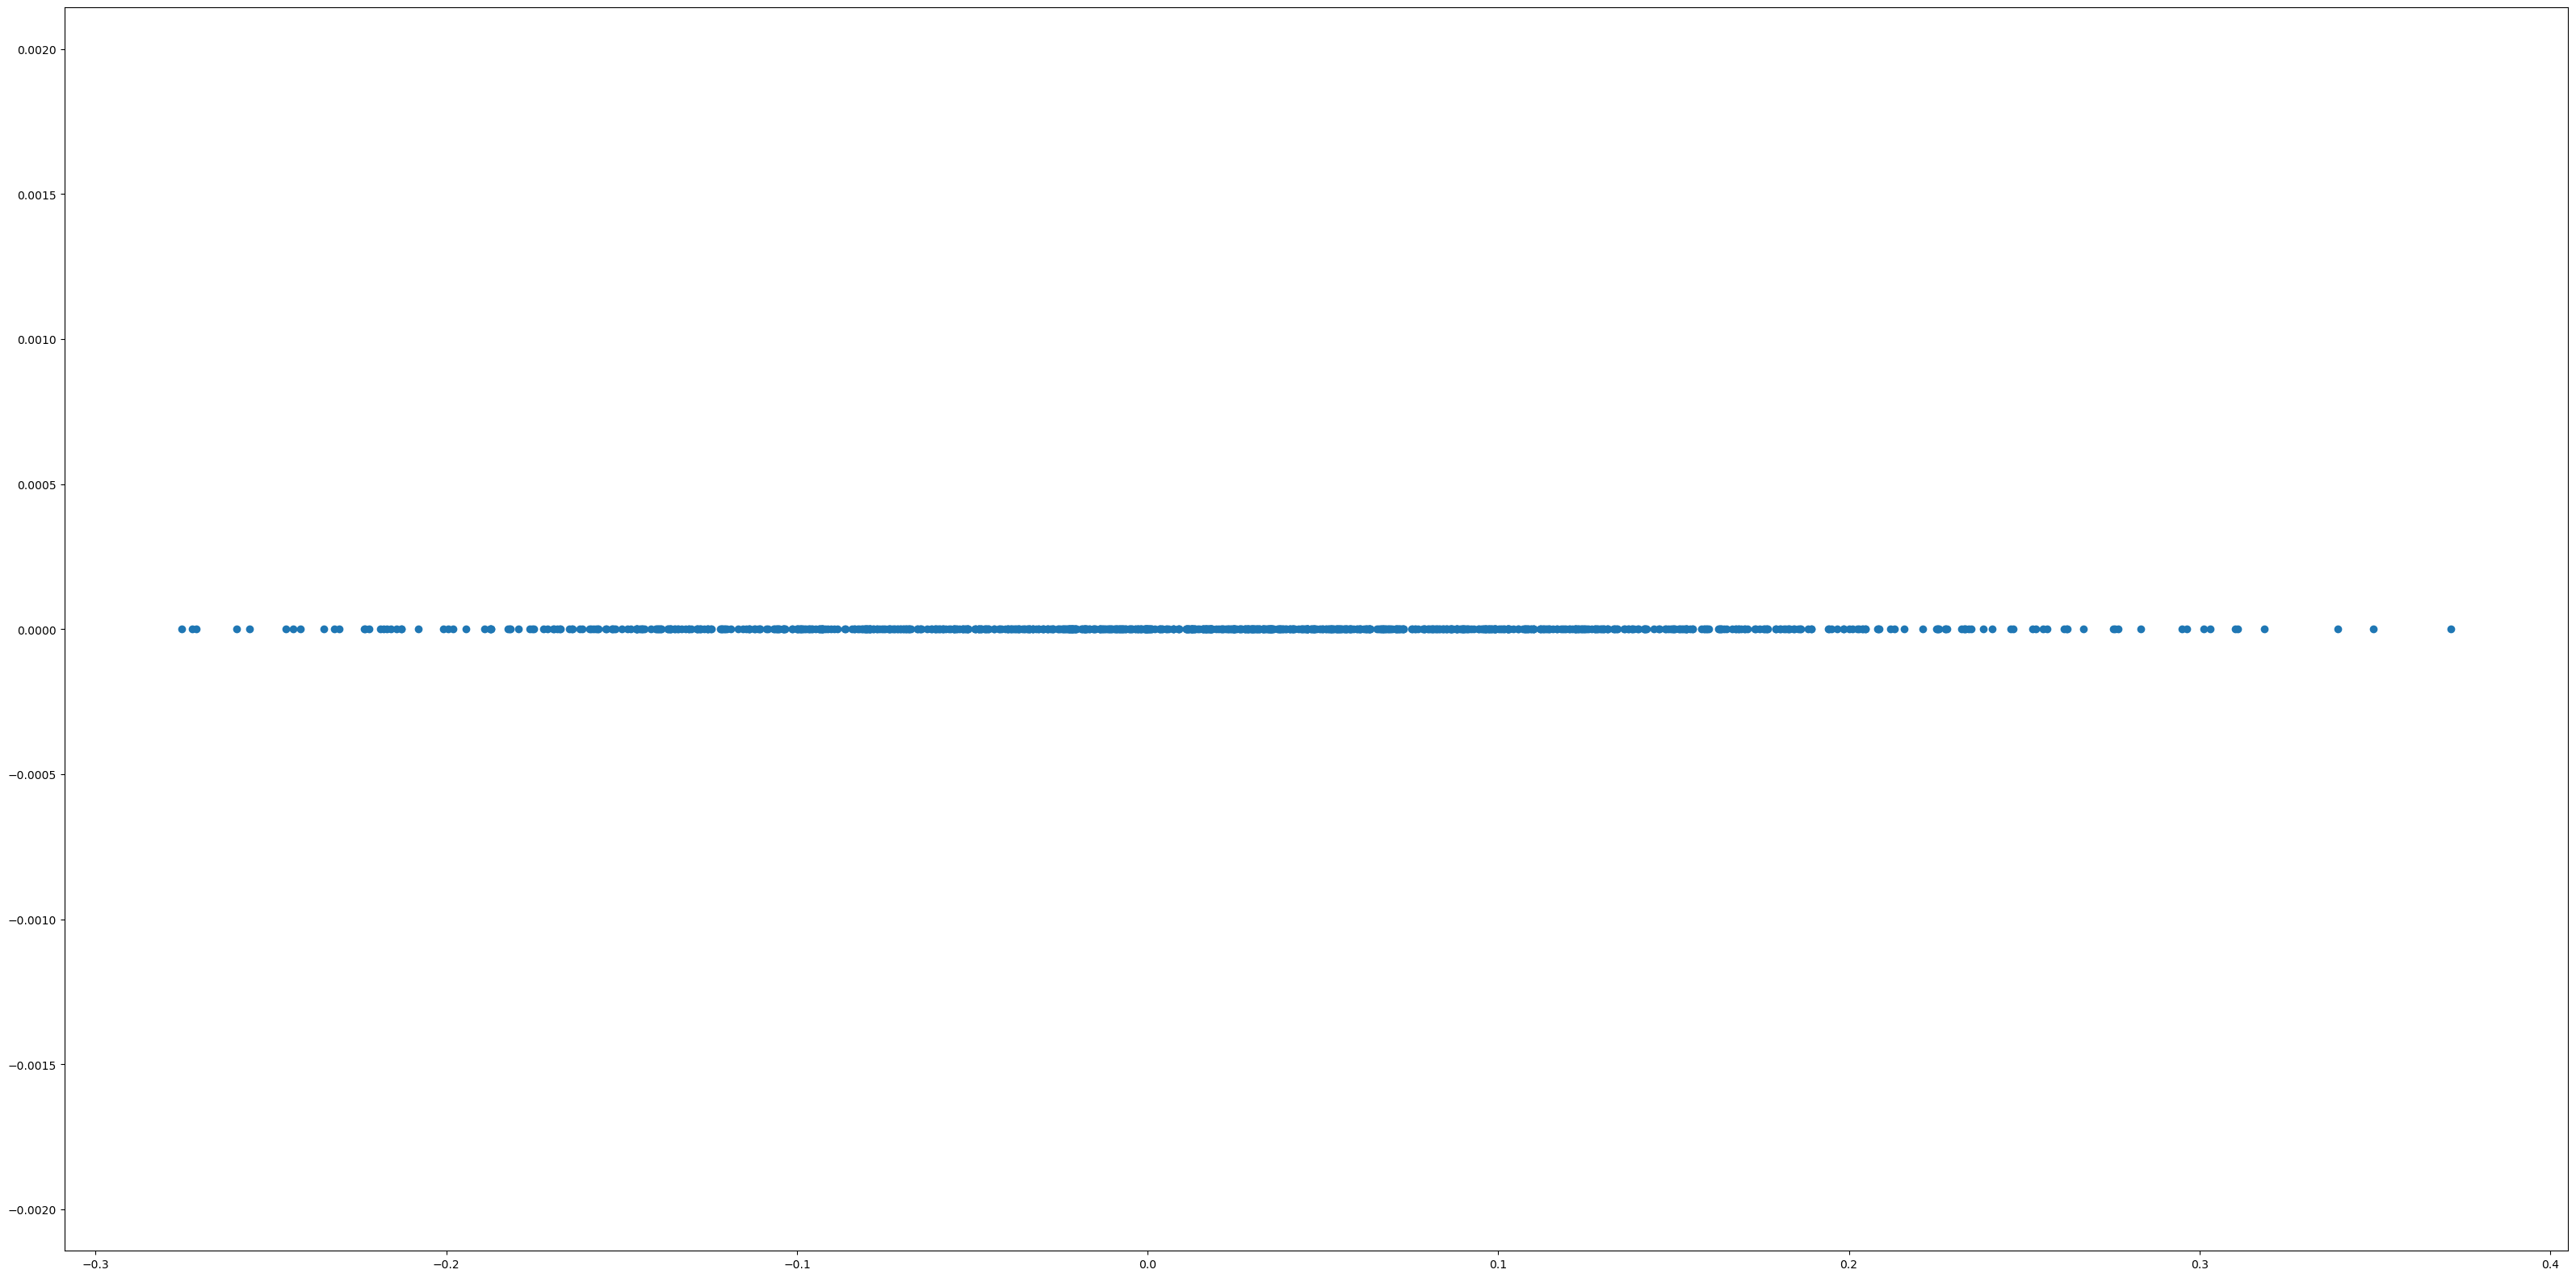

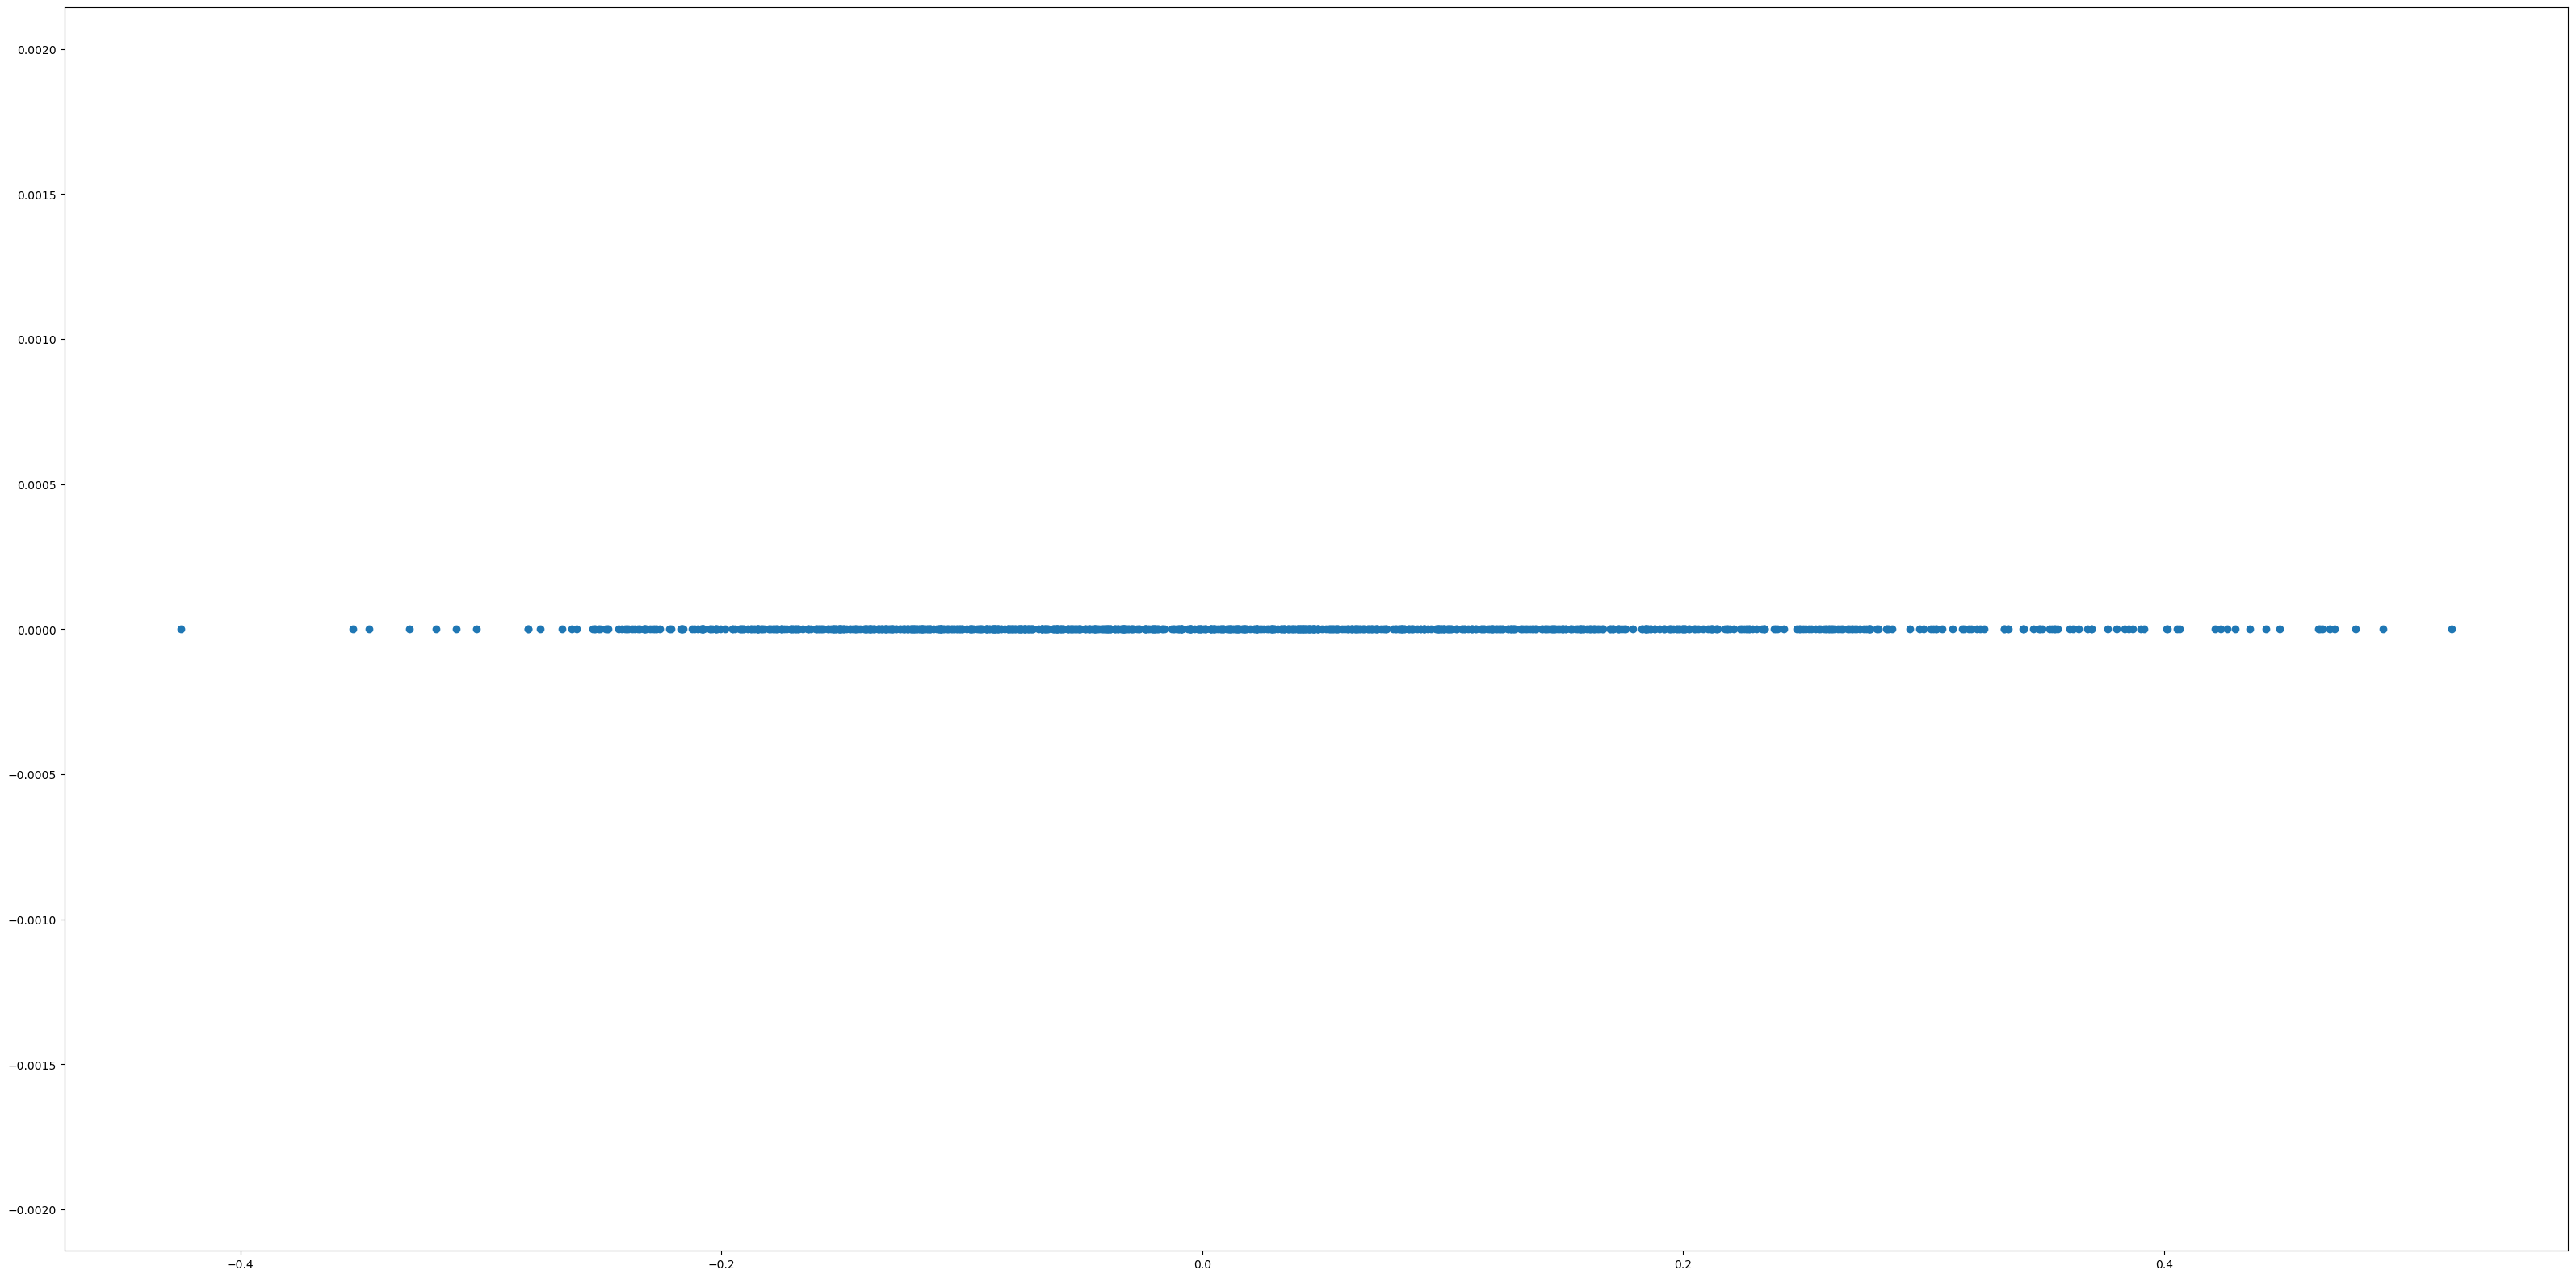

In [274]:
t = encoder2.predict(one_ten_df.to_numpy())[2]
for i in range(8):
    fig, ax = plt.subplots()
    plt.scatter(t[:,i],np.zeros_like(t[:,i]))
    plt.show()

In [1067]:
outs = encoder.predict(half_df.to_numpy())
print(np.min(outs[2],axis=0))
print(np.max(outs[2],axis=0))


[-0.39914623 -0.3623935  -0.2417978  -0.54630774 -0.55934703 -0.1896421
 -0.29452214 -0.2913729 ]
[0.58216065 0.24019647 0.3243271  0.27681357 0.17517078 0.6246462
 0.48527068 0.38770607]


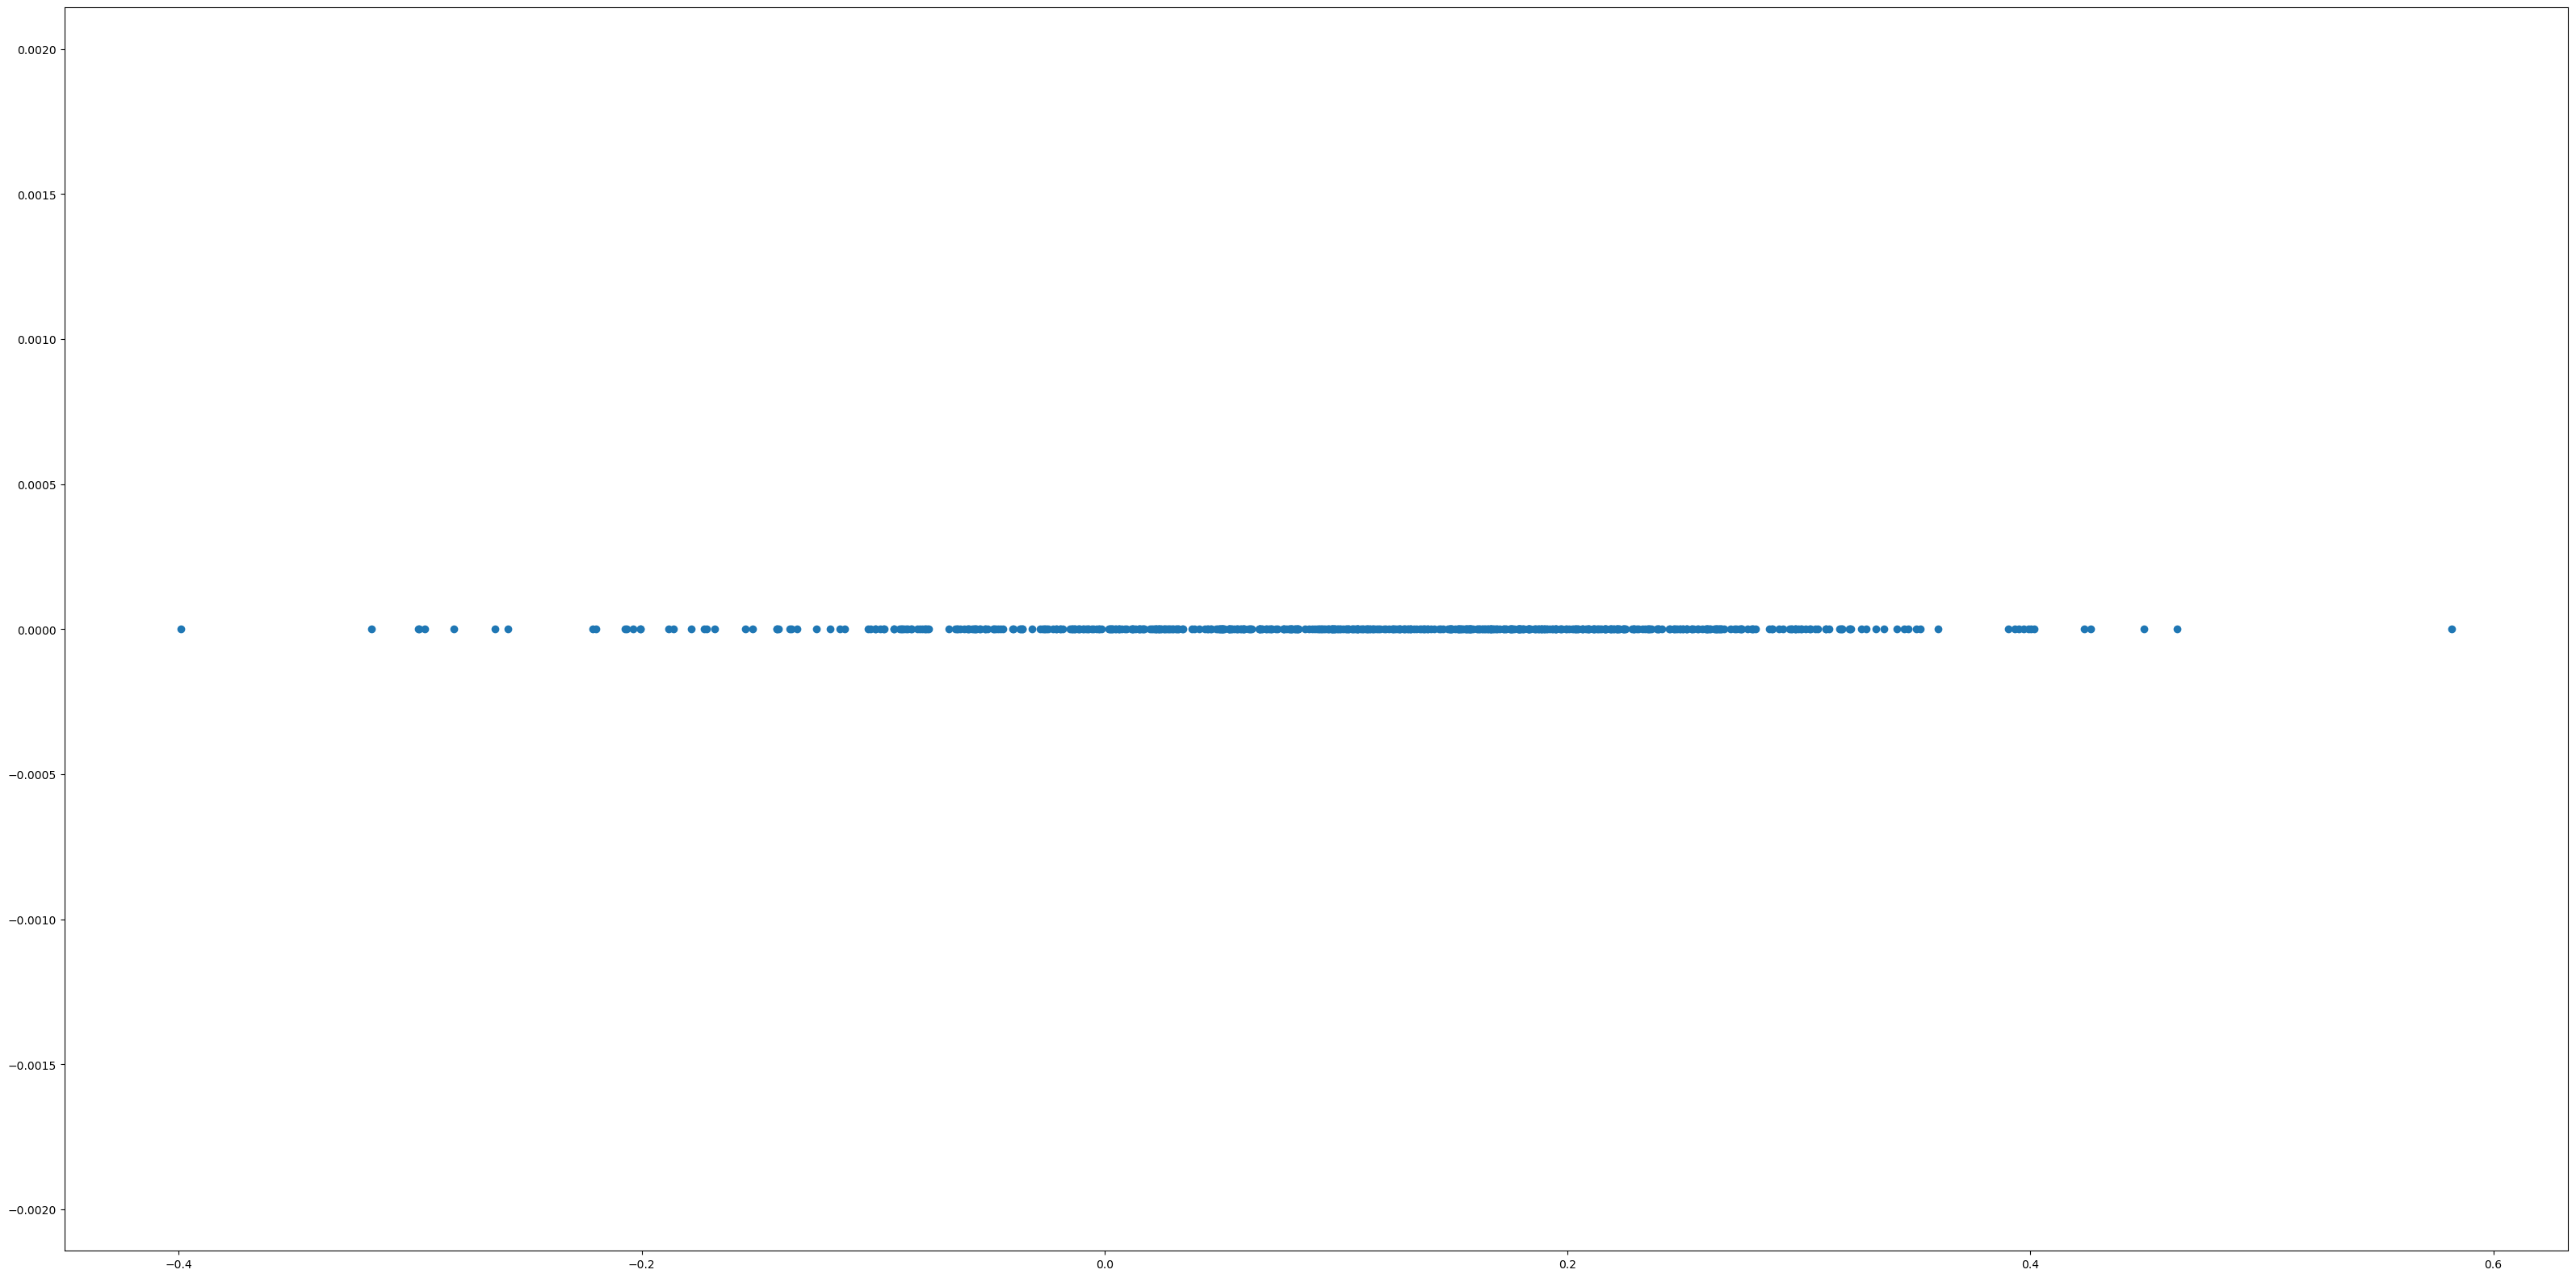

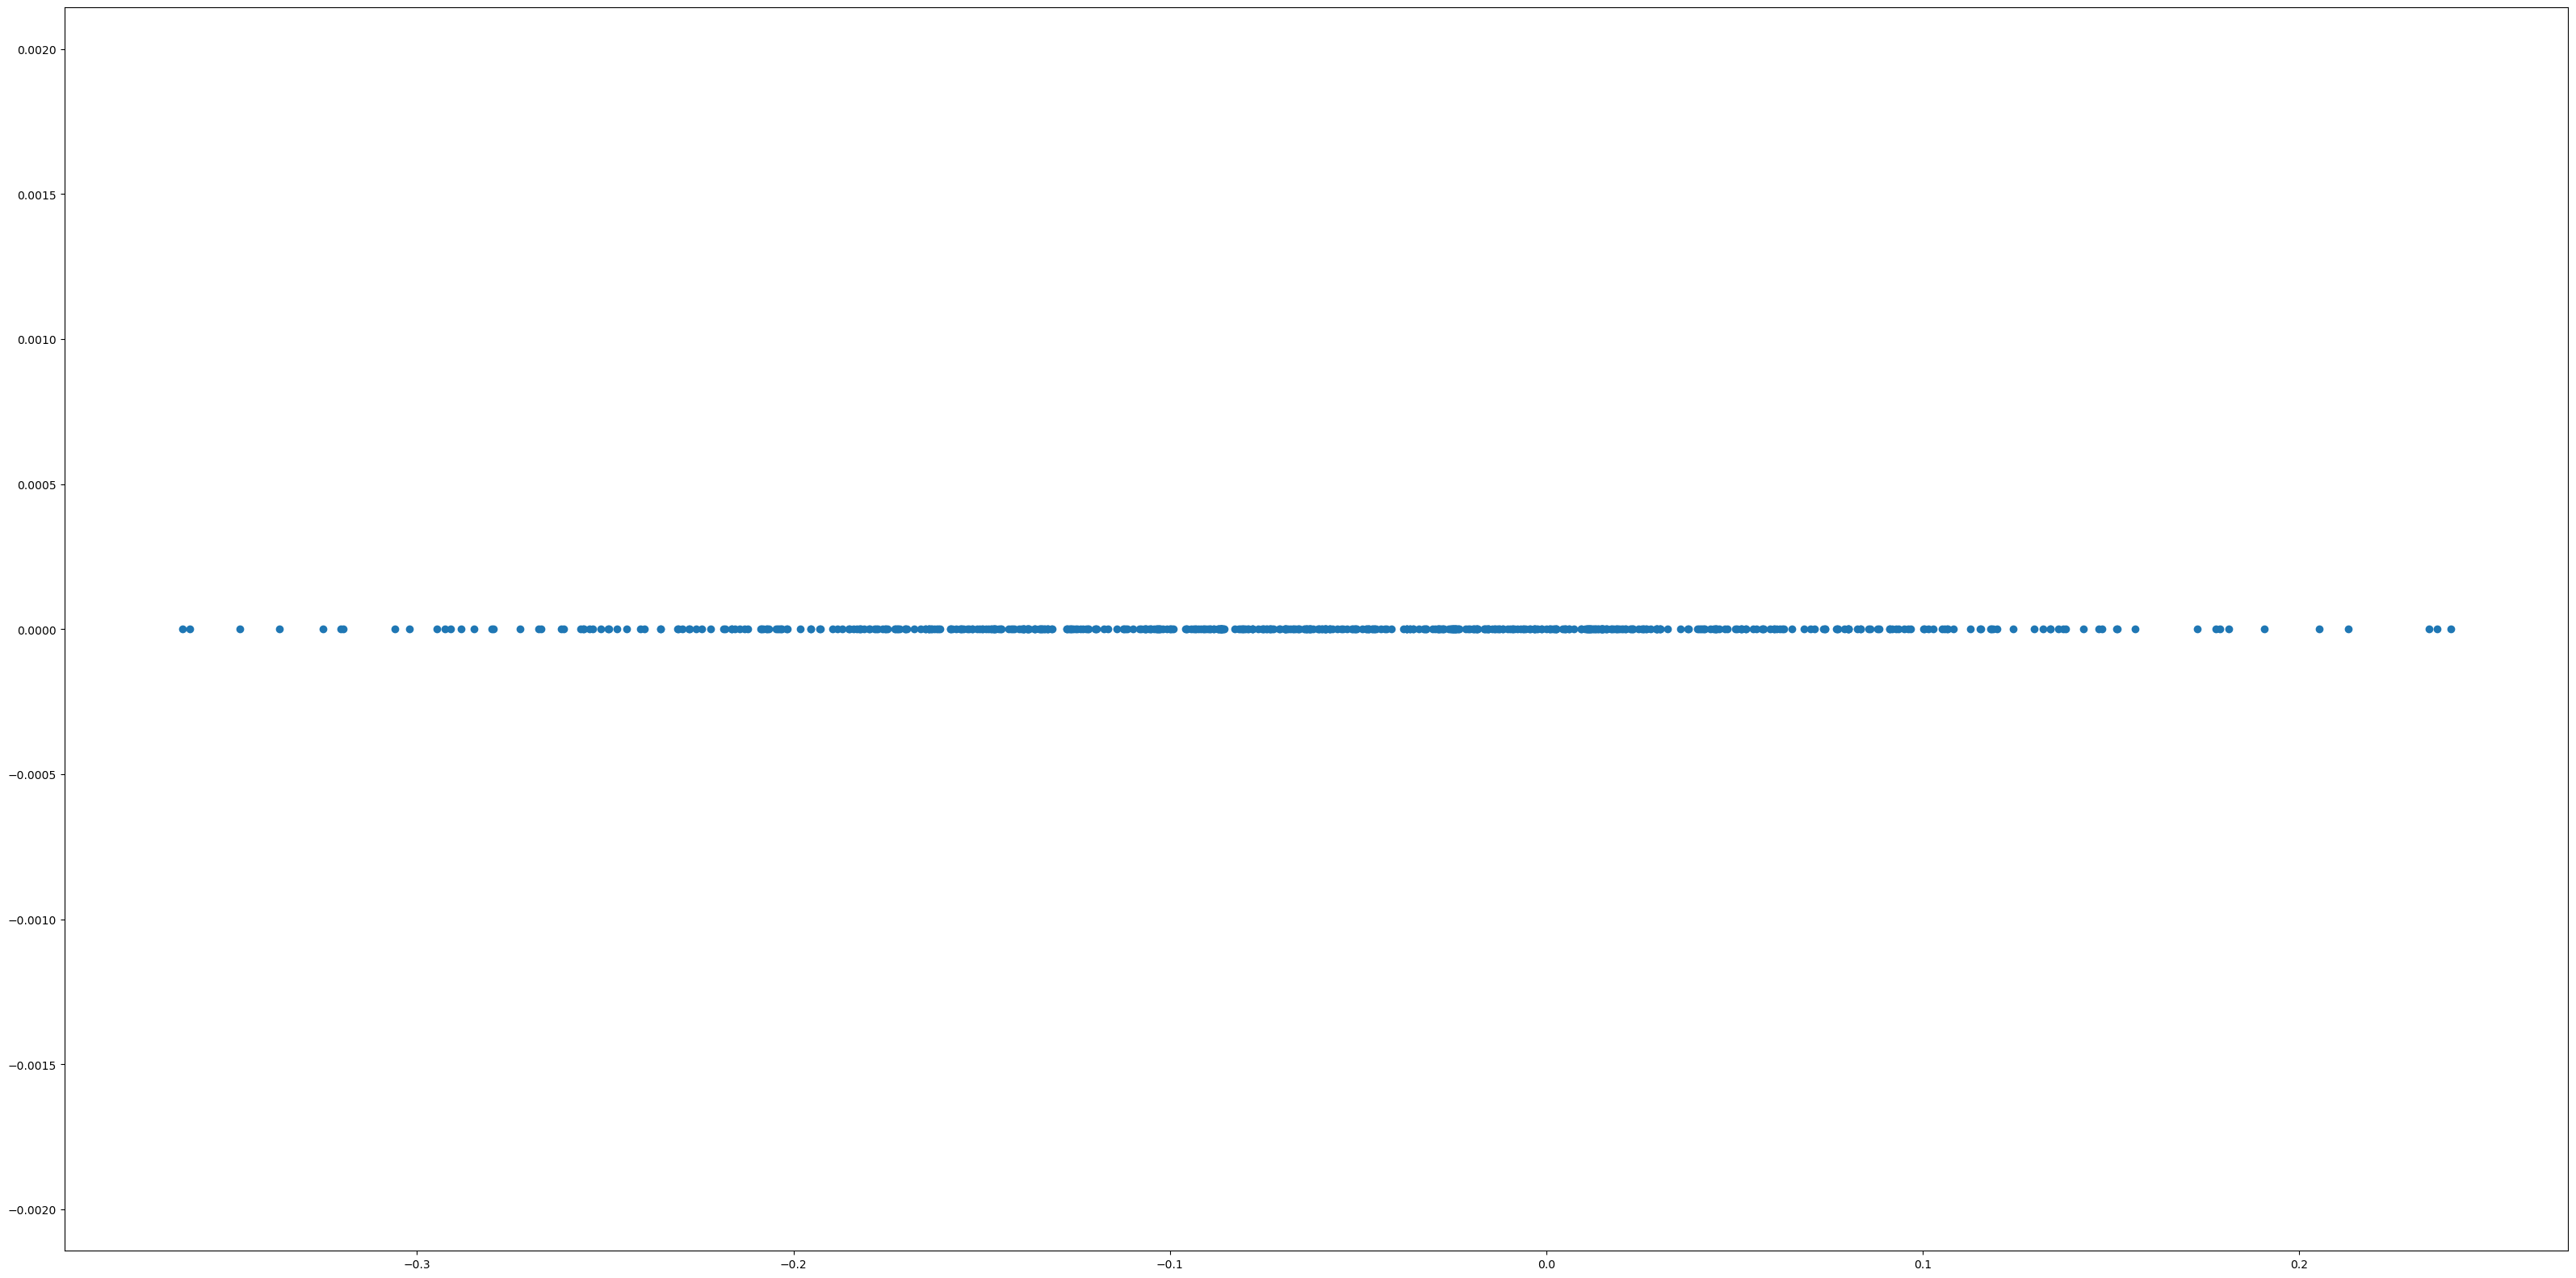

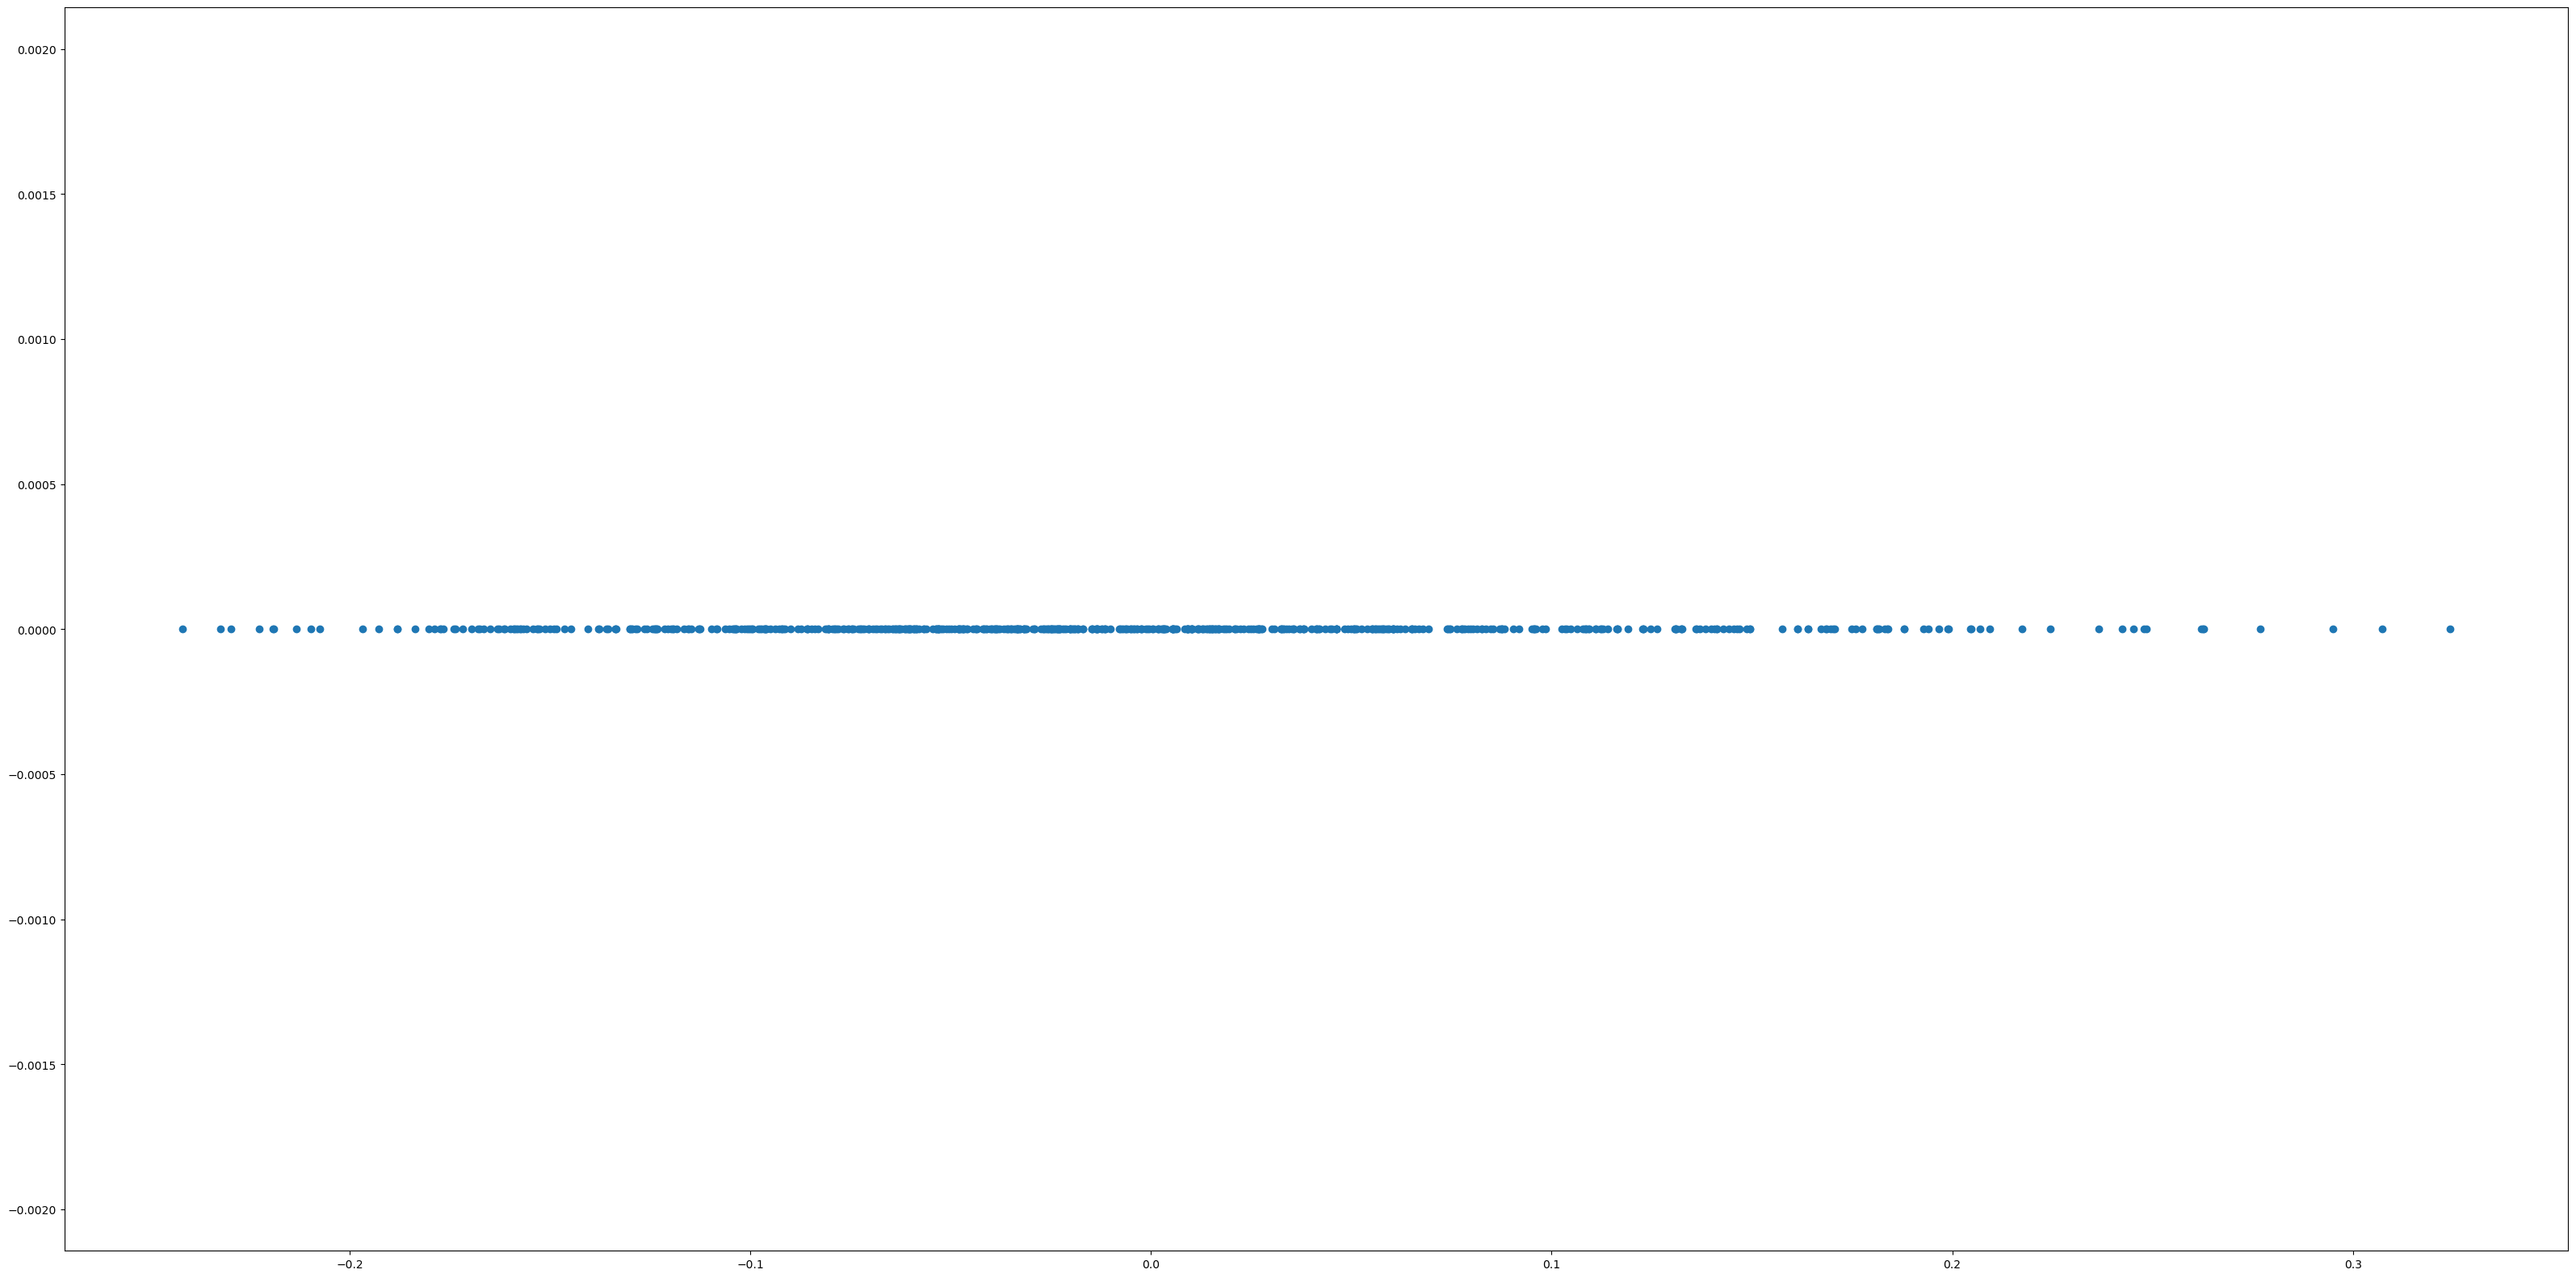

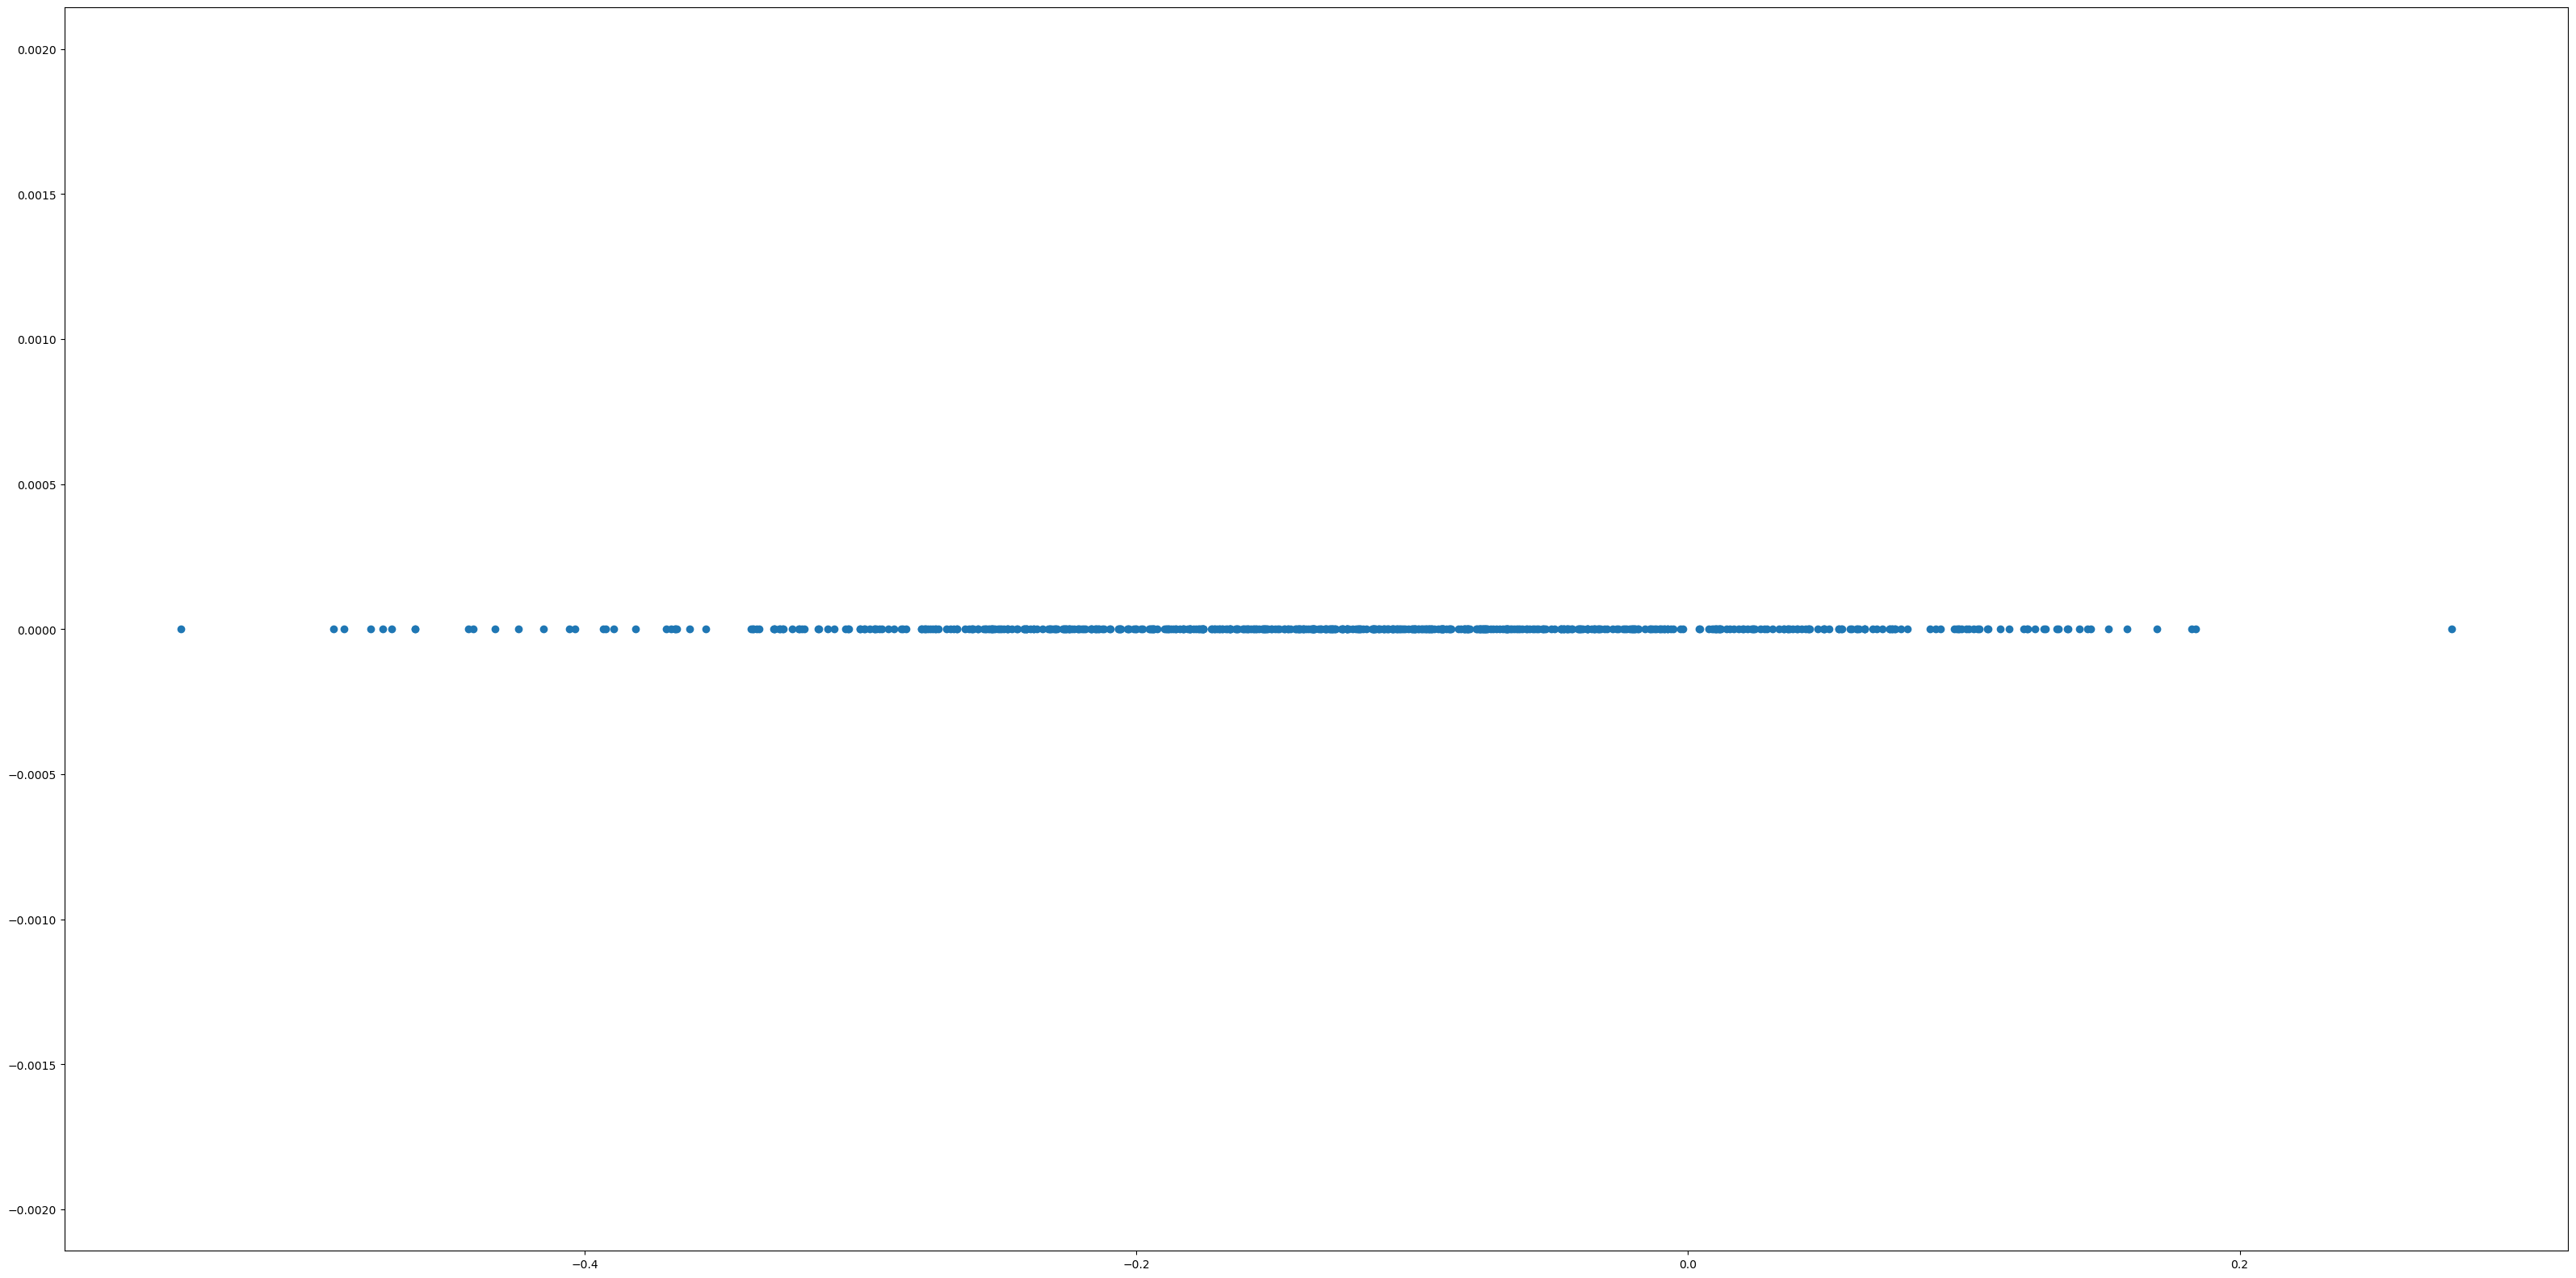

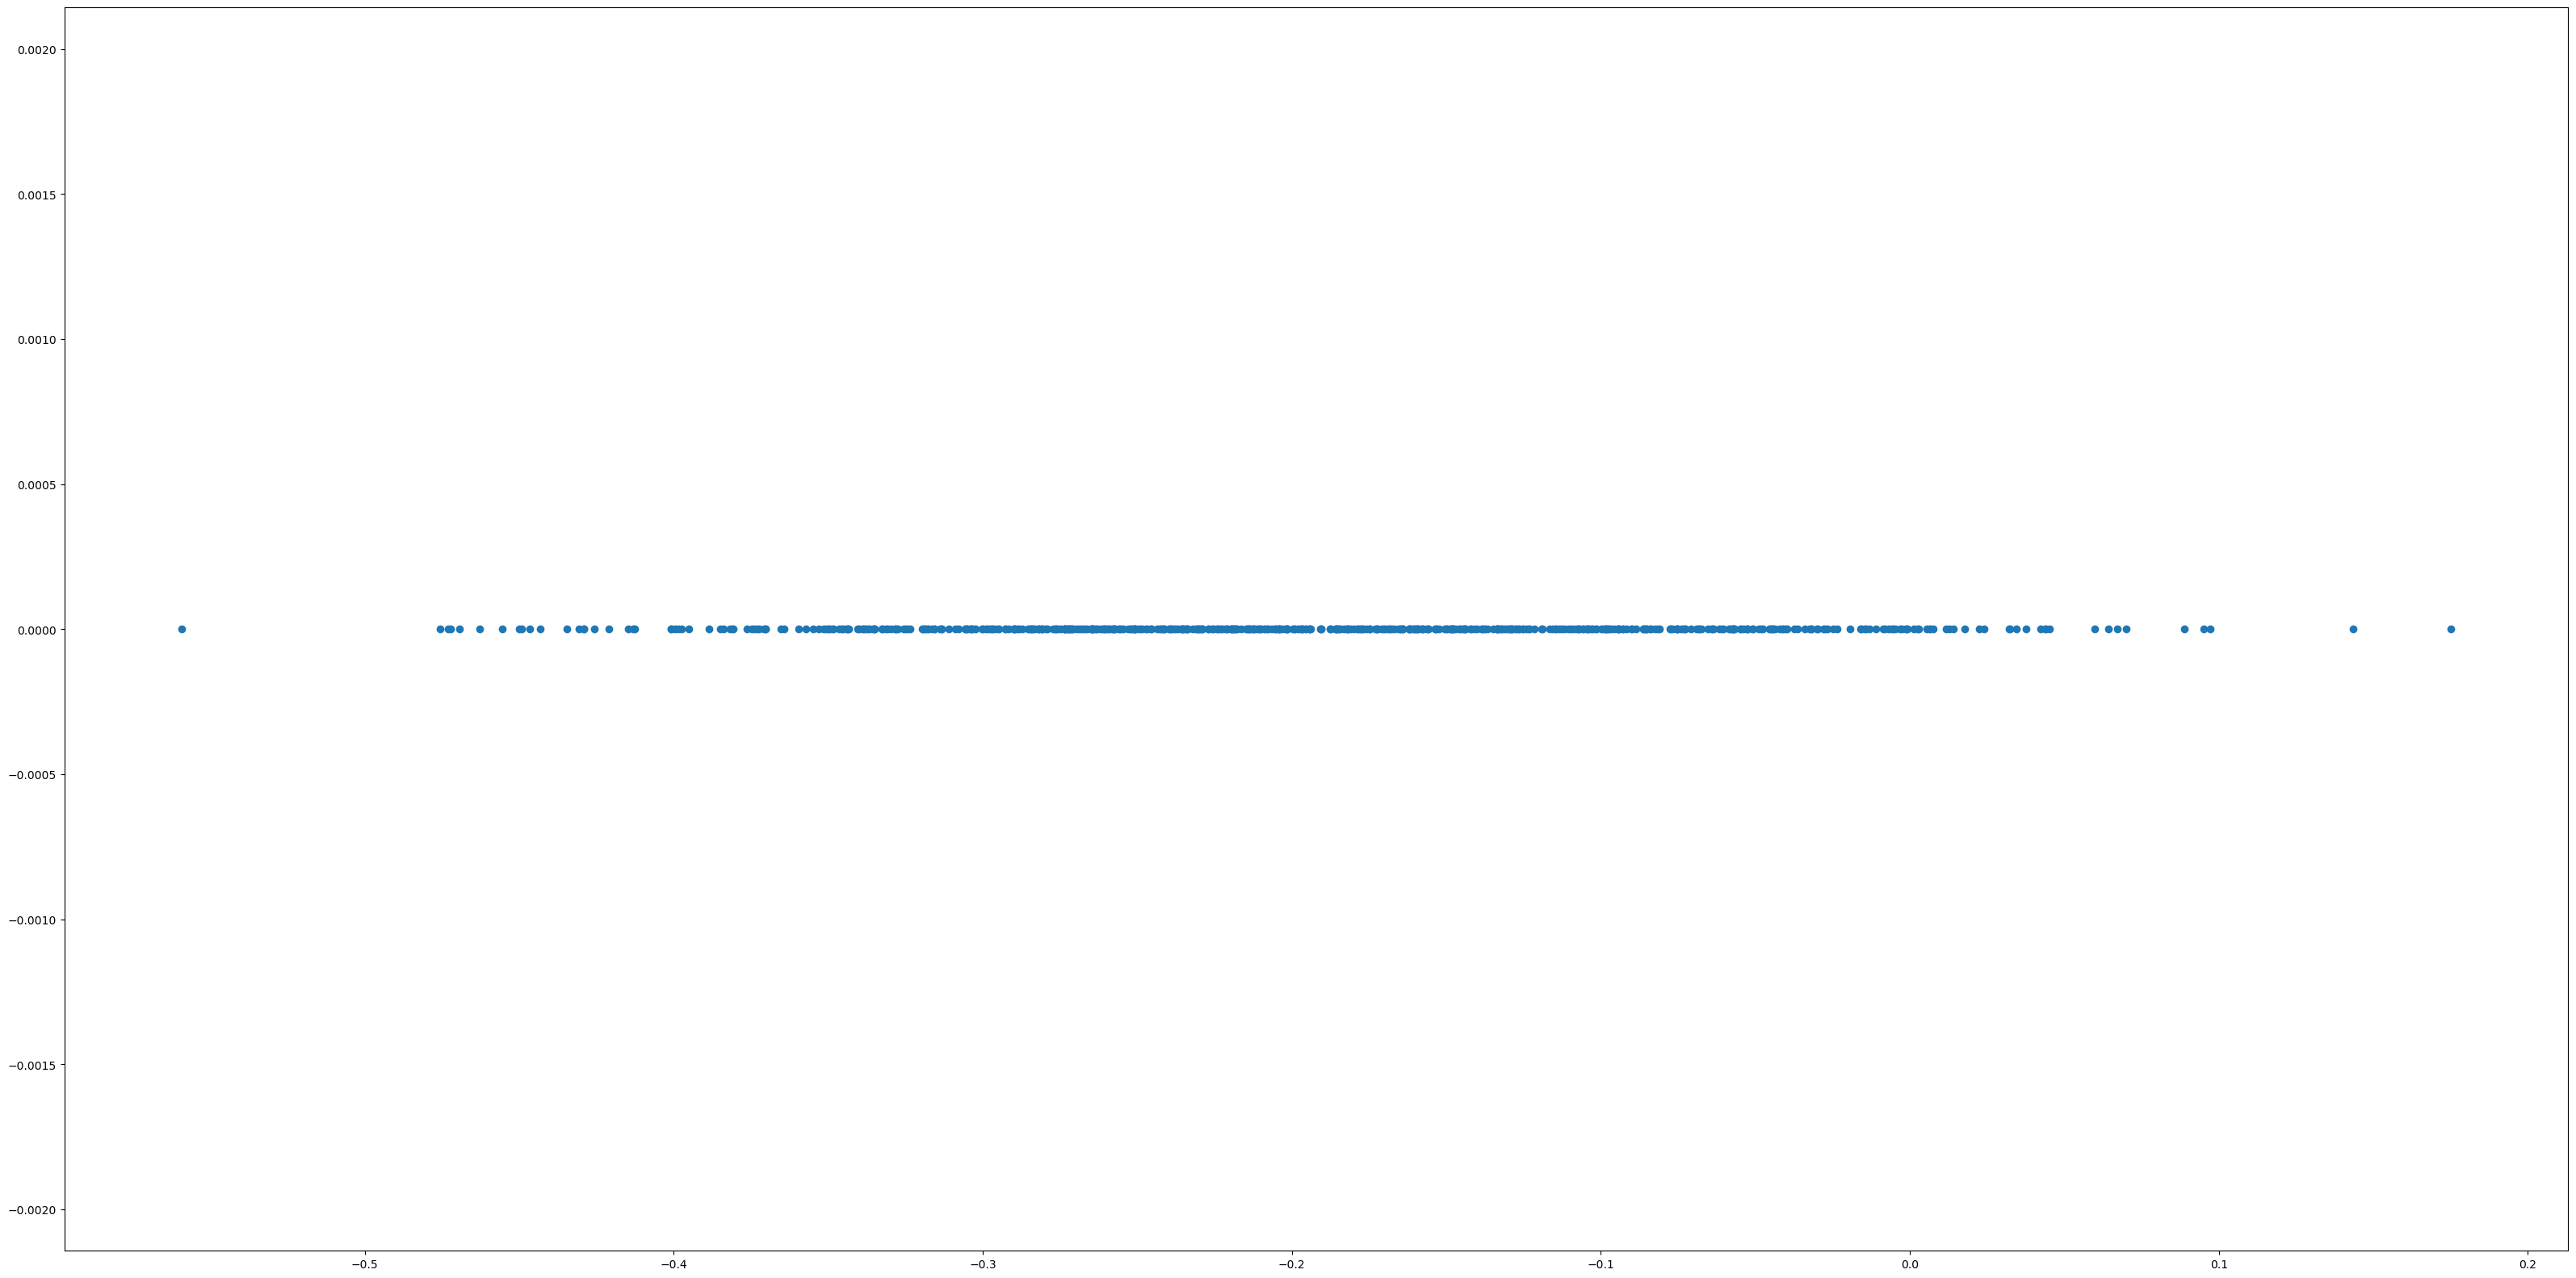

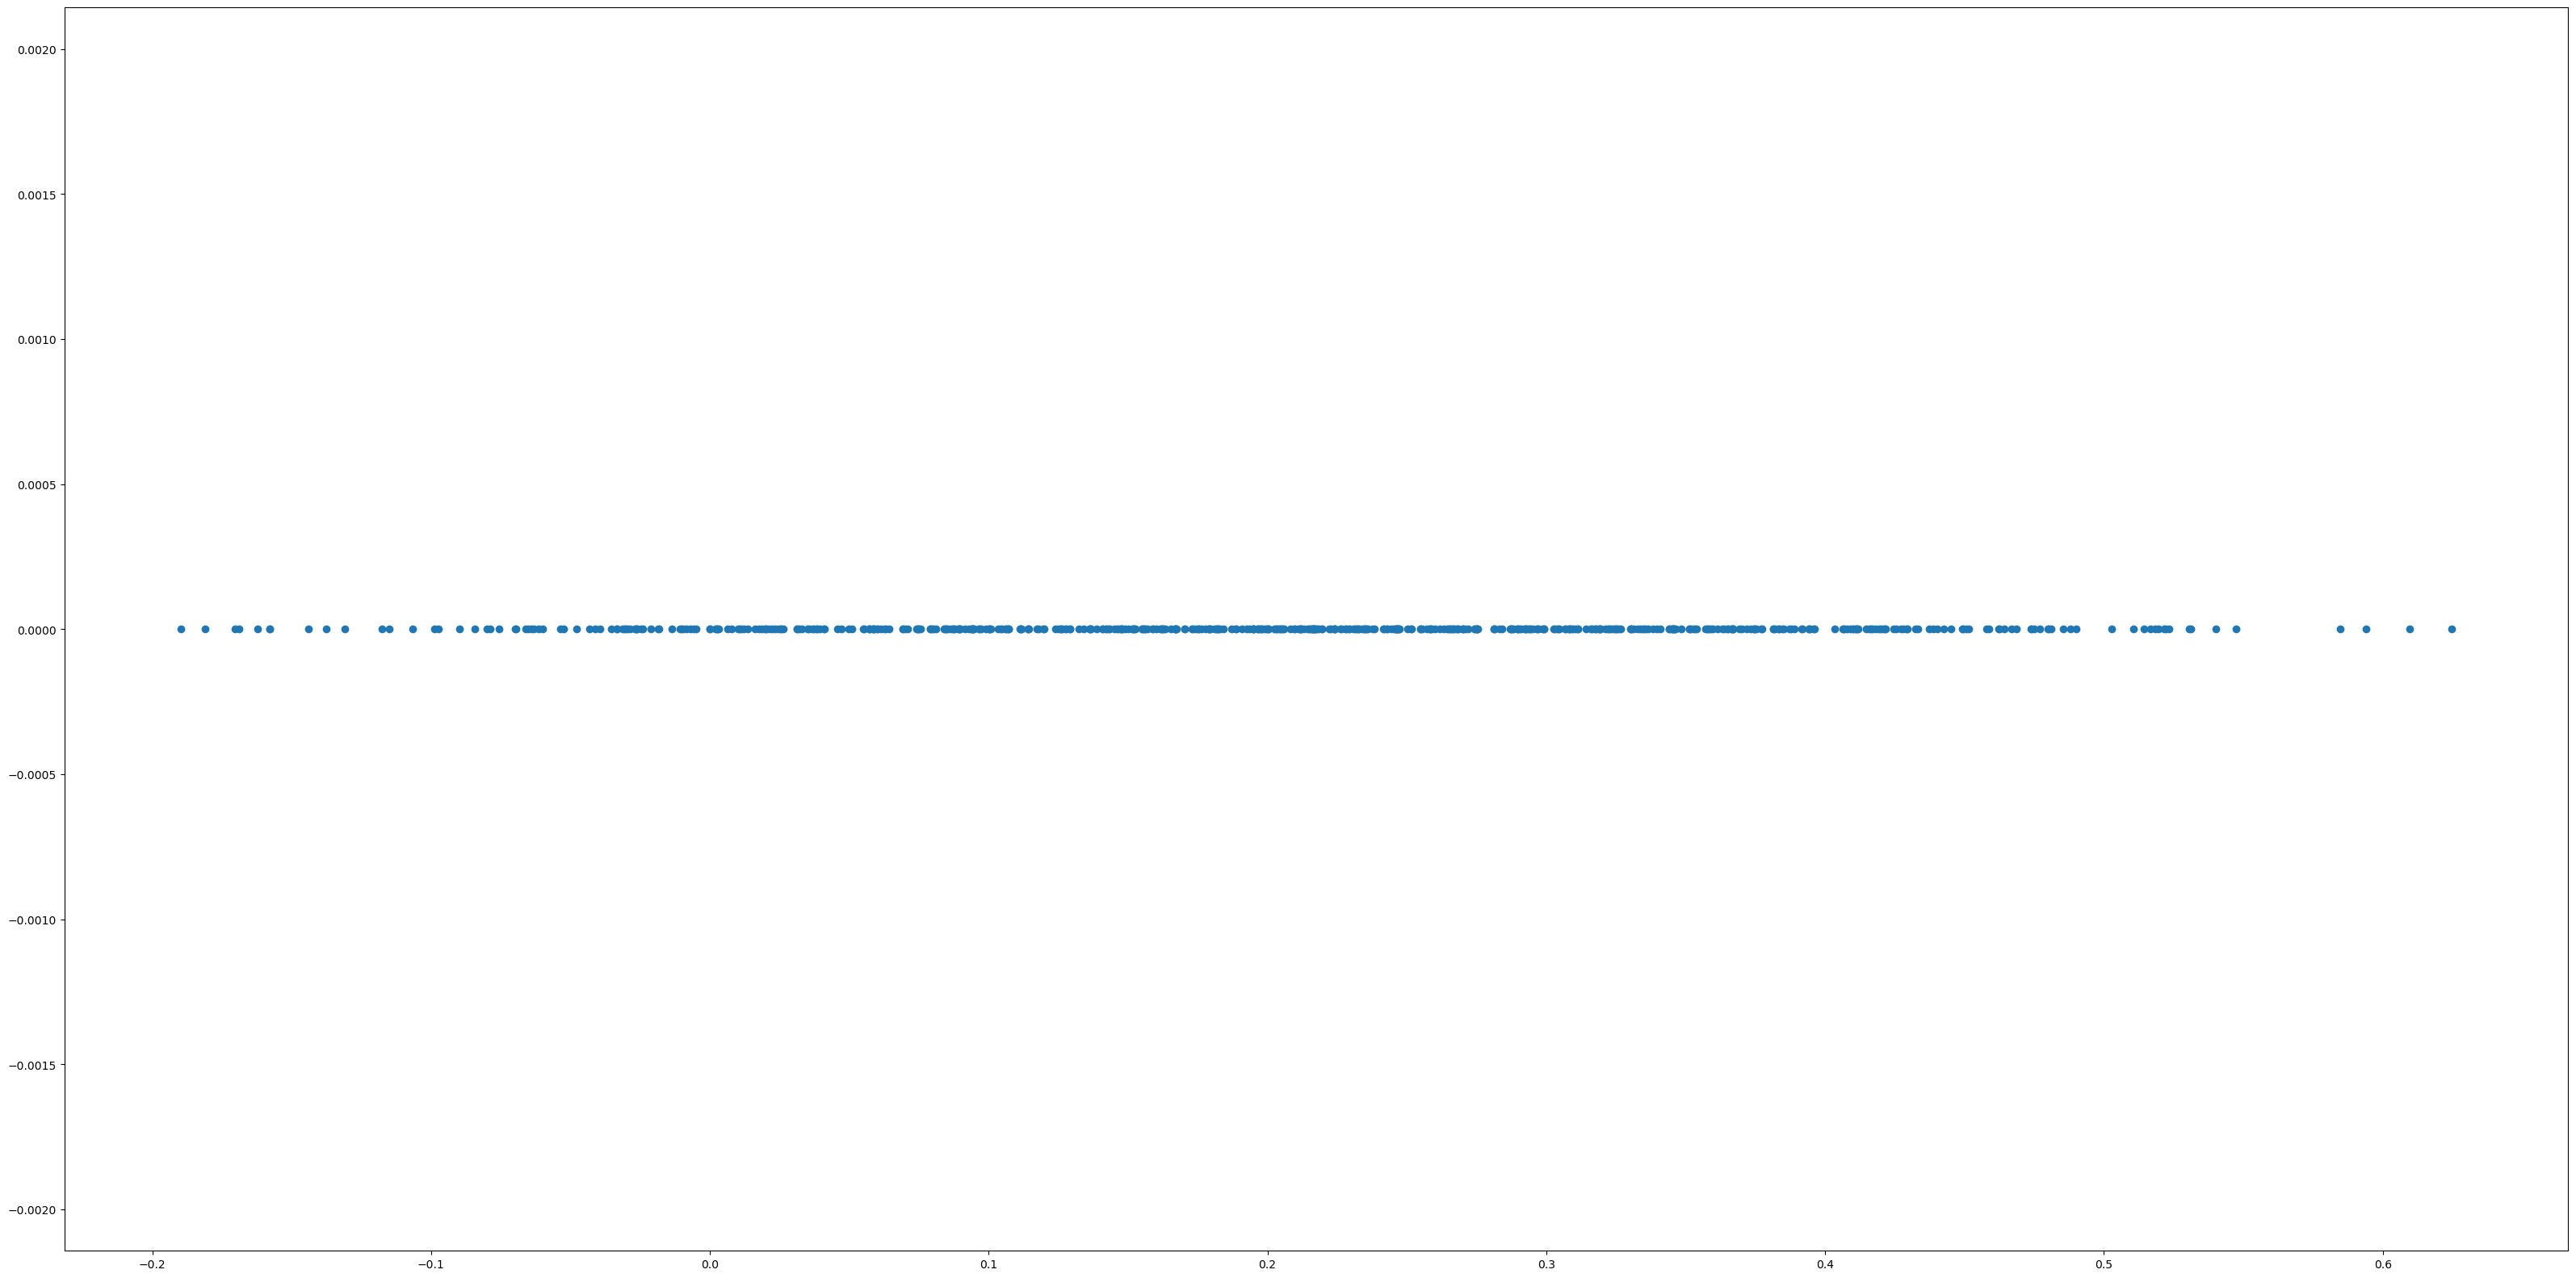

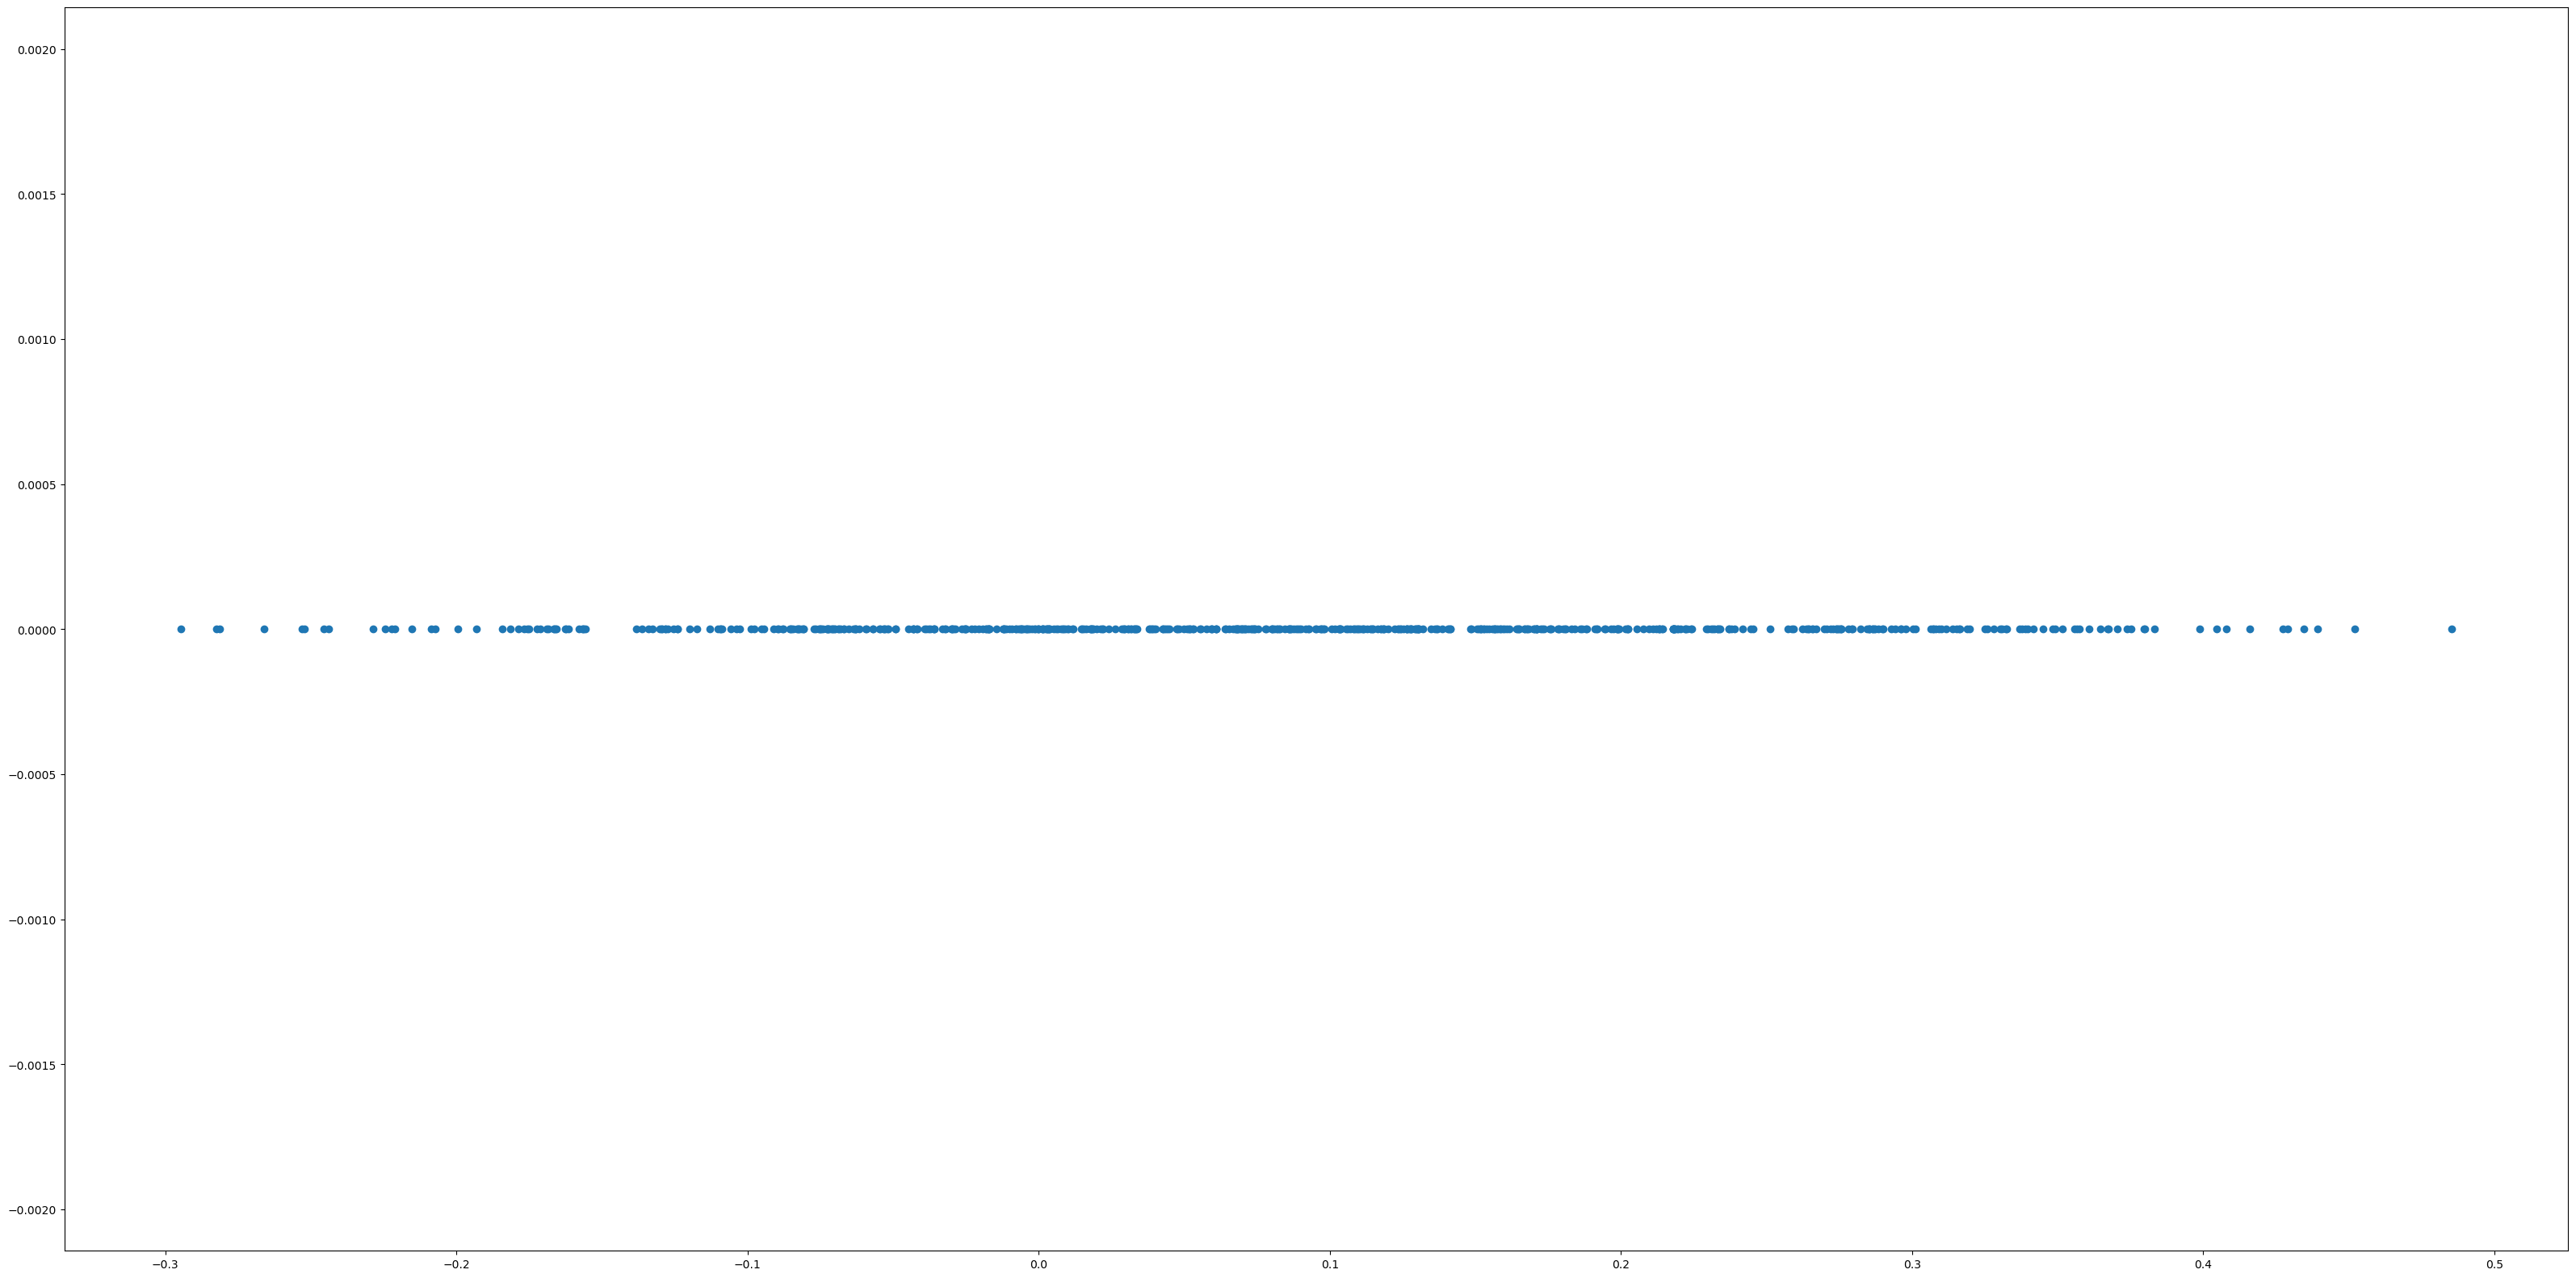

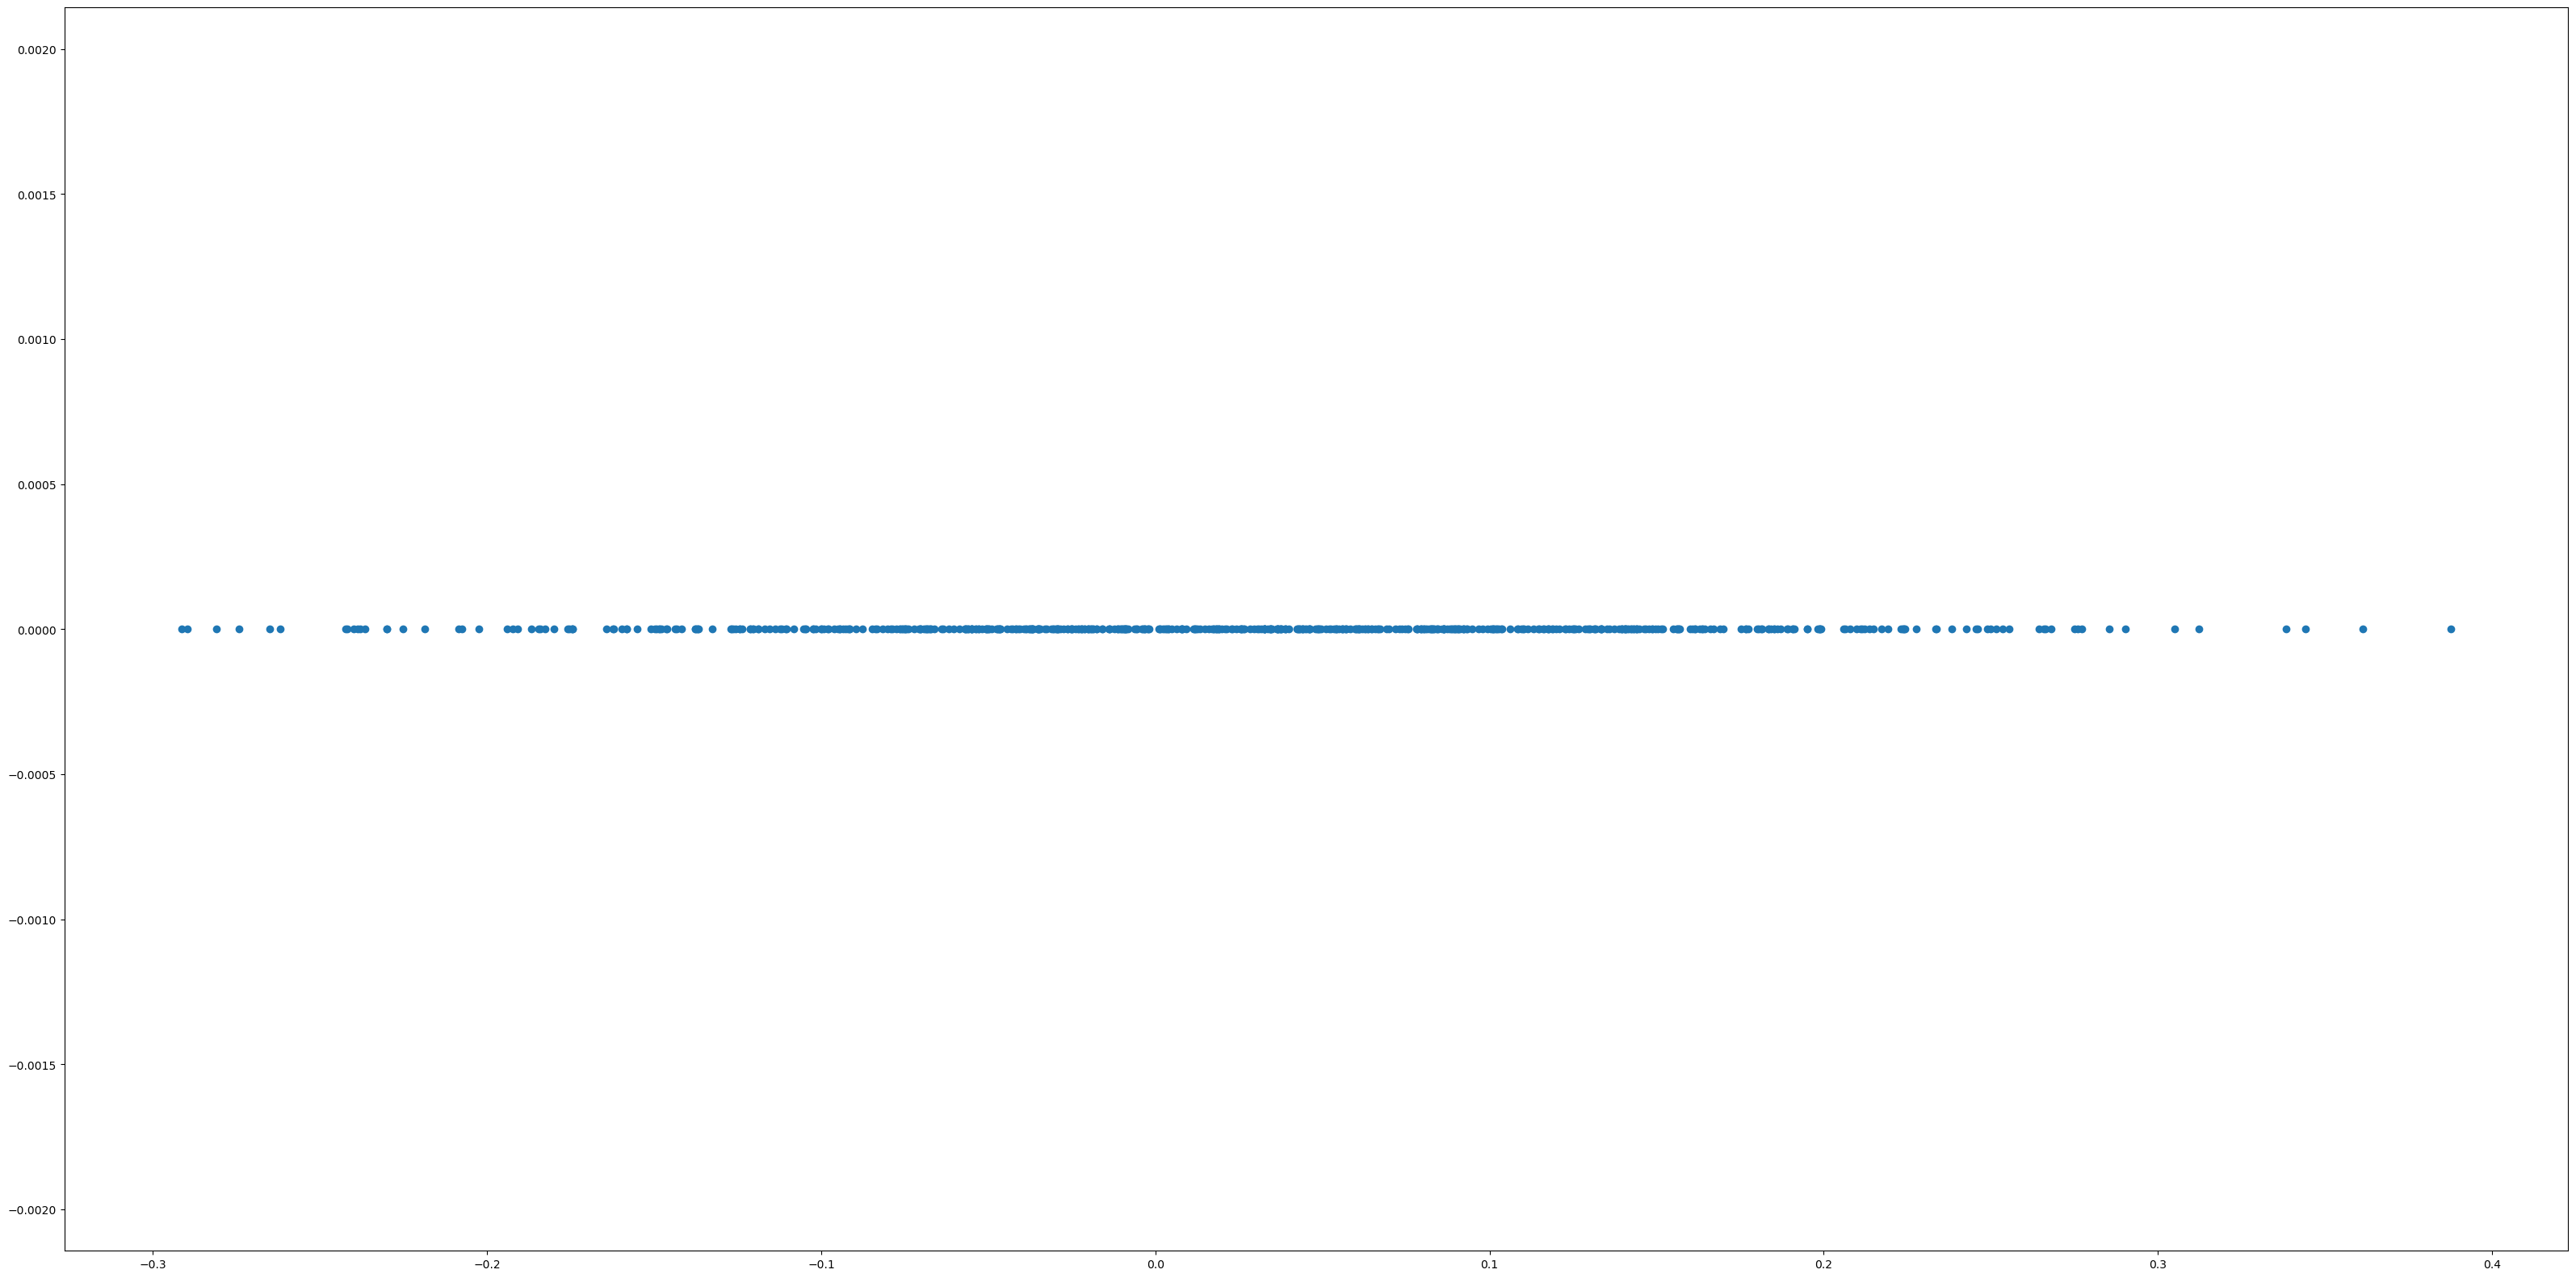

In [1068]:
for i in range(8):
    fig, ax = plt.subplots()
    plt.scatter(outs[2][:,i],np.zeros_like(outs[2][:,i]))
    plt.show()

### Data Generation

In [1069]:
def generate_data(count):
    ax = []
    mins = np.min(outs[2],axis=0)
    maxs = np.max(outs[2],axis=0)
    for i in range(count):
        t = []
        for j in range(8):
            center = (mins[j] +maxs[j])/2
            t.append(np.random.normal(center, (maxs[j]-center)))
        ax.append(np.array(t))
    for i in ax:
        i = i[:, np.newaxis]
    ax =  np.array(ax)   

    new_records = decoder.predict(ax)
    new_records = new_records.reshape(count, 20)
    return new_records

In [1102]:
new = generate_data(500)

In [1103]:
generated_df = pd.DataFrame(new, columns = no_channel_training_cols)

In [1104]:
generated_df

beacon1   beacon2   beacon3   beacon4   beacon5   beacon6   beacon7  \
0    0.749164  0.561757  0.558130  0.598050  0.423875  0.380503  0.429827   
1    0.634725  0.534092  0.539745  0.583157  0.423635  0.462993  0.497117   
2    0.670452  0.515166  0.553923  0.552854  0.441227  0.417429  0.430819   
3    0.668562  0.427878  0.605942  0.563860  0.440372  0.477810  0.512461   
4    0.680612  0.504349  0.561215  0.566718  0.452566  0.422602  0.448919   
..        ...       ...       ...       ...       ...       ...       ...   
495  0.635469  0.480189  0.595238  0.557337  0.435452  0.507531  0.499524   
496  0.643429  0.428338  0.598751  0.565582  0.444470  0.498247  0.515303   
497  0.677273  0.534882  0.551250  0.547949  0.433720  0.419521  0.436106   
498  0.704169  0.471207  0.595244  0.593971  0.464591  0.433375  0.474280   
499  0.646417  0.510161  0.548639  0.545533  0.452210  0.439995  0.456531   

      beacon8   beacon9  beacon10  beacon11  beacon12  beacon13  beacon14  \
0    0.284764  0.500497  0.753583  0.271914  0.412432  0.345800  0.290668   
1    0.423953  0.516668  0.626420  0.375306  0.480280  0.423649  0.416137   
2    0.342992  0.462859  0.688939  0.341260  0.429849  0.396606  0.343240   
3    0.452605  0.439633  0.694765  0.282788  0.397653  0.385885  0.317245   
4    0.352502  0.471709  0.699345  0.325110  0.416153  0.381556  0.332069   
..        ...       ...       ...       ...       ...       ...       ...   
495  0.442121  0.563656  0.635146  0.359547  0.412224  0.434234  0.412648   
496  0.464136  0.474290  0.663930  0.314652  0.391205  0.392737  0.351796   
497  0.347025  0.497718  0.684181  0.339222  0.435226  0.404508  0.351561   
498  0.357431  0.422045  0.733362  0.285391  0.381830  0.343039  0.289883   
499  0.388658  0.501972  0.653369  0.361153  0.440988  0.414068  0.373577   

     beacon15  beacon16  beacon17  beacon18  beacon19  beacon20  
0    0.431624  0.443461  0.441063  0.309621  0.509552  0.459558  
1    0.471611  0.463714  0.453235  0.375633  0.507934  0.489130  
2    0.446889  0.469018  0.453092  0.371893  0.482185  0.462156  
3    0.420313  0.500460  0.497802  0.306452  0.487267  0.497367  
4    0.436931  0.472752  0.458798  0.355261  0.488010  0.467499  
..        ...       ...       ...       ...       ...       ...  
495  0.485415  0.475782  0.465278  0.353210  0.564096  0.472064  
496  0.447052  0.497474  0.489179  0.330800  0.516893  0.490152  
497  0.449891  0.462873  0.459455  0.365092  0.506102  0.464742  
498  0.413321  0.469719  0.481920  0.316954  0.474322  0.469547  
499  0.453152  0.472946  0.462557  0.383005  0.500787  0.473895  

[500 rows x 20 columns]

## Random Forest with Synthesized Data

### Labeling Model Definition

In [1083]:
rfc_syn = RandomForestClassifier()
forest_syn_params = [{'criterion': ["gini", "entropy", "log_loss"], 'max_depth':[5,8,10,12,15], 'max_features': [8,10,15,20]}]
clf2 = GridSearchCV(rfc_syn, forest_syn_params, cv = 3, scoring='accuracy',refit=True,verbose=2)
print(clf2.fit(half_df, half_locations))

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END ........criterion=gini, max_depth=5, max_features=8; total time=   0.2s
[CV] END ........criterion=gini, max_depth=5, max_features=8; total time=   0.2s
[CV] END ........criterion=gini, max_depth=5, max_features=8; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=10; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=10; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=10; total time=   0.2s
[CV] END .......criterion=gini, max_depth=5, max_features=15; total time=   0.3s
[CV] END .......criterion=gini, max_depth=5, max_features=15; total time=   0.3s
[CV] END .......criterion=gini, max_depth=5, max_features=15; total time=   0.3s
[CV] END .......criterion=gini, max_depth=5, max_features=20; total time=   0.4s
[CV] END .......criterion=gini, max_depth=5, max_features=20; total time=   0.4s
[CV] END .......criterion=gini, max_depth=5, ma

[CV] END ...criterion=entropy, max_depth=12, max_features=10; total time=   0.5s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   0.8s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   0.8s
[CV] END ...criterion=entropy, max_depth=12, max_features=15; total time=   0.7s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   1.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   1.0s
[CV] END ...criterion=entropy, max_depth=12, max_features=20; total time=   0.9s
[CV] END ....criterion=entropy, max_depth=15, max_features=8; total time=   0.4s
[CV] END ....criterion=entropy, max_depth=15, max_features=8; total time=   0.4s
[CV] END ....criterion=entropy, max_depth=15, max_features=8; total time=   0.4s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.5s
[CV] END ...criterion=entropy, max_depth=15, max_features=10; total time=   0.5s
[CV] END ...criterion=entrop

In [1084]:
clf2.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=8, max_features=20)

In [1085]:
syn_rforest_predictions = clf2.predict(generated_df)

### Testing the generated plus ground data

In [1086]:
frames = [half_locations, pd.DataFrame(syn_rforest_predictions, columns = ['location'])]
label_combined2 = pd.concat(frames)

rfc_syn_tester = RandomForestClassifier()
forest_syn_params = [{'criterion': ["gini", "entropy", "log_loss"], 'max_depth':[8,10,12], 'max_features': [10,15,20]}]
clf3 = GridSearchCV(rfc_syn_tester, forest_syn_params, cv = 3, scoring='accuracy',refit=True,verbose=2)
print(clf3.fit(train_combined , label_combined2))


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END .......criterion=gini, max_depth=8, max_features=10; total time=   5.1s
[CV] END .......criterion=gini, max_depth=8, max_features=10; total time=   4.8s
[CV] END .......criterion=gini, max_depth=8, max_features=10; total time=   4.3s
[CV] END .......criterion=gini, max_depth=8, max_features=15; total time=   6.0s
[CV] END .......criterion=gini, max_depth=8, max_features=15; total time=   5.8s
[CV] END .......criterion=gini, max_depth=8, max_features=15; total time=   5.6s
[CV] END .......criterion=gini, max_depth=8, max_features=20; total time=   6.8s
[CV] END .......criterion=gini, max_depth=8, max_features=20; total time=   6.7s
[CV] END .......criterion=gini, max_depth=8, max_features=20; total time=   6.4s
[CV] END ......criterion=gini, max_depth=10, max_features=10; total time=   4.6s
[CV] END ......criterion=gini, max_depth=10, max_features=10; total time=   4.5s
[CV] END ......criterion=gini, max_depth=10, max

In [1087]:
clf3.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=10, max_features=20)

In [1088]:
syn_rforest_predictions_clf = clf3.predict(half_df_test)
accuracy_score(half_test_loc, syn_rforest_predictions_clf)*100

57.99999999999999

### Room level accuracy

In [1089]:
room_lev_test_pred_rf = []
for i in syn_rforest_predictions_clf:
    room_lev_test_pred_rf.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())
    
accuracy_score(room_lev_atarget, room_lev_test_pred_rf)*100

80.0

## Accuracies with real Data

In [1090]:
without_syn_predictions = clf2.predict(half_df_test)
accuracy_score(half_test_loc, without_syn_predictions)*100

62.0

In [1091]:
room_lev_test_without_pred_rf = []
for i in without_syn_predictions:
    room_lev_test_without_pred_rf.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())
    
accuracy_score(room_lev_atarget, room_lev_test_without_pred_rf)*100

84.0

### Artificial Neural Network

In [1108]:
ann_model3 = keras.Sequential()
ann_model3.add(keras.layers.InputLayer(input_shape = (20,)))
ann_model3.add(keras.layers.Dense(40, activation ='elu'))
ann_model3.add(keras.layers.Dropout(0.3))
ann_model3.add(keras.layers.Dense(60, activation ='elu'))
ann_model3.add(keras.layers.Dropout(0.3))
ann_model3.add(keras.layers.Dense(96))
ann_model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_289 (Dense)            (None, 40)                840       
_________________________________________________________________
dropout_9 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_290 (Dense)            (None, 60)                2460      
_________________________________________________________________
dropout_10 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_291 (Dense)            (None, 96)                5856      
Total params: 9,156
Trainable params: 9,156
Non-trainable params: 0
_________________________________________________________________


In [1109]:
ann_model3.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam', metrics=['accuracy'])



In [1110]:
hist = ann_model3.fit(train_combined, label_combined , epochs=50,validation_split= 0.3)

Train on 770 samples, validate on 330 samples
Epoch 1/50
770/770 [==============================] - 1s 1ms/step - loss: 4.4529 - accuracy: 0.0597 - val_loss: 3.3245 - val_accuracy: 0.5697
Epoch 2/50
770/770 [==============================] - 0s 170us/step - loss: 4.1528 - accuracy: 0.1234 - val_loss: 2.1812 - val_accuracy: 0.5697
Epoch 3/50
770/770 [==============================] - 0s 154us/step - loss: 3.9504 - accuracy: 0.1338 - val_loss: 1.7328 - val_accuracy: 0.5697
Epoch 4/50
770/770 [==============================] - 0s 151us/step - loss: 3.7730 - accuracy: 0.1532 - val_loss: 1.6250 - val_accuracy: 0.5697
Epoch 5/50
770/770 [==============================] - 0s 150us/step - loss: 3.6735 - accuracy: 0.1390 - val_loss: 1.3881 - val_accuracy: 0.5697
Epoch 6/50
770/770 [==============================] - 0s 156us/step - loss: 3.5220 - accuracy: 0.1481 - val_loss: 1.2422 - val_accuracy: 0.5697
Epoch 7/50
770/770 [==============================] - 0s 156us/step - loss: 3.4014 - accurac

In [1111]:
start_time = time.time()
test_loss, test_acc = ann_model3.evaluate(half_df_test,  half_test_loc, verbose=2)
runtime = round(time.time() - start_time,4)
print("Neural Network algorithm prediction time: "+ str(runtime))
test_acc

Neural Network algorithm prediction time: 0.0081


0.1899999976158142

In [1112]:
room_l = []
for i in syn_rforest_predictions_clf:
    room_l.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())
    
accuracy_score(room_lev_atarget, room_lev_test_pred_rf)*100

80.0

## KNN with Synthesized Data

### Labeling Model Definition

In [1105]:
generated_pred , run_time = run_knn(half_df, half_locations, generated_df, [], 1)

### Testing the generated plus ground data

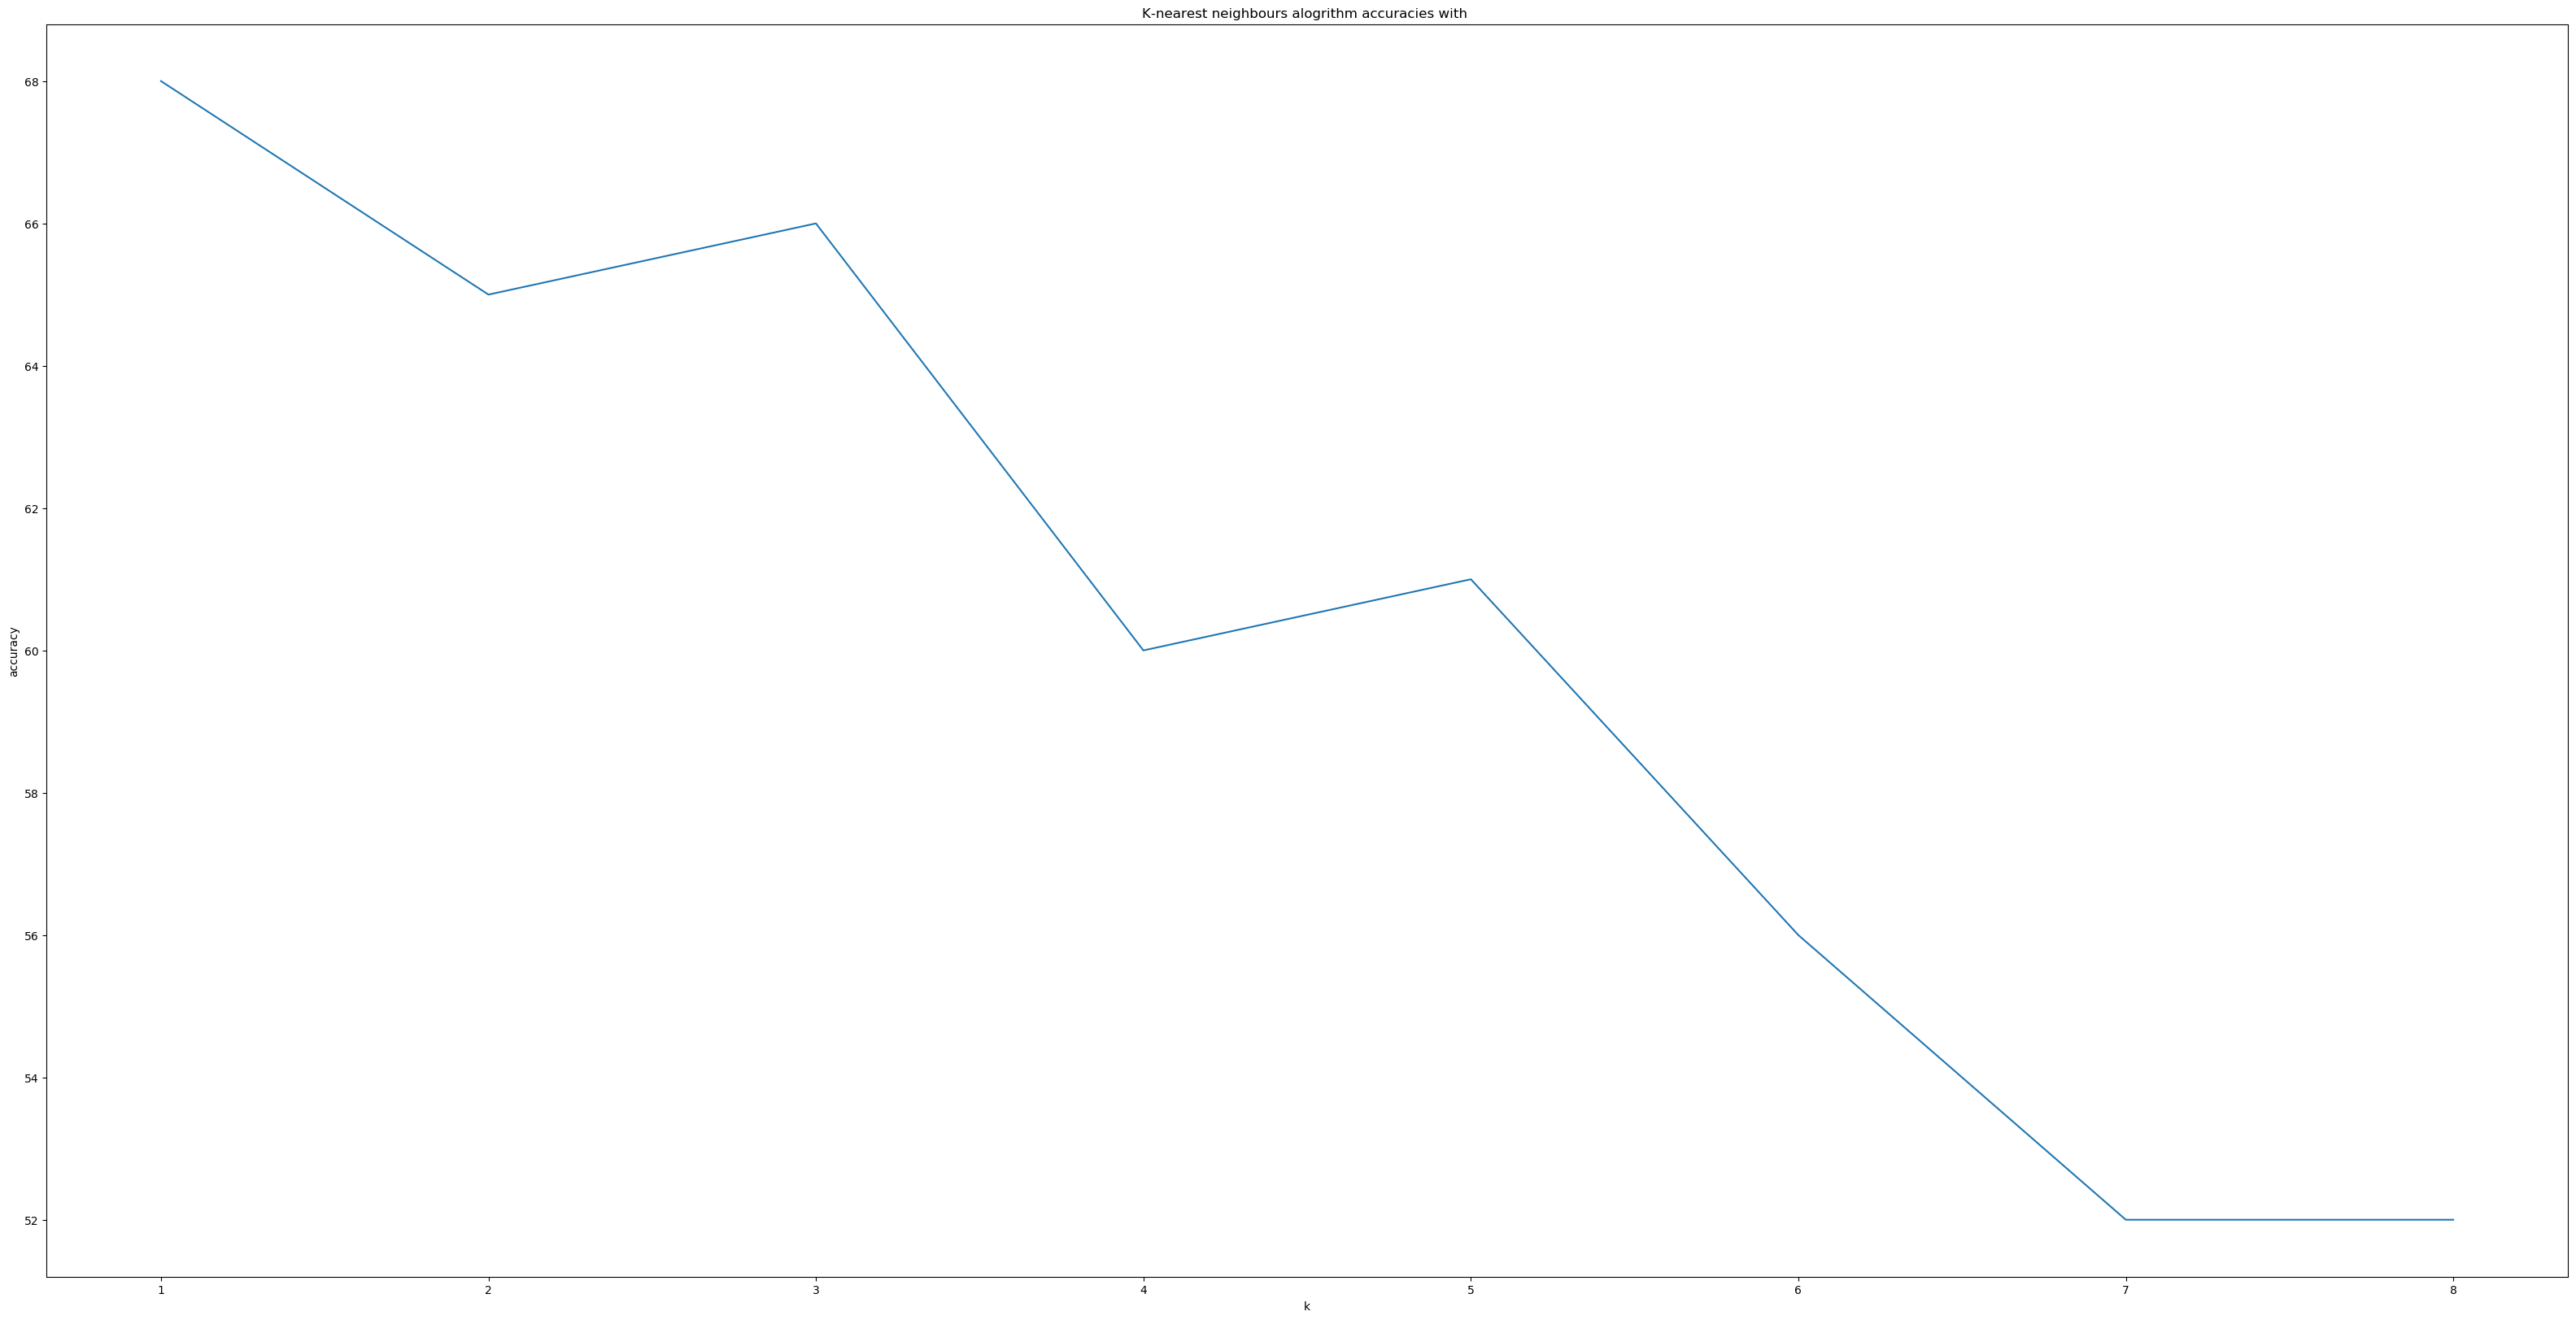

K-nearest neighbours algorithm accuracy: 68.0


68.0

In [1106]:
half_df_test = alpha_filtered2.loc[:, no_channel_training_cols + ['location']].iloc[1::2]
half_df_test = half_df_test.sample(frac=1, random_state = 37)
half_test_loc = half_df_test[:100].loc[:, ['location']]
half_df_test = half_df_test[:100].loc[:, no_channel_training_cols]
half_df_test[:] = min_max_scaler.fit_transform(half_df_test[:])
half_df_test = half_df_test.loc[:, no_channel_training_cols]

frames = [half_df, generated_df]
train_combined = pd.concat(frames)

frames = [half_locations, pd.DataFrame(generated_pred, columns = ['location'])]
label_combined = pd.concat(frames)
k_nearest_neighbours(train_combined, label_combined, half_df_test, half_test_loc, "")




In [1107]:
test_pred , run_time = run_knn(train_combined, label_combined, half_df_test, [], 1)


### Room level accuracy

In [1076]:
room_level_mappings = {0:[0,1,2,3,4,5,6,7,8], 1:[9,10,11,12,13,14,15,16,17], 2:[36,37,38,39,40,41,42], 3:[50,51,52,53],
                      4:[58,59,60,61], 5:[66,67,68,69,70,71,72,73,74,75,76,77,78,79,80], 6:[18,19,20,21,22,23,24,25,26]
                      , 7:[27,28,29,30,31,32,33,34,35],8:[43,44,45,46,47,48,49], 9:[54,55,56,57], 10:[62,63,64,65], 
                      11:[81,82,83,84,85,86,87,88,89,90,91,92,93,94,95]}

In [1077]:
room_lev_test_pred = []
for i in test_pred:
    room_lev_test_pred.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

In [1078]:
room_lev_atarget = []
for i in half_test_loc.to_numpy():
    room_lev_atarget.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

In [1079]:
accuracy_score(room_lev_atarget, room_lev_test_pred)*100

98.0

### Accuracies with real Data

In [1080]:
original_pred , run_time = run_knn(half_df, half_locations, half_df_test, [], 1)
accuracy_score(half_test_loc, original_pred)*100

68.0

In [1081]:
room_lev_original = []
for i in original_pred:
    room_lev_original.append({j for j in room_level_mappings if (i in room_level_mappings[j])}.pop())

In [1082]:
accuracy_score(room_lev_atarget, room_lev_original)*100

98.0